# XGB

In [25]:
import cudf
import cuml
from cuml.preprocessing import StandardScaler
from cuml.model_selection import train_test_split
import xgboost as xgb
from sklearn.model_selection import ParameterGrid
import numpy as np
import time
import joblib

# Convert pandas DataFrame to cuDF
df_gpu = cudf.DataFrame(df)
X = df_gpu.drop('label', axis=1)
y = df_gpu['label']

# Convert data to float32 for better GPU performance
X = X.astype('float32')
y = y.astype('float32')

# Split the data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Scale the data using GPU
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Convert to DMatrix format for XGBoost
dtrain = xgb.DMatrix(X_train_scaled, label=y_train)
dtest = xgb.DMatrix(X_test_scaled, label=y_test)

# Define parameter grid for XGBoost
param_grid = {
    'max_depth': [3, 6, 9],
    'learning_rate': [0.01, 0.1, 0.3],
    'n_estimators': [100, 200, 300],
    'min_child_weight': [1, 3, 5],
    'gamma': [0, 0.1, 0.2],
    'subsample': [0.8, 0.9, 1.0],
    'colsample_bytree': [0.8, 0.9, 1.0]
}

# Calculate total combinations
total_combinations = len([p for p in ParameterGrid(param_grid)])
print(f"Total parameter combinations: {total_combinations}")

# Initialize variables
best_score = 0
best_params = None
best_model = None

# Function to format time
def format_time(seconds):
    hours = int(seconds // 3600)
    minutes = int((seconds % 3600) // 60)
    seconds = int(seconds % 60)
    return f"{hours:02d}:{minutes:02d}:{seconds:02d}"

# Grid search with progress tracking
start_time = time.time()
for i, params in enumerate(ParameterGrid(param_grid), 1):
    iteration_start = time.time()
    current_time = time.strftime('%H:%M:%S')

    print(f"\nCombination {i}/{total_combinations} at {current_time}")
    print(f"Parameters: {params}")

    # Prepare XGBoost parameters
    xgb_params = {
        'max_depth': params['max_depth'],
        'learning_rate': params['learning_rate'],
        'min_child_weight': params['min_child_weight'],
        'gamma': params['gamma'],
        'subsample': params['subsample'],
        'colsample_bytree': params['colsample_bytree'],
        'objective': 'multi:softmax',
        'num_class': len(np.unique(y.values.get())),
        'tree_method': 'gpu_hist',  # Use GPU acceleration
        'random_state': 42
    }

    # Train model
    model = xgb.train(
        xgb_params,
        dtrain,
        num_boost_round=params['n_estimators']
    )

    # Calculate scores
    train_pred = model.predict(dtrain)
    test_pred = model.predict(dtest)
    train_score = (train_pred == y_train.values.get()).mean()
    test_score = (test_pred == y_test.values.get()).mean()

    iteration_time = time.time() - iteration_start

    print(f"Training Score: {train_score:.4f}")
    print(f"Test Score: {test_score:.4f}")
    print(f"Iteration Time: {format_time(iteration_time)}")

    if test_score > best_score:
        best_score = test_score
        best_params = params
        best_model = model
        print(f"New best score: {best_score:.4f}")

# Print final results
total_time = time.time() - start_time
print("\n" + "="*50)
print("Grid Search Completed!")
print(f"Total Time: {format_time(total_time)}")
print(f"Best Parameters: {best_params}")
print(f"Best Test Score: {best_score:.4f}")

# Save the best model
best_model.save_model('XGB_GPU.pkl')

# Fine-tuning phase
print("\nStarting fine-tuning phase...")

# Create fine-tuning grid based on best parameters
fine_tune_grid = {
    'max_depth': [best_params['max_depth'] - 1, best_params['max_depth'], best_params['max_depth'] + 1],
    'learning_rate': [best_params['learning_rate'] * 0.5, best_params['learning_rate'], best_params['learning_rate'] * 1.5],
    'n_estimators': [best_params['n_estimators'] - 50, best_params['n_estimators'], best_params['n_estimators'] + 50],
    'min_child_weight': [best_params['min_child_weight']],
    'gamma': [best_params['gamma']],
    'subsample': [best_params['subsample']],
    'colsample_bytree': [best_params['colsample_bytree']]
}

# Fine-tuning search
fine_tune_start = time.time()
for i, params in enumerate(ParameterGrid(fine_tune_grid), 1):
    iteration_start = time.time()
    print(f"\nFine-tuning combination {i}/{len(list(ParameterGrid(fine_tune_grid)))}")

    xgb_params = {
        'max_depth': params['max_depth'],
        'learning_rate': params['learning_rate'],
        'min_child_weight': params['min_child_weight'],
        'gamma': params['gamma'],
        'subsample': params['subsample'],
        'colsample_bytree': params['colsample_bytree'],
        'objective': 'multi:softmax',
        'num_class': len(np.unique(y.values.get())),
        'tree_method': 'gpu_hist',
        'random_state': 42
    }

    model = xgb.train(
        xgb_params,
        dtrain,
        num_boost_round=params['n_estimators']
    )

    test_pred = model.predict(dtest)
    test_score = (test_pred == y_test.values.get()).mean()

    if test_score > best_score:
        best_score = test_score
        best_params = params
        best_model = model
        print(f"New best score: {best_score:.4f}")

# Print final results
print("\n" + "="*50)
print("Fine-tuning Completed!")
print(f"Final Best Parameters: {best_params}")
print(f"Final Best Score: {best_score:.4f}")

# Save the final model
best_model.save_model('XGB_GPU_final.pkl')

# For predictions
y_pred = best_model.predict(dtest)

Total parameter combinations: 2187

Combination 1/2187 at 05:58:18
Parameters: {'colsample_bytree': 0.8, 'gamma': 0, 'learning_rate': 0.01, 'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 100, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [05:58:18] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [05:58:19] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.8636
Test Score: 0.8635
Iteration Time: 00:00:00
New best score: 0.8635

Combination 2/2187 at 05:58:19
Parameters: {'colsample_bytree': 0.8, 'gamma': 0, 'learning_rate': 0.01, 'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 100, 'subsample': 0.9}
Training Score: 0.8635
Test Score: 0.8636
Iteration Time: 00:00:00
New best score: 0.8636

Combination 3/2187 at 05:58:19
Parameters: {'colsample_bytree': 0.8, 'gamma': 0, 'learning_rate': 0.01, 'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 100, 'subsample': 1.0}
Training Score: 0.8635
Test Score: 0.8634
Iteration Time: 00:00:00

Combination 4/2187 at 05:58:19
Parameters: {'colsample_bytree': 0.8, 'gamma': 0, 'learning_rate': 0.01, 'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 200, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [05:58:20] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.8794
Test Score: 0.8784
Iteration Time: 00:00:00
New best score: 0.8784

Combination 5/2187 at 05:58:20
Parameters: {'colsample_bytree': 0.8, 'gamma': 0, 'learning_rate': 0.01, 'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 200, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [05:58:21] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.8789
Test Score: 0.8784
Iteration Time: 00:00:00
New best score: 0.8784

Combination 6/2187 at 05:58:21
Parameters: {'colsample_bytree': 0.8, 'gamma': 0, 'learning_rate': 0.01, 'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 200, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [05:58:22] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.8790
Test Score: 0.8786
Iteration Time: 00:00:00
New best score: 0.8786

Combination 7/2187 at 05:58:22
Parameters: {'colsample_bytree': 0.8, 'gamma': 0, 'learning_rate': 0.01, 'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 300, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [05:58:24] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.8909
Test Score: 0.8904
Iteration Time: 00:00:01
New best score: 0.8904

Combination 8/2187 at 05:58:24
Parameters: {'colsample_bytree': 0.8, 'gamma': 0, 'learning_rate': 0.01, 'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 300, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [05:58:25] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.8907
Test Score: 0.8898
Iteration Time: 00:00:01

Combination 9/2187 at 05:58:25
Parameters: {'colsample_bytree': 0.8, 'gamma': 0, 'learning_rate': 0.01, 'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 300, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [05:58:27] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.8914
Test Score: 0.8904
Iteration Time: 00:00:01

Combination 10/2187 at 05:58:27
Parameters: {'colsample_bytree': 0.8, 'gamma': 0, 'learning_rate': 0.01, 'max_depth': 3, 'min_child_weight': 3, 'n_estimators': 100, 'subsample': 0.8}
Training Score: 0.8636
Test Score: 0.8635
Iteration Time: 00:00:00

Combination 11/2187 at 05:58:27
Parameters: {'colsample_bytree': 0.8, 'gamma': 0, 'learning_rate': 0.01, 'max_depth': 3, 'min_child_weight': 3, 'n_estimators': 100, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [05:58:28] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.8635
Test Score: 0.8636
Iteration Time: 00:00:00

Combination 12/2187 at 05:58:28
Parameters: {'colsample_bytree': 0.8, 'gamma': 0, 'learning_rate': 0.01, 'max_depth': 3, 'min_child_weight': 3, 'n_estimators': 100, 'subsample': 1.0}
Training Score: 0.8635
Test Score: 0.8634
Iteration Time: 00:00:00

Combination 13/2187 at 05:58:28
Parameters: {'colsample_bytree': 0.8, 'gamma': 0, 'learning_rate': 0.01, 'max_depth': 3, 'min_child_weight': 3, 'n_estimators': 200, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [05:58:29] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.8794
Test Score: 0.8784
Iteration Time: 00:00:00

Combination 14/2187 at 05:58:29
Parameters: {'colsample_bytree': 0.8, 'gamma': 0, 'learning_rate': 0.01, 'max_depth': 3, 'min_child_weight': 3, 'n_estimators': 200, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [05:58:30] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.8789
Test Score: 0.8784
Iteration Time: 00:00:00

Combination 15/2187 at 05:58:30
Parameters: {'colsample_bytree': 0.8, 'gamma': 0, 'learning_rate': 0.01, 'max_depth': 3, 'min_child_weight': 3, 'n_estimators': 200, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [05:58:31] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.8790
Test Score: 0.8786
Iteration Time: 00:00:00

Combination 16/2187 at 05:58:31
Parameters: {'colsample_bytree': 0.8, 'gamma': 0, 'learning_rate': 0.01, 'max_depth': 3, 'min_child_weight': 3, 'n_estimators': 300, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [05:58:32] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.8909
Test Score: 0.8904
Iteration Time: 00:00:01

Combination 17/2187 at 05:58:32
Parameters: {'colsample_bytree': 0.8, 'gamma': 0, 'learning_rate': 0.01, 'max_depth': 3, 'min_child_weight': 3, 'n_estimators': 300, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [05:58:34] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.8907
Test Score: 0.8898
Iteration Time: 00:00:01

Combination 18/2187 at 05:58:34
Parameters: {'colsample_bytree': 0.8, 'gamma': 0, 'learning_rate': 0.01, 'max_depth': 3, 'min_child_weight': 3, 'n_estimators': 300, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [05:58:35] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.8914
Test Score: 0.8904
Iteration Time: 00:00:01

Combination 19/2187 at 05:58:35
Parameters: {'colsample_bytree': 0.8, 'gamma': 0, 'learning_rate': 0.01, 'max_depth': 3, 'min_child_weight': 5, 'n_estimators': 100, 'subsample': 0.8}
Training Score: 0.8636
Test Score: 0.8635
Iteration Time: 00:00:00

Combination 20/2187 at 05:58:35
Parameters: {'colsample_bytree': 0.8, 'gamma': 0, 'learning_rate': 0.01, 'max_depth': 3, 'min_child_weight': 5, 'n_estimators': 100, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [05:58:36] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.8635
Test Score: 0.8636
Iteration Time: 00:00:00

Combination 21/2187 at 05:58:36
Parameters: {'colsample_bytree': 0.8, 'gamma': 0, 'learning_rate': 0.01, 'max_depth': 3, 'min_child_weight': 5, 'n_estimators': 100, 'subsample': 1.0}
Training Score: 0.8635
Test Score: 0.8634
Iteration Time: 00:00:00

Combination 22/2187 at 05:58:36
Parameters: {'colsample_bytree': 0.8, 'gamma': 0, 'learning_rate': 0.01, 'max_depth': 3, 'min_child_weight': 5, 'n_estimators': 200, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [05:58:37] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.8794
Test Score: 0.8784
Iteration Time: 00:00:01

Combination 23/2187 at 05:58:37
Parameters: {'colsample_bytree': 0.8, 'gamma': 0, 'learning_rate': 0.01, 'max_depth': 3, 'min_child_weight': 5, 'n_estimators': 200, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [05:58:38] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.8789
Test Score: 0.8784
Iteration Time: 00:00:01

Combination 24/2187 at 05:58:38
Parameters: {'colsample_bytree': 0.8, 'gamma': 0, 'learning_rate': 0.01, 'max_depth': 3, 'min_child_weight': 5, 'n_estimators': 200, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [05:58:39] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.8790
Test Score: 0.8786
Iteration Time: 00:00:01

Combination 25/2187 at 05:58:39
Parameters: {'colsample_bytree': 0.8, 'gamma': 0, 'learning_rate': 0.01, 'max_depth': 3, 'min_child_weight': 5, 'n_estimators': 300, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [05:58:41] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.8909
Test Score: 0.8904
Iteration Time: 00:00:01

Combination 26/2187 at 05:58:41
Parameters: {'colsample_bytree': 0.8, 'gamma': 0, 'learning_rate': 0.01, 'max_depth': 3, 'min_child_weight': 5, 'n_estimators': 300, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [05:58:42] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.8907
Test Score: 0.8898
Iteration Time: 00:00:01

Combination 27/2187 at 05:58:42
Parameters: {'colsample_bytree': 0.8, 'gamma': 0, 'learning_rate': 0.01, 'max_depth': 3, 'min_child_weight': 5, 'n_estimators': 300, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [05:58:43] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [05:58:44] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.8914
Test Score: 0.8904
Iteration Time: 00:00:01

Combination 28/2187 at 05:58:44
Parameters: {'colsample_bytree': 0.8, 'gamma': 0, 'learning_rate': 0.01, 'max_depth': 6, 'min_child_weight': 1, 'n_estimators': 100, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [05:58:45] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9101
Test Score: 0.9056
Iteration Time: 00:00:01
New best score: 0.9056

Combination 29/2187 at 05:58:45
Parameters: {'colsample_bytree': 0.8, 'gamma': 0, 'learning_rate': 0.01, 'max_depth': 6, 'min_child_weight': 1, 'n_estimators': 100, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [05:58:46] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9097
Test Score: 0.9053
Iteration Time: 00:00:01

Combination 30/2187 at 05:58:46
Parameters: {'colsample_bytree': 0.8, 'gamma': 0, 'learning_rate': 0.01, 'max_depth': 6, 'min_child_weight': 1, 'n_estimators': 100, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [05:58:47] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9099
Test Score: 0.9054
Iteration Time: 00:00:01

Combination 31/2187 at 05:58:47
Parameters: {'colsample_bytree': 0.8, 'gamma': 0, 'learning_rate': 0.01, 'max_depth': 6, 'min_child_weight': 1, 'n_estimators': 200, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [05:58:49] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9218
Test Score: 0.9168
Iteration Time: 00:00:02
New best score: 0.9168

Combination 32/2187 at 05:58:49
Parameters: {'colsample_bytree': 0.8, 'gamma': 0, 'learning_rate': 0.01, 'max_depth': 6, 'min_child_weight': 1, 'n_estimators': 200, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [05:58:51] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9221
Test Score: 0.9166
Iteration Time: 00:00:02

Combination 33/2187 at 05:58:51
Parameters: {'colsample_bytree': 0.8, 'gamma': 0, 'learning_rate': 0.01, 'max_depth': 6, 'min_child_weight': 1, 'n_estimators': 200, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [05:58:53] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9218
Test Score: 0.9164
Iteration Time: 00:00:02

Combination 34/2187 at 05:58:53
Parameters: {'colsample_bytree': 0.8, 'gamma': 0, 'learning_rate': 0.01, 'max_depth': 6, 'min_child_weight': 1, 'n_estimators': 300, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [05:58:56] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9301
Test Score: 0.9243
Iteration Time: 00:00:03
New best score: 0.9243

Combination 35/2187 at 05:58:56
Parameters: {'colsample_bytree': 0.8, 'gamma': 0, 'learning_rate': 0.01, 'max_depth': 6, 'min_child_weight': 1, 'n_estimators': 300, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [05:58:59] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9303
Test Score: 0.9237
Iteration Time: 00:00:03

Combination 36/2187 at 05:58:59
Parameters: {'colsample_bytree': 0.8, 'gamma': 0, 'learning_rate': 0.01, 'max_depth': 6, 'min_child_weight': 1, 'n_estimators': 300, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [05:59:02] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9301
Test Score: 0.9233
Iteration Time: 00:00:03

Combination 37/2187 at 05:59:02
Parameters: {'colsample_bytree': 0.8, 'gamma': 0, 'learning_rate': 0.01, 'max_depth': 6, 'min_child_weight': 3, 'n_estimators': 100, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [05:59:03] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9101
Test Score: 0.9057
Iteration Time: 00:00:01

Combination 38/2187 at 05:59:03
Parameters: {'colsample_bytree': 0.8, 'gamma': 0, 'learning_rate': 0.01, 'max_depth': 6, 'min_child_weight': 3, 'n_estimators': 100, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [05:59:04] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9097
Test Score: 0.9056
Iteration Time: 00:00:01

Combination 39/2187 at 05:59:04
Parameters: {'colsample_bytree': 0.8, 'gamma': 0, 'learning_rate': 0.01, 'max_depth': 6, 'min_child_weight': 3, 'n_estimators': 100, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [05:59:05] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9098
Test Score: 0.9050
Iteration Time: 00:00:01

Combination 40/2187 at 05:59:05
Parameters: {'colsample_bytree': 0.8, 'gamma': 0, 'learning_rate': 0.01, 'max_depth': 6, 'min_child_weight': 3, 'n_estimators': 200, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [05:59:08] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9218
Test Score: 0.9166
Iteration Time: 00:00:02

Combination 41/2187 at 05:59:08
Parameters: {'colsample_bytree': 0.8, 'gamma': 0, 'learning_rate': 0.01, 'max_depth': 6, 'min_child_weight': 3, 'n_estimators': 200, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [05:59:10] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9221
Test Score: 0.9165
Iteration Time: 00:00:02

Combination 42/2187 at 05:59:10
Parameters: {'colsample_bytree': 0.8, 'gamma': 0, 'learning_rate': 0.01, 'max_depth': 6, 'min_child_weight': 3, 'n_estimators': 200, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [05:59:12] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9221
Test Score: 0.9167
Iteration Time: 00:00:02

Combination 43/2187 at 05:59:12
Parameters: {'colsample_bytree': 0.8, 'gamma': 0, 'learning_rate': 0.01, 'max_depth': 6, 'min_child_weight': 3, 'n_estimators': 300, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [05:59:15] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9300
Test Score: 0.9243
Iteration Time: 00:00:03
New best score: 0.9243

Combination 44/2187 at 05:59:15
Parameters: {'colsample_bytree': 0.8, 'gamma': 0, 'learning_rate': 0.01, 'max_depth': 6, 'min_child_weight': 3, 'n_estimators': 300, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [05:59:18] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9302
Test Score: 0.9238
Iteration Time: 00:00:03

Combination 45/2187 at 05:59:18
Parameters: {'colsample_bytree': 0.8, 'gamma': 0, 'learning_rate': 0.01, 'max_depth': 6, 'min_child_weight': 3, 'n_estimators': 300, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [05:59:21] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9301
Test Score: 0.9234
Iteration Time: 00:00:03

Combination 46/2187 at 05:59:21
Parameters: {'colsample_bytree': 0.8, 'gamma': 0, 'learning_rate': 0.01, 'max_depth': 6, 'min_child_weight': 5, 'n_estimators': 100, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [05:59:22] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [05:59:23] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9102
Test Score: 0.9057
Iteration Time: 00:00:01

Combination 47/2187 at 05:59:23
Parameters: {'colsample_bytree': 0.8, 'gamma': 0, 'learning_rate': 0.01, 'max_depth': 6, 'min_child_weight': 5, 'n_estimators': 100, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [05:59:24] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9097
Test Score: 0.9055
Iteration Time: 00:00:01

Combination 48/2187 at 05:59:24
Parameters: {'colsample_bytree': 0.8, 'gamma': 0, 'learning_rate': 0.01, 'max_depth': 6, 'min_child_weight': 5, 'n_estimators': 100, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [05:59:25] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9099
Test Score: 0.9046
Iteration Time: 00:00:01

Combination 49/2187 at 05:59:25
Parameters: {'colsample_bytree': 0.8, 'gamma': 0, 'learning_rate': 0.01, 'max_depth': 6, 'min_child_weight': 5, 'n_estimators': 200, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [05:59:27] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9219
Test Score: 0.9165
Iteration Time: 00:00:02

Combination 50/2187 at 05:59:27
Parameters: {'colsample_bytree': 0.8, 'gamma': 0, 'learning_rate': 0.01, 'max_depth': 6, 'min_child_weight': 5, 'n_estimators': 200, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [05:59:29] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9221
Test Score: 0.9165
Iteration Time: 00:00:02

Combination 51/2187 at 05:59:29
Parameters: {'colsample_bytree': 0.8, 'gamma': 0, 'learning_rate': 0.01, 'max_depth': 6, 'min_child_weight': 5, 'n_estimators': 200, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [05:59:31] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9220
Test Score: 0.9164
Iteration Time: 00:00:02

Combination 52/2187 at 05:59:31
Parameters: {'colsample_bytree': 0.8, 'gamma': 0, 'learning_rate': 0.01, 'max_depth': 6, 'min_child_weight': 5, 'n_estimators': 300, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [05:59:34] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9299
Test Score: 0.9242
Iteration Time: 00:00:03

Combination 53/2187 at 05:59:34
Parameters: {'colsample_bytree': 0.8, 'gamma': 0, 'learning_rate': 0.01, 'max_depth': 6, 'min_child_weight': 5, 'n_estimators': 300, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [05:59:37] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9302
Test Score: 0.9238
Iteration Time: 00:00:03

Combination 54/2187 at 05:59:37
Parameters: {'colsample_bytree': 0.8, 'gamma': 0, 'learning_rate': 0.01, 'max_depth': 6, 'min_child_weight': 5, 'n_estimators': 300, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [05:59:40] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9299
Test Score: 0.9231
Iteration Time: 00:00:03

Combination 55/2187 at 05:59:40
Parameters: {'colsample_bytree': 0.8, 'gamma': 0, 'learning_rate': 0.01, 'max_depth': 9, 'min_child_weight': 1, 'n_estimators': 100, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [05:59:44] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9447
Test Score: 0.9294
Iteration Time: 00:00:03
New best score: 0.9294

Combination 56/2187 at 05:59:44
Parameters: {'colsample_bytree': 0.8, 'gamma': 0, 'learning_rate': 0.01, 'max_depth': 9, 'min_child_weight': 1, 'n_estimators': 100, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [05:59:47] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9446
Test Score: 0.9284
Iteration Time: 00:00:03

Combination 57/2187 at 05:59:47
Parameters: {'colsample_bytree': 0.8, 'gamma': 0, 'learning_rate': 0.01, 'max_depth': 9, 'min_child_weight': 1, 'n_estimators': 100, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [05:59:52] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9449
Test Score: 0.9283
Iteration Time: 00:00:05

Combination 58/2187 at 05:59:52
Parameters: {'colsample_bytree': 0.8, 'gamma': 0, 'learning_rate': 0.01, 'max_depth': 9, 'min_child_weight': 1, 'n_estimators': 200, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [05:59:59] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9538
Test Score: 0.9359
Iteration Time: 00:00:06
New best score: 0.9359

Combination 59/2187 at 05:59:59
Parameters: {'colsample_bytree': 0.8, 'gamma': 0, 'learning_rate': 0.01, 'max_depth': 9, 'min_child_weight': 1, 'n_estimators': 200, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:00:06] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9543
Test Score: 0.9360
Iteration Time: 00:00:07
New best score: 0.9360

Combination 60/2187 at 06:00:06
Parameters: {'colsample_bytree': 0.8, 'gamma': 0, 'learning_rate': 0.01, 'max_depth': 9, 'min_child_weight': 1, 'n_estimators': 200, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:00:14] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9548
Test Score: 0.9359
Iteration Time: 00:00:07

Combination 61/2187 at 06:00:14
Parameters: {'colsample_bytree': 0.8, 'gamma': 0, 'learning_rate': 0.01, 'max_depth': 9, 'min_child_weight': 1, 'n_estimators': 300, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:00:24] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9618
Test Score: 0.9416
Iteration Time: 00:00:10
New best score: 0.9416

Combination 62/2187 at 06:00:24
Parameters: {'colsample_bytree': 0.8, 'gamma': 0, 'learning_rate': 0.01, 'max_depth': 9, 'min_child_weight': 1, 'n_estimators': 300, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:00:35] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9622
Test Score: 0.9418
Iteration Time: 00:00:10
New best score: 0.9418

Combination 63/2187 at 06:00:35
Parameters: {'colsample_bytree': 0.8, 'gamma': 0, 'learning_rate': 0.01, 'max_depth': 9, 'min_child_weight': 1, 'n_estimators': 300, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:00:45] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9624
Test Score: 0.9412
Iteration Time: 00:00:10

Combination 64/2187 at 06:00:45
Parameters: {'colsample_bytree': 0.8, 'gamma': 0, 'learning_rate': 0.01, 'max_depth': 9, 'min_child_weight': 3, 'n_estimators': 100, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:00:49] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9440
Test Score: 0.9292
Iteration Time: 00:00:03

Combination 65/2187 at 06:00:49
Parameters: {'colsample_bytree': 0.8, 'gamma': 0, 'learning_rate': 0.01, 'max_depth': 9, 'min_child_weight': 3, 'n_estimators': 100, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:00:52] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9441
Test Score: 0.9283
Iteration Time: 00:00:03

Combination 66/2187 at 06:00:52
Parameters: {'colsample_bytree': 0.8, 'gamma': 0, 'learning_rate': 0.01, 'max_depth': 9, 'min_child_weight': 3, 'n_estimators': 100, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:00:55] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:00:56] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9442
Test Score: 0.9279
Iteration Time: 00:00:03

Combination 67/2187 at 06:00:56
Parameters: {'colsample_bytree': 0.8, 'gamma': 0, 'learning_rate': 0.01, 'max_depth': 9, 'min_child_weight': 3, 'n_estimators': 200, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:01:03] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9530
Test Score: 0.9356
Iteration Time: 00:00:07

Combination 68/2187 at 06:01:03
Parameters: {'colsample_bytree': 0.8, 'gamma': 0, 'learning_rate': 0.01, 'max_depth': 9, 'min_child_weight': 3, 'n_estimators': 200, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:01:09] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:01:10] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9536
Test Score: 0.9362
Iteration Time: 00:00:06

Combination 69/2187 at 06:01:10
Parameters: {'colsample_bytree': 0.8, 'gamma': 0, 'learning_rate': 0.01, 'max_depth': 9, 'min_child_weight': 3, 'n_estimators': 200, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:01:16] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9540
Test Score: 0.9358
Iteration Time: 00:00:06

Combination 70/2187 at 06:01:16
Parameters: {'colsample_bytree': 0.8, 'gamma': 0, 'learning_rate': 0.01, 'max_depth': 9, 'min_child_weight': 3, 'n_estimators': 300, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:01:26] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9610
Test Score: 0.9416
Iteration Time: 00:00:09

Combination 71/2187 at 06:01:26
Parameters: {'colsample_bytree': 0.8, 'gamma': 0, 'learning_rate': 0.01, 'max_depth': 9, 'min_child_weight': 3, 'n_estimators': 300, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:01:36] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9614
Test Score: 0.9419
Iteration Time: 00:00:10
New best score: 0.9419

Combination 72/2187 at 06:01:36
Parameters: {'colsample_bytree': 0.8, 'gamma': 0, 'learning_rate': 0.01, 'max_depth': 9, 'min_child_weight': 3, 'n_estimators': 300, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:01:46] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:01:47] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9620
Test Score: 0.9415
Iteration Time: 00:00:10

Combination 73/2187 at 06:01:47
Parameters: {'colsample_bytree': 0.8, 'gamma': 0, 'learning_rate': 0.01, 'max_depth': 9, 'min_child_weight': 5, 'n_estimators': 100, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:01:50] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9434
Test Score: 0.9294
Iteration Time: 00:00:03

Combination 74/2187 at 06:01:50
Parameters: {'colsample_bytree': 0.8, 'gamma': 0, 'learning_rate': 0.01, 'max_depth': 9, 'min_child_weight': 5, 'n_estimators': 100, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:01:53] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9434
Test Score: 0.9284
Iteration Time: 00:00:03

Combination 75/2187 at 06:01:53
Parameters: {'colsample_bytree': 0.8, 'gamma': 0, 'learning_rate': 0.01, 'max_depth': 9, 'min_child_weight': 5, 'n_estimators': 100, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:01:57] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9437
Test Score: 0.9284
Iteration Time: 00:00:04

Combination 76/2187 at 06:01:57
Parameters: {'colsample_bytree': 0.8, 'gamma': 0, 'learning_rate': 0.01, 'max_depth': 9, 'min_child_weight': 5, 'n_estimators': 200, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:02:04] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9523
Test Score: 0.9359
Iteration Time: 00:00:06

Combination 77/2187 at 06:02:04
Parameters: {'colsample_bytree': 0.8, 'gamma': 0, 'learning_rate': 0.01, 'max_depth': 9, 'min_child_weight': 5, 'n_estimators': 200, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:02:10] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:02:11] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9527
Test Score: 0.9360
Iteration Time: 00:00:06

Combination 78/2187 at 06:02:11
Parameters: {'colsample_bytree': 0.8, 'gamma': 0, 'learning_rate': 0.01, 'max_depth': 9, 'min_child_weight': 5, 'n_estimators': 200, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:02:17] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9533
Test Score: 0.9356
Iteration Time: 00:00:06

Combination 79/2187 at 06:02:17
Parameters: {'colsample_bytree': 0.8, 'gamma': 0, 'learning_rate': 0.01, 'max_depth': 9, 'min_child_weight': 5, 'n_estimators': 300, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:02:27] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9599
Test Score: 0.9410
Iteration Time: 00:00:09

Combination 80/2187 at 06:02:27
Parameters: {'colsample_bytree': 0.8, 'gamma': 0, 'learning_rate': 0.01, 'max_depth': 9, 'min_child_weight': 5, 'n_estimators': 300, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:02:37] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9605
Test Score: 0.9416
Iteration Time: 00:00:09

Combination 81/2187 at 06:02:37
Parameters: {'colsample_bytree': 0.8, 'gamma': 0, 'learning_rate': 0.01, 'max_depth': 9, 'min_child_weight': 5, 'n_estimators': 300, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:02:47] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9610
Test Score: 0.9409
Iteration Time: 00:00:09

Combination 82/2187 at 06:02:47
Parameters: {'colsample_bytree': 0.8, 'gamma': 0, 'learning_rate': 0.1, 'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 100, 'subsample': 0.8}
Training Score: 0.9217
Test Score: 0.9204
Iteration Time: 00:00:00

Combination 83/2187 at 06:02:47
Parameters: {'colsample_bytree': 0.8, 'gamma': 0, 'learning_rate': 0.1, 'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 100, 'subsample': 0.9}
Training Score: 0.9215
Test Score: 0.9199
Iteration Time: 00:00:00

Combination 84/2187 at 06:02:48
Parameters: {'colsample_bytree': 0.8, 'gamma': 0, 'learning_rate': 0.1, 'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 100, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:02:48] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9212
Test Score: 0.9199
Iteration Time: 00:00:00

Combination 85/2187 at 06:02:48
Parameters: {'colsample_bytree': 0.8, 'gamma': 0, 'learning_rate': 0.1, 'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 200, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:02:49] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9361
Test Score: 0.9330
Iteration Time: 00:00:00

Combination 86/2187 at 06:02:49
Parameters: {'colsample_bytree': 0.8, 'gamma': 0, 'learning_rate': 0.1, 'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 200, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:02:50] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9357
Test Score: 0.9315
Iteration Time: 00:00:01

Combination 87/2187 at 06:02:50
Parameters: {'colsample_bytree': 0.8, 'gamma': 0, 'learning_rate': 0.1, 'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 200, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:02:51] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9355
Test Score: 0.9323
Iteration Time: 00:00:00

Combination 88/2187 at 06:02:51
Parameters: {'colsample_bytree': 0.8, 'gamma': 0, 'learning_rate': 0.1, 'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 300, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:02:52] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9435
Test Score: 0.9384
Iteration Time: 00:00:01

Combination 89/2187 at 06:02:52
Parameters: {'colsample_bytree': 0.8, 'gamma': 0, 'learning_rate': 0.1, 'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 300, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:02:54] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9439
Test Score: 0.9380
Iteration Time: 00:00:01

Combination 90/2187 at 06:02:54
Parameters: {'colsample_bytree': 0.8, 'gamma': 0, 'learning_rate': 0.1, 'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 300, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:02:55] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9434
Test Score: 0.9378
Iteration Time: 00:00:01

Combination 91/2187 at 06:02:55
Parameters: {'colsample_bytree': 0.8, 'gamma': 0, 'learning_rate': 0.1, 'max_depth': 3, 'min_child_weight': 3, 'n_estimators': 100, 'subsample': 0.8}
Training Score: 0.9217
Test Score: 0.9205
Iteration Time: 00:00:00

Combination 92/2187 at 06:02:55
Parameters: {'colsample_bytree': 0.8, 'gamma': 0, 'learning_rate': 0.1, 'max_depth': 3, 'min_child_weight': 3, 'n_estimators': 100, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:02:56] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9215
Test Score: 0.9198
Iteration Time: 00:00:00

Combination 93/2187 at 06:02:56
Parameters: {'colsample_bytree': 0.8, 'gamma': 0, 'learning_rate': 0.1, 'max_depth': 3, 'min_child_weight': 3, 'n_estimators': 100, 'subsample': 1.0}
Training Score: 0.9212
Test Score: 0.9199
Iteration Time: 00:00:00

Combination 94/2187 at 06:02:56
Parameters: {'colsample_bytree': 0.8, 'gamma': 0, 'learning_rate': 0.1, 'max_depth': 3, 'min_child_weight': 3, 'n_estimators': 200, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:02:57] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9360
Test Score: 0.9325
Iteration Time: 00:00:00

Combination 95/2187 at 06:02:57
Parameters: {'colsample_bytree': 0.8, 'gamma': 0, 'learning_rate': 0.1, 'max_depth': 3, 'min_child_weight': 3, 'n_estimators': 200, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:02:58] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9358
Test Score: 0.9325
Iteration Time: 00:00:00

Combination 96/2187 at 06:02:58
Parameters: {'colsample_bytree': 0.8, 'gamma': 0, 'learning_rate': 0.1, 'max_depth': 3, 'min_child_weight': 3, 'n_estimators': 200, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:02:59] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9356
Test Score: 0.9320
Iteration Time: 00:00:00

Combination 97/2187 at 06:02:59
Parameters: {'colsample_bytree': 0.8, 'gamma': 0, 'learning_rate': 0.1, 'max_depth': 3, 'min_child_weight': 3, 'n_estimators': 300, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:03:00] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9438
Test Score: 0.9383
Iteration Time: 00:00:01

Combination 98/2187 at 06:03:00
Parameters: {'colsample_bytree': 0.8, 'gamma': 0, 'learning_rate': 0.1, 'max_depth': 3, 'min_child_weight': 3, 'n_estimators': 300, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:03:01] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9438
Test Score: 0.9383
Iteration Time: 00:00:01

Combination 99/2187 at 06:03:01
Parameters: {'colsample_bytree': 0.8, 'gamma': 0, 'learning_rate': 0.1, 'max_depth': 3, 'min_child_weight': 3, 'n_estimators': 300, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:03:03] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9434
Test Score: 0.9376
Iteration Time: 00:00:01

Combination 100/2187 at 06:03:03
Parameters: {'colsample_bytree': 0.8, 'gamma': 0, 'learning_rate': 0.1, 'max_depth': 3, 'min_child_weight': 5, 'n_estimators': 100, 'subsample': 0.8}
Training Score: 0.9217
Test Score: 0.9205
Iteration Time: 00:00:00

Combination 101/2187 at 06:03:03
Parameters: {'colsample_bytree': 0.8, 'gamma': 0, 'learning_rate': 0.1, 'max_depth': 3, 'min_child_weight': 5, 'n_estimators': 100, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:03:04] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9215
Test Score: 0.9198
Iteration Time: 00:00:00

Combination 102/2187 at 06:03:04
Parameters: {'colsample_bytree': 0.8, 'gamma': 0, 'learning_rate': 0.1, 'max_depth': 3, 'min_child_weight': 5, 'n_estimators': 100, 'subsample': 1.0}
Training Score: 0.9212
Test Score: 0.9199
Iteration Time: 00:00:00

Combination 103/2187 at 06:03:04
Parameters: {'colsample_bytree': 0.8, 'gamma': 0, 'learning_rate': 0.1, 'max_depth': 3, 'min_child_weight': 5, 'n_estimators': 200, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:03:05] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9358
Test Score: 0.9319
Iteration Time: 00:00:00

Combination 104/2187 at 06:03:05
Parameters: {'colsample_bytree': 0.8, 'gamma': 0, 'learning_rate': 0.1, 'max_depth': 3, 'min_child_weight': 5, 'n_estimators': 200, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:03:06] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9363
Test Score: 0.9326
Iteration Time: 00:00:01

Combination 105/2187 at 06:03:06
Parameters: {'colsample_bytree': 0.8, 'gamma': 0, 'learning_rate': 0.1, 'max_depth': 3, 'min_child_weight': 5, 'n_estimators': 200, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:03:07] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9356
Test Score: 0.9318
Iteration Time: 00:00:00

Combination 106/2187 at 06:03:07
Parameters: {'colsample_bytree': 0.8, 'gamma': 0, 'learning_rate': 0.1, 'max_depth': 3, 'min_child_weight': 5, 'n_estimators': 300, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:03:08] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9438
Test Score: 0.9381
Iteration Time: 00:00:01

Combination 107/2187 at 06:03:08
Parameters: {'colsample_bytree': 0.8, 'gamma': 0, 'learning_rate': 0.1, 'max_depth': 3, 'min_child_weight': 5, 'n_estimators': 300, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:03:10] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9438
Test Score: 0.9377
Iteration Time: 00:00:01

Combination 108/2187 at 06:03:10
Parameters: {'colsample_bytree': 0.8, 'gamma': 0, 'learning_rate': 0.1, 'max_depth': 3, 'min_child_weight': 5, 'n_estimators': 300, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:03:11] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9429
Test Score: 0.9378
Iteration Time: 00:00:01

Combination 109/2187 at 06:03:11
Parameters: {'colsample_bytree': 0.8, 'gamma': 0, 'learning_rate': 0.1, 'max_depth': 6, 'min_child_weight': 1, 'n_estimators': 100, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:03:12] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9578
Test Score: 0.9457
Iteration Time: 00:00:01
New best score: 0.9457

Combination 110/2187 at 06:03:12
Parameters: {'colsample_bytree': 0.8, 'gamma': 0, 'learning_rate': 0.1, 'max_depth': 6, 'min_child_weight': 1, 'n_estimators': 100, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:03:13] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9580
Test Score: 0.9460
Iteration Time: 00:00:01
New best score: 0.9460

Combination 111/2187 at 06:03:13
Parameters: {'colsample_bytree': 0.8, 'gamma': 0, 'learning_rate': 0.1, 'max_depth': 6, 'min_child_weight': 1, 'n_estimators': 100, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:03:14] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9580
Test Score: 0.9456
Iteration Time: 00:00:01

Combination 112/2187 at 06:03:14
Parameters: {'colsample_bytree': 0.8, 'gamma': 0, 'learning_rate': 0.1, 'max_depth': 6, 'min_child_weight': 1, 'n_estimators': 200, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:03:16] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9745
Test Score: 0.9564
Iteration Time: 00:00:01
New best score: 0.9564

Combination 113/2187 at 06:03:16
Parameters: {'colsample_bytree': 0.8, 'gamma': 0, 'learning_rate': 0.1, 'max_depth': 6, 'min_child_weight': 1, 'n_estimators': 200, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:03:18] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9740
Test Score: 0.9555
Iteration Time: 00:00:02

Combination 114/2187 at 06:03:18
Parameters: {'colsample_bytree': 0.8, 'gamma': 0, 'learning_rate': 0.1, 'max_depth': 6, 'min_child_weight': 1, 'n_estimators': 200, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:03:20] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9741
Test Score: 0.9557
Iteration Time: 00:00:02

Combination 115/2187 at 06:03:20
Parameters: {'colsample_bytree': 0.8, 'gamma': 0, 'learning_rate': 0.1, 'max_depth': 6, 'min_child_weight': 1, 'n_estimators': 300, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:03:23] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9845
Test Score: 0.9620
Iteration Time: 00:00:02
New best score: 0.9620

Combination 116/2187 at 06:03:23
Parameters: {'colsample_bytree': 0.8, 'gamma': 0, 'learning_rate': 0.1, 'max_depth': 6, 'min_child_weight': 1, 'n_estimators': 300, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:03:26] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9844
Test Score: 0.9606
Iteration Time: 00:00:02

Combination 117/2187 at 06:03:26
Parameters: {'colsample_bytree': 0.8, 'gamma': 0, 'learning_rate': 0.1, 'max_depth': 6, 'min_child_weight': 1, 'n_estimators': 300, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:03:29] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9838
Test Score: 0.9604
Iteration Time: 00:00:02

Combination 118/2187 at 06:03:29
Parameters: {'colsample_bytree': 0.8, 'gamma': 0, 'learning_rate': 0.1, 'max_depth': 6, 'min_child_weight': 3, 'n_estimators': 100, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:03:30] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9577
Test Score: 0.9458
Iteration Time: 00:00:00

Combination 119/2187 at 06:03:30
Parameters: {'colsample_bytree': 0.8, 'gamma': 0, 'learning_rate': 0.1, 'max_depth': 6, 'min_child_weight': 3, 'n_estimators': 100, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:03:31] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9581
Test Score: 0.9461
Iteration Time: 00:00:00

Combination 120/2187 at 06:03:31
Parameters: {'colsample_bytree': 0.8, 'gamma': 0, 'learning_rate': 0.1, 'max_depth': 6, 'min_child_weight': 3, 'n_estimators': 100, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:03:32] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9574
Test Score: 0.9454
Iteration Time: 00:00:01

Combination 121/2187 at 06:03:32
Parameters: {'colsample_bytree': 0.8, 'gamma': 0, 'learning_rate': 0.1, 'max_depth': 6, 'min_child_weight': 3, 'n_estimators': 200, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:03:34] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9743
Test Score: 0.9565
Iteration Time: 00:00:02

Combination 122/2187 at 06:03:34
Parameters: {'colsample_bytree': 0.8, 'gamma': 0, 'learning_rate': 0.1, 'max_depth': 6, 'min_child_weight': 3, 'n_estimators': 200, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:03:36] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9738
Test Score: 0.9556
Iteration Time: 00:00:02

Combination 123/2187 at 06:03:36
Parameters: {'colsample_bytree': 0.8, 'gamma': 0, 'learning_rate': 0.1, 'max_depth': 6, 'min_child_weight': 3, 'n_estimators': 200, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:03:38] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9734
Test Score: 0.9550
Iteration Time: 00:00:01

Combination 124/2187 at 06:03:38
Parameters: {'colsample_bytree': 0.8, 'gamma': 0, 'learning_rate': 0.1, 'max_depth': 6, 'min_child_weight': 3, 'n_estimators': 300, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:03:41] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9842
Test Score: 0.9623
Iteration Time: 00:00:02
New best score: 0.9623

Combination 125/2187 at 06:03:41
Parameters: {'colsample_bytree': 0.8, 'gamma': 0, 'learning_rate': 0.1, 'max_depth': 6, 'min_child_weight': 3, 'n_estimators': 300, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:03:44] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9839
Test Score: 0.9606
Iteration Time: 00:00:03

Combination 126/2187 at 06:03:44
Parameters: {'colsample_bytree': 0.8, 'gamma': 0, 'learning_rate': 0.1, 'max_depth': 6, 'min_child_weight': 3, 'n_estimators': 300, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:03:47] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9837
Test Score: 0.9610
Iteration Time: 00:00:03

Combination 127/2187 at 06:03:47
Parameters: {'colsample_bytree': 0.8, 'gamma': 0, 'learning_rate': 0.1, 'max_depth': 6, 'min_child_weight': 5, 'n_estimators': 100, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:03:48] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9571
Test Score: 0.9457
Iteration Time: 00:00:01

Combination 128/2187 at 06:03:48
Parameters: {'colsample_bytree': 0.8, 'gamma': 0, 'learning_rate': 0.1, 'max_depth': 6, 'min_child_weight': 5, 'n_estimators': 100, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:03:49] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9576
Test Score: 0.9461
Iteration Time: 00:00:01

Combination 129/2187 at 06:03:49
Parameters: {'colsample_bytree': 0.8, 'gamma': 0, 'learning_rate': 0.1, 'max_depth': 6, 'min_child_weight': 5, 'n_estimators': 100, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:03:50] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9574
Test Score: 0.9453
Iteration Time: 00:00:00

Combination 130/2187 at 06:03:50
Parameters: {'colsample_bytree': 0.8, 'gamma': 0, 'learning_rate': 0.1, 'max_depth': 6, 'min_child_weight': 5, 'n_estimators': 200, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:03:52] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9735
Test Score: 0.9566
Iteration Time: 00:00:01

Combination 131/2187 at 06:03:52
Parameters: {'colsample_bytree': 0.8, 'gamma': 0, 'learning_rate': 0.1, 'max_depth': 6, 'min_child_weight': 5, 'n_estimators': 200, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:03:54] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9729
Test Score: 0.9553
Iteration Time: 00:00:01

Combination 132/2187 at 06:03:54
Parameters: {'colsample_bytree': 0.8, 'gamma': 0, 'learning_rate': 0.1, 'max_depth': 6, 'min_child_weight': 5, 'n_estimators': 200, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:03:56] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9733
Test Score: 0.9551
Iteration Time: 00:00:01

Combination 133/2187 at 06:03:56
Parameters: {'colsample_bytree': 0.8, 'gamma': 0, 'learning_rate': 0.1, 'max_depth': 6, 'min_child_weight': 5, 'n_estimators': 300, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:03:59] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9836
Test Score: 0.9615
Iteration Time: 00:00:02

Combination 134/2187 at 06:03:59
Parameters: {'colsample_bytree': 0.8, 'gamma': 0, 'learning_rate': 0.1, 'max_depth': 6, 'min_child_weight': 5, 'n_estimators': 300, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:04:02] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9831
Test Score: 0.9610
Iteration Time: 00:00:03

Combination 135/2187 at 06:04:02
Parameters: {'colsample_bytree': 0.8, 'gamma': 0, 'learning_rate': 0.1, 'max_depth': 6, 'min_child_weight': 5, 'n_estimators': 300, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:04:05] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9835
Test Score: 0.9606
Iteration Time: 00:00:02

Combination 136/2187 at 06:04:05
Parameters: {'colsample_bytree': 0.8, 'gamma': 0, 'learning_rate': 0.1, 'max_depth': 9, 'min_child_weight': 1, 'n_estimators': 100, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:04:08] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9893
Test Score: 0.9591
Iteration Time: 00:00:03

Combination 137/2187 at 06:04:08
Parameters: {'colsample_bytree': 0.8, 'gamma': 0, 'learning_rate': 0.1, 'max_depth': 9, 'min_child_weight': 1, 'n_estimators': 100, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:04:11] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9896
Test Score: 0.9583
Iteration Time: 00:00:03

Combination 138/2187 at 06:04:11
Parameters: {'colsample_bytree': 0.8, 'gamma': 0, 'learning_rate': 0.1, 'max_depth': 9, 'min_child_weight': 1, 'n_estimators': 100, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:04:14] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9905
Test Score: 0.9584
Iteration Time: 00:00:03

Combination 139/2187 at 06:04:14
Parameters: {'colsample_bytree': 0.8, 'gamma': 0, 'learning_rate': 0.1, 'max_depth': 9, 'min_child_weight': 1, 'n_estimators': 200, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:04:20] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9992
Test Score: 0.9666
Iteration Time: 00:00:05
New best score: 0.9666

Combination 140/2187 at 06:04:20
Parameters: {'colsample_bytree': 0.8, 'gamma': 0, 'learning_rate': 0.1, 'max_depth': 9, 'min_child_weight': 1, 'n_estimators': 200, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:04:27] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9991
Test Score: 0.9666
Iteration Time: 00:00:07
New best score: 0.9666

Combination 141/2187 at 06:04:27
Parameters: {'colsample_bytree': 0.8, 'gamma': 0, 'learning_rate': 0.1, 'max_depth': 9, 'min_child_weight': 1, 'n_estimators': 200, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:04:36] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9993
Test Score: 0.9661
Iteration Time: 00:00:09

Combination 142/2187 at 06:04:36
Parameters: {'colsample_bytree': 0.8, 'gamma': 0, 'learning_rate': 0.1, 'max_depth': 9, 'min_child_weight': 1, 'n_estimators': 300, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:04:48] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 1.0000
Test Score: 0.9696
Iteration Time: 00:00:11
New best score: 0.9696

Combination 143/2187 at 06:04:48
Parameters: {'colsample_bytree': 0.8, 'gamma': 0, 'learning_rate': 0.1, 'max_depth': 9, 'min_child_weight': 1, 'n_estimators': 300, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:04:58] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:04:59] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 1.0000
Test Score: 0.9695
Iteration Time: 00:00:10

Combination 144/2187 at 06:04:59
Parameters: {'colsample_bytree': 0.8, 'gamma': 0, 'learning_rate': 0.1, 'max_depth': 9, 'min_child_weight': 1, 'n_estimators': 300, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:05:07] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 1.0000
Test Score: 0.9699
Iteration Time: 00:00:08
New best score: 0.9699

Combination 145/2187 at 06:05:07
Parameters: {'colsample_bytree': 0.8, 'gamma': 0, 'learning_rate': 0.1, 'max_depth': 9, 'min_child_weight': 3, 'n_estimators': 100, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:05:10] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9880
Test Score: 0.9584
Iteration Time: 00:00:02

Combination 146/2187 at 06:05:10
Parameters: {'colsample_bytree': 0.8, 'gamma': 0, 'learning_rate': 0.1, 'max_depth': 9, 'min_child_weight': 3, 'n_estimators': 100, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:05:13] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9882
Test Score: 0.9588
Iteration Time: 00:00:02

Combination 147/2187 at 06:05:13
Parameters: {'colsample_bytree': 0.8, 'gamma': 0, 'learning_rate': 0.1, 'max_depth': 9, 'min_child_weight': 3, 'n_estimators': 100, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:05:16] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9894
Test Score: 0.9583
Iteration Time: 00:00:03

Combination 148/2187 at 06:05:16
Parameters: {'colsample_bytree': 0.8, 'gamma': 0, 'learning_rate': 0.1, 'max_depth': 9, 'min_child_weight': 3, 'n_estimators': 200, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:05:21] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9988
Test Score: 0.9661
Iteration Time: 00:00:05

Combination 149/2187 at 06:05:21
Parameters: {'colsample_bytree': 0.8, 'gamma': 0, 'learning_rate': 0.1, 'max_depth': 9, 'min_child_weight': 3, 'n_estimators': 200, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:05:26] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9986
Test Score: 0.9664
Iteration Time: 00:00:05

Combination 150/2187 at 06:05:26
Parameters: {'colsample_bytree': 0.8, 'gamma': 0, 'learning_rate': 0.1, 'max_depth': 9, 'min_child_weight': 3, 'n_estimators': 200, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:05:31] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9989
Test Score: 0.9661
Iteration Time: 00:00:05

Combination 151/2187 at 06:05:31
Parameters: {'colsample_bytree': 0.8, 'gamma': 0, 'learning_rate': 0.1, 'max_depth': 9, 'min_child_weight': 3, 'n_estimators': 300, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:05:39] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 1.0000
Test Score: 0.9699
Iteration Time: 00:00:07

Combination 152/2187 at 06:05:39
Parameters: {'colsample_bytree': 0.8, 'gamma': 0, 'learning_rate': 0.1, 'max_depth': 9, 'min_child_weight': 3, 'n_estimators': 300, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:05:46] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 1.0000
Test Score: 0.9702
Iteration Time: 00:00:07
New best score: 0.9702

Combination 153/2187 at 06:05:46
Parameters: {'colsample_bytree': 0.8, 'gamma': 0, 'learning_rate': 0.1, 'max_depth': 9, 'min_child_weight': 3, 'n_estimators': 300, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:05:53] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 1.0000
Test Score: 0.9689
Iteration Time: 00:00:07

Combination 154/2187 at 06:05:53
Parameters: {'colsample_bytree': 0.8, 'gamma': 0, 'learning_rate': 0.1, 'max_depth': 9, 'min_child_weight': 5, 'n_estimators': 100, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:05:56] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9869
Test Score: 0.9580
Iteration Time: 00:00:02

Combination 155/2187 at 06:05:56
Parameters: {'colsample_bytree': 0.8, 'gamma': 0, 'learning_rate': 0.1, 'max_depth': 9, 'min_child_weight': 5, 'n_estimators': 100, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:05:59] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9872
Test Score: 0.9585
Iteration Time: 00:00:02

Combination 156/2187 at 06:05:59
Parameters: {'colsample_bytree': 0.8, 'gamma': 0, 'learning_rate': 0.1, 'max_depth': 9, 'min_child_weight': 5, 'n_estimators': 100, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:06:02] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9880
Test Score: 0.9592
Iteration Time: 00:00:02

Combination 157/2187 at 06:06:02
Parameters: {'colsample_bytree': 0.8, 'gamma': 0, 'learning_rate': 0.1, 'max_depth': 9, 'min_child_weight': 5, 'n_estimators': 200, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:06:07] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9982
Test Score: 0.9661
Iteration Time: 00:00:04

Combination 158/2187 at 06:06:07
Parameters: {'colsample_bytree': 0.8, 'gamma': 0, 'learning_rate': 0.1, 'max_depth': 9, 'min_child_weight': 5, 'n_estimators': 200, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:06:12] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9983
Test Score: 0.9663
Iteration Time: 00:00:05

Combination 159/2187 at 06:06:12
Parameters: {'colsample_bytree': 0.8, 'gamma': 0, 'learning_rate': 0.1, 'max_depth': 9, 'min_child_weight': 5, 'n_estimators': 200, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:06:17] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9985
Test Score: 0.9663
Iteration Time: 00:00:04

Combination 160/2187 at 06:06:17
Parameters: {'colsample_bytree': 0.8, 'gamma': 0, 'learning_rate': 0.1, 'max_depth': 9, 'min_child_weight': 5, 'n_estimators': 300, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:06:24] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9998
Test Score: 0.9693
Iteration Time: 00:00:06

Combination 161/2187 at 06:06:24
Parameters: {'colsample_bytree': 0.8, 'gamma': 0, 'learning_rate': 0.1, 'max_depth': 9, 'min_child_weight': 5, 'n_estimators': 300, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:06:30] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:06:31] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9998
Test Score: 0.9694
Iteration Time: 00:00:06

Combination 162/2187 at 06:06:31
Parameters: {'colsample_bytree': 0.8, 'gamma': 0, 'learning_rate': 0.1, 'max_depth': 9, 'min_child_weight': 5, 'n_estimators': 300, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:06:37] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:06:38] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9999
Test Score: 0.9690
Iteration Time: 00:00:06

Combination 163/2187 at 06:06:38
Parameters: {'colsample_bytree': 0.8, 'gamma': 0, 'learning_rate': 0.3, 'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 100, 'subsample': 0.8}
Training Score: 0.9435
Test Score: 0.9385
Iteration Time: 00:00:00

Combination 164/2187 at 06:06:38
Parameters: {'colsample_bytree': 0.8, 'gamma': 0, 'learning_rate': 0.3, 'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 100, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:06:39] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9439
Test Score: 0.9375
Iteration Time: 00:00:00

Combination 165/2187 at 06:06:39
Parameters: {'colsample_bytree': 0.8, 'gamma': 0, 'learning_rate': 0.3, 'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 100, 'subsample': 1.0}
Training Score: 0.9426
Test Score: 0.9361
Iteration Time: 00:00:00

Combination 166/2187 at 06:06:39
Parameters: {'colsample_bytree': 0.8, 'gamma': 0, 'learning_rate': 0.3, 'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 200, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:06:40] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9562
Test Score: 0.9470
Iteration Time: 00:00:01

Combination 167/2187 at 06:06:40
Parameters: {'colsample_bytree': 0.8, 'gamma': 0, 'learning_rate': 0.3, 'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 200, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:06:41] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9557
Test Score: 0.9464
Iteration Time: 00:00:00

Combination 168/2187 at 06:06:41
Parameters: {'colsample_bytree': 0.8, 'gamma': 0, 'learning_rate': 0.3, 'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 200, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:06:42] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9552
Test Score: 0.9458
Iteration Time: 00:00:00

Combination 169/2187 at 06:06:42
Parameters: {'colsample_bytree': 0.8, 'gamma': 0, 'learning_rate': 0.3, 'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 300, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:06:43] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9634
Test Score: 0.9510
Iteration Time: 00:00:01

Combination 170/2187 at 06:06:43
Parameters: {'colsample_bytree': 0.8, 'gamma': 0, 'learning_rate': 0.3, 'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 300, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:06:44] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9631
Test Score: 0.9521
Iteration Time: 00:00:01

Combination 171/2187 at 06:06:44
Parameters: {'colsample_bytree': 0.8, 'gamma': 0, 'learning_rate': 0.3, 'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 300, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:06:46] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9629
Test Score: 0.9510
Iteration Time: 00:00:01

Combination 172/2187 at 06:06:46
Parameters: {'colsample_bytree': 0.8, 'gamma': 0, 'learning_rate': 0.3, 'max_depth': 3, 'min_child_weight': 3, 'n_estimators': 100, 'subsample': 0.8}
Training Score: 0.9434
Test Score: 0.9380
Iteration Time: 00:00:00

Combination 173/2187 at 06:06:46
Parameters: {'colsample_bytree': 0.8, 'gamma': 0, 'learning_rate': 0.3, 'max_depth': 3, 'min_child_weight': 3, 'n_estimators': 100, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:06:47] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9435
Test Score: 0.9378
Iteration Time: 00:00:00

Combination 174/2187 at 06:06:47
Parameters: {'colsample_bytree': 0.8, 'gamma': 0, 'learning_rate': 0.3, 'max_depth': 3, 'min_child_weight': 3, 'n_estimators': 100, 'subsample': 1.0}
Training Score: 0.9425
Test Score: 0.9368
Iteration Time: 00:00:00

Combination 175/2187 at 06:06:47
Parameters: {'colsample_bytree': 0.8, 'gamma': 0, 'learning_rate': 0.3, 'max_depth': 3, 'min_child_weight': 3, 'n_estimators': 200, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:06:48] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9557
Test Score: 0.9471
Iteration Time: 00:00:00

Combination 176/2187 at 06:06:48
Parameters: {'colsample_bytree': 0.8, 'gamma': 0, 'learning_rate': 0.3, 'max_depth': 3, 'min_child_weight': 3, 'n_estimators': 200, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:06:49] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9560
Test Score: 0.9470
Iteration Time: 00:00:00

Combination 177/2187 at 06:06:49
Parameters: {'colsample_bytree': 0.8, 'gamma': 0, 'learning_rate': 0.3, 'max_depth': 3, 'min_child_weight': 3, 'n_estimators': 200, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:06:50] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9554
Test Score: 0.9453
Iteration Time: 00:00:00

Combination 178/2187 at 06:06:50
Parameters: {'colsample_bytree': 0.8, 'gamma': 0, 'learning_rate': 0.3, 'max_depth': 3, 'min_child_weight': 3, 'n_estimators': 300, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:06:51] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9628
Test Score: 0.9515
Iteration Time: 00:00:01

Combination 179/2187 at 06:06:51
Parameters: {'colsample_bytree': 0.8, 'gamma': 0, 'learning_rate': 0.3, 'max_depth': 3, 'min_child_weight': 3, 'n_estimators': 300, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:06:52] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9631
Test Score: 0.9518
Iteration Time: 00:00:01

Combination 180/2187 at 06:06:52
Parameters: {'colsample_bytree': 0.8, 'gamma': 0, 'learning_rate': 0.3, 'max_depth': 3, 'min_child_weight': 3, 'n_estimators': 300, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:06:54] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9628
Test Score: 0.9517
Iteration Time: 00:00:01

Combination 181/2187 at 06:06:54
Parameters: {'colsample_bytree': 0.8, 'gamma': 0, 'learning_rate': 0.3, 'max_depth': 3, 'min_child_weight': 5, 'n_estimators': 100, 'subsample': 0.8}
Training Score: 0.9435
Test Score: 0.9382
Iteration Time: 00:00:00

Combination 182/2187 at 06:06:54
Parameters: {'colsample_bytree': 0.8, 'gamma': 0, 'learning_rate': 0.3, 'max_depth': 3, 'min_child_weight': 5, 'n_estimators': 100, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:06:55] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9436
Test Score: 0.9371
Iteration Time: 00:00:00

Combination 183/2187 at 06:06:55
Parameters: {'colsample_bytree': 0.8, 'gamma': 0, 'learning_rate': 0.3, 'max_depth': 3, 'min_child_weight': 5, 'n_estimators': 100, 'subsample': 1.0}
Training Score: 0.9427
Test Score: 0.9368
Iteration Time: 00:00:00

Combination 184/2187 at 06:06:55
Parameters: {'colsample_bytree': 0.8, 'gamma': 0, 'learning_rate': 0.3, 'max_depth': 3, 'min_child_weight': 5, 'n_estimators': 200, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:06:56] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9552
Test Score: 0.9462
Iteration Time: 00:00:00

Combination 185/2187 at 06:06:56
Parameters: {'colsample_bytree': 0.8, 'gamma': 0, 'learning_rate': 0.3, 'max_depth': 3, 'min_child_weight': 5, 'n_estimators': 200, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:06:57] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9560
Test Score: 0.9466
Iteration Time: 00:00:00

Combination 186/2187 at 06:06:57
Parameters: {'colsample_bytree': 0.8, 'gamma': 0, 'learning_rate': 0.3, 'max_depth': 3, 'min_child_weight': 5, 'n_estimators': 200, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:06:58] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9556
Test Score: 0.9457
Iteration Time: 00:00:00

Combination 187/2187 at 06:06:58
Parameters: {'colsample_bytree': 0.8, 'gamma': 0, 'learning_rate': 0.3, 'max_depth': 3, 'min_child_weight': 5, 'n_estimators': 300, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:06:59] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9628
Test Score: 0.9519
Iteration Time: 00:00:01

Combination 188/2187 at 06:06:59
Parameters: {'colsample_bytree': 0.8, 'gamma': 0, 'learning_rate': 0.3, 'max_depth': 3, 'min_child_weight': 5, 'n_estimators': 300, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:07:00] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9632
Test Score: 0.9520
Iteration Time: 00:00:01

Combination 189/2187 at 06:07:00
Parameters: {'colsample_bytree': 0.8, 'gamma': 0, 'learning_rate': 0.3, 'max_depth': 3, 'min_child_weight': 5, 'n_estimators': 300, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:07:01] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:07:02] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9628
Test Score: 0.9508
Iteration Time: 00:00:01

Combination 190/2187 at 06:07:02
Parameters: {'colsample_bytree': 0.8, 'gamma': 0, 'learning_rate': 0.3, 'max_depth': 6, 'min_child_weight': 1, 'n_estimators': 100, 'subsample': 0.8}
Training Score: 0.9839
Test Score: 0.9604
Iteration Time: 00:00:00

Combination 191/2187 at 06:07:02
Parameters: {'colsample_bytree': 0.8, 'gamma': 0, 'learning_rate': 0.3, 'max_depth': 6, 'min_child_weight': 1, 'n_estimators': 100, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:07:03] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9834
Test Score: 0.9596
Iteration Time: 00:00:00

Combination 192/2187 at 06:07:03
Parameters: {'colsample_bytree': 0.8, 'gamma': 0, 'learning_rate': 0.3, 'max_depth': 6, 'min_child_weight': 1, 'n_estimators': 100, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:07:04] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9833
Test Score: 0.9590
Iteration Time: 00:00:00

Combination 193/2187 at 06:07:04
Parameters: {'colsample_bytree': 0.8, 'gamma': 0, 'learning_rate': 0.3, 'max_depth': 6, 'min_child_weight': 1, 'n_estimators': 200, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:07:07] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9976
Test Score: 0.9680
Iteration Time: 00:00:02

Combination 194/2187 at 06:07:07
Parameters: {'colsample_bytree': 0.8, 'gamma': 0, 'learning_rate': 0.3, 'max_depth': 6, 'min_child_weight': 1, 'n_estimators': 200, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:07:09] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9972
Test Score: 0.9679
Iteration Time: 00:00:02

Combination 195/2187 at 06:07:09
Parameters: {'colsample_bytree': 0.8, 'gamma': 0, 'learning_rate': 0.3, 'max_depth': 6, 'min_child_weight': 1, 'n_estimators': 200, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:07:11] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9970
Test Score: 0.9666
Iteration Time: 00:00:02

Combination 196/2187 at 06:07:11
Parameters: {'colsample_bytree': 0.8, 'gamma': 0, 'learning_rate': 0.3, 'max_depth': 6, 'min_child_weight': 1, 'n_estimators': 300, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:07:15] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9999
Test Score: 0.9701
Iteration Time: 00:00:04

Combination 197/2187 at 06:07:15
Parameters: {'colsample_bytree': 0.8, 'gamma': 0, 'learning_rate': 0.3, 'max_depth': 6, 'min_child_weight': 1, 'n_estimators': 300, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:07:20] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:07:21] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9998
Test Score: 0.9706
Iteration Time: 00:00:05
New best score: 0.9706

Combination 198/2187 at 06:07:21
Parameters: {'colsample_bytree': 0.8, 'gamma': 0, 'learning_rate': 0.3, 'max_depth': 6, 'min_child_weight': 1, 'n_estimators': 300, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:07:25] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9998
Test Score: 0.9705
Iteration Time: 00:00:04

Combination 199/2187 at 06:07:25
Parameters: {'colsample_bytree': 0.8, 'gamma': 0, 'learning_rate': 0.3, 'max_depth': 6, 'min_child_weight': 3, 'n_estimators': 100, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:07:26] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9827
Test Score: 0.9607
Iteration Time: 00:00:01

Combination 200/2187 at 06:07:26
Parameters: {'colsample_bytree': 0.8, 'gamma': 0, 'learning_rate': 0.3, 'max_depth': 6, 'min_child_weight': 3, 'n_estimators': 100, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:07:27] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9828
Test Score: 0.9594
Iteration Time: 00:00:01

Combination 201/2187 at 06:07:27
Parameters: {'colsample_bytree': 0.8, 'gamma': 0, 'learning_rate': 0.3, 'max_depth': 6, 'min_child_weight': 3, 'n_estimators': 100, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:07:28] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:07:29] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9828
Test Score: 0.9588
Iteration Time: 00:00:01

Combination 202/2187 at 06:07:29
Parameters: {'colsample_bytree': 0.8, 'gamma': 0, 'learning_rate': 0.3, 'max_depth': 6, 'min_child_weight': 3, 'n_estimators': 200, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:07:31] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9973
Test Score: 0.9677
Iteration Time: 00:00:02

Combination 203/2187 at 06:07:31
Parameters: {'colsample_bytree': 0.8, 'gamma': 0, 'learning_rate': 0.3, 'max_depth': 6, 'min_child_weight': 3, 'n_estimators': 200, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:07:33] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9970
Test Score: 0.9673
Iteration Time: 00:00:02

Combination 204/2187 at 06:07:33
Parameters: {'colsample_bytree': 0.8, 'gamma': 0, 'learning_rate': 0.3, 'max_depth': 6, 'min_child_weight': 3, 'n_estimators': 200, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:07:37] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9963
Test Score: 0.9660
Iteration Time: 00:00:03

Combination 205/2187 at 06:07:37
Parameters: {'colsample_bytree': 0.8, 'gamma': 0, 'learning_rate': 0.3, 'max_depth': 6, 'min_child_weight': 3, 'n_estimators': 300, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:07:40] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9998
Test Score: 0.9708
Iteration Time: 00:00:03
New best score: 0.9708

Combination 206/2187 at 06:07:40
Parameters: {'colsample_bytree': 0.8, 'gamma': 0, 'learning_rate': 0.3, 'max_depth': 6, 'min_child_weight': 3, 'n_estimators': 300, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:07:43] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9997
Test Score: 0.9706
Iteration Time: 00:00:02

Combination 207/2187 at 06:07:43
Parameters: {'colsample_bytree': 0.8, 'gamma': 0, 'learning_rate': 0.3, 'max_depth': 6, 'min_child_weight': 3, 'n_estimators': 300, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:07:46] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9997
Test Score: 0.9689
Iteration Time: 00:00:02

Combination 208/2187 at 06:07:46
Parameters: {'colsample_bytree': 0.8, 'gamma': 0, 'learning_rate': 0.3, 'max_depth': 6, 'min_child_weight': 5, 'n_estimators': 100, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:07:47] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9822
Test Score: 0.9596
Iteration Time: 00:00:00

Combination 209/2187 at 06:07:47
Parameters: {'colsample_bytree': 0.8, 'gamma': 0, 'learning_rate': 0.3, 'max_depth': 6, 'min_child_weight': 5, 'n_estimators': 100, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:07:48] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9823
Test Score: 0.9591
Iteration Time: 00:00:00

Combination 210/2187 at 06:07:48
Parameters: {'colsample_bytree': 0.8, 'gamma': 0, 'learning_rate': 0.3, 'max_depth': 6, 'min_child_weight': 5, 'n_estimators': 100, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:07:49] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9823
Test Score: 0.9581
Iteration Time: 00:00:01

Combination 211/2187 at 06:07:49
Parameters: {'colsample_bytree': 0.8, 'gamma': 0, 'learning_rate': 0.3, 'max_depth': 6, 'min_child_weight': 5, 'n_estimators': 200, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:07:51] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9969
Test Score: 0.9678
Iteration Time: 00:00:02

Combination 212/2187 at 06:07:51
Parameters: {'colsample_bytree': 0.8, 'gamma': 0, 'learning_rate': 0.3, 'max_depth': 6, 'min_child_weight': 5, 'n_estimators': 200, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:07:53] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9965
Test Score: 0.9681
Iteration Time: 00:00:01

Combination 213/2187 at 06:07:53
Parameters: {'colsample_bytree': 0.8, 'gamma': 0, 'learning_rate': 0.3, 'max_depth': 6, 'min_child_weight': 5, 'n_estimators': 200, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:07:55] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9968
Test Score: 0.9660
Iteration Time: 00:00:01

Combination 214/2187 at 06:07:55
Parameters: {'colsample_bytree': 0.8, 'gamma': 0, 'learning_rate': 0.3, 'max_depth': 6, 'min_child_weight': 5, 'n_estimators': 300, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:07:57] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9997
Test Score: 0.9702
Iteration Time: 00:00:02

Combination 215/2187 at 06:07:57
Parameters: {'colsample_bytree': 0.8, 'gamma': 0, 'learning_rate': 0.3, 'max_depth': 6, 'min_child_weight': 5, 'n_estimators': 300, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:08:00] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9996
Test Score: 0.9707
Iteration Time: 00:00:02

Combination 216/2187 at 06:08:00
Parameters: {'colsample_bytree': 0.8, 'gamma': 0, 'learning_rate': 0.3, 'max_depth': 6, 'min_child_weight': 5, 'n_estimators': 300, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:08:03] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9997
Test Score: 0.9693
Iteration Time: 00:00:02

Combination 217/2187 at 06:08:03
Parameters: {'colsample_bytree': 0.8, 'gamma': 0, 'learning_rate': 0.3, 'max_depth': 9, 'min_child_weight': 1, 'n_estimators': 100, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:08:06] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 1.0000
Test Score: 0.9683
Iteration Time: 00:00:02

Combination 218/2187 at 06:08:06
Parameters: {'colsample_bytree': 0.8, 'gamma': 0, 'learning_rate': 0.3, 'max_depth': 9, 'min_child_weight': 1, 'n_estimators': 100, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:08:09] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 1.0000
Test Score: 0.9672
Iteration Time: 00:00:02

Combination 219/2187 at 06:08:09
Parameters: {'colsample_bytree': 0.8, 'gamma': 0, 'learning_rate': 0.3, 'max_depth': 9, 'min_child_weight': 1, 'n_estimators': 100, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:08:11] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 1.0000
Test Score: 0.9673
Iteration Time: 00:00:02

Combination 220/2187 at 06:08:11
Parameters: {'colsample_bytree': 0.8, 'gamma': 0, 'learning_rate': 0.3, 'max_depth': 9, 'min_child_weight': 1, 'n_estimators': 200, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:08:16] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 1.0000
Test Score: 0.9718
Iteration Time: 00:00:04
New best score: 0.9718

Combination 221/2187 at 06:08:16
Parameters: {'colsample_bytree': 0.8, 'gamma': 0, 'learning_rate': 0.3, 'max_depth': 9, 'min_child_weight': 1, 'n_estimators': 200, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:08:21] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 1.0000
Test Score: 0.9716
Iteration Time: 00:00:05

Combination 222/2187 at 06:08:21
Parameters: {'colsample_bytree': 0.8, 'gamma': 0, 'learning_rate': 0.3, 'max_depth': 9, 'min_child_weight': 1, 'n_estimators': 200, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:08:27] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 1.0000
Test Score: 0.9709
Iteration Time: 00:00:06

Combination 223/2187 at 06:08:27
Parameters: {'colsample_bytree': 0.8, 'gamma': 0, 'learning_rate': 0.3, 'max_depth': 9, 'min_child_weight': 1, 'n_estimators': 300, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:08:34] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 1.0000
Test Score: 0.9727
Iteration Time: 00:00:06
New best score: 0.9727

Combination 224/2187 at 06:08:34
Parameters: {'colsample_bytree': 0.8, 'gamma': 0, 'learning_rate': 0.3, 'max_depth': 9, 'min_child_weight': 1, 'n_estimators': 300, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:08:40] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 1.0000
Test Score: 0.9726
Iteration Time: 00:00:06

Combination 225/2187 at 06:08:40
Parameters: {'colsample_bytree': 0.8, 'gamma': 0, 'learning_rate': 0.3, 'max_depth': 9, 'min_child_weight': 1, 'n_estimators': 300, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:08:47] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 1.0000
Test Score: 0.9724
Iteration Time: 00:00:06

Combination 226/2187 at 06:08:47
Parameters: {'colsample_bytree': 0.8, 'gamma': 0, 'learning_rate': 0.3, 'max_depth': 9, 'min_child_weight': 3, 'n_estimators': 100, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:08:49] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:08:50] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9999
Test Score: 0.9685
Iteration Time: 00:00:02

Combination 227/2187 at 06:08:50
Parameters: {'colsample_bytree': 0.8, 'gamma': 0, 'learning_rate': 0.3, 'max_depth': 9, 'min_child_weight': 3, 'n_estimators': 100, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:08:52] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9999
Test Score: 0.9685
Iteration Time: 00:00:02

Combination 228/2187 at 06:08:52
Parameters: {'colsample_bytree': 0.8, 'gamma': 0, 'learning_rate': 0.3, 'max_depth': 9, 'min_child_weight': 3, 'n_estimators': 100, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:08:54] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 1.0000
Test Score: 0.9674
Iteration Time: 00:00:02

Combination 229/2187 at 06:08:54
Parameters: {'colsample_bytree': 0.8, 'gamma': 0, 'learning_rate': 0.3, 'max_depth': 9, 'min_child_weight': 3, 'n_estimators': 200, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:08:59] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 1.0000
Test Score: 0.9718
Iteration Time: 00:00:04

Combination 230/2187 at 06:08:59
Parameters: {'colsample_bytree': 0.8, 'gamma': 0, 'learning_rate': 0.3, 'max_depth': 9, 'min_child_weight': 3, 'n_estimators': 200, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:09:03] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 1.0000
Test Score: 0.9714
Iteration Time: 00:00:04

Combination 231/2187 at 06:09:03
Parameters: {'colsample_bytree': 0.8, 'gamma': 0, 'learning_rate': 0.3, 'max_depth': 9, 'min_child_weight': 3, 'n_estimators': 200, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:09:07] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 1.0000
Test Score: 0.9709
Iteration Time: 00:00:04

Combination 232/2187 at 06:09:07
Parameters: {'colsample_bytree': 0.8, 'gamma': 0, 'learning_rate': 0.3, 'max_depth': 9, 'min_child_weight': 3, 'n_estimators': 300, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:09:14] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 1.0000
Test Score: 0.9732
Iteration Time: 00:00:06
New best score: 0.9732

Combination 233/2187 at 06:09:14
Parameters: {'colsample_bytree': 0.8, 'gamma': 0, 'learning_rate': 0.3, 'max_depth': 9, 'min_child_weight': 3, 'n_estimators': 300, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:09:20] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 1.0000
Test Score: 0.9724
Iteration Time: 00:00:05

Combination 234/2187 at 06:09:20
Parameters: {'colsample_bytree': 0.8, 'gamma': 0, 'learning_rate': 0.3, 'max_depth': 9, 'min_child_weight': 3, 'n_estimators': 300, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:09:25] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 1.0000
Test Score: 0.9724
Iteration Time: 00:00:05

Combination 235/2187 at 06:09:25
Parameters: {'colsample_bytree': 0.8, 'gamma': 0, 'learning_rate': 0.3, 'max_depth': 9, 'min_child_weight': 5, 'n_estimators': 100, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:09:28] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9998
Test Score: 0.9686
Iteration Time: 00:00:02

Combination 236/2187 at 06:09:28
Parameters: {'colsample_bytree': 0.8, 'gamma': 0, 'learning_rate': 0.3, 'max_depth': 9, 'min_child_weight': 5, 'n_estimators': 100, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:09:30] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9998
Test Score: 0.9675
Iteration Time: 00:00:02

Combination 237/2187 at 06:09:30
Parameters: {'colsample_bytree': 0.8, 'gamma': 0, 'learning_rate': 0.3, 'max_depth': 9, 'min_child_weight': 5, 'n_estimators': 100, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:09:33] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9999
Test Score: 0.9667
Iteration Time: 00:00:02

Combination 238/2187 at 06:09:33
Parameters: {'colsample_bytree': 0.8, 'gamma': 0, 'learning_rate': 0.3, 'max_depth': 9, 'min_child_weight': 5, 'n_estimators': 200, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:09:36] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:09:37] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 1.0000
Test Score: 0.9716
Iteration Time: 00:00:03

Combination 239/2187 at 06:09:37
Parameters: {'colsample_bytree': 0.8, 'gamma': 0, 'learning_rate': 0.3, 'max_depth': 9, 'min_child_weight': 5, 'n_estimators': 200, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:09:40] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 1.0000
Test Score: 0.9716
Iteration Time: 00:00:03

Combination 240/2187 at 06:09:40
Parameters: {'colsample_bytree': 0.8, 'gamma': 0, 'learning_rate': 0.3, 'max_depth': 9, 'min_child_weight': 5, 'n_estimators': 200, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:09:45] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 1.0000
Test Score: 0.9708
Iteration Time: 00:00:04

Combination 241/2187 at 06:09:45
Parameters: {'colsample_bytree': 0.8, 'gamma': 0, 'learning_rate': 0.3, 'max_depth': 9, 'min_child_weight': 5, 'n_estimators': 300, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:09:50] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 1.0000
Test Score: 0.9728
Iteration Time: 00:00:05

Combination 242/2187 at 06:09:50
Parameters: {'colsample_bytree': 0.8, 'gamma': 0, 'learning_rate': 0.3, 'max_depth': 9, 'min_child_weight': 5, 'n_estimators': 300, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:09:55] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 1.0000
Test Score: 0.9726
Iteration Time: 00:00:05

Combination 243/2187 at 06:09:55
Parameters: {'colsample_bytree': 0.8, 'gamma': 0, 'learning_rate': 0.3, 'max_depth': 9, 'min_child_weight': 5, 'n_estimators': 300, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:10:01] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 1.0000
Test Score: 0.9718
Iteration Time: 00:00:05

Combination 244/2187 at 06:10:01
Parameters: {'colsample_bytree': 0.8, 'gamma': 0.1, 'learning_rate': 0.01, 'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 100, 'subsample': 0.8}
Training Score: 0.8636
Test Score: 0.8635
Iteration Time: 00:00:00

Combination 245/2187 at 06:10:01
Parameters: {'colsample_bytree': 0.8, 'gamma': 0.1, 'learning_rate': 0.01, 'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 100, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:10:02] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.8635
Test Score: 0.8636
Iteration Time: 00:00:00

Combination 246/2187 at 06:10:02
Parameters: {'colsample_bytree': 0.8, 'gamma': 0.1, 'learning_rate': 0.01, 'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 100, 'subsample': 1.0}
Training Score: 0.8635
Test Score: 0.8634
Iteration Time: 00:00:00

Combination 247/2187 at 06:10:02
Parameters: {'colsample_bytree': 0.8, 'gamma': 0.1, 'learning_rate': 0.01, 'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 200, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:10:03] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.8794
Test Score: 0.8784
Iteration Time: 00:00:00

Combination 248/2187 at 06:10:03
Parameters: {'colsample_bytree': 0.8, 'gamma': 0.1, 'learning_rate': 0.01, 'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 200, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:10:04] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.8789
Test Score: 0.8784
Iteration Time: 00:00:00

Combination 249/2187 at 06:10:04
Parameters: {'colsample_bytree': 0.8, 'gamma': 0.1, 'learning_rate': 0.01, 'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 200, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:10:05] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.8790
Test Score: 0.8786
Iteration Time: 00:00:00

Combination 250/2187 at 06:10:05
Parameters: {'colsample_bytree': 0.8, 'gamma': 0.1, 'learning_rate': 0.01, 'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 300, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:10:06] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.8909
Test Score: 0.8904
Iteration Time: 00:00:01

Combination 251/2187 at 06:10:06
Parameters: {'colsample_bytree': 0.8, 'gamma': 0.1, 'learning_rate': 0.01, 'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 300, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:10:08] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.8907
Test Score: 0.8898
Iteration Time: 00:00:01

Combination 252/2187 at 06:10:08
Parameters: {'colsample_bytree': 0.8, 'gamma': 0.1, 'learning_rate': 0.01, 'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 300, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:10:09] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.8914
Test Score: 0.8904
Iteration Time: 00:00:01

Combination 253/2187 at 06:10:09
Parameters: {'colsample_bytree': 0.8, 'gamma': 0.1, 'learning_rate': 0.01, 'max_depth': 3, 'min_child_weight': 3, 'n_estimators': 100, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:10:10] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.8636
Test Score: 0.8635
Iteration Time: 00:00:00

Combination 254/2187 at 06:10:10
Parameters: {'colsample_bytree': 0.8, 'gamma': 0.1, 'learning_rate': 0.01, 'max_depth': 3, 'min_child_weight': 3, 'n_estimators': 100, 'subsample': 0.9}
Training Score: 0.8635
Test Score: 0.8636
Iteration Time: 00:00:00

Combination 255/2187 at 06:10:10
Parameters: {'colsample_bytree': 0.8, 'gamma': 0.1, 'learning_rate': 0.01, 'max_depth': 3, 'min_child_weight': 3, 'n_estimators': 100, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:10:11] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.8635
Test Score: 0.8634
Iteration Time: 00:00:00

Combination 256/2187 at 06:10:11
Parameters: {'colsample_bytree': 0.8, 'gamma': 0.1, 'learning_rate': 0.01, 'max_depth': 3, 'min_child_weight': 3, 'n_estimators': 200, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:10:12] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.8794
Test Score: 0.8784
Iteration Time: 00:00:01

Combination 257/2187 at 06:10:12
Parameters: {'colsample_bytree': 0.8, 'gamma': 0.1, 'learning_rate': 0.01, 'max_depth': 3, 'min_child_weight': 3, 'n_estimators': 200, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:10:13] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.8789
Test Score: 0.8784
Iteration Time: 00:00:01

Combination 258/2187 at 06:10:13
Parameters: {'colsample_bytree': 0.8, 'gamma': 0.1, 'learning_rate': 0.01, 'max_depth': 3, 'min_child_weight': 3, 'n_estimators': 200, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:10:14] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.8790
Test Score: 0.8786
Iteration Time: 00:00:00

Combination 259/2187 at 06:10:14
Parameters: {'colsample_bytree': 0.8, 'gamma': 0.1, 'learning_rate': 0.01, 'max_depth': 3, 'min_child_weight': 3, 'n_estimators': 300, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:10:15] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.8909
Test Score: 0.8904
Iteration Time: 00:00:01

Combination 260/2187 at 06:10:15
Parameters: {'colsample_bytree': 0.8, 'gamma': 0.1, 'learning_rate': 0.01, 'max_depth': 3, 'min_child_weight': 3, 'n_estimators': 300, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:10:16] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.8907
Test Score: 0.8898
Iteration Time: 00:00:01

Combination 261/2187 at 06:10:16
Parameters: {'colsample_bytree': 0.8, 'gamma': 0.1, 'learning_rate': 0.01, 'max_depth': 3, 'min_child_weight': 3, 'n_estimators': 300, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:10:18] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.8914
Test Score: 0.8904
Iteration Time: 00:00:01

Combination 262/2187 at 06:10:18
Parameters: {'colsample_bytree': 0.8, 'gamma': 0.1, 'learning_rate': 0.01, 'max_depth': 3, 'min_child_weight': 5, 'n_estimators': 100, 'subsample': 0.8}
Training Score: 0.8636
Test Score: 0.8635
Iteration Time: 00:00:00

Combination 263/2187 at 06:10:18
Parameters: {'colsample_bytree': 0.8, 'gamma': 0.1, 'learning_rate': 0.01, 'max_depth': 3, 'min_child_weight': 5, 'n_estimators': 100, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:10:19] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.8635
Test Score: 0.8636
Iteration Time: 00:00:00

Combination 264/2187 at 06:10:19
Parameters: {'colsample_bytree': 0.8, 'gamma': 0.1, 'learning_rate': 0.01, 'max_depth': 3, 'min_child_weight': 5, 'n_estimators': 100, 'subsample': 1.0}
Training Score: 0.8635
Test Score: 0.8634
Iteration Time: 00:00:00

Combination 265/2187 at 06:10:19
Parameters: {'colsample_bytree': 0.8, 'gamma': 0.1, 'learning_rate': 0.01, 'max_depth': 3, 'min_child_weight': 5, 'n_estimators': 200, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:10:20] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.8794
Test Score: 0.8784
Iteration Time: 00:00:00

Combination 266/2187 at 06:10:20
Parameters: {'colsample_bytree': 0.8, 'gamma': 0.1, 'learning_rate': 0.01, 'max_depth': 3, 'min_child_weight': 5, 'n_estimators': 200, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:10:21] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.8789
Test Score: 0.8784
Iteration Time: 00:00:00

Combination 267/2187 at 06:10:21
Parameters: {'colsample_bytree': 0.8, 'gamma': 0.1, 'learning_rate': 0.01, 'max_depth': 3, 'min_child_weight': 5, 'n_estimators': 200, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:10:22] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.8790
Test Score: 0.8786
Iteration Time: 00:00:00

Combination 268/2187 at 06:10:22
Parameters: {'colsample_bytree': 0.8, 'gamma': 0.1, 'learning_rate': 0.01, 'max_depth': 3, 'min_child_weight': 5, 'n_estimators': 300, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:10:23] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.8909
Test Score: 0.8904
Iteration Time: 00:00:01

Combination 269/2187 at 06:10:23
Parameters: {'colsample_bytree': 0.8, 'gamma': 0.1, 'learning_rate': 0.01, 'max_depth': 3, 'min_child_weight': 5, 'n_estimators': 300, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:10:25] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.8907
Test Score: 0.8898
Iteration Time: 00:00:01

Combination 270/2187 at 06:10:25
Parameters: {'colsample_bytree': 0.8, 'gamma': 0.1, 'learning_rate': 0.01, 'max_depth': 3, 'min_child_weight': 5, 'n_estimators': 300, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:10:26] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.8914
Test Score: 0.8904
Iteration Time: 00:00:01

Combination 271/2187 at 06:10:26
Parameters: {'colsample_bytree': 0.8, 'gamma': 0.1, 'learning_rate': 0.01, 'max_depth': 6, 'min_child_weight': 1, 'n_estimators': 100, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:10:27] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9101
Test Score: 0.9056
Iteration Time: 00:00:01

Combination 272/2187 at 06:10:27
Parameters: {'colsample_bytree': 0.8, 'gamma': 0.1, 'learning_rate': 0.01, 'max_depth': 6, 'min_child_weight': 1, 'n_estimators': 100, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:10:28] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:10:29] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9097
Test Score: 0.9053
Iteration Time: 00:00:01

Combination 273/2187 at 06:10:29
Parameters: {'colsample_bytree': 0.8, 'gamma': 0.1, 'learning_rate': 0.01, 'max_depth': 6, 'min_child_weight': 1, 'n_estimators': 100, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:10:30] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9099
Test Score: 0.9054
Iteration Time: 00:00:01

Combination 274/2187 at 06:10:30
Parameters: {'colsample_bytree': 0.8, 'gamma': 0.1, 'learning_rate': 0.01, 'max_depth': 6, 'min_child_weight': 1, 'n_estimators': 200, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:10:32] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9218
Test Score: 0.9168
Iteration Time: 00:00:02

Combination 275/2187 at 06:10:32
Parameters: {'colsample_bytree': 0.8, 'gamma': 0.1, 'learning_rate': 0.01, 'max_depth': 6, 'min_child_weight': 1, 'n_estimators': 200, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:10:34] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9221
Test Score: 0.9166
Iteration Time: 00:00:02

Combination 276/2187 at 06:10:34
Parameters: {'colsample_bytree': 0.8, 'gamma': 0.1, 'learning_rate': 0.01, 'max_depth': 6, 'min_child_weight': 1, 'n_estimators': 200, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:10:36] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9220
Test Score: 0.9166
Iteration Time: 00:00:02

Combination 277/2187 at 06:10:36
Parameters: {'colsample_bytree': 0.8, 'gamma': 0.1, 'learning_rate': 0.01, 'max_depth': 6, 'min_child_weight': 1, 'n_estimators': 300, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:10:39] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9301
Test Score: 0.9243
Iteration Time: 00:00:03

Combination 278/2187 at 06:10:39
Parameters: {'colsample_bytree': 0.8, 'gamma': 0.1, 'learning_rate': 0.01, 'max_depth': 6, 'min_child_weight': 1, 'n_estimators': 300, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:10:42] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9303
Test Score: 0.9237
Iteration Time: 00:00:03

Combination 279/2187 at 06:10:42
Parameters: {'colsample_bytree': 0.8, 'gamma': 0.1, 'learning_rate': 0.01, 'max_depth': 6, 'min_child_weight': 1, 'n_estimators': 300, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:10:45] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9299
Test Score: 0.9233
Iteration Time: 00:00:03

Combination 280/2187 at 06:10:45
Parameters: {'colsample_bytree': 0.8, 'gamma': 0.1, 'learning_rate': 0.01, 'max_depth': 6, 'min_child_weight': 3, 'n_estimators': 100, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:10:46] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9101
Test Score: 0.9057
Iteration Time: 00:00:01

Combination 281/2187 at 06:10:46
Parameters: {'colsample_bytree': 0.8, 'gamma': 0.1, 'learning_rate': 0.01, 'max_depth': 6, 'min_child_weight': 3, 'n_estimators': 100, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:10:47] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9097
Test Score: 0.9056
Iteration Time: 00:00:01

Combination 282/2187 at 06:10:47
Parameters: {'colsample_bytree': 0.8, 'gamma': 0.1, 'learning_rate': 0.01, 'max_depth': 6, 'min_child_weight': 3, 'n_estimators': 100, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:10:48] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9098
Test Score: 0.9050
Iteration Time: 00:00:01

Combination 283/2187 at 06:10:48
Parameters: {'colsample_bytree': 0.8, 'gamma': 0.1, 'learning_rate': 0.01, 'max_depth': 6, 'min_child_weight': 3, 'n_estimators': 200, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:10:50] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:10:51] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9218
Test Score: 0.9166
Iteration Time: 00:00:02

Combination 284/2187 at 06:10:51
Parameters: {'colsample_bytree': 0.8, 'gamma': 0.1, 'learning_rate': 0.01, 'max_depth': 6, 'min_child_weight': 3, 'n_estimators': 200, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:10:53] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9221
Test Score: 0.9165
Iteration Time: 00:00:02

Combination 285/2187 at 06:10:53
Parameters: {'colsample_bytree': 0.8, 'gamma': 0.1, 'learning_rate': 0.01, 'max_depth': 6, 'min_child_weight': 3, 'n_estimators': 200, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:10:55] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9221
Test Score: 0.9167
Iteration Time: 00:00:02

Combination 286/2187 at 06:10:55
Parameters: {'colsample_bytree': 0.8, 'gamma': 0.1, 'learning_rate': 0.01, 'max_depth': 6, 'min_child_weight': 3, 'n_estimators': 300, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:10:58] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9300
Test Score: 0.9243
Iteration Time: 00:00:03

Combination 287/2187 at 06:10:58
Parameters: {'colsample_bytree': 0.8, 'gamma': 0.1, 'learning_rate': 0.01, 'max_depth': 6, 'min_child_weight': 3, 'n_estimators': 300, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:11:02] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9302
Test Score: 0.9238
Iteration Time: 00:00:03

Combination 288/2187 at 06:11:02
Parameters: {'colsample_bytree': 0.8, 'gamma': 0.1, 'learning_rate': 0.01, 'max_depth': 6, 'min_child_weight': 3, 'n_estimators': 300, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:11:05] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9302
Test Score: 0.9234
Iteration Time: 00:00:03

Combination 289/2187 at 06:11:05
Parameters: {'colsample_bytree': 0.8, 'gamma': 0.1, 'learning_rate': 0.01, 'max_depth': 6, 'min_child_weight': 5, 'n_estimators': 100, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:11:06] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9102
Test Score: 0.9057
Iteration Time: 00:00:01

Combination 290/2187 at 06:11:06
Parameters: {'colsample_bytree': 0.8, 'gamma': 0.1, 'learning_rate': 0.01, 'max_depth': 6, 'min_child_weight': 5, 'n_estimators': 100, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:11:07] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9097
Test Score: 0.9055
Iteration Time: 00:00:01

Combination 291/2187 at 06:11:07
Parameters: {'colsample_bytree': 0.8, 'gamma': 0.1, 'learning_rate': 0.01, 'max_depth': 6, 'min_child_weight': 5, 'n_estimators': 100, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:11:08] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9099
Test Score: 0.9046
Iteration Time: 00:00:01

Combination 292/2187 at 06:11:08
Parameters: {'colsample_bytree': 0.8, 'gamma': 0.1, 'learning_rate': 0.01, 'max_depth': 6, 'min_child_weight': 5, 'n_estimators': 200, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:11:10] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9219
Test Score: 0.9165
Iteration Time: 00:00:02

Combination 293/2187 at 06:11:10
Parameters: {'colsample_bytree': 0.8, 'gamma': 0.1, 'learning_rate': 0.01, 'max_depth': 6, 'min_child_weight': 5, 'n_estimators': 200, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:11:12] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9221
Test Score: 0.9165
Iteration Time: 00:00:02

Combination 294/2187 at 06:11:12
Parameters: {'colsample_bytree': 0.8, 'gamma': 0.1, 'learning_rate': 0.01, 'max_depth': 6, 'min_child_weight': 5, 'n_estimators': 200, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:11:14] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9220
Test Score: 0.9166
Iteration Time: 00:00:02

Combination 295/2187 at 06:11:14
Parameters: {'colsample_bytree': 0.8, 'gamma': 0.1, 'learning_rate': 0.01, 'max_depth': 6, 'min_child_weight': 5, 'n_estimators': 300, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:11:17] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9300
Test Score: 0.9243
Iteration Time: 00:00:03

Combination 296/2187 at 06:11:17
Parameters: {'colsample_bytree': 0.8, 'gamma': 0.1, 'learning_rate': 0.01, 'max_depth': 6, 'min_child_weight': 5, 'n_estimators': 300, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:11:21] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9302
Test Score: 0.9238
Iteration Time: 00:00:03

Combination 297/2187 at 06:11:21
Parameters: {'colsample_bytree': 0.8, 'gamma': 0.1, 'learning_rate': 0.01, 'max_depth': 6, 'min_child_weight': 5, 'n_estimators': 300, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:11:24] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9300
Test Score: 0.9239
Iteration Time: 00:00:03

Combination 298/2187 at 06:11:24
Parameters: {'colsample_bytree': 0.8, 'gamma': 0.1, 'learning_rate': 0.01, 'max_depth': 9, 'min_child_weight': 1, 'n_estimators': 100, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:11:27] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9447
Test Score: 0.9294
Iteration Time: 00:00:03

Combination 299/2187 at 06:11:27
Parameters: {'colsample_bytree': 0.8, 'gamma': 0.1, 'learning_rate': 0.01, 'max_depth': 9, 'min_child_weight': 1, 'n_estimators': 100, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:11:31] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9445
Test Score: 0.9284
Iteration Time: 00:00:03

Combination 300/2187 at 06:11:31
Parameters: {'colsample_bytree': 0.8, 'gamma': 0.1, 'learning_rate': 0.01, 'max_depth': 9, 'min_child_weight': 1, 'n_estimators': 100, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:11:34] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9448
Test Score: 0.9287
Iteration Time: 00:00:03

Combination 301/2187 at 06:11:34
Parameters: {'colsample_bytree': 0.8, 'gamma': 0.1, 'learning_rate': 0.01, 'max_depth': 9, 'min_child_weight': 1, 'n_estimators': 200, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:11:41] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9538
Test Score: 0.9357
Iteration Time: 00:00:06

Combination 302/2187 at 06:11:41
Parameters: {'colsample_bytree': 0.8, 'gamma': 0.1, 'learning_rate': 0.01, 'max_depth': 9, 'min_child_weight': 1, 'n_estimators': 200, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:11:48] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9543
Test Score: 0.9362
Iteration Time: 00:00:06

Combination 303/2187 at 06:11:48
Parameters: {'colsample_bytree': 0.8, 'gamma': 0.1, 'learning_rate': 0.01, 'max_depth': 9, 'min_child_weight': 1, 'n_estimators': 200, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:11:55] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9548
Test Score: 0.9356
Iteration Time: 00:00:07

Combination 304/2187 at 06:11:55
Parameters: {'colsample_bytree': 0.8, 'gamma': 0.1, 'learning_rate': 0.01, 'max_depth': 9, 'min_child_weight': 1, 'n_estimators': 300, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:12:05] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9618
Test Score: 0.9416
Iteration Time: 00:00:10

Combination 305/2187 at 06:12:05
Parameters: {'colsample_bytree': 0.8, 'gamma': 0.1, 'learning_rate': 0.01, 'max_depth': 9, 'min_child_weight': 1, 'n_estimators': 300, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:12:15] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9622
Test Score: 0.9419
Iteration Time: 00:00:10

Combination 306/2187 at 06:12:15
Parameters: {'colsample_bytree': 0.8, 'gamma': 0.1, 'learning_rate': 0.01, 'max_depth': 9, 'min_child_weight': 1, 'n_estimators': 300, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:12:26] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9628
Test Score: 0.9414
Iteration Time: 00:00:10

Combination 307/2187 at 06:12:26
Parameters: {'colsample_bytree': 0.8, 'gamma': 0.1, 'learning_rate': 0.01, 'max_depth': 9, 'min_child_weight': 3, 'n_estimators': 100, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:12:29] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9440
Test Score: 0.9292
Iteration Time: 00:00:03

Combination 308/2187 at 06:12:29
Parameters: {'colsample_bytree': 0.8, 'gamma': 0.1, 'learning_rate': 0.01, 'max_depth': 9, 'min_child_weight': 3, 'n_estimators': 100, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:12:33] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9441
Test Score: 0.9282
Iteration Time: 00:00:03

Combination 309/2187 at 06:12:33
Parameters: {'colsample_bytree': 0.8, 'gamma': 0.1, 'learning_rate': 0.01, 'max_depth': 9, 'min_child_weight': 3, 'n_estimators': 100, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:12:36] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9443
Test Score: 0.9286
Iteration Time: 00:00:03

Combination 310/2187 at 06:12:36
Parameters: {'colsample_bytree': 0.8, 'gamma': 0.1, 'learning_rate': 0.01, 'max_depth': 9, 'min_child_weight': 3, 'n_estimators': 200, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:12:43] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9532
Test Score: 0.9358
Iteration Time: 00:00:06

Combination 311/2187 at 06:12:43
Parameters: {'colsample_bytree': 0.8, 'gamma': 0.1, 'learning_rate': 0.01, 'max_depth': 9, 'min_child_weight': 3, 'n_estimators': 200, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:12:50] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9535
Test Score: 0.9364
Iteration Time: 00:00:07

Combination 312/2187 at 06:12:50
Parameters: {'colsample_bytree': 0.8, 'gamma': 0.1, 'learning_rate': 0.01, 'max_depth': 9, 'min_child_weight': 3, 'n_estimators': 200, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:12:57] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9540
Test Score: 0.9356
Iteration Time: 00:00:06

Combination 313/2187 at 06:12:57
Parameters: {'colsample_bytree': 0.8, 'gamma': 0.1, 'learning_rate': 0.01, 'max_depth': 9, 'min_child_weight': 3, 'n_estimators': 300, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:13:07] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9609
Test Score: 0.9415
Iteration Time: 00:00:09

Combination 314/2187 at 06:13:07
Parameters: {'colsample_bytree': 0.8, 'gamma': 0.1, 'learning_rate': 0.01, 'max_depth': 9, 'min_child_weight': 3, 'n_estimators': 300, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:13:17] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9614
Test Score: 0.9418
Iteration Time: 00:00:10

Combination 315/2187 at 06:13:17
Parameters: {'colsample_bytree': 0.8, 'gamma': 0.1, 'learning_rate': 0.01, 'max_depth': 9, 'min_child_weight': 3, 'n_estimators': 300, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:13:27] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9618
Test Score: 0.9418
Iteration Time: 00:00:09

Combination 316/2187 at 06:13:27
Parameters: {'colsample_bytree': 0.8, 'gamma': 0.1, 'learning_rate': 0.01, 'max_depth': 9, 'min_child_weight': 5, 'n_estimators': 100, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:13:30] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9434
Test Score: 0.9290
Iteration Time: 00:00:03

Combination 317/2187 at 06:13:30
Parameters: {'colsample_bytree': 0.8, 'gamma': 0.1, 'learning_rate': 0.01, 'max_depth': 9, 'min_child_weight': 5, 'n_estimators': 100, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:13:34] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9434
Test Score: 0.9281
Iteration Time: 00:00:03

Combination 318/2187 at 06:13:34
Parameters: {'colsample_bytree': 0.8, 'gamma': 0.1, 'learning_rate': 0.01, 'max_depth': 9, 'min_child_weight': 5, 'n_estimators': 100, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:13:37] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9438
Test Score: 0.9279
Iteration Time: 00:00:03

Combination 319/2187 at 06:13:37
Parameters: {'colsample_bytree': 0.8, 'gamma': 0.1, 'learning_rate': 0.01, 'max_depth': 9, 'min_child_weight': 5, 'n_estimators': 200, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:13:44] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9523
Test Score: 0.9358
Iteration Time: 00:00:06

Combination 320/2187 at 06:13:44
Parameters: {'colsample_bytree': 0.8, 'gamma': 0.1, 'learning_rate': 0.01, 'max_depth': 9, 'min_child_weight': 5, 'n_estimators': 200, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:13:50] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9528
Test Score: 0.9358
Iteration Time: 00:00:06

Combination 321/2187 at 06:13:50
Parameters: {'colsample_bytree': 0.8, 'gamma': 0.1, 'learning_rate': 0.01, 'max_depth': 9, 'min_child_weight': 5, 'n_estimators': 200, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:13:57] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9532
Test Score: 0.9356
Iteration Time: 00:00:06

Combination 322/2187 at 06:13:57
Parameters: {'colsample_bytree': 0.8, 'gamma': 0.1, 'learning_rate': 0.01, 'max_depth': 9, 'min_child_weight': 5, 'n_estimators': 300, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:14:06] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9600
Test Score: 0.9411
Iteration Time: 00:00:09

Combination 323/2187 at 06:14:06
Parameters: {'colsample_bytree': 0.8, 'gamma': 0.1, 'learning_rate': 0.01, 'max_depth': 9, 'min_child_weight': 5, 'n_estimators': 300, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:14:16] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9606
Test Score: 0.9413
Iteration Time: 00:00:09

Combination 324/2187 at 06:14:16
Parameters: {'colsample_bytree': 0.8, 'gamma': 0.1, 'learning_rate': 0.01, 'max_depth': 9, 'min_child_weight': 5, 'n_estimators': 300, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:14:26] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9609
Test Score: 0.9413
Iteration Time: 00:00:09

Combination 325/2187 at 06:14:26
Parameters: {'colsample_bytree': 0.8, 'gamma': 0.1, 'learning_rate': 0.1, 'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 100, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:14:27] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9217
Test Score: 0.9204
Iteration Time: 00:00:00

Combination 326/2187 at 06:14:27
Parameters: {'colsample_bytree': 0.8, 'gamma': 0.1, 'learning_rate': 0.1, 'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 100, 'subsample': 0.9}
Training Score: 0.9215
Test Score: 0.9199
Iteration Time: 00:00:00

Combination 327/2187 at 06:14:27
Parameters: {'colsample_bytree': 0.8, 'gamma': 0.1, 'learning_rate': 0.1, 'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 100, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:14:28] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9212
Test Score: 0.9199
Iteration Time: 00:00:00

Combination 328/2187 at 06:14:28
Parameters: {'colsample_bytree': 0.8, 'gamma': 0.1, 'learning_rate': 0.1, 'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 200, 'subsample': 0.8}
Training Score: 0.9361
Test Score: 0.9330
Iteration Time: 00:00:00

Combination 329/2187 at 06:14:28
Parameters: {'colsample_bytree': 0.8, 'gamma': 0.1, 'learning_rate': 0.1, 'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 200, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:14:29] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9357
Test Score: 0.9315
Iteration Time: 00:00:00

Combination 330/2187 at 06:14:29
Parameters: {'colsample_bytree': 0.8, 'gamma': 0.1, 'learning_rate': 0.1, 'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 200, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:14:30] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9355
Test Score: 0.9323
Iteration Time: 00:00:00

Combination 331/2187 at 06:14:30
Parameters: {'colsample_bytree': 0.8, 'gamma': 0.1, 'learning_rate': 0.1, 'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 300, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:14:31] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9435
Test Score: 0.9384
Iteration Time: 00:00:01

Combination 332/2187 at 06:14:31
Parameters: {'colsample_bytree': 0.8, 'gamma': 0.1, 'learning_rate': 0.1, 'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 300, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:14:33] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9439
Test Score: 0.9380
Iteration Time: 00:00:01

Combination 333/2187 at 06:14:33
Parameters: {'colsample_bytree': 0.8, 'gamma': 0.1, 'learning_rate': 0.1, 'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 300, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:14:34] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9434
Test Score: 0.9378
Iteration Time: 00:00:01

Combination 334/2187 at 06:14:34
Parameters: {'colsample_bytree': 0.8, 'gamma': 0.1, 'learning_rate': 0.1, 'max_depth': 3, 'min_child_weight': 3, 'n_estimators': 100, 'subsample': 0.8}
Training Score: 0.9217
Test Score: 0.9205
Iteration Time: 00:00:00

Combination 335/2187 at 06:14:34
Parameters: {'colsample_bytree': 0.8, 'gamma': 0.1, 'learning_rate': 0.1, 'max_depth': 3, 'min_child_weight': 3, 'n_estimators': 100, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:14:35] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9215
Test Score: 0.9198
Iteration Time: 00:00:00

Combination 336/2187 at 06:14:35
Parameters: {'colsample_bytree': 0.8, 'gamma': 0.1, 'learning_rate': 0.1, 'max_depth': 3, 'min_child_weight': 3, 'n_estimators': 100, 'subsample': 1.0}
Training Score: 0.9212
Test Score: 0.9199
Iteration Time: 00:00:00

Combination 337/2187 at 06:14:35
Parameters: {'colsample_bytree': 0.8, 'gamma': 0.1, 'learning_rate': 0.1, 'max_depth': 3, 'min_child_weight': 3, 'n_estimators': 200, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:14:36] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9360
Test Score: 0.9325
Iteration Time: 00:00:00

Combination 338/2187 at 06:14:36
Parameters: {'colsample_bytree': 0.8, 'gamma': 0.1, 'learning_rate': 0.1, 'max_depth': 3, 'min_child_weight': 3, 'n_estimators': 200, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:14:37] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9358
Test Score: 0.9325
Iteration Time: 00:00:00

Combination 339/2187 at 06:14:37
Parameters: {'colsample_bytree': 0.8, 'gamma': 0.1, 'learning_rate': 0.1, 'max_depth': 3, 'min_child_weight': 3, 'n_estimators': 200, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:14:38] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9356
Test Score: 0.9320
Iteration Time: 00:00:01

Combination 340/2187 at 06:14:38
Parameters: {'colsample_bytree': 0.8, 'gamma': 0.1, 'learning_rate': 0.1, 'max_depth': 3, 'min_child_weight': 3, 'n_estimators': 300, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:14:40] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9438
Test Score: 0.9383
Iteration Time: 00:00:01

Combination 341/2187 at 06:14:40
Parameters: {'colsample_bytree': 0.8, 'gamma': 0.1, 'learning_rate': 0.1, 'max_depth': 3, 'min_child_weight': 3, 'n_estimators': 300, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:14:41] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9438
Test Score: 0.9383
Iteration Time: 00:00:01

Combination 342/2187 at 06:14:41
Parameters: {'colsample_bytree': 0.8, 'gamma': 0.1, 'learning_rate': 0.1, 'max_depth': 3, 'min_child_weight': 3, 'n_estimators': 300, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:14:42] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9434
Test Score: 0.9376
Iteration Time: 00:00:01

Combination 343/2187 at 06:14:42
Parameters: {'colsample_bytree': 0.8, 'gamma': 0.1, 'learning_rate': 0.1, 'max_depth': 3, 'min_child_weight': 5, 'n_estimators': 100, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:14:43] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9217
Test Score: 0.9205
Iteration Time: 00:00:00

Combination 344/2187 at 06:14:43
Parameters: {'colsample_bytree': 0.8, 'gamma': 0.1, 'learning_rate': 0.1, 'max_depth': 3, 'min_child_weight': 5, 'n_estimators': 100, 'subsample': 0.9}
Training Score: 0.9215
Test Score: 0.9198
Iteration Time: 00:00:00

Combination 345/2187 at 06:14:43
Parameters: {'colsample_bytree': 0.8, 'gamma': 0.1, 'learning_rate': 0.1, 'max_depth': 3, 'min_child_weight': 5, 'n_estimators': 100, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:14:44] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9212
Test Score: 0.9199
Iteration Time: 00:00:00

Combination 346/2187 at 06:14:44
Parameters: {'colsample_bytree': 0.8, 'gamma': 0.1, 'learning_rate': 0.1, 'max_depth': 3, 'min_child_weight': 5, 'n_estimators': 200, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:14:45] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9358
Test Score: 0.9319
Iteration Time: 00:00:00

Combination 347/2187 at 06:14:45
Parameters: {'colsample_bytree': 0.8, 'gamma': 0.1, 'learning_rate': 0.1, 'max_depth': 3, 'min_child_weight': 5, 'n_estimators': 200, 'subsample': 0.9}
Training Score: 0.9363
Test Score: 0.9326
Iteration Time: 00:00:00

Combination 348/2187 at 06:14:45
Parameters: {'colsample_bytree': 0.8, 'gamma': 0.1, 'learning_rate': 0.1, 'max_depth': 3, 'min_child_weight': 5, 'n_estimators': 200, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:14:46] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9356
Test Score: 0.9318
Iteration Time: 00:00:00

Combination 349/2187 at 06:14:46
Parameters: {'colsample_bytree': 0.8, 'gamma': 0.1, 'learning_rate': 0.1, 'max_depth': 3, 'min_child_weight': 5, 'n_estimators': 300, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:14:48] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9438
Test Score: 0.9381
Iteration Time: 00:00:01

Combination 350/2187 at 06:14:48
Parameters: {'colsample_bytree': 0.8, 'gamma': 0.1, 'learning_rate': 0.1, 'max_depth': 3, 'min_child_weight': 5, 'n_estimators': 300, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:14:49] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9438
Test Score: 0.9377
Iteration Time: 00:00:01

Combination 351/2187 at 06:14:49
Parameters: {'colsample_bytree': 0.8, 'gamma': 0.1, 'learning_rate': 0.1, 'max_depth': 3, 'min_child_weight': 5, 'n_estimators': 300, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:14:50] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9429
Test Score: 0.9378
Iteration Time: 00:00:01

Combination 352/2187 at 06:14:50
Parameters: {'colsample_bytree': 0.8, 'gamma': 0.1, 'learning_rate': 0.1, 'max_depth': 6, 'min_child_weight': 1, 'n_estimators': 100, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:14:51] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9580
Test Score: 0.9451
Iteration Time: 00:00:01

Combination 353/2187 at 06:14:51
Parameters: {'colsample_bytree': 0.8, 'gamma': 0.1, 'learning_rate': 0.1, 'max_depth': 6, 'min_child_weight': 1, 'n_estimators': 100, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:14:52] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9582
Test Score: 0.9456
Iteration Time: 00:00:01

Combination 354/2187 at 06:14:52
Parameters: {'colsample_bytree': 0.8, 'gamma': 0.1, 'learning_rate': 0.1, 'max_depth': 6, 'min_child_weight': 1, 'n_estimators': 100, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:14:54] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9577
Test Score: 0.9455
Iteration Time: 00:00:01

Combination 355/2187 at 06:14:54
Parameters: {'colsample_bytree': 0.8, 'gamma': 0.1, 'learning_rate': 0.1, 'max_depth': 6, 'min_child_weight': 1, 'n_estimators': 200, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:14:56] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9744
Test Score: 0.9568
Iteration Time: 00:00:02

Combination 356/2187 at 06:14:56
Parameters: {'colsample_bytree': 0.8, 'gamma': 0.1, 'learning_rate': 0.1, 'max_depth': 6, 'min_child_weight': 1, 'n_estimators': 200, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:14:57] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:14:58] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9741
Test Score: 0.9564
Iteration Time: 00:00:01

Combination 357/2187 at 06:14:58
Parameters: {'colsample_bytree': 0.8, 'gamma': 0.1, 'learning_rate': 0.1, 'max_depth': 6, 'min_child_weight': 1, 'n_estimators': 200, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:14:59] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9738
Test Score: 0.9554
Iteration Time: 00:00:01

Combination 358/2187 at 06:14:59
Parameters: {'colsample_bytree': 0.8, 'gamma': 0.1, 'learning_rate': 0.1, 'max_depth': 6, 'min_child_weight': 1, 'n_estimators': 300, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:15:02] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9843
Test Score: 0.9623
Iteration Time: 00:00:02

Combination 359/2187 at 06:15:02
Parameters: {'colsample_bytree': 0.8, 'gamma': 0.1, 'learning_rate': 0.1, 'max_depth': 6, 'min_child_weight': 1, 'n_estimators': 300, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:15:05] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9847
Test Score: 0.9624
Iteration Time: 00:00:02

Combination 360/2187 at 06:15:05
Parameters: {'colsample_bytree': 0.8, 'gamma': 0.1, 'learning_rate': 0.1, 'max_depth': 6, 'min_child_weight': 1, 'n_estimators': 300, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:15:08] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9844
Test Score: 0.9616
Iteration Time: 00:00:03

Combination 361/2187 at 06:15:08
Parameters: {'colsample_bytree': 0.8, 'gamma': 0.1, 'learning_rate': 0.1, 'max_depth': 6, 'min_child_weight': 3, 'n_estimators': 100, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:15:09] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9577
Test Score: 0.9462
Iteration Time: 00:00:01

Combination 362/2187 at 06:15:09
Parameters: {'colsample_bytree': 0.8, 'gamma': 0.1, 'learning_rate': 0.1, 'max_depth': 6, 'min_child_weight': 3, 'n_estimators': 100, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:15:10] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9583
Test Score: 0.9464
Iteration Time: 00:00:01

Combination 363/2187 at 06:15:10
Parameters: {'colsample_bytree': 0.8, 'gamma': 0.1, 'learning_rate': 0.1, 'max_depth': 6, 'min_child_weight': 3, 'n_estimators': 100, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:15:11] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9579
Test Score: 0.9456
Iteration Time: 00:00:00

Combination 364/2187 at 06:15:11
Parameters: {'colsample_bytree': 0.8, 'gamma': 0.1, 'learning_rate': 0.1, 'max_depth': 6, 'min_child_weight': 3, 'n_estimators': 200, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:15:13] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9739
Test Score: 0.9564
Iteration Time: 00:00:01

Combination 365/2187 at 06:15:13
Parameters: {'colsample_bytree': 0.8, 'gamma': 0.1, 'learning_rate': 0.1, 'max_depth': 6, 'min_child_weight': 3, 'n_estimators': 200, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:15:15] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9742
Test Score: 0.9557
Iteration Time: 00:00:02

Combination 366/2187 at 06:15:15
Parameters: {'colsample_bytree': 0.8, 'gamma': 0.1, 'learning_rate': 0.1, 'max_depth': 6, 'min_child_weight': 3, 'n_estimators': 200, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:15:18] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9737
Test Score: 0.9562
Iteration Time: 00:00:02

Combination 367/2187 at 06:15:18
Parameters: {'colsample_bytree': 0.8, 'gamma': 0.1, 'learning_rate': 0.1, 'max_depth': 6, 'min_child_weight': 3, 'n_estimators': 300, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:15:23] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9841
Test Score: 0.9618
Iteration Time: 00:00:05

Combination 368/2187 at 06:15:23
Parameters: {'colsample_bytree': 0.8, 'gamma': 0.1, 'learning_rate': 0.1, 'max_depth': 6, 'min_child_weight': 3, 'n_estimators': 300, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:15:26] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9841
Test Score: 0.9612
Iteration Time: 00:00:02

Combination 369/2187 at 06:15:26
Parameters: {'colsample_bytree': 0.8, 'gamma': 0.1, 'learning_rate': 0.1, 'max_depth': 6, 'min_child_weight': 3, 'n_estimators': 300, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:15:30] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9838
Test Score: 0.9611
Iteration Time: 00:00:03

Combination 370/2187 at 06:15:30
Parameters: {'colsample_bytree': 0.8, 'gamma': 0.1, 'learning_rate': 0.1, 'max_depth': 6, 'min_child_weight': 5, 'n_estimators': 100, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:15:31] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9577
Test Score: 0.9453
Iteration Time: 00:00:01

Combination 371/2187 at 06:15:31
Parameters: {'colsample_bytree': 0.8, 'gamma': 0.1, 'learning_rate': 0.1, 'max_depth': 6, 'min_child_weight': 5, 'n_estimators': 100, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:15:33] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9574
Test Score: 0.9459
Iteration Time: 00:00:01

Combination 372/2187 at 06:15:33
Parameters: {'colsample_bytree': 0.8, 'gamma': 0.1, 'learning_rate': 0.1, 'max_depth': 6, 'min_child_weight': 5, 'n_estimators': 100, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:15:34] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9573
Test Score: 0.9447
Iteration Time: 00:00:01

Combination 373/2187 at 06:15:34
Parameters: {'colsample_bytree': 0.8, 'gamma': 0.1, 'learning_rate': 0.1, 'max_depth': 6, 'min_child_weight': 5, 'n_estimators': 200, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:15:37] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9733
Test Score: 0.9557
Iteration Time: 00:00:03

Combination 374/2187 at 06:15:37
Parameters: {'colsample_bytree': 0.8, 'gamma': 0.1, 'learning_rate': 0.1, 'max_depth': 6, 'min_child_weight': 5, 'n_estimators': 200, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:15:39] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9732
Test Score: 0.9551
Iteration Time: 00:00:02

Combination 375/2187 at 06:15:39
Parameters: {'colsample_bytree': 0.8, 'gamma': 0.1, 'learning_rate': 0.1, 'max_depth': 6, 'min_child_weight': 5, 'n_estimators': 200, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:15:41] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9730
Test Score: 0.9554
Iteration Time: 00:00:01

Combination 376/2187 at 06:15:41
Parameters: {'colsample_bytree': 0.8, 'gamma': 0.1, 'learning_rate': 0.1, 'max_depth': 6, 'min_child_weight': 5, 'n_estimators': 300, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:15:44] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9834
Test Score: 0.9618
Iteration Time: 00:00:02

Combination 377/2187 at 06:15:44
Parameters: {'colsample_bytree': 0.8, 'gamma': 0.1, 'learning_rate': 0.1, 'max_depth': 6, 'min_child_weight': 5, 'n_estimators': 300, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:15:47] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9833
Test Score: 0.9608
Iteration Time: 00:00:02

Combination 378/2187 at 06:15:47
Parameters: {'colsample_bytree': 0.8, 'gamma': 0.1, 'learning_rate': 0.1, 'max_depth': 6, 'min_child_weight': 5, 'n_estimators': 300, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:15:50] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9829
Test Score: 0.9601
Iteration Time: 00:00:02

Combination 379/2187 at 06:15:50
Parameters: {'colsample_bytree': 0.8, 'gamma': 0.1, 'learning_rate': 0.1, 'max_depth': 9, 'min_child_weight': 1, 'n_estimators': 100, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:15:53] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9893
Test Score: 0.9585
Iteration Time: 00:00:03

Combination 380/2187 at 06:15:53
Parameters: {'colsample_bytree': 0.8, 'gamma': 0.1, 'learning_rate': 0.1, 'max_depth': 9, 'min_child_weight': 1, 'n_estimators': 100, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:15:56] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9898
Test Score: 0.9586
Iteration Time: 00:00:03

Combination 381/2187 at 06:15:56
Parameters: {'colsample_bytree': 0.8, 'gamma': 0.1, 'learning_rate': 0.1, 'max_depth': 9, 'min_child_weight': 1, 'n_estimators': 100, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:15:59] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9902
Test Score: 0.9584
Iteration Time: 00:00:03

Combination 382/2187 at 06:15:59
Parameters: {'colsample_bytree': 0.8, 'gamma': 0.1, 'learning_rate': 0.1, 'max_depth': 9, 'min_child_weight': 1, 'n_estimators': 200, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:16:05] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9992
Test Score: 0.9664
Iteration Time: 00:00:05

Combination 383/2187 at 06:16:05
Parameters: {'colsample_bytree': 0.8, 'gamma': 0.1, 'learning_rate': 0.1, 'max_depth': 9, 'min_child_weight': 1, 'n_estimators': 200, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:16:10] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9992
Test Score: 0.9665
Iteration Time: 00:00:05

Combination 384/2187 at 06:16:10
Parameters: {'colsample_bytree': 0.8, 'gamma': 0.1, 'learning_rate': 0.1, 'max_depth': 9, 'min_child_weight': 1, 'n_estimators': 200, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:16:16] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9992
Test Score: 0.9665
Iteration Time: 00:00:05

Combination 385/2187 at 06:16:16
Parameters: {'colsample_bytree': 0.8, 'gamma': 0.1, 'learning_rate': 0.1, 'max_depth': 9, 'min_child_weight': 1, 'n_estimators': 300, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:16:24] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 1.0000
Test Score: 0.9691
Iteration Time: 00:00:07

Combination 386/2187 at 06:16:24
Parameters: {'colsample_bytree': 0.8, 'gamma': 0.1, 'learning_rate': 0.1, 'max_depth': 9, 'min_child_weight': 1, 'n_estimators': 300, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:16:32] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 1.0000
Test Score: 0.9696
Iteration Time: 00:00:08

Combination 387/2187 at 06:16:32
Parameters: {'colsample_bytree': 0.8, 'gamma': 0.1, 'learning_rate': 0.1, 'max_depth': 9, 'min_child_weight': 1, 'n_estimators': 300, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:16:40] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 1.0000
Test Score: 0.9698
Iteration Time: 00:00:08

Combination 388/2187 at 06:16:40
Parameters: {'colsample_bytree': 0.8, 'gamma': 0.1, 'learning_rate': 0.1, 'max_depth': 9, 'min_child_weight': 3, 'n_estimators': 100, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:16:43] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9881
Test Score: 0.9577
Iteration Time: 00:00:02

Combination 389/2187 at 06:16:43
Parameters: {'colsample_bytree': 0.8, 'gamma': 0.1, 'learning_rate': 0.1, 'max_depth': 9, 'min_child_weight': 3, 'n_estimators': 100, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:16:46] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9886
Test Score: 0.9584
Iteration Time: 00:00:03

Combination 390/2187 at 06:16:46
Parameters: {'colsample_bytree': 0.8, 'gamma': 0.1, 'learning_rate': 0.1, 'max_depth': 9, 'min_child_weight': 3, 'n_estimators': 100, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:16:49] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9894
Test Score: 0.9589
Iteration Time: 00:00:02

Combination 391/2187 at 06:16:49
Parameters: {'colsample_bytree': 0.8, 'gamma': 0.1, 'learning_rate': 0.1, 'max_depth': 9, 'min_child_weight': 3, 'n_estimators': 200, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:16:54] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9987
Test Score: 0.9661
Iteration Time: 00:00:05

Combination 392/2187 at 06:16:54
Parameters: {'colsample_bytree': 0.8, 'gamma': 0.1, 'learning_rate': 0.1, 'max_depth': 9, 'min_child_weight': 3, 'n_estimators': 200, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:16:59] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9990
Test Score: 0.9667
Iteration Time: 00:00:05

Combination 393/2187 at 06:16:59
Parameters: {'colsample_bytree': 0.8, 'gamma': 0.1, 'learning_rate': 0.1, 'max_depth': 9, 'min_child_weight': 3, 'n_estimators': 200, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:17:04] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9989
Test Score: 0.9658
Iteration Time: 00:00:05

Combination 394/2187 at 06:17:04
Parameters: {'colsample_bytree': 0.8, 'gamma': 0.1, 'learning_rate': 0.1, 'max_depth': 9, 'min_child_weight': 3, 'n_estimators': 300, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:17:11] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:17:12] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9999
Test Score: 0.9695
Iteration Time: 00:00:07

Combination 395/2187 at 06:17:12
Parameters: {'colsample_bytree': 0.8, 'gamma': 0.1, 'learning_rate': 0.1, 'max_depth': 9, 'min_child_weight': 3, 'n_estimators': 300, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:17:21] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 1.0000
Test Score: 0.9694
Iteration Time: 00:00:09

Combination 396/2187 at 06:17:21
Parameters: {'colsample_bytree': 0.8, 'gamma': 0.1, 'learning_rate': 0.1, 'max_depth': 9, 'min_child_weight': 3, 'n_estimators': 300, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:17:28] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 1.0000
Test Score: 0.9690
Iteration Time: 00:00:07

Combination 397/2187 at 06:17:28
Parameters: {'colsample_bytree': 0.8, 'gamma': 0.1, 'learning_rate': 0.1, 'max_depth': 9, 'min_child_weight': 5, 'n_estimators': 100, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:17:31] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9865
Test Score: 0.9579
Iteration Time: 00:00:02

Combination 398/2187 at 06:17:31
Parameters: {'colsample_bytree': 0.8, 'gamma': 0.1, 'learning_rate': 0.1, 'max_depth': 9, 'min_child_weight': 5, 'n_estimators': 100, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:17:34] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9871
Test Score: 0.9585
Iteration Time: 00:00:02

Combination 399/2187 at 06:17:34
Parameters: {'colsample_bytree': 0.8, 'gamma': 0.1, 'learning_rate': 0.1, 'max_depth': 9, 'min_child_weight': 5, 'n_estimators': 100, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:17:36] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9879
Test Score: 0.9588
Iteration Time: 00:00:02

Combination 400/2187 at 06:17:36
Parameters: {'colsample_bytree': 0.8, 'gamma': 0.1, 'learning_rate': 0.1, 'max_depth': 9, 'min_child_weight': 5, 'n_estimators': 200, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:17:41] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:17:42] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9981
Test Score: 0.9666
Iteration Time: 00:00:05

Combination 401/2187 at 06:17:42
Parameters: {'colsample_bytree': 0.8, 'gamma': 0.1, 'learning_rate': 0.1, 'max_depth': 9, 'min_child_weight': 5, 'n_estimators': 200, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:17:46] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9982
Test Score: 0.9662
Iteration Time: 00:00:04

Combination 402/2187 at 06:17:46
Parameters: {'colsample_bytree': 0.8, 'gamma': 0.1, 'learning_rate': 0.1, 'max_depth': 9, 'min_child_weight': 5, 'n_estimators': 200, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:17:51] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9985
Test Score: 0.9662
Iteration Time: 00:00:04

Combination 403/2187 at 06:17:51
Parameters: {'colsample_bytree': 0.8, 'gamma': 0.1, 'learning_rate': 0.1, 'max_depth': 9, 'min_child_weight': 5, 'n_estimators': 300, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:17:58] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9999
Test Score: 0.9697
Iteration Time: 00:00:06

Combination 404/2187 at 06:17:58
Parameters: {'colsample_bytree': 0.8, 'gamma': 0.1, 'learning_rate': 0.1, 'max_depth': 9, 'min_child_weight': 5, 'n_estimators': 300, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:18:05] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9999
Test Score: 0.9690
Iteration Time: 00:00:06

Combination 405/2187 at 06:18:05
Parameters: {'colsample_bytree': 0.8, 'gamma': 0.1, 'learning_rate': 0.1, 'max_depth': 9, 'min_child_weight': 5, 'n_estimators': 300, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:18:12] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9999
Test Score: 0.9692
Iteration Time: 00:00:07

Combination 406/2187 at 06:18:12
Parameters: {'colsample_bytree': 0.8, 'gamma': 0.1, 'learning_rate': 0.3, 'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 100, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:18:13] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9435
Test Score: 0.9385
Iteration Time: 00:00:00

Combination 407/2187 at 06:18:13
Parameters: {'colsample_bytree': 0.8, 'gamma': 0.1, 'learning_rate': 0.3, 'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 100, 'subsample': 0.9}
Training Score: 0.9439
Test Score: 0.9375
Iteration Time: 00:00:00

Combination 408/2187 at 06:18:13
Parameters: {'colsample_bytree': 0.8, 'gamma': 0.1, 'learning_rate': 0.3, 'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 100, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:18:14] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9426
Test Score: 0.9361
Iteration Time: 00:00:00

Combination 409/2187 at 06:18:14
Parameters: {'colsample_bytree': 0.8, 'gamma': 0.1, 'learning_rate': 0.3, 'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 200, 'subsample': 0.8}
Training Score: 0.9562
Test Score: 0.9470
Iteration Time: 00:00:00

Combination 410/2187 at 06:18:14
Parameters: {'colsample_bytree': 0.8, 'gamma': 0.1, 'learning_rate': 0.3, 'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 200, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:18:15] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9561
Test Score: 0.9467
Iteration Time: 00:00:00

Combination 411/2187 at 06:18:15
Parameters: {'colsample_bytree': 0.8, 'gamma': 0.1, 'learning_rate': 0.3, 'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 200, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:18:16] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9552
Test Score: 0.9458
Iteration Time: 00:00:00

Combination 412/2187 at 06:18:16
Parameters: {'colsample_bytree': 0.8, 'gamma': 0.1, 'learning_rate': 0.3, 'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 300, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:18:17] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9637
Test Score: 0.9515
Iteration Time: 00:00:01

Combination 413/2187 at 06:18:17
Parameters: {'colsample_bytree': 0.8, 'gamma': 0.1, 'learning_rate': 0.3, 'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 300, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:18:19] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9633
Test Score: 0.9519
Iteration Time: 00:00:01

Combination 414/2187 at 06:18:19
Parameters: {'colsample_bytree': 0.8, 'gamma': 0.1, 'learning_rate': 0.3, 'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 300, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:18:20] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9630
Test Score: 0.9506
Iteration Time: 00:00:01

Combination 415/2187 at 06:18:20
Parameters: {'colsample_bytree': 0.8, 'gamma': 0.1, 'learning_rate': 0.3, 'max_depth': 3, 'min_child_weight': 3, 'n_estimators': 100, 'subsample': 0.8}
Training Score: 0.9434
Test Score: 0.9380
Iteration Time: 00:00:00

Combination 416/2187 at 06:18:20
Parameters: {'colsample_bytree': 0.8, 'gamma': 0.1, 'learning_rate': 0.3, 'max_depth': 3, 'min_child_weight': 3, 'n_estimators': 100, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:18:21] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9435
Test Score: 0.9378
Iteration Time: 00:00:00

Combination 417/2187 at 06:18:21
Parameters: {'colsample_bytree': 0.8, 'gamma': 0.1, 'learning_rate': 0.3, 'max_depth': 3, 'min_child_weight': 3, 'n_estimators': 100, 'subsample': 1.0}
Training Score: 0.9425
Test Score: 0.9368
Iteration Time: 00:00:00

Combination 418/2187 at 06:18:21
Parameters: {'colsample_bytree': 0.8, 'gamma': 0.1, 'learning_rate': 0.3, 'max_depth': 3, 'min_child_weight': 3, 'n_estimators': 200, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:18:22] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9557
Test Score: 0.9471
Iteration Time: 00:00:00

Combination 419/2187 at 06:18:22
Parameters: {'colsample_bytree': 0.8, 'gamma': 0.1, 'learning_rate': 0.3, 'max_depth': 3, 'min_child_weight': 3, 'n_estimators': 200, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:18:23] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9560
Test Score: 0.9470
Iteration Time: 00:00:01

Combination 420/2187 at 06:18:23
Parameters: {'colsample_bytree': 0.8, 'gamma': 0.1, 'learning_rate': 0.3, 'max_depth': 3, 'min_child_weight': 3, 'n_estimators': 200, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:18:24] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9554
Test Score: 0.9453
Iteration Time: 00:00:00

Combination 421/2187 at 06:18:24
Parameters: {'colsample_bytree': 0.8, 'gamma': 0.1, 'learning_rate': 0.3, 'max_depth': 3, 'min_child_weight': 3, 'n_estimators': 300, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:18:26] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9628
Test Score: 0.9515
Iteration Time: 00:00:01

Combination 422/2187 at 06:18:26
Parameters: {'colsample_bytree': 0.8, 'gamma': 0.1, 'learning_rate': 0.3, 'max_depth': 3, 'min_child_weight': 3, 'n_estimators': 300, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:18:27] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9631
Test Score: 0.9521
Iteration Time: 00:00:01

Combination 423/2187 at 06:18:27
Parameters: {'colsample_bytree': 0.8, 'gamma': 0.1, 'learning_rate': 0.3, 'max_depth': 3, 'min_child_weight': 3, 'n_estimators': 300, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:18:28] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9628
Test Score: 0.9517
Iteration Time: 00:00:01

Combination 424/2187 at 06:18:28
Parameters: {'colsample_bytree': 0.8, 'gamma': 0.1, 'learning_rate': 0.3, 'max_depth': 3, 'min_child_weight': 5, 'n_estimators': 100, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:18:29] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9435
Test Score: 0.9382
Iteration Time: 00:00:00

Combination 425/2187 at 06:18:29
Parameters: {'colsample_bytree': 0.8, 'gamma': 0.1, 'learning_rate': 0.3, 'max_depth': 3, 'min_child_weight': 5, 'n_estimators': 100, 'subsample': 0.9}
Training Score: 0.9436
Test Score: 0.9371
Iteration Time: 00:00:00

Combination 426/2187 at 06:18:29
Parameters: {'colsample_bytree': 0.8, 'gamma': 0.1, 'learning_rate': 0.3, 'max_depth': 3, 'min_child_weight': 5, 'n_estimators': 100, 'subsample': 1.0}
Training Score: 0.9427
Test Score: 0.9368
Iteration Time: 00:00:00

Combination 427/2187 at 06:18:29
Parameters: {'colsample_bytree': 0.8, 'gamma': 0.1, 'learning_rate': 0.3, 'max_depth': 3, 'min_child_weight': 5, 'n_estimators': 200, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:18:30] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9552
Test Score: 0.9462
Iteration Time: 00:00:00

Combination 428/2187 at 06:18:30
Parameters: {'colsample_bytree': 0.8, 'gamma': 0.1, 'learning_rate': 0.3, 'max_depth': 3, 'min_child_weight': 5, 'n_estimators': 200, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:18:31] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9560
Test Score: 0.9466
Iteration Time: 00:00:00

Combination 429/2187 at 06:18:31
Parameters: {'colsample_bytree': 0.8, 'gamma': 0.1, 'learning_rate': 0.3, 'max_depth': 3, 'min_child_weight': 5, 'n_estimators': 200, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:18:32] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9556
Test Score: 0.9457
Iteration Time: 00:00:00

Combination 430/2187 at 06:18:32
Parameters: {'colsample_bytree': 0.8, 'gamma': 0.1, 'learning_rate': 0.3, 'max_depth': 3, 'min_child_weight': 5, 'n_estimators': 300, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:18:33] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9627
Test Score: 0.9519
Iteration Time: 00:00:01

Combination 431/2187 at 06:18:33
Parameters: {'colsample_bytree': 0.8, 'gamma': 0.1, 'learning_rate': 0.3, 'max_depth': 3, 'min_child_weight': 5, 'n_estimators': 300, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:18:35] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9632
Test Score: 0.9520
Iteration Time: 00:00:01

Combination 432/2187 at 06:18:35
Parameters: {'colsample_bytree': 0.8, 'gamma': 0.1, 'learning_rate': 0.3, 'max_depth': 3, 'min_child_weight': 5, 'n_estimators': 300, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:18:36] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9628
Test Score: 0.9508
Iteration Time: 00:00:01

Combination 433/2187 at 06:18:36
Parameters: {'colsample_bytree': 0.8, 'gamma': 0.1, 'learning_rate': 0.3, 'max_depth': 6, 'min_child_weight': 1, 'n_estimators': 100, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:18:37] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9834
Test Score: 0.9593
Iteration Time: 00:00:01

Combination 434/2187 at 06:18:37
Parameters: {'colsample_bytree': 0.8, 'gamma': 0.1, 'learning_rate': 0.3, 'max_depth': 6, 'min_child_weight': 1, 'n_estimators': 100, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:18:38] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9835
Test Score: 0.9597
Iteration Time: 00:00:01

Combination 435/2187 at 06:18:38
Parameters: {'colsample_bytree': 0.8, 'gamma': 0.1, 'learning_rate': 0.3, 'max_depth': 6, 'min_child_weight': 1, 'n_estimators': 100, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:18:39] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9833
Test Score: 0.9586
Iteration Time: 00:00:01

Combination 436/2187 at 06:18:39
Parameters: {'colsample_bytree': 0.8, 'gamma': 0.1, 'learning_rate': 0.3, 'max_depth': 6, 'min_child_weight': 1, 'n_estimators': 200, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:18:41] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9973
Test Score: 0.9677
Iteration Time: 00:00:01

Combination 437/2187 at 06:18:41
Parameters: {'colsample_bytree': 0.8, 'gamma': 0.1, 'learning_rate': 0.3, 'max_depth': 6, 'min_child_weight': 1, 'n_estimators': 200, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:18:43] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9974
Test Score: 0.9681
Iteration Time: 00:00:01

Combination 438/2187 at 06:18:43
Parameters: {'colsample_bytree': 0.8, 'gamma': 0.1, 'learning_rate': 0.3, 'max_depth': 6, 'min_child_weight': 1, 'n_estimators': 200, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:18:45] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9972
Test Score: 0.9669
Iteration Time: 00:00:01

Combination 439/2187 at 06:18:45
Parameters: {'colsample_bytree': 0.8, 'gamma': 0.1, 'learning_rate': 0.3, 'max_depth': 6, 'min_child_weight': 1, 'n_estimators': 300, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:18:48] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9999
Test Score: 0.9710
Iteration Time: 00:00:02

Combination 440/2187 at 06:18:48
Parameters: {'colsample_bytree': 0.8, 'gamma': 0.1, 'learning_rate': 0.3, 'max_depth': 6, 'min_child_weight': 1, 'n_estimators': 300, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:18:51] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9999
Test Score: 0.9712
Iteration Time: 00:00:02

Combination 441/2187 at 06:18:51
Parameters: {'colsample_bytree': 0.8, 'gamma': 0.1, 'learning_rate': 0.3, 'max_depth': 6, 'min_child_weight': 1, 'n_estimators': 300, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:18:54] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9998
Test Score: 0.9699
Iteration Time: 00:00:03

Combination 442/2187 at 06:18:54
Parameters: {'colsample_bytree': 0.8, 'gamma': 0.1, 'learning_rate': 0.3, 'max_depth': 6, 'min_child_weight': 3, 'n_estimators': 100, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:18:55] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9820
Test Score: 0.9589
Iteration Time: 00:00:00

Combination 443/2187 at 06:18:55
Parameters: {'colsample_bytree': 0.8, 'gamma': 0.1, 'learning_rate': 0.3, 'max_depth': 6, 'min_child_weight': 3, 'n_estimators': 100, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:18:56] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9832
Test Score: 0.9611
Iteration Time: 00:00:00

Combination 444/2187 at 06:18:56
Parameters: {'colsample_bytree': 0.8, 'gamma': 0.1, 'learning_rate': 0.3, 'max_depth': 6, 'min_child_weight': 3, 'n_estimators': 100, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:18:57] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9832
Test Score: 0.9600
Iteration Time: 00:00:00

Combination 445/2187 at 06:18:57
Parameters: {'colsample_bytree': 0.8, 'gamma': 0.1, 'learning_rate': 0.3, 'max_depth': 6, 'min_child_weight': 3, 'n_estimators': 200, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:18:59] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9970
Test Score: 0.9665
Iteration Time: 00:00:01

Combination 446/2187 at 06:18:59
Parameters: {'colsample_bytree': 0.8, 'gamma': 0.1, 'learning_rate': 0.3, 'max_depth': 6, 'min_child_weight': 3, 'n_estimators': 200, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:19:00] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9965
Test Score: 0.9679
Iteration Time: 00:00:01

Combination 447/2187 at 06:19:00
Parameters: {'colsample_bytree': 0.8, 'gamma': 0.1, 'learning_rate': 0.3, 'max_depth': 6, 'min_child_weight': 3, 'n_estimators': 200, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:19:02] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9967
Test Score: 0.9672
Iteration Time: 00:00:01

Combination 448/2187 at 06:19:02
Parameters: {'colsample_bytree': 0.8, 'gamma': 0.1, 'learning_rate': 0.3, 'max_depth': 6, 'min_child_weight': 3, 'n_estimators': 300, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:19:05] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9998
Test Score: 0.9704
Iteration Time: 00:00:02

Combination 449/2187 at 06:19:05
Parameters: {'colsample_bytree': 0.8, 'gamma': 0.1, 'learning_rate': 0.3, 'max_depth': 6, 'min_child_weight': 3, 'n_estimators': 300, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:19:08] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9997
Test Score: 0.9706
Iteration Time: 00:00:03

Combination 450/2187 at 06:19:08
Parameters: {'colsample_bytree': 0.8, 'gamma': 0.1, 'learning_rate': 0.3, 'max_depth': 6, 'min_child_weight': 3, 'n_estimators': 300, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:19:11] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9997
Test Score: 0.9703
Iteration Time: 00:00:02

Combination 451/2187 at 06:19:11
Parameters: {'colsample_bytree': 0.8, 'gamma': 0.1, 'learning_rate': 0.3, 'max_depth': 6, 'min_child_weight': 5, 'n_estimators': 100, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:19:12] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9820
Test Score: 0.9600
Iteration Time: 00:00:00

Combination 452/2187 at 06:19:12
Parameters: {'colsample_bytree': 0.8, 'gamma': 0.1, 'learning_rate': 0.3, 'max_depth': 6, 'min_child_weight': 5, 'n_estimators': 100, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:19:13] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9825
Test Score: 0.9594
Iteration Time: 00:00:00

Combination 453/2187 at 06:19:13
Parameters: {'colsample_bytree': 0.8, 'gamma': 0.1, 'learning_rate': 0.3, 'max_depth': 6, 'min_child_weight': 5, 'n_estimators': 100, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:19:14] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9830
Test Score: 0.9589
Iteration Time: 00:00:00

Combination 454/2187 at 06:19:14
Parameters: {'colsample_bytree': 0.8, 'gamma': 0.1, 'learning_rate': 0.3, 'max_depth': 6, 'min_child_weight': 5, 'n_estimators': 200, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:19:16] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9971
Test Score: 0.9681
Iteration Time: 00:00:01

Combination 455/2187 at 06:19:16
Parameters: {'colsample_bytree': 0.8, 'gamma': 0.1, 'learning_rate': 0.3, 'max_depth': 6, 'min_child_weight': 5, 'n_estimators': 200, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:19:18] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9965
Test Score: 0.9676
Iteration Time: 00:00:01

Combination 456/2187 at 06:19:18
Parameters: {'colsample_bytree': 0.8, 'gamma': 0.1, 'learning_rate': 0.3, 'max_depth': 6, 'min_child_weight': 5, 'n_estimators': 200, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:19:20] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9963
Test Score: 0.9673
Iteration Time: 00:00:02

Combination 457/2187 at 06:19:20
Parameters: {'colsample_bytree': 0.8, 'gamma': 0.1, 'learning_rate': 0.3, 'max_depth': 6, 'min_child_weight': 5, 'n_estimators': 300, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:19:23] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9998
Test Score: 0.9704
Iteration Time: 00:00:02

Combination 458/2187 at 06:19:23
Parameters: {'colsample_bytree': 0.8, 'gamma': 0.1, 'learning_rate': 0.3, 'max_depth': 6, 'min_child_weight': 5, 'n_estimators': 300, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:19:25] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9996
Test Score: 0.9704
Iteration Time: 00:00:02

Combination 459/2187 at 06:19:25
Parameters: {'colsample_bytree': 0.8, 'gamma': 0.1, 'learning_rate': 0.3, 'max_depth': 6, 'min_child_weight': 5, 'n_estimators': 300, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:19:28] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9996
Test Score: 0.9694
Iteration Time: 00:00:02

Combination 460/2187 at 06:19:28
Parameters: {'colsample_bytree': 0.8, 'gamma': 0.1, 'learning_rate': 0.3, 'max_depth': 9, 'min_child_weight': 1, 'n_estimators': 100, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:19:31] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 1.0000
Test Score: 0.9681
Iteration Time: 00:00:02

Combination 461/2187 at 06:19:31
Parameters: {'colsample_bytree': 0.8, 'gamma': 0.1, 'learning_rate': 0.3, 'max_depth': 9, 'min_child_weight': 1, 'n_estimators': 100, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:19:33] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 1.0000
Test Score: 0.9677
Iteration Time: 00:00:02

Combination 462/2187 at 06:19:33
Parameters: {'colsample_bytree': 0.8, 'gamma': 0.1, 'learning_rate': 0.3, 'max_depth': 9, 'min_child_weight': 1, 'n_estimators': 100, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:19:36] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 1.0000
Test Score: 0.9666
Iteration Time: 00:00:02

Combination 463/2187 at 06:19:36
Parameters: {'colsample_bytree': 0.8, 'gamma': 0.1, 'learning_rate': 0.3, 'max_depth': 9, 'min_child_weight': 1, 'n_estimators': 200, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:19:40] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 1.0000
Test Score: 0.9705
Iteration Time: 00:00:03

Combination 464/2187 at 06:19:40
Parameters: {'colsample_bytree': 0.8, 'gamma': 0.1, 'learning_rate': 0.3, 'max_depth': 9, 'min_child_weight': 1, 'n_estimators': 200, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:19:44] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 1.0000
Test Score: 0.9696
Iteration Time: 00:00:03

Combination 465/2187 at 06:19:44
Parameters: {'colsample_bytree': 0.8, 'gamma': 0.1, 'learning_rate': 0.3, 'max_depth': 9, 'min_child_weight': 1, 'n_estimators': 200, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:19:47] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 1.0000
Test Score: 0.9685
Iteration Time: 00:00:03

Combination 466/2187 at 06:19:47
Parameters: {'colsample_bytree': 0.8, 'gamma': 0.1, 'learning_rate': 0.3, 'max_depth': 9, 'min_child_weight': 1, 'n_estimators': 300, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:19:51] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 1.0000
Test Score: 0.9707
Iteration Time: 00:00:04

Combination 467/2187 at 06:19:51
Parameters: {'colsample_bytree': 0.8, 'gamma': 0.1, 'learning_rate': 0.3, 'max_depth': 9, 'min_child_weight': 1, 'n_estimators': 300, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:19:55] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 1.0000
Test Score: 0.9696
Iteration Time: 00:00:03

Combination 468/2187 at 06:19:55
Parameters: {'colsample_bytree': 0.8, 'gamma': 0.1, 'learning_rate': 0.3, 'max_depth': 9, 'min_child_weight': 1, 'n_estimators': 300, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:19:59] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 1.0000
Test Score: 0.9685
Iteration Time: 00:00:03

Combination 469/2187 at 06:19:59
Parameters: {'colsample_bytree': 0.8, 'gamma': 0.1, 'learning_rate': 0.3, 'max_depth': 9, 'min_child_weight': 3, 'n_estimators': 100, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:20:02] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9999
Test Score: 0.9688
Iteration Time: 00:00:02

Combination 470/2187 at 06:20:02
Parameters: {'colsample_bytree': 0.8, 'gamma': 0.1, 'learning_rate': 0.3, 'max_depth': 9, 'min_child_weight': 3, 'n_estimators': 100, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:20:04] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9999
Test Score: 0.9674
Iteration Time: 00:00:02

Combination 471/2187 at 06:20:04
Parameters: {'colsample_bytree': 0.8, 'gamma': 0.1, 'learning_rate': 0.3, 'max_depth': 9, 'min_child_weight': 3, 'n_estimators': 100, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:20:07] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 1.0000
Test Score: 0.9673
Iteration Time: 00:00:02

Combination 472/2187 at 06:20:07
Parameters: {'colsample_bytree': 0.8, 'gamma': 0.1, 'learning_rate': 0.3, 'max_depth': 9, 'min_child_weight': 3, 'n_estimators': 200, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:20:10] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 1.0000
Test Score: 0.9712
Iteration Time: 00:00:03

Combination 473/2187 at 06:20:10
Parameters: {'colsample_bytree': 0.8, 'gamma': 0.1, 'learning_rate': 0.3, 'max_depth': 9, 'min_child_weight': 3, 'n_estimators': 200, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:20:14] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 1.0000
Test Score: 0.9704
Iteration Time: 00:00:03

Combination 474/2187 at 06:20:14
Parameters: {'colsample_bytree': 0.8, 'gamma': 0.1, 'learning_rate': 0.3, 'max_depth': 9, 'min_child_weight': 3, 'n_estimators': 200, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:20:18] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 1.0000
Test Score: 0.9688
Iteration Time: 00:00:03

Combination 475/2187 at 06:20:18
Parameters: {'colsample_bytree': 0.8, 'gamma': 0.1, 'learning_rate': 0.3, 'max_depth': 9, 'min_child_weight': 3, 'n_estimators': 300, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:20:22] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 1.0000
Test Score: 0.9715
Iteration Time: 00:00:04

Combination 476/2187 at 06:20:22
Parameters: {'colsample_bytree': 0.8, 'gamma': 0.1, 'learning_rate': 0.3, 'max_depth': 9, 'min_child_weight': 3, 'n_estimators': 300, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:20:26] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 1.0000
Test Score: 0.9707
Iteration Time: 00:00:03

Combination 477/2187 at 06:20:26
Parameters: {'colsample_bytree': 0.8, 'gamma': 0.1, 'learning_rate': 0.3, 'max_depth': 9, 'min_child_weight': 3, 'n_estimators': 300, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:20:30] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 1.0000
Test Score: 0.9688
Iteration Time: 00:00:03

Combination 478/2187 at 06:20:30
Parameters: {'colsample_bytree': 0.8, 'gamma': 0.1, 'learning_rate': 0.3, 'max_depth': 9, 'min_child_weight': 5, 'n_estimators': 100, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:20:32] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9998
Test Score: 0.9678
Iteration Time: 00:00:02

Combination 479/2187 at 06:20:32
Parameters: {'colsample_bytree': 0.8, 'gamma': 0.1, 'learning_rate': 0.3, 'max_depth': 9, 'min_child_weight': 5, 'n_estimators': 100, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:20:35] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9998
Test Score: 0.9675
Iteration Time: 00:00:02

Combination 480/2187 at 06:20:35
Parameters: {'colsample_bytree': 0.8, 'gamma': 0.1, 'learning_rate': 0.3, 'max_depth': 9, 'min_child_weight': 5, 'n_estimators': 100, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:20:37] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9999
Test Score: 0.9663
Iteration Time: 00:00:02

Combination 481/2187 at 06:20:37
Parameters: {'colsample_bytree': 0.8, 'gamma': 0.1, 'learning_rate': 0.3, 'max_depth': 9, 'min_child_weight': 5, 'n_estimators': 200, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:20:41] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 1.0000
Test Score: 0.9715
Iteration Time: 00:00:03

Combination 482/2187 at 06:20:41
Parameters: {'colsample_bytree': 0.8, 'gamma': 0.1, 'learning_rate': 0.3, 'max_depth': 9, 'min_child_weight': 5, 'n_estimators': 200, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:20:44] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 1.0000
Test Score: 0.9708
Iteration Time: 00:00:03

Combination 483/2187 at 06:20:44
Parameters: {'colsample_bytree': 0.8, 'gamma': 0.1, 'learning_rate': 0.3, 'max_depth': 9, 'min_child_weight': 5, 'n_estimators': 200, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:20:48] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 1.0000
Test Score: 0.9687
Iteration Time: 00:00:03

Combination 484/2187 at 06:20:48
Parameters: {'colsample_bytree': 0.8, 'gamma': 0.1, 'learning_rate': 0.3, 'max_depth': 9, 'min_child_weight': 5, 'n_estimators': 300, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:20:52] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 1.0000
Test Score: 0.9716
Iteration Time: 00:00:04

Combination 485/2187 at 06:20:52
Parameters: {'colsample_bytree': 0.8, 'gamma': 0.1, 'learning_rate': 0.3, 'max_depth': 9, 'min_child_weight': 5, 'n_estimators': 300, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:20:56] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 1.0000
Test Score: 0.9709
Iteration Time: 00:00:04

Combination 486/2187 at 06:20:56
Parameters: {'colsample_bytree': 0.8, 'gamma': 0.1, 'learning_rate': 0.3, 'max_depth': 9, 'min_child_weight': 5, 'n_estimators': 300, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:21:00] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 1.0000
Test Score: 0.9687
Iteration Time: 00:00:03

Combination 487/2187 at 06:21:00
Parameters: {'colsample_bytree': 0.8, 'gamma': 0.2, 'learning_rate': 0.01, 'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 100, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:21:01] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.8636
Test Score: 0.8635
Iteration Time: 00:00:00

Combination 488/2187 at 06:21:01
Parameters: {'colsample_bytree': 0.8, 'gamma': 0.2, 'learning_rate': 0.01, 'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 100, 'subsample': 0.9}
Training Score: 0.8635
Test Score: 0.8636
Iteration Time: 00:00:00

Combination 489/2187 at 06:21:01
Parameters: {'colsample_bytree': 0.8, 'gamma': 0.2, 'learning_rate': 0.01, 'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 100, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:21:02] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.8635
Test Score: 0.8634
Iteration Time: 00:00:00

Combination 490/2187 at 06:21:02
Parameters: {'colsample_bytree': 0.8, 'gamma': 0.2, 'learning_rate': 0.01, 'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 200, 'subsample': 0.8}
Training Score: 0.8794
Test Score: 0.8784
Iteration Time: 00:00:00

Combination 491/2187 at 06:21:02
Parameters: {'colsample_bytree': 0.8, 'gamma': 0.2, 'learning_rate': 0.01, 'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 200, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:21:03] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.8789
Test Score: 0.8784
Iteration Time: 00:00:00

Combination 492/2187 at 06:21:03
Parameters: {'colsample_bytree': 0.8, 'gamma': 0.2, 'learning_rate': 0.01, 'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 200, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:21:04] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.8790
Test Score: 0.8786
Iteration Time: 00:00:00

Combination 493/2187 at 06:21:04
Parameters: {'colsample_bytree': 0.8, 'gamma': 0.2, 'learning_rate': 0.01, 'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 300, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:21:06] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.8909
Test Score: 0.8904
Iteration Time: 00:00:01

Combination 494/2187 at 06:21:06
Parameters: {'colsample_bytree': 0.8, 'gamma': 0.2, 'learning_rate': 0.01, 'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 300, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:21:07] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.8907
Test Score: 0.8898
Iteration Time: 00:00:01

Combination 495/2187 at 06:21:07
Parameters: {'colsample_bytree': 0.8, 'gamma': 0.2, 'learning_rate': 0.01, 'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 300, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:21:08] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.8914
Test Score: 0.8904
Iteration Time: 00:00:01

Combination 496/2187 at 06:21:08
Parameters: {'colsample_bytree': 0.8, 'gamma': 0.2, 'learning_rate': 0.01, 'max_depth': 3, 'min_child_weight': 3, 'n_estimators': 100, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:21:09] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.8636
Test Score: 0.8635
Iteration Time: 00:00:00

Combination 497/2187 at 06:21:09
Parameters: {'colsample_bytree': 0.8, 'gamma': 0.2, 'learning_rate': 0.01, 'max_depth': 3, 'min_child_weight': 3, 'n_estimators': 100, 'subsample': 0.9}
Training Score: 0.8635
Test Score: 0.8636
Iteration Time: 00:00:00

Combination 498/2187 at 06:21:09
Parameters: {'colsample_bytree': 0.8, 'gamma': 0.2, 'learning_rate': 0.01, 'max_depth': 3, 'min_child_weight': 3, 'n_estimators': 100, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:21:10] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.8635
Test Score: 0.8634
Iteration Time: 00:00:00

Combination 499/2187 at 06:21:10
Parameters: {'colsample_bytree': 0.8, 'gamma': 0.2, 'learning_rate': 0.01, 'max_depth': 3, 'min_child_weight': 3, 'n_estimators': 200, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:21:11] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.8794
Test Score: 0.8784
Iteration Time: 00:00:00

Combination 500/2187 at 06:21:11
Parameters: {'colsample_bytree': 0.8, 'gamma': 0.2, 'learning_rate': 0.01, 'max_depth': 3, 'min_child_weight': 3, 'n_estimators': 200, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:21:12] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.8789
Test Score: 0.8784
Iteration Time: 00:00:01

Combination 501/2187 at 06:21:12
Parameters: {'colsample_bytree': 0.8, 'gamma': 0.2, 'learning_rate': 0.01, 'max_depth': 3, 'min_child_weight': 3, 'n_estimators': 200, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:21:13] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.8790
Test Score: 0.8786
Iteration Time: 00:00:01

Combination 502/2187 at 06:21:13
Parameters: {'colsample_bytree': 0.8, 'gamma': 0.2, 'learning_rate': 0.01, 'max_depth': 3, 'min_child_weight': 3, 'n_estimators': 300, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:21:14] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.8909
Test Score: 0.8904
Iteration Time: 00:00:01

Combination 503/2187 at 06:21:14
Parameters: {'colsample_bytree': 0.8, 'gamma': 0.2, 'learning_rate': 0.01, 'max_depth': 3, 'min_child_weight': 3, 'n_estimators': 300, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:21:16] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.8907
Test Score: 0.8898
Iteration Time: 00:00:01

Combination 504/2187 at 06:21:16
Parameters: {'colsample_bytree': 0.8, 'gamma': 0.2, 'learning_rate': 0.01, 'max_depth': 3, 'min_child_weight': 3, 'n_estimators': 300, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:21:17] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.8914
Test Score: 0.8904
Iteration Time: 00:00:01

Combination 505/2187 at 06:21:17
Parameters: {'colsample_bytree': 0.8, 'gamma': 0.2, 'learning_rate': 0.01, 'max_depth': 3, 'min_child_weight': 5, 'n_estimators': 100, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:21:18] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.8636
Test Score: 0.8635
Iteration Time: 00:00:00

Combination 506/2187 at 06:21:18
Parameters: {'colsample_bytree': 0.8, 'gamma': 0.2, 'learning_rate': 0.01, 'max_depth': 3, 'min_child_weight': 5, 'n_estimators': 100, 'subsample': 0.9}
Training Score: 0.8635
Test Score: 0.8636
Iteration Time: 00:00:00

Combination 507/2187 at 06:21:18
Parameters: {'colsample_bytree': 0.8, 'gamma': 0.2, 'learning_rate': 0.01, 'max_depth': 3, 'min_child_weight': 5, 'n_estimators': 100, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:21:19] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.8635
Test Score: 0.8634
Iteration Time: 00:00:00

Combination 508/2187 at 06:21:19
Parameters: {'colsample_bytree': 0.8, 'gamma': 0.2, 'learning_rate': 0.01, 'max_depth': 3, 'min_child_weight': 5, 'n_estimators': 200, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:21:20] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.8794
Test Score: 0.8784
Iteration Time: 00:00:00

Combination 509/2187 at 06:21:20
Parameters: {'colsample_bytree': 0.8, 'gamma': 0.2, 'learning_rate': 0.01, 'max_depth': 3, 'min_child_weight': 5, 'n_estimators': 200, 'subsample': 0.9}
Training Score: 0.8789
Test Score: 0.8784
Iteration Time: 00:00:00

Combination 510/2187 at 06:21:20
Parameters: {'colsample_bytree': 0.8, 'gamma': 0.2, 'learning_rate': 0.01, 'max_depth': 3, 'min_child_weight': 5, 'n_estimators': 200, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:21:21] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.8790
Test Score: 0.8786
Iteration Time: 00:00:00

Combination 511/2187 at 06:21:21
Parameters: {'colsample_bytree': 0.8, 'gamma': 0.2, 'learning_rate': 0.01, 'max_depth': 3, 'min_child_weight': 5, 'n_estimators': 300, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:21:23] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.8909
Test Score: 0.8904
Iteration Time: 00:00:01

Combination 512/2187 at 06:21:23
Parameters: {'colsample_bytree': 0.8, 'gamma': 0.2, 'learning_rate': 0.01, 'max_depth': 3, 'min_child_weight': 5, 'n_estimators': 300, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:21:24] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.8907
Test Score: 0.8898
Iteration Time: 00:00:01

Combination 513/2187 at 06:21:24
Parameters: {'colsample_bytree': 0.8, 'gamma': 0.2, 'learning_rate': 0.01, 'max_depth': 3, 'min_child_weight': 5, 'n_estimators': 300, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:21:25] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.8914
Test Score: 0.8904
Iteration Time: 00:00:01

Combination 514/2187 at 06:21:25
Parameters: {'colsample_bytree': 0.8, 'gamma': 0.2, 'learning_rate': 0.01, 'max_depth': 6, 'min_child_weight': 1, 'n_estimators': 100, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:21:27] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9101
Test Score: 0.9056
Iteration Time: 00:00:01

Combination 515/2187 at 06:21:27
Parameters: {'colsample_bytree': 0.8, 'gamma': 0.2, 'learning_rate': 0.01, 'max_depth': 6, 'min_child_weight': 1, 'n_estimators': 100, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:21:28] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9097
Test Score: 0.9053
Iteration Time: 00:00:01

Combination 516/2187 at 06:21:28
Parameters: {'colsample_bytree': 0.8, 'gamma': 0.2, 'learning_rate': 0.01, 'max_depth': 6, 'min_child_weight': 1, 'n_estimators': 100, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:21:29] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9099
Test Score: 0.9054
Iteration Time: 00:00:01

Combination 517/2187 at 06:21:29
Parameters: {'colsample_bytree': 0.8, 'gamma': 0.2, 'learning_rate': 0.01, 'max_depth': 6, 'min_child_weight': 1, 'n_estimators': 200, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:21:31] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9218
Test Score: 0.9168
Iteration Time: 00:00:02

Combination 518/2187 at 06:21:31
Parameters: {'colsample_bytree': 0.8, 'gamma': 0.2, 'learning_rate': 0.01, 'max_depth': 6, 'min_child_weight': 1, 'n_estimators': 200, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:21:33] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9221
Test Score: 0.9166
Iteration Time: 00:00:02

Combination 519/2187 at 06:21:33
Parameters: {'colsample_bytree': 0.8, 'gamma': 0.2, 'learning_rate': 0.01, 'max_depth': 6, 'min_child_weight': 1, 'n_estimators': 200, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:21:35] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9218
Test Score: 0.9164
Iteration Time: 00:00:02

Combination 520/2187 at 06:21:35
Parameters: {'colsample_bytree': 0.8, 'gamma': 0.2, 'learning_rate': 0.01, 'max_depth': 6, 'min_child_weight': 1, 'n_estimators': 300, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:21:38] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9301
Test Score: 0.9244
Iteration Time: 00:00:03

Combination 521/2187 at 06:21:38
Parameters: {'colsample_bytree': 0.8, 'gamma': 0.2, 'learning_rate': 0.01, 'max_depth': 6, 'min_child_weight': 1, 'n_estimators': 300, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:21:42] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9303
Test Score: 0.9237
Iteration Time: 00:00:03

Combination 522/2187 at 06:21:42
Parameters: {'colsample_bytree': 0.8, 'gamma': 0.2, 'learning_rate': 0.01, 'max_depth': 6, 'min_child_weight': 1, 'n_estimators': 300, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:21:45] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9300
Test Score: 0.9234
Iteration Time: 00:00:03

Combination 523/2187 at 06:21:45
Parameters: {'colsample_bytree': 0.8, 'gamma': 0.2, 'learning_rate': 0.01, 'max_depth': 6, 'min_child_weight': 3, 'n_estimators': 100, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:21:46] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9101
Test Score: 0.9057
Iteration Time: 00:00:01

Combination 524/2187 at 06:21:46
Parameters: {'colsample_bytree': 0.8, 'gamma': 0.2, 'learning_rate': 0.01, 'max_depth': 6, 'min_child_weight': 3, 'n_estimators': 100, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:21:47] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9097
Test Score: 0.9056
Iteration Time: 00:00:01

Combination 525/2187 at 06:21:47
Parameters: {'colsample_bytree': 0.8, 'gamma': 0.2, 'learning_rate': 0.01, 'max_depth': 6, 'min_child_weight': 3, 'n_estimators': 100, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:21:48] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9098
Test Score: 0.9050
Iteration Time: 00:00:01

Combination 526/2187 at 06:21:48
Parameters: {'colsample_bytree': 0.8, 'gamma': 0.2, 'learning_rate': 0.01, 'max_depth': 6, 'min_child_weight': 3, 'n_estimators': 200, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:21:50] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9218
Test Score: 0.9166
Iteration Time: 00:00:02

Combination 527/2187 at 06:21:50
Parameters: {'colsample_bytree': 0.8, 'gamma': 0.2, 'learning_rate': 0.01, 'max_depth': 6, 'min_child_weight': 3, 'n_estimators': 200, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:21:52] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9221
Test Score: 0.9165
Iteration Time: 00:00:02

Combination 528/2187 at 06:21:52
Parameters: {'colsample_bytree': 0.8, 'gamma': 0.2, 'learning_rate': 0.01, 'max_depth': 6, 'min_child_weight': 3, 'n_estimators': 200, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:21:54] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9221
Test Score: 0.9166
Iteration Time: 00:00:02

Combination 529/2187 at 06:21:54
Parameters: {'colsample_bytree': 0.8, 'gamma': 0.2, 'learning_rate': 0.01, 'max_depth': 6, 'min_child_weight': 3, 'n_estimators': 300, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:21:58] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9300
Test Score: 0.9241
Iteration Time: 00:00:03

Combination 530/2187 at 06:21:58
Parameters: {'colsample_bytree': 0.8, 'gamma': 0.2, 'learning_rate': 0.01, 'max_depth': 6, 'min_child_weight': 3, 'n_estimators': 300, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:22:01] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9302
Test Score: 0.9238
Iteration Time: 00:00:03

Combination 531/2187 at 06:22:01
Parameters: {'colsample_bytree': 0.8, 'gamma': 0.2, 'learning_rate': 0.01, 'max_depth': 6, 'min_child_weight': 3, 'n_estimators': 300, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:22:04] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9302
Test Score: 0.9234
Iteration Time: 00:00:03

Combination 532/2187 at 06:22:04
Parameters: {'colsample_bytree': 0.8, 'gamma': 0.2, 'learning_rate': 0.01, 'max_depth': 6, 'min_child_weight': 5, 'n_estimators': 100, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:22:05] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9102
Test Score: 0.9057
Iteration Time: 00:00:01

Combination 533/2187 at 06:22:05
Parameters: {'colsample_bytree': 0.8, 'gamma': 0.2, 'learning_rate': 0.01, 'max_depth': 6, 'min_child_weight': 5, 'n_estimators': 100, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:22:06] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9097
Test Score: 0.9055
Iteration Time: 00:00:01

Combination 534/2187 at 06:22:06
Parameters: {'colsample_bytree': 0.8, 'gamma': 0.2, 'learning_rate': 0.01, 'max_depth': 6, 'min_child_weight': 5, 'n_estimators': 100, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:22:07] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9099
Test Score: 0.9046
Iteration Time: 00:00:01

Combination 535/2187 at 06:22:07
Parameters: {'colsample_bytree': 0.8, 'gamma': 0.2, 'learning_rate': 0.01, 'max_depth': 6, 'min_child_weight': 5, 'n_estimators': 200, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:22:09] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9219
Test Score: 0.9165
Iteration Time: 00:00:02

Combination 536/2187 at 06:22:09
Parameters: {'colsample_bytree': 0.8, 'gamma': 0.2, 'learning_rate': 0.01, 'max_depth': 6, 'min_child_weight': 5, 'n_estimators': 200, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:22:11] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9221
Test Score: 0.9165
Iteration Time: 00:00:02

Combination 537/2187 at 06:22:11
Parameters: {'colsample_bytree': 0.8, 'gamma': 0.2, 'learning_rate': 0.01, 'max_depth': 6, 'min_child_weight': 5, 'n_estimators': 200, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:22:13] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9219
Test Score: 0.9164
Iteration Time: 00:00:02

Combination 538/2187 at 06:22:13
Parameters: {'colsample_bytree': 0.8, 'gamma': 0.2, 'learning_rate': 0.01, 'max_depth': 6, 'min_child_weight': 5, 'n_estimators': 300, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:22:16] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9300
Test Score: 0.9244
Iteration Time: 00:00:03

Combination 539/2187 at 06:22:16
Parameters: {'colsample_bytree': 0.8, 'gamma': 0.2, 'learning_rate': 0.01, 'max_depth': 6, 'min_child_weight': 5, 'n_estimators': 300, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:22:20] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9302
Test Score: 0.9238
Iteration Time: 00:00:03

Combination 540/2187 at 06:22:20
Parameters: {'colsample_bytree': 0.8, 'gamma': 0.2, 'learning_rate': 0.01, 'max_depth': 6, 'min_child_weight': 5, 'n_estimators': 300, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:22:23] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9302
Test Score: 0.9237
Iteration Time: 00:00:03

Combination 541/2187 at 06:22:23
Parameters: {'colsample_bytree': 0.8, 'gamma': 0.2, 'learning_rate': 0.01, 'max_depth': 9, 'min_child_weight': 1, 'n_estimators': 100, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:22:26] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9446
Test Score: 0.9295
Iteration Time: 00:00:03

Combination 542/2187 at 06:22:26
Parameters: {'colsample_bytree': 0.8, 'gamma': 0.2, 'learning_rate': 0.01, 'max_depth': 9, 'min_child_weight': 1, 'n_estimators': 100, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:22:30] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9445
Test Score: 0.9283
Iteration Time: 00:00:03

Combination 543/2187 at 06:22:30
Parameters: {'colsample_bytree': 0.8, 'gamma': 0.2, 'learning_rate': 0.01, 'max_depth': 9, 'min_child_weight': 1, 'n_estimators': 100, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:22:33] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9449
Test Score: 0.9282
Iteration Time: 00:00:03

Combination 544/2187 at 06:22:33
Parameters: {'colsample_bytree': 0.8, 'gamma': 0.2, 'learning_rate': 0.01, 'max_depth': 9, 'min_child_weight': 1, 'n_estimators': 200, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:22:40] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9538
Test Score: 0.9360
Iteration Time: 00:00:07

Combination 545/2187 at 06:22:40
Parameters: {'colsample_bytree': 0.8, 'gamma': 0.2, 'learning_rate': 0.01, 'max_depth': 9, 'min_child_weight': 1, 'n_estimators': 200, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:22:47] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9543
Test Score: 0.9361
Iteration Time: 00:00:06

Combination 546/2187 at 06:22:47
Parameters: {'colsample_bytree': 0.8, 'gamma': 0.2, 'learning_rate': 0.01, 'max_depth': 9, 'min_child_weight': 1, 'n_estimators': 200, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:22:54] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9548
Test Score: 0.9356
Iteration Time: 00:00:07

Combination 547/2187 at 06:22:54
Parameters: {'colsample_bytree': 0.8, 'gamma': 0.2, 'learning_rate': 0.01, 'max_depth': 9, 'min_child_weight': 1, 'n_estimators': 300, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:23:04] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9617
Test Score: 0.9415
Iteration Time: 00:00:10

Combination 548/2187 at 06:23:04
Parameters: {'colsample_bytree': 0.8, 'gamma': 0.2, 'learning_rate': 0.01, 'max_depth': 9, 'min_child_weight': 1, 'n_estimators': 300, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:23:14] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9622
Test Score: 0.9421
Iteration Time: 00:00:10

Combination 549/2187 at 06:23:14
Parameters: {'colsample_bytree': 0.8, 'gamma': 0.2, 'learning_rate': 0.01, 'max_depth': 9, 'min_child_weight': 1, 'n_estimators': 300, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:23:25] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9625
Test Score: 0.9414
Iteration Time: 00:00:10

Combination 550/2187 at 06:23:25
Parameters: {'colsample_bytree': 0.8, 'gamma': 0.2, 'learning_rate': 0.01, 'max_depth': 9, 'min_child_weight': 3, 'n_estimators': 100, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:23:28] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9439
Test Score: 0.9292
Iteration Time: 00:00:03

Combination 551/2187 at 06:23:28
Parameters: {'colsample_bytree': 0.8, 'gamma': 0.2, 'learning_rate': 0.01, 'max_depth': 9, 'min_child_weight': 3, 'n_estimators': 100, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:23:31] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9441
Test Score: 0.9282
Iteration Time: 00:00:03

Combination 552/2187 at 06:23:31
Parameters: {'colsample_bytree': 0.8, 'gamma': 0.2, 'learning_rate': 0.01, 'max_depth': 9, 'min_child_weight': 3, 'n_estimators': 100, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:23:35] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9443
Test Score: 0.9282
Iteration Time: 00:00:03

Combination 553/2187 at 06:23:35
Parameters: {'colsample_bytree': 0.8, 'gamma': 0.2, 'learning_rate': 0.01, 'max_depth': 9, 'min_child_weight': 3, 'n_estimators': 200, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:23:42] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9531
Test Score: 0.9356
Iteration Time: 00:00:06

Combination 554/2187 at 06:23:42
Parameters: {'colsample_bytree': 0.8, 'gamma': 0.2, 'learning_rate': 0.01, 'max_depth': 9, 'min_child_weight': 3, 'n_estimators': 200, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:23:48] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9534
Test Score: 0.9362
Iteration Time: 00:00:06

Combination 555/2187 at 06:23:48
Parameters: {'colsample_bytree': 0.8, 'gamma': 0.2, 'learning_rate': 0.01, 'max_depth': 9, 'min_child_weight': 3, 'n_estimators': 200, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:23:55] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9541
Test Score: 0.9359
Iteration Time: 00:00:06

Combination 556/2187 at 06:23:55
Parameters: {'colsample_bytree': 0.8, 'gamma': 0.2, 'learning_rate': 0.01, 'max_depth': 9, 'min_child_weight': 3, 'n_estimators': 300, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:24:05] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9608
Test Score: 0.9414
Iteration Time: 00:00:09

Combination 557/2187 at 06:24:05
Parameters: {'colsample_bytree': 0.8, 'gamma': 0.2, 'learning_rate': 0.01, 'max_depth': 9, 'min_child_weight': 3, 'n_estimators': 300, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:24:15] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9613
Test Score: 0.9418
Iteration Time: 00:00:09

Combination 558/2187 at 06:24:15
Parameters: {'colsample_bytree': 0.8, 'gamma': 0.2, 'learning_rate': 0.01, 'max_depth': 9, 'min_child_weight': 3, 'n_estimators': 300, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:24:25] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9619
Test Score: 0.9417
Iteration Time: 00:00:10

Combination 559/2187 at 06:24:25
Parameters: {'colsample_bytree': 0.8, 'gamma': 0.2, 'learning_rate': 0.01, 'max_depth': 9, 'min_child_weight': 5, 'n_estimators': 100, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:24:28] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9433
Test Score: 0.9292
Iteration Time: 00:00:03

Combination 560/2187 at 06:24:28
Parameters: {'colsample_bytree': 0.8, 'gamma': 0.2, 'learning_rate': 0.01, 'max_depth': 9, 'min_child_weight': 5, 'n_estimators': 100, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:24:32] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9434
Test Score: 0.9283
Iteration Time: 00:00:03

Combination 561/2187 at 06:24:32
Parameters: {'colsample_bytree': 0.8, 'gamma': 0.2, 'learning_rate': 0.01, 'max_depth': 9, 'min_child_weight': 5, 'n_estimators': 100, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:24:35] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9437
Test Score: 0.9284
Iteration Time: 00:00:03

Combination 562/2187 at 06:24:35
Parameters: {'colsample_bytree': 0.8, 'gamma': 0.2, 'learning_rate': 0.01, 'max_depth': 9, 'min_child_weight': 5, 'n_estimators': 200, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:24:42] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9522
Test Score: 0.9356
Iteration Time: 00:00:06

Combination 563/2187 at 06:24:42
Parameters: {'colsample_bytree': 0.8, 'gamma': 0.2, 'learning_rate': 0.01, 'max_depth': 9, 'min_child_weight': 5, 'n_estimators': 200, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:24:48] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9526
Test Score: 0.9360
Iteration Time: 00:00:06

Combination 564/2187 at 06:24:48
Parameters: {'colsample_bytree': 0.8, 'gamma': 0.2, 'learning_rate': 0.01, 'max_depth': 9, 'min_child_weight': 5, 'n_estimators': 200, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:24:55] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9533
Test Score: 0.9359
Iteration Time: 00:00:06

Combination 565/2187 at 06:24:55
Parameters: {'colsample_bytree': 0.8, 'gamma': 0.2, 'learning_rate': 0.01, 'max_depth': 9, 'min_child_weight': 5, 'n_estimators': 300, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:25:04] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:25:05] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9601
Test Score: 0.9408
Iteration Time: 00:00:09

Combination 566/2187 at 06:25:05
Parameters: {'colsample_bytree': 0.8, 'gamma': 0.2, 'learning_rate': 0.01, 'max_depth': 9, 'min_child_weight': 5, 'n_estimators': 300, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:25:14] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9605
Test Score: 0.9414
Iteration Time: 00:00:09

Combination 567/2187 at 06:25:14
Parameters: {'colsample_bytree': 0.8, 'gamma': 0.2, 'learning_rate': 0.01, 'max_depth': 9, 'min_child_weight': 5, 'n_estimators': 300, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:25:24] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9610
Test Score: 0.9414
Iteration Time: 00:00:09

Combination 568/2187 at 06:25:24
Parameters: {'colsample_bytree': 0.8, 'gamma': 0.2, 'learning_rate': 0.1, 'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 100, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:25:25] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9217
Test Score: 0.9204
Iteration Time: 00:00:00

Combination 569/2187 at 06:25:25
Parameters: {'colsample_bytree': 0.8, 'gamma': 0.2, 'learning_rate': 0.1, 'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 100, 'subsample': 0.9}
Training Score: 0.9215
Test Score: 0.9199
Iteration Time: 00:00:00

Combination 570/2187 at 06:25:25
Parameters: {'colsample_bytree': 0.8, 'gamma': 0.2, 'learning_rate': 0.1, 'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 100, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:25:26] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9212
Test Score: 0.9199
Iteration Time: 00:00:00

Combination 571/2187 at 06:25:26
Parameters: {'colsample_bytree': 0.8, 'gamma': 0.2, 'learning_rate': 0.1, 'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 200, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:25:27] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9361
Test Score: 0.9330
Iteration Time: 00:00:01

Combination 572/2187 at 06:25:27
Parameters: {'colsample_bytree': 0.8, 'gamma': 0.2, 'learning_rate': 0.1, 'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 200, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:25:28] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9357
Test Score: 0.9315
Iteration Time: 00:00:01

Combination 573/2187 at 06:25:28
Parameters: {'colsample_bytree': 0.8, 'gamma': 0.2, 'learning_rate': 0.1, 'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 200, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:25:29] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9355
Test Score: 0.9323
Iteration Time: 00:00:00

Combination 574/2187 at 06:25:29
Parameters: {'colsample_bytree': 0.8, 'gamma': 0.2, 'learning_rate': 0.1, 'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 300, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:25:30] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9435
Test Score: 0.9384
Iteration Time: 00:00:01

Combination 575/2187 at 06:25:30
Parameters: {'colsample_bytree': 0.8, 'gamma': 0.2, 'learning_rate': 0.1, 'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 300, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:25:31] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9438
Test Score: 0.9380
Iteration Time: 00:00:01

Combination 576/2187 at 06:25:31
Parameters: {'colsample_bytree': 0.8, 'gamma': 0.2, 'learning_rate': 0.1, 'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 300, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:25:32] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9434
Test Score: 0.9378
Iteration Time: 00:00:01

Combination 577/2187 at 06:25:32
Parameters: {'colsample_bytree': 0.8, 'gamma': 0.2, 'learning_rate': 0.1, 'max_depth': 3, 'min_child_weight': 3, 'n_estimators': 100, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:25:33] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9217
Test Score: 0.9205
Iteration Time: 00:00:00

Combination 578/2187 at 06:25:33
Parameters: {'colsample_bytree': 0.8, 'gamma': 0.2, 'learning_rate': 0.1, 'max_depth': 3, 'min_child_weight': 3, 'n_estimators': 100, 'subsample': 0.9}
Training Score: 0.9215
Test Score: 0.9198
Iteration Time: 00:00:00

Combination 579/2187 at 06:25:33
Parameters: {'colsample_bytree': 0.8, 'gamma': 0.2, 'learning_rate': 0.1, 'max_depth': 3, 'min_child_weight': 3, 'n_estimators': 100, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:25:34] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9212
Test Score: 0.9199
Iteration Time: 00:00:00

Combination 580/2187 at 06:25:34
Parameters: {'colsample_bytree': 0.8, 'gamma': 0.2, 'learning_rate': 0.1, 'max_depth': 3, 'min_child_weight': 3, 'n_estimators': 200, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:25:35] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9360
Test Score: 0.9325
Iteration Time: 00:00:00

Combination 581/2187 at 06:25:35
Parameters: {'colsample_bytree': 0.8, 'gamma': 0.2, 'learning_rate': 0.1, 'max_depth': 3, 'min_child_weight': 3, 'n_estimators': 200, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:25:36] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9358
Test Score: 0.9325
Iteration Time: 00:00:00

Combination 582/2187 at 06:25:36
Parameters: {'colsample_bytree': 0.8, 'gamma': 0.2, 'learning_rate': 0.1, 'max_depth': 3, 'min_child_weight': 3, 'n_estimators': 200, 'subsample': 1.0}
Training Score: 0.9356
Test Score: 0.9320
Iteration Time: 00:00:00

Combination 583/2187 at 06:25:36
Parameters: {'colsample_bytree': 0.8, 'gamma': 0.2, 'learning_rate': 0.1, 'max_depth': 3, 'min_child_weight': 3, 'n_estimators': 300, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:25:38] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9438
Test Score: 0.9383
Iteration Time: 00:00:01

Combination 584/2187 at 06:25:38
Parameters: {'colsample_bytree': 0.8, 'gamma': 0.2, 'learning_rate': 0.1, 'max_depth': 3, 'min_child_weight': 3, 'n_estimators': 300, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:25:39] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9438
Test Score: 0.9383
Iteration Time: 00:00:01

Combination 585/2187 at 06:25:39
Parameters: {'colsample_bytree': 0.8, 'gamma': 0.2, 'learning_rate': 0.1, 'max_depth': 3, 'min_child_weight': 3, 'n_estimators': 300, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:25:41] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9434
Test Score: 0.9376
Iteration Time: 00:00:01

Combination 586/2187 at 06:25:41
Parameters: {'colsample_bytree': 0.8, 'gamma': 0.2, 'learning_rate': 0.1, 'max_depth': 3, 'min_child_weight': 5, 'n_estimators': 100, 'subsample': 0.8}
Training Score: 0.9217
Test Score: 0.9205
Iteration Time: 00:00:00

Combination 587/2187 at 06:25:41
Parameters: {'colsample_bytree': 0.8, 'gamma': 0.2, 'learning_rate': 0.1, 'max_depth': 3, 'min_child_weight': 5, 'n_estimators': 100, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:25:42] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9215
Test Score: 0.9198
Iteration Time: 00:00:00

Combination 588/2187 at 06:25:42
Parameters: {'colsample_bytree': 0.8, 'gamma': 0.2, 'learning_rate': 0.1, 'max_depth': 3, 'min_child_weight': 5, 'n_estimators': 100, 'subsample': 1.0}
Training Score: 0.9212
Test Score: 0.9199
Iteration Time: 00:00:00

Combination 589/2187 at 06:25:42
Parameters: {'colsample_bytree': 0.8, 'gamma': 0.2, 'learning_rate': 0.1, 'max_depth': 3, 'min_child_weight': 5, 'n_estimators': 200, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:25:43] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9358
Test Score: 0.9319
Iteration Time: 00:00:00

Combination 590/2187 at 06:25:43
Parameters: {'colsample_bytree': 0.8, 'gamma': 0.2, 'learning_rate': 0.1, 'max_depth': 3, 'min_child_weight': 5, 'n_estimators': 200, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:25:44] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9363
Test Score: 0.9326
Iteration Time: 00:00:00

Combination 591/2187 at 06:25:44
Parameters: {'colsample_bytree': 0.8, 'gamma': 0.2, 'learning_rate': 0.1, 'max_depth': 3, 'min_child_weight': 5, 'n_estimators': 200, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:25:45] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9356
Test Score: 0.9318
Iteration Time: 00:00:00

Combination 592/2187 at 06:25:45
Parameters: {'colsample_bytree': 0.8, 'gamma': 0.2, 'learning_rate': 0.1, 'max_depth': 3, 'min_child_weight': 5, 'n_estimators': 300, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:25:46] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9438
Test Score: 0.9381
Iteration Time: 00:00:01

Combination 593/2187 at 06:25:46
Parameters: {'colsample_bytree': 0.8, 'gamma': 0.2, 'learning_rate': 0.1, 'max_depth': 3, 'min_child_weight': 5, 'n_estimators': 300, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:25:47] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:25:48] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9438
Test Score: 0.9377
Iteration Time: 00:00:01

Combination 594/2187 at 06:25:48
Parameters: {'colsample_bytree': 0.8, 'gamma': 0.2, 'learning_rate': 0.1, 'max_depth': 3, 'min_child_weight': 5, 'n_estimators': 300, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:25:49] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9429
Test Score: 0.9378
Iteration Time: 00:00:01

Combination 595/2187 at 06:25:49
Parameters: {'colsample_bytree': 0.8, 'gamma': 0.2, 'learning_rate': 0.1, 'max_depth': 6, 'min_child_weight': 1, 'n_estimators': 100, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:25:50] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9576
Test Score: 0.9455
Iteration Time: 00:00:01

Combination 596/2187 at 06:25:50
Parameters: {'colsample_bytree': 0.8, 'gamma': 0.2, 'learning_rate': 0.1, 'max_depth': 6, 'min_child_weight': 1, 'n_estimators': 100, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:25:51] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9579
Test Score: 0.9458
Iteration Time: 00:00:01

Combination 597/2187 at 06:25:51
Parameters: {'colsample_bytree': 0.8, 'gamma': 0.2, 'learning_rate': 0.1, 'max_depth': 6, 'min_child_weight': 1, 'n_estimators': 100, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:25:52] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9575
Test Score: 0.9448
Iteration Time: 00:00:01

Combination 598/2187 at 06:25:52
Parameters: {'colsample_bytree': 0.8, 'gamma': 0.2, 'learning_rate': 0.1, 'max_depth': 6, 'min_child_weight': 1, 'n_estimators': 200, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:25:54] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9743
Test Score: 0.9563
Iteration Time: 00:00:02

Combination 599/2187 at 06:25:54
Parameters: {'colsample_bytree': 0.8, 'gamma': 0.2, 'learning_rate': 0.1, 'max_depth': 6, 'min_child_weight': 1, 'n_estimators': 200, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:25:56] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9744
Test Score: 0.9551
Iteration Time: 00:00:02

Combination 600/2187 at 06:25:56
Parameters: {'colsample_bytree': 0.8, 'gamma': 0.2, 'learning_rate': 0.1, 'max_depth': 6, 'min_child_weight': 1, 'n_estimators': 200, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:25:58] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9736
Test Score: 0.9548
Iteration Time: 00:00:02

Combination 601/2187 at 06:25:58
Parameters: {'colsample_bytree': 0.8, 'gamma': 0.2, 'learning_rate': 0.1, 'max_depth': 6, 'min_child_weight': 1, 'n_estimators': 300, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:26:01] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9845
Test Score: 0.9623
Iteration Time: 00:00:02

Combination 602/2187 at 06:26:01
Parameters: {'colsample_bytree': 0.8, 'gamma': 0.2, 'learning_rate': 0.1, 'max_depth': 6, 'min_child_weight': 1, 'n_estimators': 300, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:26:04] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9843
Test Score: 0.9611
Iteration Time: 00:00:02

Combination 603/2187 at 06:26:04
Parameters: {'colsample_bytree': 0.8, 'gamma': 0.2, 'learning_rate': 0.1, 'max_depth': 6, 'min_child_weight': 1, 'n_estimators': 300, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:26:07] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9840
Test Score: 0.9605
Iteration Time: 00:00:02

Combination 604/2187 at 06:26:07
Parameters: {'colsample_bytree': 0.8, 'gamma': 0.2, 'learning_rate': 0.1, 'max_depth': 6, 'min_child_weight': 3, 'n_estimators': 100, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:26:08] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9578
Test Score: 0.9458
Iteration Time: 00:00:01

Combination 605/2187 at 06:26:08
Parameters: {'colsample_bytree': 0.8, 'gamma': 0.2, 'learning_rate': 0.1, 'max_depth': 6, 'min_child_weight': 3, 'n_estimators': 100, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:26:09] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9576
Test Score: 0.9466
Iteration Time: 00:00:01

Combination 606/2187 at 06:26:09
Parameters: {'colsample_bytree': 0.8, 'gamma': 0.2, 'learning_rate': 0.1, 'max_depth': 6, 'min_child_weight': 3, 'n_estimators': 100, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:26:10] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9574
Test Score: 0.9457
Iteration Time: 00:00:01

Combination 607/2187 at 06:26:10
Parameters: {'colsample_bytree': 0.8, 'gamma': 0.2, 'learning_rate': 0.1, 'max_depth': 6, 'min_child_weight': 3, 'n_estimators': 200, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:26:12] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9738
Test Score: 0.9560
Iteration Time: 00:00:02

Combination 608/2187 at 06:26:12
Parameters: {'colsample_bytree': 0.8, 'gamma': 0.2, 'learning_rate': 0.1, 'max_depth': 6, 'min_child_weight': 3, 'n_estimators': 200, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:26:14] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9741
Test Score: 0.9561
Iteration Time: 00:00:01

Combination 609/2187 at 06:26:14
Parameters: {'colsample_bytree': 0.8, 'gamma': 0.2, 'learning_rate': 0.1, 'max_depth': 6, 'min_child_weight': 3, 'n_estimators': 200, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:26:16] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9737
Test Score: 0.9558
Iteration Time: 00:00:01

Combination 610/2187 at 06:26:16
Parameters: {'colsample_bytree': 0.8, 'gamma': 0.2, 'learning_rate': 0.1, 'max_depth': 6, 'min_child_weight': 3, 'n_estimators': 300, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:26:19] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9840
Test Score: 0.9617
Iteration Time: 00:00:02

Combination 611/2187 at 06:26:19
Parameters: {'colsample_bytree': 0.8, 'gamma': 0.2, 'learning_rate': 0.1, 'max_depth': 6, 'min_child_weight': 3, 'n_estimators': 300, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:26:22] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9840
Test Score: 0.9612
Iteration Time: 00:00:02

Combination 612/2187 at 06:26:22
Parameters: {'colsample_bytree': 0.8, 'gamma': 0.2, 'learning_rate': 0.1, 'max_depth': 6, 'min_child_weight': 3, 'n_estimators': 300, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:26:25] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9839
Test Score: 0.9609
Iteration Time: 00:00:03

Combination 613/2187 at 06:26:25
Parameters: {'colsample_bytree': 0.8, 'gamma': 0.2, 'learning_rate': 0.1, 'max_depth': 6, 'min_child_weight': 5, 'n_estimators': 100, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:26:26] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9573
Test Score: 0.9452
Iteration Time: 00:00:01

Combination 614/2187 at 06:26:26
Parameters: {'colsample_bytree': 0.8, 'gamma': 0.2, 'learning_rate': 0.1, 'max_depth': 6, 'min_child_weight': 5, 'n_estimators': 100, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:26:27] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9577
Test Score: 0.9461
Iteration Time: 00:00:01

Combination 615/2187 at 06:26:27
Parameters: {'colsample_bytree': 0.8, 'gamma': 0.2, 'learning_rate': 0.1, 'max_depth': 6, 'min_child_weight': 5, 'n_estimators': 100, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:26:28] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9578
Test Score: 0.9453
Iteration Time: 00:00:01

Combination 616/2187 at 06:26:28
Parameters: {'colsample_bytree': 0.8, 'gamma': 0.2, 'learning_rate': 0.1, 'max_depth': 6, 'min_child_weight': 5, 'n_estimators': 200, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:26:30] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9737
Test Score: 0.9562
Iteration Time: 00:00:01

Combination 617/2187 at 06:26:30
Parameters: {'colsample_bytree': 0.8, 'gamma': 0.2, 'learning_rate': 0.1, 'max_depth': 6, 'min_child_weight': 5, 'n_estimators': 200, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:26:32] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9733
Test Score: 0.9554
Iteration Time: 00:00:01

Combination 618/2187 at 06:26:32
Parameters: {'colsample_bytree': 0.8, 'gamma': 0.2, 'learning_rate': 0.1, 'max_depth': 6, 'min_child_weight': 5, 'n_estimators': 200, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:26:34] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9734
Test Score: 0.9552
Iteration Time: 00:00:01

Combination 619/2187 at 06:26:34
Parameters: {'colsample_bytree': 0.8, 'gamma': 0.2, 'learning_rate': 0.1, 'max_depth': 6, 'min_child_weight': 5, 'n_estimators': 300, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:26:37] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9836
Test Score: 0.9614
Iteration Time: 00:00:02

Combination 620/2187 at 06:26:37
Parameters: {'colsample_bytree': 0.8, 'gamma': 0.2, 'learning_rate': 0.1, 'max_depth': 6, 'min_child_weight': 5, 'n_estimators': 300, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:26:40] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9835
Test Score: 0.9607
Iteration Time: 00:00:03

Combination 621/2187 at 06:26:40
Parameters: {'colsample_bytree': 0.8, 'gamma': 0.2, 'learning_rate': 0.1, 'max_depth': 6, 'min_child_weight': 5, 'n_estimators': 300, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:26:42] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:26:43] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9833
Test Score: 0.9614
Iteration Time: 00:00:02

Combination 622/2187 at 06:26:43
Parameters: {'colsample_bytree': 0.8, 'gamma': 0.2, 'learning_rate': 0.1, 'max_depth': 9, 'min_child_weight': 1, 'n_estimators': 100, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:26:45] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:26:46] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9896
Test Score: 0.9591
Iteration Time: 00:00:03

Combination 623/2187 at 06:26:46
Parameters: {'colsample_bytree': 0.8, 'gamma': 0.2, 'learning_rate': 0.1, 'max_depth': 9, 'min_child_weight': 1, 'n_estimators': 100, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:26:48] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9894
Test Score: 0.9587
Iteration Time: 00:00:02

Combination 624/2187 at 06:26:48
Parameters: {'colsample_bytree': 0.8, 'gamma': 0.2, 'learning_rate': 0.1, 'max_depth': 9, 'min_child_weight': 1, 'n_estimators': 100, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:26:52] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9901
Test Score: 0.9584
Iteration Time: 00:00:03

Combination 625/2187 at 06:26:52
Parameters: {'colsample_bytree': 0.8, 'gamma': 0.2, 'learning_rate': 0.1, 'max_depth': 9, 'min_child_weight': 1, 'n_estimators': 200, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:26:57] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9992
Test Score: 0.9666
Iteration Time: 00:00:05

Combination 626/2187 at 06:26:57
Parameters: {'colsample_bytree': 0.8, 'gamma': 0.2, 'learning_rate': 0.1, 'max_depth': 9, 'min_child_weight': 1, 'n_estimators': 200, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:27:03] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9992
Test Score: 0.9661
Iteration Time: 00:00:05

Combination 627/2187 at 06:27:03
Parameters: {'colsample_bytree': 0.8, 'gamma': 0.2, 'learning_rate': 0.1, 'max_depth': 9, 'min_child_weight': 1, 'n_estimators': 200, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:27:08] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9992
Test Score: 0.9659
Iteration Time: 00:00:05

Combination 628/2187 at 06:27:08
Parameters: {'colsample_bytree': 0.8, 'gamma': 0.2, 'learning_rate': 0.1, 'max_depth': 9, 'min_child_weight': 1, 'n_estimators': 300, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:27:16] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 1.0000
Test Score: 0.9694
Iteration Time: 00:00:07

Combination 629/2187 at 06:27:16
Parameters: {'colsample_bytree': 0.8, 'gamma': 0.2, 'learning_rate': 0.1, 'max_depth': 9, 'min_child_weight': 1, 'n_estimators': 300, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:27:23] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 1.0000
Test Score: 0.9689
Iteration Time: 00:00:07

Combination 630/2187 at 06:27:23
Parameters: {'colsample_bytree': 0.8, 'gamma': 0.2, 'learning_rate': 0.1, 'max_depth': 9, 'min_child_weight': 1, 'n_estimators': 300, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:27:31] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 1.0000
Test Score: 0.9693
Iteration Time: 00:00:07

Combination 631/2187 at 06:27:31
Parameters: {'colsample_bytree': 0.8, 'gamma': 0.2, 'learning_rate': 0.1, 'max_depth': 9, 'min_child_weight': 3, 'n_estimators': 100, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:27:34] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9879
Test Score: 0.9578
Iteration Time: 00:00:03

Combination 632/2187 at 06:27:34
Parameters: {'colsample_bytree': 0.8, 'gamma': 0.2, 'learning_rate': 0.1, 'max_depth': 9, 'min_child_weight': 3, 'n_estimators': 100, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:27:37] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9886
Test Score: 0.9582
Iteration Time: 00:00:02

Combination 633/2187 at 06:27:37
Parameters: {'colsample_bytree': 0.8, 'gamma': 0.2, 'learning_rate': 0.1, 'max_depth': 9, 'min_child_weight': 3, 'n_estimators': 100, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:27:40] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9891
Test Score: 0.9583
Iteration Time: 00:00:02

Combination 634/2187 at 06:27:40
Parameters: {'colsample_bytree': 0.8, 'gamma': 0.2, 'learning_rate': 0.1, 'max_depth': 9, 'min_child_weight': 3, 'n_estimators': 200, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:27:45] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9986
Test Score: 0.9662
Iteration Time: 00:00:04

Combination 635/2187 at 06:27:45
Parameters: {'colsample_bytree': 0.8, 'gamma': 0.2, 'learning_rate': 0.1, 'max_depth': 9, 'min_child_weight': 3, 'n_estimators': 200, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:27:50] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9987
Test Score: 0.9660
Iteration Time: 00:00:05

Combination 636/2187 at 06:27:50
Parameters: {'colsample_bytree': 0.8, 'gamma': 0.2, 'learning_rate': 0.1, 'max_depth': 9, 'min_child_weight': 3, 'n_estimators': 200, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:27:55] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9990
Test Score: 0.9659
Iteration Time: 00:00:05

Combination 637/2187 at 06:27:55
Parameters: {'colsample_bytree': 0.8, 'gamma': 0.2, 'learning_rate': 0.1, 'max_depth': 9, 'min_child_weight': 3, 'n_estimators': 300, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:28:02] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9999
Test Score: 0.9698
Iteration Time: 00:00:07

Combination 638/2187 at 06:28:02
Parameters: {'colsample_bytree': 0.8, 'gamma': 0.2, 'learning_rate': 0.1, 'max_depth': 9, 'min_child_weight': 3, 'n_estimators': 300, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:28:09] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 1.0000
Test Score: 0.9692
Iteration Time: 00:00:07

Combination 639/2187 at 06:28:09
Parameters: {'colsample_bytree': 0.8, 'gamma': 0.2, 'learning_rate': 0.1, 'max_depth': 9, 'min_child_weight': 3, 'n_estimators': 300, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:28:17] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 1.0000
Test Score: 0.9684
Iteration Time: 00:00:07

Combination 640/2187 at 06:28:17
Parameters: {'colsample_bytree': 0.8, 'gamma': 0.2, 'learning_rate': 0.1, 'max_depth': 9, 'min_child_weight': 5, 'n_estimators': 100, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:28:20] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9864
Test Score: 0.9579
Iteration Time: 00:00:02

Combination 641/2187 at 06:28:20
Parameters: {'colsample_bytree': 0.8, 'gamma': 0.2, 'learning_rate': 0.1, 'max_depth': 9, 'min_child_weight': 5, 'n_estimators': 100, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:28:22] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9875
Test Score: 0.9580
Iteration Time: 00:00:02

Combination 642/2187 at 06:28:22
Parameters: {'colsample_bytree': 0.8, 'gamma': 0.2, 'learning_rate': 0.1, 'max_depth': 9, 'min_child_weight': 5, 'n_estimators': 100, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:28:25] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9876
Test Score: 0.9583
Iteration Time: 00:00:02

Combination 643/2187 at 06:28:25
Parameters: {'colsample_bytree': 0.8, 'gamma': 0.2, 'learning_rate': 0.1, 'max_depth': 9, 'min_child_weight': 5, 'n_estimators': 200, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:28:30] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9979
Test Score: 0.9660
Iteration Time: 00:00:04

Combination 644/2187 at 06:28:30
Parameters: {'colsample_bytree': 0.8, 'gamma': 0.2, 'learning_rate': 0.1, 'max_depth': 9, 'min_child_weight': 5, 'n_estimators': 200, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:28:35] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9984
Test Score: 0.9665
Iteration Time: 00:00:04

Combination 645/2187 at 06:28:35
Parameters: {'colsample_bytree': 0.8, 'gamma': 0.2, 'learning_rate': 0.1, 'max_depth': 9, 'min_child_weight': 5, 'n_estimators': 200, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:28:40] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9985
Test Score: 0.9662
Iteration Time: 00:00:04

Combination 646/2187 at 06:28:40
Parameters: {'colsample_bytree': 0.8, 'gamma': 0.2, 'learning_rate': 0.1, 'max_depth': 9, 'min_child_weight': 5, 'n_estimators': 300, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:28:47] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9998
Test Score: 0.9692
Iteration Time: 00:00:06

Combination 647/2187 at 06:28:47
Parameters: {'colsample_bytree': 0.8, 'gamma': 0.2, 'learning_rate': 0.1, 'max_depth': 9, 'min_child_weight': 5, 'n_estimators': 300, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:28:53] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9999
Test Score: 0.9690
Iteration Time: 00:00:06

Combination 648/2187 at 06:28:53
Parameters: {'colsample_bytree': 0.8, 'gamma': 0.2, 'learning_rate': 0.1, 'max_depth': 9, 'min_child_weight': 5, 'n_estimators': 300, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:29:00] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9999
Test Score: 0.9687
Iteration Time: 00:00:06

Combination 649/2187 at 06:29:00
Parameters: {'colsample_bytree': 0.8, 'gamma': 0.2, 'learning_rate': 0.3, 'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 100, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:29:01] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9435
Test Score: 0.9385
Iteration Time: 00:00:00

Combination 650/2187 at 06:29:01
Parameters: {'colsample_bytree': 0.8, 'gamma': 0.2, 'learning_rate': 0.3, 'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 100, 'subsample': 0.9}
Training Score: 0.9439
Test Score: 0.9375
Iteration Time: 00:00:00

Combination 651/2187 at 06:29:01
Parameters: {'colsample_bytree': 0.8, 'gamma': 0.2, 'learning_rate': 0.3, 'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 100, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:29:02] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9426
Test Score: 0.9361
Iteration Time: 00:00:00

Combination 652/2187 at 06:29:02
Parameters: {'colsample_bytree': 0.8, 'gamma': 0.2, 'learning_rate': 0.3, 'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 200, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:29:03] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9562
Test Score: 0.9470
Iteration Time: 00:00:00

Combination 653/2187 at 06:29:03
Parameters: {'colsample_bytree': 0.8, 'gamma': 0.2, 'learning_rate': 0.3, 'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 200, 'subsample': 0.9}
Training Score: 0.9560
Test Score: 0.9463
Iteration Time: 00:00:00

Combination 654/2187 at 06:29:04
Parameters: {'colsample_bytree': 0.8, 'gamma': 0.2, 'learning_rate': 0.3, 'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 200, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:29:04] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9553
Test Score: 0.9461
Iteration Time: 00:00:00

Combination 655/2187 at 06:29:04
Parameters: {'colsample_bytree': 0.8, 'gamma': 0.2, 'learning_rate': 0.3, 'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 300, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:29:06] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9637
Test Score: 0.9515
Iteration Time: 00:00:01

Combination 656/2187 at 06:29:06
Parameters: {'colsample_bytree': 0.8, 'gamma': 0.2, 'learning_rate': 0.3, 'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 300, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:29:07] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9629
Test Score: 0.9523
Iteration Time: 00:00:01

Combination 657/2187 at 06:29:07
Parameters: {'colsample_bytree': 0.8, 'gamma': 0.2, 'learning_rate': 0.3, 'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 300, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:29:08] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9629
Test Score: 0.9510
Iteration Time: 00:00:01

Combination 658/2187 at 06:29:08
Parameters: {'colsample_bytree': 0.8, 'gamma': 0.2, 'learning_rate': 0.3, 'max_depth': 3, 'min_child_weight': 3, 'n_estimators': 100, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:29:09] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9434
Test Score: 0.9380
Iteration Time: 00:00:00

Combination 659/2187 at 06:29:09
Parameters: {'colsample_bytree': 0.8, 'gamma': 0.2, 'learning_rate': 0.3, 'max_depth': 3, 'min_child_weight': 3, 'n_estimators': 100, 'subsample': 0.9}
Training Score: 0.9435
Test Score: 0.9378
Iteration Time: 00:00:00

Combination 660/2187 at 06:29:09
Parameters: {'colsample_bytree': 0.8, 'gamma': 0.2, 'learning_rate': 0.3, 'max_depth': 3, 'min_child_weight': 3, 'n_estimators': 100, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:29:10] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9425
Test Score: 0.9368
Iteration Time: 00:00:00

Combination 661/2187 at 06:29:10
Parameters: {'colsample_bytree': 0.8, 'gamma': 0.2, 'learning_rate': 0.3, 'max_depth': 3, 'min_child_weight': 3, 'n_estimators': 200, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:29:11] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9558
Test Score: 0.9469
Iteration Time: 00:00:00

Combination 662/2187 at 06:29:11
Parameters: {'colsample_bytree': 0.8, 'gamma': 0.2, 'learning_rate': 0.3, 'max_depth': 3, 'min_child_weight': 3, 'n_estimators': 200, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:29:12] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9559
Test Score: 0.9468
Iteration Time: 00:00:01

Combination 663/2187 at 06:29:12
Parameters: {'colsample_bytree': 0.8, 'gamma': 0.2, 'learning_rate': 0.3, 'max_depth': 3, 'min_child_weight': 3, 'n_estimators': 200, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:29:13] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9554
Test Score: 0.9453
Iteration Time: 00:00:01

Combination 664/2187 at 06:29:13
Parameters: {'colsample_bytree': 0.8, 'gamma': 0.2, 'learning_rate': 0.3, 'max_depth': 3, 'min_child_weight': 3, 'n_estimators': 300, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:29:14] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9633
Test Score: 0.9515
Iteration Time: 00:00:01

Combination 665/2187 at 06:29:14
Parameters: {'colsample_bytree': 0.8, 'gamma': 0.2, 'learning_rate': 0.3, 'max_depth': 3, 'min_child_weight': 3, 'n_estimators': 300, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:29:15] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9631
Test Score: 0.9518
Iteration Time: 00:00:01

Combination 666/2187 at 06:29:15
Parameters: {'colsample_bytree': 0.8, 'gamma': 0.2, 'learning_rate': 0.3, 'max_depth': 3, 'min_child_weight': 3, 'n_estimators': 300, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:29:17] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9630
Test Score: 0.9504
Iteration Time: 00:00:01

Combination 667/2187 at 06:29:17
Parameters: {'colsample_bytree': 0.8, 'gamma': 0.2, 'learning_rate': 0.3, 'max_depth': 3, 'min_child_weight': 5, 'n_estimators': 100, 'subsample': 0.8}
Training Score: 0.9435
Test Score: 0.9382
Iteration Time: 00:00:00

Combination 668/2187 at 06:29:17
Parameters: {'colsample_bytree': 0.8, 'gamma': 0.2, 'learning_rate': 0.3, 'max_depth': 3, 'min_child_weight': 5, 'n_estimators': 100, 'subsample': 0.9}
Training Score: 0.9436
Test Score: 0.9371
Iteration Time: 00:00:00

Combination 669/2187 at 06:29:17
Parameters: {'colsample_bytree': 0.8, 'gamma': 0.2, 'learning_rate': 0.3, 'max_depth': 3, 'min_child_weight': 5, 'n_estimators': 100, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:29:18] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9427
Test Score: 0.9368
Iteration Time: 00:00:00

Combination 670/2187 at 06:29:18
Parameters: {'colsample_bytree': 0.8, 'gamma': 0.2, 'learning_rate': 0.3, 'max_depth': 3, 'min_child_weight': 5, 'n_estimators': 200, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:29:19] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9552
Test Score: 0.9462
Iteration Time: 00:00:00

Combination 671/2187 at 06:29:19
Parameters: {'colsample_bytree': 0.8, 'gamma': 0.2, 'learning_rate': 0.3, 'max_depth': 3, 'min_child_weight': 5, 'n_estimators': 200, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:29:20] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9560
Test Score: 0.9466
Iteration Time: 00:00:00

Combination 672/2187 at 06:29:20
Parameters: {'colsample_bytree': 0.8, 'gamma': 0.2, 'learning_rate': 0.3, 'max_depth': 3, 'min_child_weight': 5, 'n_estimators': 200, 'subsample': 1.0}
Training Score: 0.9551
Test Score: 0.9453
Iteration Time: 00:00:00

Combination 673/2187 at 06:29:20
Parameters: {'colsample_bytree': 0.8, 'gamma': 0.2, 'learning_rate': 0.3, 'max_depth': 3, 'min_child_weight': 5, 'n_estimators': 300, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:29:22] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9627
Test Score: 0.9518
Iteration Time: 00:00:01

Combination 674/2187 at 06:29:22
Parameters: {'colsample_bytree': 0.8, 'gamma': 0.2, 'learning_rate': 0.3, 'max_depth': 3, 'min_child_weight': 5, 'n_estimators': 300, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:29:23] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9632
Test Score: 0.9516
Iteration Time: 00:00:01

Combination 675/2187 at 06:29:23
Parameters: {'colsample_bytree': 0.8, 'gamma': 0.2, 'learning_rate': 0.3, 'max_depth': 3, 'min_child_weight': 5, 'n_estimators': 300, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:29:24] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9626
Test Score: 0.9504
Iteration Time: 00:00:01

Combination 676/2187 at 06:29:24
Parameters: {'colsample_bytree': 0.8, 'gamma': 0.2, 'learning_rate': 0.3, 'max_depth': 6, 'min_child_weight': 1, 'n_estimators': 100, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:29:26] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9834
Test Score: 0.9597
Iteration Time: 00:00:01

Combination 677/2187 at 06:29:26
Parameters: {'colsample_bytree': 0.8, 'gamma': 0.2, 'learning_rate': 0.3, 'max_depth': 6, 'min_child_weight': 1, 'n_estimators': 100, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:29:27] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9836
Test Score: 0.9598
Iteration Time: 00:00:01

Combination 678/2187 at 06:29:27
Parameters: {'colsample_bytree': 0.8, 'gamma': 0.2, 'learning_rate': 0.3, 'max_depth': 6, 'min_child_weight': 1, 'n_estimators': 100, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:29:28] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9835
Test Score: 0.9600
Iteration Time: 00:00:01

Combination 679/2187 at 06:29:28
Parameters: {'colsample_bytree': 0.8, 'gamma': 0.2, 'learning_rate': 0.3, 'max_depth': 6, 'min_child_weight': 1, 'n_estimators': 200, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:29:30] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9974
Test Score: 0.9676
Iteration Time: 00:00:01

Combination 680/2187 at 06:29:30
Parameters: {'colsample_bytree': 0.8, 'gamma': 0.2, 'learning_rate': 0.3, 'max_depth': 6, 'min_child_weight': 1, 'n_estimators': 200, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:29:31] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:29:32] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9973
Test Score: 0.9680
Iteration Time: 00:00:01

Combination 681/2187 at 06:29:32
Parameters: {'colsample_bytree': 0.8, 'gamma': 0.2, 'learning_rate': 0.3, 'max_depth': 6, 'min_child_weight': 1, 'n_estimators': 200, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:29:33] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9970
Test Score: 0.9670
Iteration Time: 00:00:01

Combination 682/2187 at 06:29:33
Parameters: {'colsample_bytree': 0.8, 'gamma': 0.2, 'learning_rate': 0.3, 'max_depth': 6, 'min_child_weight': 1, 'n_estimators': 300, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:29:36] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9999
Test Score: 0.9701
Iteration Time: 00:00:02

Combination 683/2187 at 06:29:36
Parameters: {'colsample_bytree': 0.8, 'gamma': 0.2, 'learning_rate': 0.3, 'max_depth': 6, 'min_child_weight': 1, 'n_estimators': 300, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:29:39] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9998
Test Score: 0.9707
Iteration Time: 00:00:02

Combination 684/2187 at 06:29:39
Parameters: {'colsample_bytree': 0.8, 'gamma': 0.2, 'learning_rate': 0.3, 'max_depth': 6, 'min_child_weight': 1, 'n_estimators': 300, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:29:42] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9991
Test Score: 0.9690
Iteration Time: 00:00:02

Combination 685/2187 at 06:29:42
Parameters: {'colsample_bytree': 0.8, 'gamma': 0.2, 'learning_rate': 0.3, 'max_depth': 6, 'min_child_weight': 3, 'n_estimators': 100, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:29:43] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9833
Test Score: 0.9604
Iteration Time: 00:00:00

Combination 686/2187 at 06:29:43
Parameters: {'colsample_bytree': 0.8, 'gamma': 0.2, 'learning_rate': 0.3, 'max_depth': 6, 'min_child_weight': 3, 'n_estimators': 100, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:29:44] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9831
Test Score: 0.9595
Iteration Time: 00:00:00

Combination 687/2187 at 06:29:44
Parameters: {'colsample_bytree': 0.8, 'gamma': 0.2, 'learning_rate': 0.3, 'max_depth': 6, 'min_child_weight': 3, 'n_estimators': 100, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:29:45] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9832
Test Score: 0.9592
Iteration Time: 00:00:00

Combination 688/2187 at 06:29:45
Parameters: {'colsample_bytree': 0.8, 'gamma': 0.2, 'learning_rate': 0.3, 'max_depth': 6, 'min_child_weight': 3, 'n_estimators': 200, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:29:47] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9971
Test Score: 0.9674
Iteration Time: 00:00:01

Combination 689/2187 at 06:29:47
Parameters: {'colsample_bytree': 0.8, 'gamma': 0.2, 'learning_rate': 0.3, 'max_depth': 6, 'min_child_weight': 3, 'n_estimators': 200, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:29:48] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9971
Test Score: 0.9672
Iteration Time: 00:00:01

Combination 690/2187 at 06:29:48
Parameters: {'colsample_bytree': 0.8, 'gamma': 0.2, 'learning_rate': 0.3, 'max_depth': 6, 'min_child_weight': 3, 'n_estimators': 200, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:29:50] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9968
Test Score: 0.9670
Iteration Time: 00:00:01

Combination 691/2187 at 06:29:50
Parameters: {'colsample_bytree': 0.8, 'gamma': 0.2, 'learning_rate': 0.3, 'max_depth': 6, 'min_child_weight': 3, 'n_estimators': 300, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:29:53] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9998
Test Score: 0.9700
Iteration Time: 00:00:02

Combination 692/2187 at 06:29:53
Parameters: {'colsample_bytree': 0.8, 'gamma': 0.2, 'learning_rate': 0.3, 'max_depth': 6, 'min_child_weight': 3, 'n_estimators': 300, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:29:56] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9998
Test Score: 0.9701
Iteration Time: 00:00:02

Combination 693/2187 at 06:29:56
Parameters: {'colsample_bytree': 0.8, 'gamma': 0.2, 'learning_rate': 0.3, 'max_depth': 6, 'min_child_weight': 3, 'n_estimators': 300, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:29:59] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9993
Test Score: 0.9691
Iteration Time: 00:00:02

Combination 694/2187 at 06:29:59
Parameters: {'colsample_bytree': 0.8, 'gamma': 0.2, 'learning_rate': 0.3, 'max_depth': 6, 'min_child_weight': 5, 'n_estimators': 100, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:30:00] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9829
Test Score: 0.9606
Iteration Time: 00:00:00

Combination 695/2187 at 06:30:00
Parameters: {'colsample_bytree': 0.8, 'gamma': 0.2, 'learning_rate': 0.3, 'max_depth': 6, 'min_child_weight': 5, 'n_estimators': 100, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:30:01] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9829
Test Score: 0.9601
Iteration Time: 00:00:00

Combination 696/2187 at 06:30:01
Parameters: {'colsample_bytree': 0.8, 'gamma': 0.2, 'learning_rate': 0.3, 'max_depth': 6, 'min_child_weight': 5, 'n_estimators': 100, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:30:02] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9830
Test Score: 0.9595
Iteration Time: 00:00:00

Combination 697/2187 at 06:30:02
Parameters: {'colsample_bytree': 0.8, 'gamma': 0.2, 'learning_rate': 0.3, 'max_depth': 6, 'min_child_weight': 5, 'n_estimators': 200, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:30:03] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9970
Test Score: 0.9675
Iteration Time: 00:00:01

Combination 698/2187 at 06:30:03
Parameters: {'colsample_bytree': 0.8, 'gamma': 0.2, 'learning_rate': 0.3, 'max_depth': 6, 'min_child_weight': 5, 'n_estimators': 200, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:30:05] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9965
Test Score: 0.9680
Iteration Time: 00:00:01

Combination 699/2187 at 06:30:05
Parameters: {'colsample_bytree': 0.8, 'gamma': 0.2, 'learning_rate': 0.3, 'max_depth': 6, 'min_child_weight': 5, 'n_estimators': 200, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:30:07] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9964
Test Score: 0.9668
Iteration Time: 00:00:01

Combination 700/2187 at 06:30:07
Parameters: {'colsample_bytree': 0.8, 'gamma': 0.2, 'learning_rate': 0.3, 'max_depth': 6, 'min_child_weight': 5, 'n_estimators': 300, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:30:10] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9997
Test Score: 0.9701
Iteration Time: 00:00:02

Combination 701/2187 at 06:30:10
Parameters: {'colsample_bytree': 0.8, 'gamma': 0.2, 'learning_rate': 0.3, 'max_depth': 6, 'min_child_weight': 5, 'n_estimators': 300, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:30:13] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9997
Test Score: 0.9712
Iteration Time: 00:00:02

Combination 702/2187 at 06:30:13
Parameters: {'colsample_bytree': 0.8, 'gamma': 0.2, 'learning_rate': 0.3, 'max_depth': 6, 'min_child_weight': 5, 'n_estimators': 300, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:30:15] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9990
Test Score: 0.9696
Iteration Time: 00:00:02

Combination 703/2187 at 06:30:15
Parameters: {'colsample_bytree': 0.8, 'gamma': 0.2, 'learning_rate': 0.3, 'max_depth': 9, 'min_child_weight': 1, 'n_estimators': 100, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:30:18] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9999
Test Score: 0.9681
Iteration Time: 00:00:02

Combination 704/2187 at 06:30:18
Parameters: {'colsample_bytree': 0.8, 'gamma': 0.2, 'learning_rate': 0.3, 'max_depth': 9, 'min_child_weight': 1, 'n_estimators': 100, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:30:20] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:30:21] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 1.0000
Test Score: 0.9673
Iteration Time: 00:00:02

Combination 705/2187 at 06:30:21
Parameters: {'colsample_bytree': 0.8, 'gamma': 0.2, 'learning_rate': 0.3, 'max_depth': 9, 'min_child_weight': 1, 'n_estimators': 100, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:30:23] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 1.0000
Test Score: 0.9671
Iteration Time: 00:00:02

Combination 706/2187 at 06:30:23
Parameters: {'colsample_bytree': 0.8, 'gamma': 0.2, 'learning_rate': 0.3, 'max_depth': 9, 'min_child_weight': 1, 'n_estimators': 200, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:30:26] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 1.0000
Test Score: 0.9696
Iteration Time: 00:00:03

Combination 707/2187 at 06:30:26
Parameters: {'colsample_bytree': 0.8, 'gamma': 0.2, 'learning_rate': 0.3, 'max_depth': 9, 'min_child_weight': 1, 'n_estimators': 200, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:30:29] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 1.0000
Test Score: 0.9685
Iteration Time: 00:00:03

Combination 708/2187 at 06:30:29
Parameters: {'colsample_bytree': 0.8, 'gamma': 0.2, 'learning_rate': 0.3, 'max_depth': 9, 'min_child_weight': 1, 'n_estimators': 200, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:30:32] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 1.0000
Test Score: 0.9684
Iteration Time: 00:00:02

Combination 709/2187 at 06:30:32
Parameters: {'colsample_bytree': 0.8, 'gamma': 0.2, 'learning_rate': 0.3, 'max_depth': 9, 'min_child_weight': 1, 'n_estimators': 300, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:30:36] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 1.0000
Test Score: 0.9700
Iteration Time: 00:00:03

Combination 710/2187 at 06:30:36
Parameters: {'colsample_bytree': 0.8, 'gamma': 0.2, 'learning_rate': 0.3, 'max_depth': 9, 'min_child_weight': 1, 'n_estimators': 300, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:30:40] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 1.0000
Test Score: 0.9683
Iteration Time: 00:00:03

Combination 711/2187 at 06:30:40
Parameters: {'colsample_bytree': 0.8, 'gamma': 0.2, 'learning_rate': 0.3, 'max_depth': 9, 'min_child_weight': 1, 'n_estimators': 300, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:30:43] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 1.0000
Test Score: 0.9684
Iteration Time: 00:00:03

Combination 712/2187 at 06:30:43
Parameters: {'colsample_bytree': 0.8, 'gamma': 0.2, 'learning_rate': 0.3, 'max_depth': 9, 'min_child_weight': 3, 'n_estimators': 100, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:30:45] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9999
Test Score: 0.9680
Iteration Time: 00:00:02

Combination 713/2187 at 06:30:45
Parameters: {'colsample_bytree': 0.8, 'gamma': 0.2, 'learning_rate': 0.3, 'max_depth': 9, 'min_child_weight': 3, 'n_estimators': 100, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:30:48] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9999
Test Score: 0.9682
Iteration Time: 00:00:02

Combination 714/2187 at 06:30:48
Parameters: {'colsample_bytree': 0.8, 'gamma': 0.2, 'learning_rate': 0.3, 'max_depth': 9, 'min_child_weight': 3, 'n_estimators': 100, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:30:50] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9999
Test Score: 0.9668
Iteration Time: 00:00:02

Combination 715/2187 at 06:30:50
Parameters: {'colsample_bytree': 0.8, 'gamma': 0.2, 'learning_rate': 0.3, 'max_depth': 9, 'min_child_weight': 3, 'n_estimators': 200, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:30:53] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:30:54] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 1.0000
Test Score: 0.9699
Iteration Time: 00:00:03

Combination 716/2187 at 06:30:54
Parameters: {'colsample_bytree': 0.8, 'gamma': 0.2, 'learning_rate': 0.3, 'max_depth': 9, 'min_child_weight': 3, 'n_estimators': 200, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:30:57] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 1.0000
Test Score: 0.9694
Iteration Time: 00:00:03

Combination 717/2187 at 06:30:57
Parameters: {'colsample_bytree': 0.8, 'gamma': 0.2, 'learning_rate': 0.3, 'max_depth': 9, 'min_child_weight': 3, 'n_estimators': 200, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:30:59] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 1.0000
Test Score: 0.9679
Iteration Time: 00:00:02

Combination 718/2187 at 06:30:59
Parameters: {'colsample_bytree': 0.8, 'gamma': 0.2, 'learning_rate': 0.3, 'max_depth': 9, 'min_child_weight': 3, 'n_estimators': 300, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:31:03] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 1.0000
Test Score: 0.9700
Iteration Time: 00:00:03

Combination 719/2187 at 06:31:03
Parameters: {'colsample_bytree': 0.8, 'gamma': 0.2, 'learning_rate': 0.3, 'max_depth': 9, 'min_child_weight': 3, 'n_estimators': 300, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:31:07] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 1.0000
Test Score: 0.9695
Iteration Time: 00:00:03

Combination 720/2187 at 06:31:07
Parameters: {'colsample_bytree': 0.8, 'gamma': 0.2, 'learning_rate': 0.3, 'max_depth': 9, 'min_child_weight': 3, 'n_estimators': 300, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:31:10] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 1.0000
Test Score: 0.9679
Iteration Time: 00:00:03

Combination 721/2187 at 06:31:10
Parameters: {'colsample_bytree': 0.8, 'gamma': 0.2, 'learning_rate': 0.3, 'max_depth': 9, 'min_child_weight': 5, 'n_estimators': 100, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:31:12] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9998
Test Score: 0.9675
Iteration Time: 00:00:02

Combination 722/2187 at 06:31:12
Parameters: {'colsample_bytree': 0.8, 'gamma': 0.2, 'learning_rate': 0.3, 'max_depth': 9, 'min_child_weight': 5, 'n_estimators': 100, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:31:14] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9998
Test Score: 0.9676
Iteration Time: 00:00:02

Combination 723/2187 at 06:31:14
Parameters: {'colsample_bytree': 0.8, 'gamma': 0.2, 'learning_rate': 0.3, 'max_depth': 9, 'min_child_weight': 5, 'n_estimators': 100, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:31:17] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9998
Test Score: 0.9668
Iteration Time: 00:00:02

Combination 724/2187 at 06:31:17
Parameters: {'colsample_bytree': 0.8, 'gamma': 0.2, 'learning_rate': 0.3, 'max_depth': 9, 'min_child_weight': 5, 'n_estimators': 200, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:31:20] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 1.0000
Test Score: 0.9703
Iteration Time: 00:00:03

Combination 725/2187 at 06:31:20
Parameters: {'colsample_bytree': 0.8, 'gamma': 0.2, 'learning_rate': 0.3, 'max_depth': 9, 'min_child_weight': 5, 'n_estimators': 200, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:31:23] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 1.0000
Test Score: 0.9696
Iteration Time: 00:00:03

Combination 726/2187 at 06:31:23
Parameters: {'colsample_bytree': 0.8, 'gamma': 0.2, 'learning_rate': 0.3, 'max_depth': 9, 'min_child_weight': 5, 'n_estimators': 200, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:31:26] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 1.0000
Test Score: 0.9684
Iteration Time: 00:00:02

Combination 727/2187 at 06:31:26
Parameters: {'colsample_bytree': 0.8, 'gamma': 0.2, 'learning_rate': 0.3, 'max_depth': 9, 'min_child_weight': 5, 'n_estimators': 300, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:31:30] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 1.0000
Test Score: 0.9703
Iteration Time: 00:00:03

Combination 728/2187 at 06:31:30
Parameters: {'colsample_bytree': 0.8, 'gamma': 0.2, 'learning_rate': 0.3, 'max_depth': 9, 'min_child_weight': 5, 'n_estimators': 300, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:31:33] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 1.0000
Test Score: 0.9696
Iteration Time: 00:00:03

Combination 729/2187 at 06:31:33
Parameters: {'colsample_bytree': 0.8, 'gamma': 0.2, 'learning_rate': 0.3, 'max_depth': 9, 'min_child_weight': 5, 'n_estimators': 300, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:31:37] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 1.0000
Test Score: 0.9684
Iteration Time: 00:00:03

Combination 730/2187 at 06:31:37
Parameters: {'colsample_bytree': 0.9, 'gamma': 0, 'learning_rate': 0.01, 'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 100, 'subsample': 0.8}
Training Score: 0.8605
Test Score: 0.8610
Iteration Time: 00:00:00

Combination 731/2187 at 06:31:37
Parameters: {'colsample_bytree': 0.9, 'gamma': 0, 'learning_rate': 0.01, 'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 100, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:31:38] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.8605
Test Score: 0.8613
Iteration Time: 00:00:00

Combination 732/2187 at 06:31:38
Parameters: {'colsample_bytree': 0.9, 'gamma': 0, 'learning_rate': 0.01, 'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 100, 'subsample': 1.0}
Training Score: 0.8607
Test Score: 0.8609
Iteration Time: 00:00:00

Combination 733/2187 at 06:31:38
Parameters: {'colsample_bytree': 0.9, 'gamma': 0, 'learning_rate': 0.01, 'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 200, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:31:39] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.8781
Test Score: 0.8778
Iteration Time: 00:00:00

Combination 734/2187 at 06:31:39
Parameters: {'colsample_bytree': 0.9, 'gamma': 0, 'learning_rate': 0.01, 'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 200, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:31:40] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.8779
Test Score: 0.8779
Iteration Time: 00:00:00

Combination 735/2187 at 06:31:40
Parameters: {'colsample_bytree': 0.9, 'gamma': 0, 'learning_rate': 0.01, 'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 200, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:31:41] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.8783
Test Score: 0.8778
Iteration Time: 00:00:00

Combination 736/2187 at 06:31:41
Parameters: {'colsample_bytree': 0.9, 'gamma': 0, 'learning_rate': 0.01, 'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 300, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:31:42] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.8902
Test Score: 0.8898
Iteration Time: 00:00:01

Combination 737/2187 at 06:31:42
Parameters: {'colsample_bytree': 0.9, 'gamma': 0, 'learning_rate': 0.01, 'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 300, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:31:44] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.8907
Test Score: 0.8900
Iteration Time: 00:00:01

Combination 738/2187 at 06:31:44
Parameters: {'colsample_bytree': 0.9, 'gamma': 0, 'learning_rate': 0.01, 'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 300, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:31:45] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.8906
Test Score: 0.8900
Iteration Time: 00:00:01

Combination 739/2187 at 06:31:45
Parameters: {'colsample_bytree': 0.9, 'gamma': 0, 'learning_rate': 0.01, 'max_depth': 3, 'min_child_weight': 3, 'n_estimators': 100, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:31:46] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.8605
Test Score: 0.8610
Iteration Time: 00:00:00

Combination 740/2187 at 06:31:46
Parameters: {'colsample_bytree': 0.9, 'gamma': 0, 'learning_rate': 0.01, 'max_depth': 3, 'min_child_weight': 3, 'n_estimators': 100, 'subsample': 0.9}
Training Score: 0.8605
Test Score: 0.8613
Iteration Time: 00:00:00

Combination 741/2187 at 06:31:46
Parameters: {'colsample_bytree': 0.9, 'gamma': 0, 'learning_rate': 0.01, 'max_depth': 3, 'min_child_weight': 3, 'n_estimators': 100, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:31:47] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.8607
Test Score: 0.8609
Iteration Time: 00:00:00

Combination 742/2187 at 06:31:47
Parameters: {'colsample_bytree': 0.9, 'gamma': 0, 'learning_rate': 0.01, 'max_depth': 3, 'min_child_weight': 3, 'n_estimators': 200, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:31:48] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.8781
Test Score: 0.8778
Iteration Time: 00:00:00

Combination 743/2187 at 06:31:48
Parameters: {'colsample_bytree': 0.9, 'gamma': 0, 'learning_rate': 0.01, 'max_depth': 3, 'min_child_weight': 3, 'n_estimators': 200, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:31:49] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.8779
Test Score: 0.8779
Iteration Time: 00:00:00

Combination 744/2187 at 06:31:49
Parameters: {'colsample_bytree': 0.9, 'gamma': 0, 'learning_rate': 0.01, 'max_depth': 3, 'min_child_weight': 3, 'n_estimators': 200, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:31:50] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.8783
Test Score: 0.8778
Iteration Time: 00:00:00

Combination 745/2187 at 06:31:50
Parameters: {'colsample_bytree': 0.9, 'gamma': 0, 'learning_rate': 0.01, 'max_depth': 3, 'min_child_weight': 3, 'n_estimators': 300, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:31:51] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.8902
Test Score: 0.8898
Iteration Time: 00:00:01

Combination 746/2187 at 06:31:51
Parameters: {'colsample_bytree': 0.9, 'gamma': 0, 'learning_rate': 0.01, 'max_depth': 3, 'min_child_weight': 3, 'n_estimators': 300, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:31:52] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:31:53] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.8907
Test Score: 0.8900
Iteration Time: 00:00:01

Combination 747/2187 at 06:31:53
Parameters: {'colsample_bytree': 0.9, 'gamma': 0, 'learning_rate': 0.01, 'max_depth': 3, 'min_child_weight': 3, 'n_estimators': 300, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:31:54] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.8906
Test Score: 0.8900
Iteration Time: 00:00:01

Combination 748/2187 at 06:31:54
Parameters: {'colsample_bytree': 0.9, 'gamma': 0, 'learning_rate': 0.01, 'max_depth': 3, 'min_child_weight': 5, 'n_estimators': 100, 'subsample': 0.8}
Training Score: 0.8605
Test Score: 0.8610
Iteration Time: 00:00:00

Combination 749/2187 at 06:31:54
Parameters: {'colsample_bytree': 0.9, 'gamma': 0, 'learning_rate': 0.01, 'max_depth': 3, 'min_child_weight': 5, 'n_estimators': 100, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:31:55] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.8605
Test Score: 0.8613
Iteration Time: 00:00:00

Combination 750/2187 at 06:31:55
Parameters: {'colsample_bytree': 0.9, 'gamma': 0, 'learning_rate': 0.01, 'max_depth': 3, 'min_child_weight': 5, 'n_estimators': 100, 'subsample': 1.0}
Training Score: 0.8607
Test Score: 0.8609
Iteration Time: 00:00:00

Combination 751/2187 at 06:31:55
Parameters: {'colsample_bytree': 0.9, 'gamma': 0, 'learning_rate': 0.01, 'max_depth': 3, 'min_child_weight': 5, 'n_estimators': 200, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:31:56] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.8781
Test Score: 0.8778
Iteration Time: 00:00:00

Combination 752/2187 at 06:31:56
Parameters: {'colsample_bytree': 0.9, 'gamma': 0, 'learning_rate': 0.01, 'max_depth': 3, 'min_child_weight': 5, 'n_estimators': 200, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:31:57] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.8779
Test Score: 0.8779
Iteration Time: 00:00:01

Combination 753/2187 at 06:31:57
Parameters: {'colsample_bytree': 0.9, 'gamma': 0, 'learning_rate': 0.01, 'max_depth': 3, 'min_child_weight': 5, 'n_estimators': 200, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:31:58] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.8783
Test Score: 0.8778
Iteration Time: 00:00:01

Combination 754/2187 at 06:31:58
Parameters: {'colsample_bytree': 0.9, 'gamma': 0, 'learning_rate': 0.01, 'max_depth': 3, 'min_child_weight': 5, 'n_estimators': 300, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:32:00] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.8902
Test Score: 0.8898
Iteration Time: 00:00:01

Combination 755/2187 at 06:32:00
Parameters: {'colsample_bytree': 0.9, 'gamma': 0, 'learning_rate': 0.01, 'max_depth': 3, 'min_child_weight': 5, 'n_estimators': 300, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:32:01] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.8907
Test Score: 0.8900
Iteration Time: 00:00:01

Combination 756/2187 at 06:32:01
Parameters: {'colsample_bytree': 0.9, 'gamma': 0, 'learning_rate': 0.01, 'max_depth': 3, 'min_child_weight': 5, 'n_estimators': 300, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:32:03] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.8906
Test Score: 0.8900
Iteration Time: 00:00:01

Combination 757/2187 at 06:32:03
Parameters: {'colsample_bytree': 0.9, 'gamma': 0, 'learning_rate': 0.01, 'max_depth': 6, 'min_child_weight': 1, 'n_estimators': 100, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:32:04] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9066
Test Score: 0.9021
Iteration Time: 00:00:01

Combination 758/2187 at 06:32:04
Parameters: {'colsample_bytree': 0.9, 'gamma': 0, 'learning_rate': 0.01, 'max_depth': 6, 'min_child_weight': 1, 'n_estimators': 100, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:32:05] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9064
Test Score: 0.9012
Iteration Time: 00:00:01

Combination 759/2187 at 06:32:05
Parameters: {'colsample_bytree': 0.9, 'gamma': 0, 'learning_rate': 0.01, 'max_depth': 6, 'min_child_weight': 1, 'n_estimators': 100, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:32:06] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9062
Test Score: 0.9009
Iteration Time: 00:00:01

Combination 760/2187 at 06:32:06
Parameters: {'colsample_bytree': 0.9, 'gamma': 0, 'learning_rate': 0.01, 'max_depth': 6, 'min_child_weight': 1, 'n_estimators': 200, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:32:08] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9207
Test Score: 0.9150
Iteration Time: 00:00:02

Combination 761/2187 at 06:32:08
Parameters: {'colsample_bytree': 0.9, 'gamma': 0, 'learning_rate': 0.01, 'max_depth': 6, 'min_child_weight': 1, 'n_estimators': 200, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:32:10] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9206
Test Score: 0.9147
Iteration Time: 00:00:02

Combination 762/2187 at 06:32:10
Parameters: {'colsample_bytree': 0.9, 'gamma': 0, 'learning_rate': 0.01, 'max_depth': 6, 'min_child_weight': 1, 'n_estimators': 200, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:32:12] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9206
Test Score: 0.9141
Iteration Time: 00:00:02

Combination 763/2187 at 06:32:12
Parameters: {'colsample_bytree': 0.9, 'gamma': 0, 'learning_rate': 0.01, 'max_depth': 6, 'min_child_weight': 1, 'n_estimators': 300, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:32:16] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9298
Test Score: 0.9235
Iteration Time: 00:00:03

Combination 764/2187 at 06:32:16
Parameters: {'colsample_bytree': 0.9, 'gamma': 0, 'learning_rate': 0.01, 'max_depth': 6, 'min_child_weight': 1, 'n_estimators': 300, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:32:19] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9299
Test Score: 0.9231
Iteration Time: 00:00:03

Combination 765/2187 at 06:32:19
Parameters: {'colsample_bytree': 0.9, 'gamma': 0, 'learning_rate': 0.01, 'max_depth': 6, 'min_child_weight': 1, 'n_estimators': 300, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:32:22] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9295
Test Score: 0.9231
Iteration Time: 00:00:03

Combination 766/2187 at 06:32:22
Parameters: {'colsample_bytree': 0.9, 'gamma': 0, 'learning_rate': 0.01, 'max_depth': 6, 'min_child_weight': 3, 'n_estimators': 100, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:32:23] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9065
Test Score: 0.9026
Iteration Time: 00:00:01

Combination 767/2187 at 06:32:23
Parameters: {'colsample_bytree': 0.9, 'gamma': 0, 'learning_rate': 0.01, 'max_depth': 6, 'min_child_weight': 3, 'n_estimators': 100, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:32:24] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9065
Test Score: 0.9013
Iteration Time: 00:00:01

Combination 768/2187 at 06:32:24
Parameters: {'colsample_bytree': 0.9, 'gamma': 0, 'learning_rate': 0.01, 'max_depth': 6, 'min_child_weight': 3, 'n_estimators': 100, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:32:25] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9062
Test Score: 0.9005
Iteration Time: 00:00:01

Combination 769/2187 at 06:32:25
Parameters: {'colsample_bytree': 0.9, 'gamma': 0, 'learning_rate': 0.01, 'max_depth': 6, 'min_child_weight': 3, 'n_estimators': 200, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:32:28] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9206
Test Score: 0.9151
Iteration Time: 00:00:02

Combination 770/2187 at 06:32:28
Parameters: {'colsample_bytree': 0.9, 'gamma': 0, 'learning_rate': 0.01, 'max_depth': 6, 'min_child_weight': 3, 'n_estimators': 200, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:32:30] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9206
Test Score: 0.9149
Iteration Time: 00:00:02

Combination 771/2187 at 06:32:30
Parameters: {'colsample_bytree': 0.9, 'gamma': 0, 'learning_rate': 0.01, 'max_depth': 6, 'min_child_weight': 3, 'n_estimators': 200, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:32:32] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9208
Test Score: 0.9144
Iteration Time: 00:00:02

Combination 772/2187 at 06:32:32
Parameters: {'colsample_bytree': 0.9, 'gamma': 0, 'learning_rate': 0.01, 'max_depth': 6, 'min_child_weight': 3, 'n_estimators': 300, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:32:35] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9297
Test Score: 0.9235
Iteration Time: 00:00:03

Combination 773/2187 at 06:32:35
Parameters: {'colsample_bytree': 0.9, 'gamma': 0, 'learning_rate': 0.01, 'max_depth': 6, 'min_child_weight': 3, 'n_estimators': 300, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:32:38] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9300
Test Score: 0.9234
Iteration Time: 00:00:03

Combination 774/2187 at 06:32:38
Parameters: {'colsample_bytree': 0.9, 'gamma': 0, 'learning_rate': 0.01, 'max_depth': 6, 'min_child_weight': 3, 'n_estimators': 300, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:32:42] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9296
Test Score: 0.9227
Iteration Time: 00:00:03

Combination 775/2187 at 06:32:42
Parameters: {'colsample_bytree': 0.9, 'gamma': 0, 'learning_rate': 0.01, 'max_depth': 6, 'min_child_weight': 5, 'n_estimators': 100, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:32:43] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9067
Test Score: 0.9022
Iteration Time: 00:00:01

Combination 776/2187 at 06:32:43
Parameters: {'colsample_bytree': 0.9, 'gamma': 0, 'learning_rate': 0.01, 'max_depth': 6, 'min_child_weight': 5, 'n_estimators': 100, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:32:44] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9062
Test Score: 0.9010
Iteration Time: 00:00:01

Combination 777/2187 at 06:32:44
Parameters: {'colsample_bytree': 0.9, 'gamma': 0, 'learning_rate': 0.01, 'max_depth': 6, 'min_child_weight': 5, 'n_estimators': 100, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:32:45] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9062
Test Score: 0.9001
Iteration Time: 00:00:01

Combination 778/2187 at 06:32:45
Parameters: {'colsample_bytree': 0.9, 'gamma': 0, 'learning_rate': 0.01, 'max_depth': 6, 'min_child_weight': 5, 'n_estimators': 200, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:32:47] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9207
Test Score: 0.9152
Iteration Time: 00:00:02

Combination 779/2187 at 06:32:47
Parameters: {'colsample_bytree': 0.9, 'gamma': 0, 'learning_rate': 0.01, 'max_depth': 6, 'min_child_weight': 5, 'n_estimators': 200, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:32:49] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9206
Test Score: 0.9148
Iteration Time: 00:00:02

Combination 780/2187 at 06:32:49
Parameters: {'colsample_bytree': 0.9, 'gamma': 0, 'learning_rate': 0.01, 'max_depth': 6, 'min_child_weight': 5, 'n_estimators': 200, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:32:51] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9206
Test Score: 0.9144
Iteration Time: 00:00:02

Combination 781/2187 at 06:32:51
Parameters: {'colsample_bytree': 0.9, 'gamma': 0, 'learning_rate': 0.01, 'max_depth': 6, 'min_child_weight': 5, 'n_estimators': 300, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:32:55] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9296
Test Score: 0.9229
Iteration Time: 00:00:03

Combination 782/2187 at 06:32:55
Parameters: {'colsample_bytree': 0.9, 'gamma': 0, 'learning_rate': 0.01, 'max_depth': 6, 'min_child_weight': 5, 'n_estimators': 300, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:32:58] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9297
Test Score: 0.9229
Iteration Time: 00:00:03

Combination 783/2187 at 06:32:58
Parameters: {'colsample_bytree': 0.9, 'gamma': 0, 'learning_rate': 0.01, 'max_depth': 6, 'min_child_weight': 5, 'n_estimators': 300, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:33:01] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9295
Test Score: 0.9227
Iteration Time: 00:00:03

Combination 784/2187 at 06:33:01
Parameters: {'colsample_bytree': 0.9, 'gamma': 0, 'learning_rate': 0.01, 'max_depth': 9, 'min_child_weight': 1, 'n_estimators': 100, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:33:05] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9424
Test Score: 0.9263
Iteration Time: 00:00:03

Combination 785/2187 at 06:33:05
Parameters: {'colsample_bytree': 0.9, 'gamma': 0, 'learning_rate': 0.01, 'max_depth': 9, 'min_child_weight': 1, 'n_estimators': 100, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:33:08] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9423
Test Score: 0.9253
Iteration Time: 00:00:03

Combination 786/2187 at 06:33:08
Parameters: {'colsample_bytree': 0.9, 'gamma': 0, 'learning_rate': 0.01, 'max_depth': 9, 'min_child_weight': 1, 'n_estimators': 100, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:33:12] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9424
Test Score: 0.9246
Iteration Time: 00:00:03

Combination 787/2187 at 06:33:12
Parameters: {'colsample_bytree': 0.9, 'gamma': 0, 'learning_rate': 0.01, 'max_depth': 9, 'min_child_weight': 1, 'n_estimators': 200, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:33:19] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9530
Test Score: 0.9339
Iteration Time: 00:00:07

Combination 788/2187 at 06:33:19
Parameters: {'colsample_bytree': 0.9, 'gamma': 0, 'learning_rate': 0.01, 'max_depth': 9, 'min_child_weight': 1, 'n_estimators': 200, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:33:27] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9533
Test Score: 0.9340
Iteration Time: 00:00:07

Combination 789/2187 at 06:33:27
Parameters: {'colsample_bytree': 0.9, 'gamma': 0, 'learning_rate': 0.01, 'max_depth': 9, 'min_child_weight': 1, 'n_estimators': 200, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:33:34] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9536
Test Score: 0.9335
Iteration Time: 00:00:07

Combination 790/2187 at 06:33:34
Parameters: {'colsample_bytree': 0.9, 'gamma': 0, 'learning_rate': 0.01, 'max_depth': 9, 'min_child_weight': 1, 'n_estimators': 300, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:33:45] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9615
Test Score: 0.9401
Iteration Time: 00:00:10

Combination 791/2187 at 06:33:45
Parameters: {'colsample_bytree': 0.9, 'gamma': 0, 'learning_rate': 0.01, 'max_depth': 9, 'min_child_weight': 1, 'n_estimators': 300, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:33:56] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9617
Test Score: 0.9405
Iteration Time: 00:00:10

Combination 792/2187 at 06:33:56
Parameters: {'colsample_bytree': 0.9, 'gamma': 0, 'learning_rate': 0.01, 'max_depth': 9, 'min_child_weight': 1, 'n_estimators': 300, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:34:07] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9619
Test Score: 0.9401
Iteration Time: 00:00:11

Combination 793/2187 at 06:34:07
Parameters: {'colsample_bytree': 0.9, 'gamma': 0, 'learning_rate': 0.01, 'max_depth': 9, 'min_child_weight': 3, 'n_estimators': 100, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:34:10] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9420
Test Score: 0.9257
Iteration Time: 00:00:03

Combination 794/2187 at 06:34:10
Parameters: {'colsample_bytree': 0.9, 'gamma': 0, 'learning_rate': 0.01, 'max_depth': 9, 'min_child_weight': 3, 'n_estimators': 100, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:34:14] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9419
Test Score: 0.9252
Iteration Time: 00:00:03

Combination 795/2187 at 06:34:14
Parameters: {'colsample_bytree': 0.9, 'gamma': 0, 'learning_rate': 0.01, 'max_depth': 9, 'min_child_weight': 3, 'n_estimators': 100, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:34:17] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9421
Test Score: 0.9252
Iteration Time: 00:00:03

Combination 796/2187 at 06:34:17
Parameters: {'colsample_bytree': 0.9, 'gamma': 0, 'learning_rate': 0.01, 'max_depth': 9, 'min_child_weight': 3, 'n_estimators': 200, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:34:24] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9523
Test Score: 0.9342
Iteration Time: 00:00:07

Combination 797/2187 at 06:34:24
Parameters: {'colsample_bytree': 0.9, 'gamma': 0, 'learning_rate': 0.01, 'max_depth': 9, 'min_child_weight': 3, 'n_estimators': 200, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:34:31] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:34:32] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9527
Test Score: 0.9336
Iteration Time: 00:00:07

Combination 798/2187 at 06:34:32
Parameters: {'colsample_bytree': 0.9, 'gamma': 0, 'learning_rate': 0.01, 'max_depth': 9, 'min_child_weight': 3, 'n_estimators': 200, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:34:39] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9531
Test Score: 0.9338
Iteration Time: 00:00:07

Combination 799/2187 at 06:34:39
Parameters: {'colsample_bytree': 0.9, 'gamma': 0, 'learning_rate': 0.01, 'max_depth': 9, 'min_child_weight': 3, 'n_estimators': 300, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:34:49] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9607
Test Score: 0.9401
Iteration Time: 00:00:10

Combination 800/2187 at 06:34:49
Parameters: {'colsample_bytree': 0.9, 'gamma': 0, 'learning_rate': 0.01, 'max_depth': 9, 'min_child_weight': 3, 'n_estimators': 300, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:34:59] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9610
Test Score: 0.9405
Iteration Time: 00:00:10

Combination 801/2187 at 06:34:59
Parameters: {'colsample_bytree': 0.9, 'gamma': 0, 'learning_rate': 0.01, 'max_depth': 9, 'min_child_weight': 3, 'n_estimators': 300, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:35:10] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9614
Test Score: 0.9403
Iteration Time: 00:00:10

Combination 802/2187 at 06:35:10
Parameters: {'colsample_bytree': 0.9, 'gamma': 0, 'learning_rate': 0.01, 'max_depth': 9, 'min_child_weight': 5, 'n_estimators': 100, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:35:13] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9411
Test Score: 0.9259
Iteration Time: 00:00:03

Combination 803/2187 at 06:35:13
Parameters: {'colsample_bytree': 0.9, 'gamma': 0, 'learning_rate': 0.01, 'max_depth': 9, 'min_child_weight': 5, 'n_estimators': 100, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:35:17] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9411
Test Score: 0.9253
Iteration Time: 00:00:03

Combination 804/2187 at 06:35:17
Parameters: {'colsample_bytree': 0.9, 'gamma': 0, 'learning_rate': 0.01, 'max_depth': 9, 'min_child_weight': 5, 'n_estimators': 100, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:35:21] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9413
Test Score: 0.9247
Iteration Time: 00:00:03

Combination 805/2187 at 06:35:21
Parameters: {'colsample_bytree': 0.9, 'gamma': 0, 'learning_rate': 0.01, 'max_depth': 9, 'min_child_weight': 5, 'n_estimators': 200, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:35:27] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9512
Test Score: 0.9338
Iteration Time: 00:00:06

Combination 806/2187 at 06:35:27
Parameters: {'colsample_bytree': 0.9, 'gamma': 0, 'learning_rate': 0.01, 'max_depth': 9, 'min_child_weight': 5, 'n_estimators': 200, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:35:34] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9520
Test Score: 0.9336
Iteration Time: 00:00:07

Combination 807/2187 at 06:35:34
Parameters: {'colsample_bytree': 0.9, 'gamma': 0, 'learning_rate': 0.01, 'max_depth': 9, 'min_child_weight': 5, 'n_estimators': 200, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:35:41] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9524
Test Score: 0.9333
Iteration Time: 00:00:06

Combination 808/2187 at 06:35:41
Parameters: {'colsample_bytree': 0.9, 'gamma': 0, 'learning_rate': 0.01, 'max_depth': 9, 'min_child_weight': 5, 'n_estimators': 300, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:35:51] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9594
Test Score: 0.9399
Iteration Time: 00:00:10

Combination 809/2187 at 06:35:51
Parameters: {'colsample_bytree': 0.9, 'gamma': 0, 'learning_rate': 0.01, 'max_depth': 9, 'min_child_weight': 5, 'n_estimators': 300, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:36:02] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9602
Test Score: 0.9402
Iteration Time: 00:00:10

Combination 810/2187 at 06:36:02
Parameters: {'colsample_bytree': 0.9, 'gamma': 0, 'learning_rate': 0.01, 'max_depth': 9, 'min_child_weight': 5, 'n_estimators': 300, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:36:12] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9605
Test Score: 0.9403
Iteration Time: 00:00:10

Combination 811/2187 at 06:36:12
Parameters: {'colsample_bytree': 0.9, 'gamma': 0, 'learning_rate': 0.1, 'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 100, 'subsample': 0.8}
Training Score: 0.9214
Test Score: 0.9192
Iteration Time: 00:00:00

Combination 812/2187 at 06:36:12
Parameters: {'colsample_bytree': 0.9, 'gamma': 0, 'learning_rate': 0.1, 'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 100, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:36:13] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9217
Test Score: 0.9202
Iteration Time: 00:00:00

Combination 813/2187 at 06:36:13
Parameters: {'colsample_bytree': 0.9, 'gamma': 0, 'learning_rate': 0.1, 'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 100, 'subsample': 1.0}
Training Score: 0.9216
Test Score: 0.9200
Iteration Time: 00:00:00

Combination 814/2187 at 06:36:14
Parameters: {'colsample_bytree': 0.9, 'gamma': 0, 'learning_rate': 0.1, 'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 200, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:36:14] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9358
Test Score: 0.9321
Iteration Time: 00:00:00

Combination 815/2187 at 06:36:14
Parameters: {'colsample_bytree': 0.9, 'gamma': 0, 'learning_rate': 0.1, 'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 200, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:36:15] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9359
Test Score: 0.9319
Iteration Time: 00:00:00

Combination 816/2187 at 06:36:15
Parameters: {'colsample_bytree': 0.9, 'gamma': 0, 'learning_rate': 0.1, 'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 200, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:36:16] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9355
Test Score: 0.9316
Iteration Time: 00:00:00

Combination 817/2187 at 06:36:16
Parameters: {'colsample_bytree': 0.9, 'gamma': 0, 'learning_rate': 0.1, 'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 300, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:36:18] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9437
Test Score: 0.9383
Iteration Time: 00:00:01

Combination 818/2187 at 06:36:18
Parameters: {'colsample_bytree': 0.9, 'gamma': 0, 'learning_rate': 0.1, 'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 300, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:36:19] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9441
Test Score: 0.9375
Iteration Time: 00:00:01

Combination 819/2187 at 06:36:19
Parameters: {'colsample_bytree': 0.9, 'gamma': 0, 'learning_rate': 0.1, 'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 300, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:36:20] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9438
Test Score: 0.9387
Iteration Time: 00:00:01

Combination 820/2187 at 06:36:20
Parameters: {'colsample_bytree': 0.9, 'gamma': 0, 'learning_rate': 0.1, 'max_depth': 3, 'min_child_weight': 3, 'n_estimators': 100, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:36:21] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9214
Test Score: 0.9195
Iteration Time: 00:00:00

Combination 821/2187 at 06:36:21
Parameters: {'colsample_bytree': 0.9, 'gamma': 0, 'learning_rate': 0.1, 'max_depth': 3, 'min_child_weight': 3, 'n_estimators': 100, 'subsample': 0.9}
Training Score: 0.9216
Test Score: 0.9202
Iteration Time: 00:00:00

Combination 822/2187 at 06:36:21
Parameters: {'colsample_bytree': 0.9, 'gamma': 0, 'learning_rate': 0.1, 'max_depth': 3, 'min_child_weight': 3, 'n_estimators': 100, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:36:22] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9216
Test Score: 0.9200
Iteration Time: 00:00:00

Combination 823/2187 at 06:36:22
Parameters: {'colsample_bytree': 0.9, 'gamma': 0, 'learning_rate': 0.1, 'max_depth': 3, 'min_child_weight': 3, 'n_estimators': 200, 'subsample': 0.8}
Training Score: 0.9356
Test Score: 0.9321
Iteration Time: 00:00:00

Combination 824/2187 at 06:36:22
Parameters: {'colsample_bytree': 0.9, 'gamma': 0, 'learning_rate': 0.1, 'max_depth': 3, 'min_child_weight': 3, 'n_estimators': 200, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:36:23] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9360
Test Score: 0.9317
Iteration Time: 00:00:00

Combination 825/2187 at 06:36:23
Parameters: {'colsample_bytree': 0.9, 'gamma': 0, 'learning_rate': 0.1, 'max_depth': 3, 'min_child_weight': 3, 'n_estimators': 200, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:36:24] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9354
Test Score: 0.9315
Iteration Time: 00:00:00

Combination 826/2187 at 06:36:24
Parameters: {'colsample_bytree': 0.9, 'gamma': 0, 'learning_rate': 0.1, 'max_depth': 3, 'min_child_weight': 3, 'n_estimators': 300, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:36:26] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9435
Test Score: 0.9383
Iteration Time: 00:00:01

Combination 827/2187 at 06:36:26
Parameters: {'colsample_bytree': 0.9, 'gamma': 0, 'learning_rate': 0.1, 'max_depth': 3, 'min_child_weight': 3, 'n_estimators': 300, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:36:27] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9439
Test Score: 0.9378
Iteration Time: 00:00:01

Combination 828/2187 at 06:36:27
Parameters: {'colsample_bytree': 0.9, 'gamma': 0, 'learning_rate': 0.1, 'max_depth': 3, 'min_child_weight': 3, 'n_estimators': 300, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:36:29] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9435
Test Score: 0.9377
Iteration Time: 00:00:01

Combination 829/2187 at 06:36:29
Parameters: {'colsample_bytree': 0.9, 'gamma': 0, 'learning_rate': 0.1, 'max_depth': 3, 'min_child_weight': 5, 'n_estimators': 100, 'subsample': 0.8}
Training Score: 0.9209
Test Score: 0.9195
Iteration Time: 00:00:00

Combination 830/2187 at 06:36:29
Parameters: {'colsample_bytree': 0.9, 'gamma': 0, 'learning_rate': 0.1, 'max_depth': 3, 'min_child_weight': 5, 'n_estimators': 100, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:36:30] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9216
Test Score: 0.9202
Iteration Time: 00:00:00

Combination 831/2187 at 06:36:30
Parameters: {'colsample_bytree': 0.9, 'gamma': 0, 'learning_rate': 0.1, 'max_depth': 3, 'min_child_weight': 5, 'n_estimators': 100, 'subsample': 1.0}
Training Score: 0.9216
Test Score: 0.9200
Iteration Time: 00:00:00

Combination 832/2187 at 06:36:30
Parameters: {'colsample_bytree': 0.9, 'gamma': 0, 'learning_rate': 0.1, 'max_depth': 3, 'min_child_weight': 5, 'n_estimators': 200, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:36:31] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9355
Test Score: 0.9319
Iteration Time: 00:00:00

Combination 833/2187 at 06:36:31
Parameters: {'colsample_bytree': 0.9, 'gamma': 0, 'learning_rate': 0.1, 'max_depth': 3, 'min_child_weight': 5, 'n_estimators': 200, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:36:32] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9361
Test Score: 0.9315
Iteration Time: 00:00:00

Combination 834/2187 at 06:36:32
Parameters: {'colsample_bytree': 0.9, 'gamma': 0, 'learning_rate': 0.1, 'max_depth': 3, 'min_child_weight': 5, 'n_estimators': 200, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:36:33] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9361
Test Score: 0.9319
Iteration Time: 00:00:00

Combination 835/2187 at 06:36:33
Parameters: {'colsample_bytree': 0.9, 'gamma': 0, 'learning_rate': 0.1, 'max_depth': 3, 'min_child_weight': 5, 'n_estimators': 300, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:36:34] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9438
Test Score: 0.9381
Iteration Time: 00:00:01

Combination 836/2187 at 06:36:34
Parameters: {'colsample_bytree': 0.9, 'gamma': 0, 'learning_rate': 0.1, 'max_depth': 3, 'min_child_weight': 5, 'n_estimators': 300, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:36:35] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9440
Test Score: 0.9374
Iteration Time: 00:00:01

Combination 837/2187 at 06:36:35
Parameters: {'colsample_bytree': 0.9, 'gamma': 0, 'learning_rate': 0.1, 'max_depth': 3, 'min_child_weight': 5, 'n_estimators': 300, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:36:36] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9439
Test Score: 0.9381
Iteration Time: 00:00:01

Combination 838/2187 at 06:36:36
Parameters: {'colsample_bytree': 0.9, 'gamma': 0, 'learning_rate': 0.1, 'max_depth': 6, 'min_child_weight': 1, 'n_estimators': 100, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:36:37] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:36:38] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9572
Test Score: 0.9458
Iteration Time: 00:00:01

Combination 839/2187 at 06:36:38
Parameters: {'colsample_bytree': 0.9, 'gamma': 0, 'learning_rate': 0.1, 'max_depth': 6, 'min_child_weight': 1, 'n_estimators': 100, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:36:39] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9578
Test Score: 0.9460
Iteration Time: 00:00:01

Combination 840/2187 at 06:36:39
Parameters: {'colsample_bytree': 0.9, 'gamma': 0, 'learning_rate': 0.1, 'max_depth': 6, 'min_child_weight': 1, 'n_estimators': 100, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:36:40] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9572
Test Score: 0.9451
Iteration Time: 00:00:01

Combination 841/2187 at 06:36:40
Parameters: {'colsample_bytree': 0.9, 'gamma': 0, 'learning_rate': 0.1, 'max_depth': 6, 'min_child_weight': 1, 'n_estimators': 200, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:36:42] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9746
Test Score: 0.9563
Iteration Time: 00:00:02

Combination 842/2187 at 06:36:42
Parameters: {'colsample_bytree': 0.9, 'gamma': 0, 'learning_rate': 0.1, 'max_depth': 6, 'min_child_weight': 1, 'n_estimators': 200, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:36:44] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9746
Test Score: 0.9556
Iteration Time: 00:00:02

Combination 843/2187 at 06:36:44
Parameters: {'colsample_bytree': 0.9, 'gamma': 0, 'learning_rate': 0.1, 'max_depth': 6, 'min_child_weight': 1, 'n_estimators': 200, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:36:46] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9739
Test Score: 0.9560
Iteration Time: 00:00:01

Combination 844/2187 at 06:36:46
Parameters: {'colsample_bytree': 0.9, 'gamma': 0, 'learning_rate': 0.1, 'max_depth': 6, 'min_child_weight': 1, 'n_estimators': 300, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:36:49] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9852
Test Score: 0.9624
Iteration Time: 00:00:02

Combination 845/2187 at 06:36:49
Parameters: {'colsample_bytree': 0.9, 'gamma': 0, 'learning_rate': 0.1, 'max_depth': 6, 'min_child_weight': 1, 'n_estimators': 300, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:36:52] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9851
Test Score: 0.9621
Iteration Time: 00:00:02

Combination 846/2187 at 06:36:52
Parameters: {'colsample_bytree': 0.9, 'gamma': 0, 'learning_rate': 0.1, 'max_depth': 6, 'min_child_weight': 1, 'n_estimators': 300, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:36:55] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9842
Test Score: 0.9604
Iteration Time: 00:00:03

Combination 847/2187 at 06:36:55
Parameters: {'colsample_bytree': 0.9, 'gamma': 0, 'learning_rate': 0.1, 'max_depth': 6, 'min_child_weight': 3, 'n_estimators': 100, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:36:56] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9576
Test Score: 0.9458
Iteration Time: 00:00:01

Combination 848/2187 at 06:36:56
Parameters: {'colsample_bytree': 0.9, 'gamma': 0, 'learning_rate': 0.1, 'max_depth': 6, 'min_child_weight': 3, 'n_estimators': 100, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:36:57] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9574
Test Score: 0.9459
Iteration Time: 00:00:01

Combination 849/2187 at 06:36:57
Parameters: {'colsample_bytree': 0.9, 'gamma': 0, 'learning_rate': 0.1, 'max_depth': 6, 'min_child_weight': 3, 'n_estimators': 100, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:36:58] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9579
Test Score: 0.9452
Iteration Time: 00:00:01

Combination 850/2187 at 06:36:58
Parameters: {'colsample_bytree': 0.9, 'gamma': 0, 'learning_rate': 0.1, 'max_depth': 6, 'min_child_weight': 3, 'n_estimators': 200, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:37:00] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9743
Test Score: 0.9565
Iteration Time: 00:00:01

Combination 851/2187 at 06:37:00
Parameters: {'colsample_bytree': 0.9, 'gamma': 0, 'learning_rate': 0.1, 'max_depth': 6, 'min_child_weight': 3, 'n_estimators': 200, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:37:02] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9743
Test Score: 0.9562
Iteration Time: 00:00:01

Combination 852/2187 at 06:37:02
Parameters: {'colsample_bytree': 0.9, 'gamma': 0, 'learning_rate': 0.1, 'max_depth': 6, 'min_child_weight': 3, 'n_estimators': 200, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:37:04] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9741
Test Score: 0.9548
Iteration Time: 00:00:01

Combination 853/2187 at 06:37:04
Parameters: {'colsample_bytree': 0.9, 'gamma': 0, 'learning_rate': 0.1, 'max_depth': 6, 'min_child_weight': 3, 'n_estimators': 300, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:37:07] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9845
Test Score: 0.9619
Iteration Time: 00:00:02

Combination 854/2187 at 06:37:07
Parameters: {'colsample_bytree': 0.9, 'gamma': 0, 'learning_rate': 0.1, 'max_depth': 6, 'min_child_weight': 3, 'n_estimators': 300, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:37:10] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9843
Test Score: 0.9615
Iteration Time: 00:00:03

Combination 855/2187 at 06:37:10
Parameters: {'colsample_bytree': 0.9, 'gamma': 0, 'learning_rate': 0.1, 'max_depth': 6, 'min_child_weight': 3, 'n_estimators': 300, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:37:13] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9841
Test Score: 0.9609
Iteration Time: 00:00:02

Combination 856/2187 at 06:37:13
Parameters: {'colsample_bytree': 0.9, 'gamma': 0, 'learning_rate': 0.1, 'max_depth': 6, 'min_child_weight': 5, 'n_estimators': 100, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:37:14] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9569
Test Score: 0.9455
Iteration Time: 00:00:01

Combination 857/2187 at 06:37:14
Parameters: {'colsample_bytree': 0.9, 'gamma': 0, 'learning_rate': 0.1, 'max_depth': 6, 'min_child_weight': 5, 'n_estimators': 100, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:37:15] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9575
Test Score: 0.9457
Iteration Time: 00:00:01

Combination 858/2187 at 06:37:15
Parameters: {'colsample_bytree': 0.9, 'gamma': 0, 'learning_rate': 0.1, 'max_depth': 6, 'min_child_weight': 5, 'n_estimators': 100, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:37:16] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9577
Test Score: 0.9455
Iteration Time: 00:00:01

Combination 859/2187 at 06:37:16
Parameters: {'colsample_bytree': 0.9, 'gamma': 0, 'learning_rate': 0.1, 'max_depth': 6, 'min_child_weight': 5, 'n_estimators': 200, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:37:18] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9739
Test Score: 0.9560
Iteration Time: 00:00:01

Combination 860/2187 at 06:37:18
Parameters: {'colsample_bytree': 0.9, 'gamma': 0, 'learning_rate': 0.1, 'max_depth': 6, 'min_child_weight': 5, 'n_estimators': 200, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:37:20] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9736
Test Score: 0.9558
Iteration Time: 00:00:01

Combination 861/2187 at 06:37:20
Parameters: {'colsample_bytree': 0.9, 'gamma': 0, 'learning_rate': 0.1, 'max_depth': 6, 'min_child_weight': 5, 'n_estimators': 200, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:37:22] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:37:23] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9736
Test Score: 0.9557
Iteration Time: 00:00:02

Combination 862/2187 at 06:37:23
Parameters: {'colsample_bytree': 0.9, 'gamma': 0, 'learning_rate': 0.1, 'max_depth': 6, 'min_child_weight': 5, 'n_estimators': 300, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:37:26] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9833
Test Score: 0.9612
Iteration Time: 00:00:03

Combination 863/2187 at 06:37:26
Parameters: {'colsample_bytree': 0.9, 'gamma': 0, 'learning_rate': 0.1, 'max_depth': 6, 'min_child_weight': 5, 'n_estimators': 300, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:37:28] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9836
Test Score: 0.9609
Iteration Time: 00:00:02

Combination 864/2187 at 06:37:28
Parameters: {'colsample_bytree': 0.9, 'gamma': 0, 'learning_rate': 0.1, 'max_depth': 6, 'min_child_weight': 5, 'n_estimators': 300, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:37:31] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9837
Test Score: 0.9609
Iteration Time: 00:00:02

Combination 865/2187 at 06:37:31
Parameters: {'colsample_bytree': 0.9, 'gamma': 0, 'learning_rate': 0.1, 'max_depth': 9, 'min_child_weight': 1, 'n_estimators': 100, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:37:34] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:37:35] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9896
Test Score: 0.9578
Iteration Time: 00:00:03

Combination 866/2187 at 06:37:35
Parameters: {'colsample_bytree': 0.9, 'gamma': 0, 'learning_rate': 0.1, 'max_depth': 9, 'min_child_weight': 1, 'n_estimators': 100, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:37:38] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9902
Test Score: 0.9581
Iteration Time: 00:00:03

Combination 867/2187 at 06:37:38
Parameters: {'colsample_bytree': 0.9, 'gamma': 0, 'learning_rate': 0.1, 'max_depth': 9, 'min_child_weight': 1, 'n_estimators': 100, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:37:41] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9899
Test Score: 0.9579
Iteration Time: 00:00:03

Combination 868/2187 at 06:37:41
Parameters: {'colsample_bytree': 0.9, 'gamma': 0, 'learning_rate': 0.1, 'max_depth': 9, 'min_child_weight': 1, 'n_estimators': 200, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:37:47] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9993
Test Score: 0.9659
Iteration Time: 00:00:05

Combination 869/2187 at 06:37:47
Parameters: {'colsample_bytree': 0.9, 'gamma': 0, 'learning_rate': 0.1, 'max_depth': 9, 'min_child_weight': 1, 'n_estimators': 200, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:37:53] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9993
Test Score: 0.9667
Iteration Time: 00:00:06

Combination 870/2187 at 06:37:53
Parameters: {'colsample_bytree': 0.9, 'gamma': 0, 'learning_rate': 0.1, 'max_depth': 9, 'min_child_weight': 1, 'n_estimators': 200, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:37:59] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9993
Test Score: 0.9661
Iteration Time: 00:00:05

Combination 871/2187 at 06:37:59
Parameters: {'colsample_bytree': 0.9, 'gamma': 0, 'learning_rate': 0.1, 'max_depth': 9, 'min_child_weight': 1, 'n_estimators': 300, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:38:07] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 1.0000
Test Score: 0.9695
Iteration Time: 00:00:08

Combination 872/2187 at 06:38:07
Parameters: {'colsample_bytree': 0.9, 'gamma': 0, 'learning_rate': 0.1, 'max_depth': 9, 'min_child_weight': 1, 'n_estimators': 300, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:38:16] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 1.0000
Test Score: 0.9702
Iteration Time: 00:00:08

Combination 873/2187 at 06:38:16
Parameters: {'colsample_bytree': 0.9, 'gamma': 0, 'learning_rate': 0.1, 'max_depth': 9, 'min_child_weight': 1, 'n_estimators': 300, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:38:24] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 1.0000
Test Score: 0.9687
Iteration Time: 00:00:08

Combination 874/2187 at 06:38:24
Parameters: {'colsample_bytree': 0.9, 'gamma': 0, 'learning_rate': 0.1, 'max_depth': 9, 'min_child_weight': 3, 'n_estimators': 100, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:38:27] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9888
Test Score: 0.9582
Iteration Time: 00:00:02

Combination 875/2187 at 06:38:27
Parameters: {'colsample_bytree': 0.9, 'gamma': 0, 'learning_rate': 0.1, 'max_depth': 9, 'min_child_weight': 3, 'n_estimators': 100, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:38:30] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9887
Test Score: 0.9581
Iteration Time: 00:00:02

Combination 876/2187 at 06:38:30
Parameters: {'colsample_bytree': 0.9, 'gamma': 0, 'learning_rate': 0.1, 'max_depth': 9, 'min_child_weight': 3, 'n_estimators': 100, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:38:33] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9887
Test Score: 0.9581
Iteration Time: 00:00:03

Combination 877/2187 at 06:38:33
Parameters: {'colsample_bytree': 0.9, 'gamma': 0, 'learning_rate': 0.1, 'max_depth': 9, 'min_child_weight': 3, 'n_estimators': 200, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:38:39] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9987
Test Score: 0.9661
Iteration Time: 00:00:05

Combination 878/2187 at 06:38:39
Parameters: {'colsample_bytree': 0.9, 'gamma': 0, 'learning_rate': 0.1, 'max_depth': 9, 'min_child_weight': 3, 'n_estimators': 200, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:38:44] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9989
Test Score: 0.9663
Iteration Time: 00:00:05

Combination 879/2187 at 06:38:44
Parameters: {'colsample_bytree': 0.9, 'gamma': 0, 'learning_rate': 0.1, 'max_depth': 9, 'min_child_weight': 3, 'n_estimators': 200, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:38:50] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9990
Test Score: 0.9658
Iteration Time: 00:00:05

Combination 880/2187 at 06:38:50
Parameters: {'colsample_bytree': 0.9, 'gamma': 0, 'learning_rate': 0.1, 'max_depth': 9, 'min_child_weight': 3, 'n_estimators': 300, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:38:57] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 1.0000
Test Score: 0.9694
Iteration Time: 00:00:07

Combination 881/2187 at 06:38:57
Parameters: {'colsample_bytree': 0.9, 'gamma': 0, 'learning_rate': 0.1, 'max_depth': 9, 'min_child_weight': 3, 'n_estimators': 300, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:39:05] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 1.0000
Test Score: 0.9697
Iteration Time: 00:00:07

Combination 882/2187 at 06:39:05
Parameters: {'colsample_bytree': 0.9, 'gamma': 0, 'learning_rate': 0.1, 'max_depth': 9, 'min_child_weight': 3, 'n_estimators': 300, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:39:12] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 1.0000
Test Score: 0.9690
Iteration Time: 00:00:07

Combination 883/2187 at 06:39:12
Parameters: {'colsample_bytree': 0.9, 'gamma': 0, 'learning_rate': 0.1, 'max_depth': 9, 'min_child_weight': 5, 'n_estimators': 100, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:39:15] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9870
Test Score: 0.9574
Iteration Time: 00:00:02

Combination 884/2187 at 06:39:15
Parameters: {'colsample_bytree': 0.9, 'gamma': 0, 'learning_rate': 0.1, 'max_depth': 9, 'min_child_weight': 5, 'n_estimators': 100, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:39:18] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9875
Test Score: 0.9576
Iteration Time: 00:00:03

Combination 885/2187 at 06:39:18
Parameters: {'colsample_bytree': 0.9, 'gamma': 0, 'learning_rate': 0.1, 'max_depth': 9, 'min_child_weight': 5, 'n_estimators': 100, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:39:21] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9882
Test Score: 0.9574
Iteration Time: 00:00:02

Combination 886/2187 at 06:39:21
Parameters: {'colsample_bytree': 0.9, 'gamma': 0, 'learning_rate': 0.1, 'max_depth': 9, 'min_child_weight': 5, 'n_estimators': 200, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:39:26] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9982
Test Score: 0.9662
Iteration Time: 00:00:04

Combination 887/2187 at 06:39:26
Parameters: {'colsample_bytree': 0.9, 'gamma': 0, 'learning_rate': 0.1, 'max_depth': 9, 'min_child_weight': 5, 'n_estimators': 200, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:39:31] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9985
Test Score: 0.9662
Iteration Time: 00:00:05

Combination 888/2187 at 06:39:31
Parameters: {'colsample_bytree': 0.9, 'gamma': 0, 'learning_rate': 0.1, 'max_depth': 9, 'min_child_weight': 5, 'n_estimators': 200, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:39:36] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9984
Test Score: 0.9669
Iteration Time: 00:00:05

Combination 889/2187 at 06:39:36
Parameters: {'colsample_bytree': 0.9, 'gamma': 0, 'learning_rate': 0.1, 'max_depth': 9, 'min_child_weight': 5, 'n_estimators': 300, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:39:43] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9999
Test Score: 0.9695
Iteration Time: 00:00:06

Combination 890/2187 at 06:39:43
Parameters: {'colsample_bytree': 0.9, 'gamma': 0, 'learning_rate': 0.1, 'max_depth': 9, 'min_child_weight': 5, 'n_estimators': 300, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:39:50] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9999
Test Score: 0.9691
Iteration Time: 00:00:07

Combination 891/2187 at 06:39:50
Parameters: {'colsample_bytree': 0.9, 'gamma': 0, 'learning_rate': 0.1, 'max_depth': 9, 'min_child_weight': 5, 'n_estimators': 300, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:39:57] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:39:58] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9998
Test Score: 0.9699
Iteration Time: 00:00:07

Combination 892/2187 at 06:39:58
Parameters: {'colsample_bytree': 0.9, 'gamma': 0, 'learning_rate': 0.3, 'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 100, 'subsample': 0.8}
Training Score: 0.9429
Test Score: 0.9380
Iteration Time: 00:00:00

Combination 893/2187 at 06:39:58
Parameters: {'colsample_bytree': 0.9, 'gamma': 0, 'learning_rate': 0.3, 'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 100, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:39:59] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9428
Test Score: 0.9373
Iteration Time: 00:00:00

Combination 894/2187 at 06:39:59
Parameters: {'colsample_bytree': 0.9, 'gamma': 0, 'learning_rate': 0.3, 'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 100, 'subsample': 1.0}
Training Score: 0.9428
Test Score: 0.9376
Iteration Time: 00:00:00

Combination 895/2187 at 06:39:59
Parameters: {'colsample_bytree': 0.9, 'gamma': 0, 'learning_rate': 0.3, 'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 200, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:40:00] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9559
Test Score: 0.9472
Iteration Time: 00:00:01

Combination 896/2187 at 06:40:00
Parameters: {'colsample_bytree': 0.9, 'gamma': 0, 'learning_rate': 0.3, 'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 200, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:40:01] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9551
Test Score: 0.9473
Iteration Time: 00:00:00

Combination 897/2187 at 06:40:01
Parameters: {'colsample_bytree': 0.9, 'gamma': 0, 'learning_rate': 0.3, 'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 200, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:40:02] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9554
Test Score: 0.9477
Iteration Time: 00:00:00

Combination 898/2187 at 06:40:02
Parameters: {'colsample_bytree': 0.9, 'gamma': 0, 'learning_rate': 0.3, 'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 300, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:40:03] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9634
Test Score: 0.9522
Iteration Time: 00:00:01

Combination 899/2187 at 06:40:03
Parameters: {'colsample_bytree': 0.9, 'gamma': 0, 'learning_rate': 0.3, 'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 300, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:40:04] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9629
Test Score: 0.9529
Iteration Time: 00:00:01

Combination 900/2187 at 06:40:04
Parameters: {'colsample_bytree': 0.9, 'gamma': 0, 'learning_rate': 0.3, 'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 300, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:40:06] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9631
Test Score: 0.9528
Iteration Time: 00:00:01

Combination 901/2187 at 06:40:06
Parameters: {'colsample_bytree': 0.9, 'gamma': 0, 'learning_rate': 0.3, 'max_depth': 3, 'min_child_weight': 3, 'n_estimators': 100, 'subsample': 0.8}
Training Score: 0.9428
Test Score: 0.9374
Iteration Time: 00:00:00

Combination 902/2187 at 06:40:06
Parameters: {'colsample_bytree': 0.9, 'gamma': 0, 'learning_rate': 0.3, 'max_depth': 3, 'min_child_weight': 3, 'n_estimators': 100, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:40:07] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9428
Test Score: 0.9389
Iteration Time: 00:00:00

Combination 903/2187 at 06:40:07
Parameters: {'colsample_bytree': 0.9, 'gamma': 0, 'learning_rate': 0.3, 'max_depth': 3, 'min_child_weight': 3, 'n_estimators': 100, 'subsample': 1.0}
Training Score: 0.9430
Test Score: 0.9366
Iteration Time: 00:00:00

Combination 904/2187 at 06:40:07
Parameters: {'colsample_bytree': 0.9, 'gamma': 0, 'learning_rate': 0.3, 'max_depth': 3, 'min_child_weight': 3, 'n_estimators': 200, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:40:08] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9559
Test Score: 0.9475
Iteration Time: 00:00:00

Combination 905/2187 at 06:40:08
Parameters: {'colsample_bytree': 0.9, 'gamma': 0, 'learning_rate': 0.3, 'max_depth': 3, 'min_child_weight': 3, 'n_estimators': 200, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:40:09] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9553
Test Score: 0.9474
Iteration Time: 00:00:00

Combination 906/2187 at 06:40:09
Parameters: {'colsample_bytree': 0.9, 'gamma': 0, 'learning_rate': 0.3, 'max_depth': 3, 'min_child_weight': 3, 'n_estimators': 200, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:40:10] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9552
Test Score: 0.9460
Iteration Time: 00:00:00

Combination 907/2187 at 06:40:10
Parameters: {'colsample_bytree': 0.9, 'gamma': 0, 'learning_rate': 0.3, 'max_depth': 3, 'min_child_weight': 3, 'n_estimators': 300, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:40:11] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9635
Test Score: 0.9529
Iteration Time: 00:00:01

Combination 908/2187 at 06:40:11
Parameters: {'colsample_bytree': 0.9, 'gamma': 0, 'learning_rate': 0.3, 'max_depth': 3, 'min_child_weight': 3, 'n_estimators': 300, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:40:12] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:40:13] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9634
Test Score: 0.9528
Iteration Time: 00:00:01

Combination 909/2187 at 06:40:12
Parameters: {'colsample_bytree': 0.9, 'gamma': 0, 'learning_rate': 0.3, 'max_depth': 3, 'min_child_weight': 3, 'n_estimators': 300, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:40:14] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9631
Test Score: 0.9516
Iteration Time: 00:00:01

Combination 910/2187 at 06:40:14
Parameters: {'colsample_bytree': 0.9, 'gamma': 0, 'learning_rate': 0.3, 'max_depth': 3, 'min_child_weight': 5, 'n_estimators': 100, 'subsample': 0.8}
Training Score: 0.9428
Test Score: 0.9387
Iteration Time: 00:00:00

Combination 911/2187 at 06:40:15
Parameters: {'colsample_bytree': 0.9, 'gamma': 0, 'learning_rate': 0.3, 'max_depth': 3, 'min_child_weight': 5, 'n_estimators': 100, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:40:15] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9427
Test Score: 0.9385
Iteration Time: 00:00:00

Combination 912/2187 at 06:40:15
Parameters: {'colsample_bytree': 0.9, 'gamma': 0, 'learning_rate': 0.3, 'max_depth': 3, 'min_child_weight': 5, 'n_estimators': 100, 'subsample': 1.0}
Training Score: 0.9429
Test Score: 0.9371
Iteration Time: 00:00:00

Combination 913/2187 at 06:40:15
Parameters: {'colsample_bytree': 0.9, 'gamma': 0, 'learning_rate': 0.3, 'max_depth': 3, 'min_child_weight': 5, 'n_estimators': 200, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:40:16] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9558
Test Score: 0.9467
Iteration Time: 00:00:00

Combination 914/2187 at 06:40:16
Parameters: {'colsample_bytree': 0.9, 'gamma': 0, 'learning_rate': 0.3, 'max_depth': 3, 'min_child_weight': 5, 'n_estimators': 200, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:40:17] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9560
Test Score: 0.9469
Iteration Time: 00:00:00

Combination 915/2187 at 06:40:17
Parameters: {'colsample_bytree': 0.9, 'gamma': 0, 'learning_rate': 0.3, 'max_depth': 3, 'min_child_weight': 5, 'n_estimators': 200, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:40:18] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9554
Test Score: 0.9475
Iteration Time: 00:00:00

Combination 916/2187 at 06:40:18
Parameters: {'colsample_bytree': 0.9, 'gamma': 0, 'learning_rate': 0.3, 'max_depth': 3, 'min_child_weight': 5, 'n_estimators': 300, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:40:19] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9639
Test Score: 0.9524
Iteration Time: 00:00:01

Combination 917/2187 at 06:40:19
Parameters: {'colsample_bytree': 0.9, 'gamma': 0, 'learning_rate': 0.3, 'max_depth': 3, 'min_child_weight': 5, 'n_estimators': 300, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:40:21] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9632
Test Score: 0.9534
Iteration Time: 00:00:01

Combination 918/2187 at 06:40:21
Parameters: {'colsample_bytree': 0.9, 'gamma': 0, 'learning_rate': 0.3, 'max_depth': 3, 'min_child_weight': 5, 'n_estimators': 300, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:40:22] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9626
Test Score: 0.9519
Iteration Time: 00:00:01

Combination 919/2187 at 06:40:22
Parameters: {'colsample_bytree': 0.9, 'gamma': 0, 'learning_rate': 0.3, 'max_depth': 6, 'min_child_weight': 1, 'n_estimators': 100, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:40:23] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9837
Test Score: 0.9616
Iteration Time: 00:00:01

Combination 920/2187 at 06:40:23
Parameters: {'colsample_bytree': 0.9, 'gamma': 0, 'learning_rate': 0.3, 'max_depth': 6, 'min_child_weight': 1, 'n_estimators': 100, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:40:24] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9847
Test Score: 0.9600
Iteration Time: 00:00:01

Combination 921/2187 at 06:40:24
Parameters: {'colsample_bytree': 0.9, 'gamma': 0, 'learning_rate': 0.3, 'max_depth': 6, 'min_child_weight': 1, 'n_estimators': 100, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:40:25] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9831
Test Score: 0.9588
Iteration Time: 00:00:00

Combination 922/2187 at 06:40:25
Parameters: {'colsample_bytree': 0.9, 'gamma': 0, 'learning_rate': 0.3, 'max_depth': 6, 'min_child_weight': 1, 'n_estimators': 200, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:40:27] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9977
Test Score: 0.9686
Iteration Time: 00:00:02

Combination 923/2187 at 06:40:27
Parameters: {'colsample_bytree': 0.9, 'gamma': 0, 'learning_rate': 0.3, 'max_depth': 6, 'min_child_weight': 1, 'n_estimators': 200, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:40:29] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9973
Test Score: 0.9671
Iteration Time: 00:00:02

Combination 924/2187 at 06:40:29
Parameters: {'colsample_bytree': 0.9, 'gamma': 0, 'learning_rate': 0.3, 'max_depth': 6, 'min_child_weight': 1, 'n_estimators': 200, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:40:31] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9970
Test Score: 0.9667
Iteration Time: 00:00:01

Combination 925/2187 at 06:40:31
Parameters: {'colsample_bytree': 0.9, 'gamma': 0, 'learning_rate': 0.3, 'max_depth': 6, 'min_child_weight': 1, 'n_estimators': 300, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:40:34] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9999
Test Score: 0.9713
Iteration Time: 00:00:02

Combination 926/2187 at 06:40:34
Parameters: {'colsample_bytree': 0.9, 'gamma': 0, 'learning_rate': 0.3, 'max_depth': 6, 'min_child_weight': 1, 'n_estimators': 300, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:40:37] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9999
Test Score: 0.9704
Iteration Time: 00:00:02

Combination 927/2187 at 06:40:37
Parameters: {'colsample_bytree': 0.9, 'gamma': 0, 'learning_rate': 0.3, 'max_depth': 6, 'min_child_weight': 1, 'n_estimators': 300, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:40:40] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9998
Test Score: 0.9694
Iteration Time: 00:00:03

Combination 928/2187 at 06:40:40
Parameters: {'colsample_bytree': 0.9, 'gamma': 0, 'learning_rate': 0.3, 'max_depth': 6, 'min_child_weight': 3, 'n_estimators': 100, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:40:41] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9834
Test Score: 0.9609
Iteration Time: 00:00:01

Combination 929/2187 at 06:40:41
Parameters: {'colsample_bytree': 0.9, 'gamma': 0, 'learning_rate': 0.3, 'max_depth': 6, 'min_child_weight': 3, 'n_estimators': 100, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:40:42] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9835
Test Score: 0.9592
Iteration Time: 00:00:01

Combination 930/2187 at 06:40:42
Parameters: {'colsample_bytree': 0.9, 'gamma': 0, 'learning_rate': 0.3, 'max_depth': 6, 'min_child_weight': 3, 'n_estimators': 100, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:40:43] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9840
Test Score: 0.9592
Iteration Time: 00:00:01

Combination 931/2187 at 06:40:43
Parameters: {'colsample_bytree': 0.9, 'gamma': 0, 'learning_rate': 0.3, 'max_depth': 6, 'min_child_weight': 3, 'n_estimators': 200, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:40:45] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9974
Test Score: 0.9685
Iteration Time: 00:00:01

Combination 932/2187 at 06:40:45
Parameters: {'colsample_bytree': 0.9, 'gamma': 0, 'learning_rate': 0.3, 'max_depth': 6, 'min_child_weight': 3, 'n_estimators': 200, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:40:47] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9970
Test Score: 0.9675
Iteration Time: 00:00:01

Combination 933/2187 at 06:40:47
Parameters: {'colsample_bytree': 0.9, 'gamma': 0, 'learning_rate': 0.3, 'max_depth': 6, 'min_child_weight': 3, 'n_estimators': 200, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:40:49] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9968
Test Score: 0.9668
Iteration Time: 00:00:01

Combination 934/2187 at 06:40:49
Parameters: {'colsample_bytree': 0.9, 'gamma': 0, 'learning_rate': 0.3, 'max_depth': 6, 'min_child_weight': 3, 'n_estimators': 300, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:40:52] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9999
Test Score: 0.9716
Iteration Time: 00:00:02

Combination 935/2187 at 06:40:52
Parameters: {'colsample_bytree': 0.9, 'gamma': 0, 'learning_rate': 0.3, 'max_depth': 6, 'min_child_weight': 3, 'n_estimators': 300, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:40:55] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9999
Test Score: 0.9718
Iteration Time: 00:00:03

Combination 936/2187 at 06:40:55
Parameters: {'colsample_bytree': 0.9, 'gamma': 0, 'learning_rate': 0.3, 'max_depth': 6, 'min_child_weight': 3, 'n_estimators': 300, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:40:58] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9997
Test Score: 0.9692
Iteration Time: 00:00:03

Combination 937/2187 at 06:40:58
Parameters: {'colsample_bytree': 0.9, 'gamma': 0, 'learning_rate': 0.3, 'max_depth': 6, 'min_child_weight': 5, 'n_estimators': 100, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:40:59] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9821
Test Score: 0.9602
Iteration Time: 00:00:00

Combination 938/2187 at 06:40:59
Parameters: {'colsample_bytree': 0.9, 'gamma': 0, 'learning_rate': 0.3, 'max_depth': 6, 'min_child_weight': 5, 'n_estimators': 100, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:41:00] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9827
Test Score: 0.9586
Iteration Time: 00:00:00

Combination 939/2187 at 06:41:00
Parameters: {'colsample_bytree': 0.9, 'gamma': 0, 'learning_rate': 0.3, 'max_depth': 6, 'min_child_weight': 5, 'n_estimators': 100, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:41:01] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9828
Test Score: 0.9584
Iteration Time: 00:00:00

Combination 940/2187 at 06:41:01
Parameters: {'colsample_bytree': 0.9, 'gamma': 0, 'learning_rate': 0.3, 'max_depth': 6, 'min_child_weight': 5, 'n_estimators': 200, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:41:03] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9968
Test Score: 0.9676
Iteration Time: 00:00:01

Combination 941/2187 at 06:41:03
Parameters: {'colsample_bytree': 0.9, 'gamma': 0, 'learning_rate': 0.3, 'max_depth': 6, 'min_child_weight': 5, 'n_estimators': 200, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:41:05] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9966
Test Score: 0.9673
Iteration Time: 00:00:01

Combination 942/2187 at 06:41:05
Parameters: {'colsample_bytree': 0.9, 'gamma': 0, 'learning_rate': 0.3, 'max_depth': 6, 'min_child_weight': 5, 'n_estimators': 200, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:41:07] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9968
Test Score: 0.9662
Iteration Time: 00:00:01

Combination 943/2187 at 06:41:07
Parameters: {'colsample_bytree': 0.9, 'gamma': 0, 'learning_rate': 0.3, 'max_depth': 6, 'min_child_weight': 5, 'n_estimators': 300, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:41:10] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9998
Test Score: 0.9711
Iteration Time: 00:00:03

Combination 944/2187 at 06:41:10
Parameters: {'colsample_bytree': 0.9, 'gamma': 0, 'learning_rate': 0.3, 'max_depth': 6, 'min_child_weight': 5, 'n_estimators': 300, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:41:12] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:41:13] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9997
Test Score: 0.9704
Iteration Time: 00:00:02

Combination 945/2187 at 06:41:13
Parameters: {'colsample_bytree': 0.9, 'gamma': 0, 'learning_rate': 0.3, 'max_depth': 6, 'min_child_weight': 5, 'n_estimators': 300, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:41:15] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9996
Test Score: 0.9699
Iteration Time: 00:00:02

Combination 946/2187 at 06:41:15
Parameters: {'colsample_bytree': 0.9, 'gamma': 0, 'learning_rate': 0.3, 'max_depth': 9, 'min_child_weight': 1, 'n_estimators': 100, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:41:18] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 1.0000
Test Score: 0.9684
Iteration Time: 00:00:02

Combination 947/2187 at 06:41:18
Parameters: {'colsample_bytree': 0.9, 'gamma': 0, 'learning_rate': 0.3, 'max_depth': 9, 'min_child_weight': 1, 'n_estimators': 100, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:41:21] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 1.0000
Test Score: 0.9686
Iteration Time: 00:00:02

Combination 948/2187 at 06:41:21
Parameters: {'colsample_bytree': 0.9, 'gamma': 0, 'learning_rate': 0.3, 'max_depth': 9, 'min_child_weight': 1, 'n_estimators': 100, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:41:24] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 1.0000
Test Score: 0.9667
Iteration Time: 00:00:02

Combination 949/2187 at 06:41:24
Parameters: {'colsample_bytree': 0.9, 'gamma': 0, 'learning_rate': 0.3, 'max_depth': 9, 'min_child_weight': 1, 'n_estimators': 200, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:41:29] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 1.0000
Test Score: 0.9722
Iteration Time: 00:00:04

Combination 950/2187 at 06:41:29
Parameters: {'colsample_bytree': 0.9, 'gamma': 0, 'learning_rate': 0.3, 'max_depth': 9, 'min_child_weight': 1, 'n_estimators': 200, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:41:34] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 1.0000
Test Score: 0.9722
Iteration Time: 00:00:04

Combination 951/2187 at 06:41:34
Parameters: {'colsample_bytree': 0.9, 'gamma': 0, 'learning_rate': 0.3, 'max_depth': 9, 'min_child_weight': 1, 'n_estimators': 200, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:41:39] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 1.0000
Test Score: 0.9704
Iteration Time: 00:00:05

Combination 952/2187 at 06:41:39
Parameters: {'colsample_bytree': 0.9, 'gamma': 0, 'learning_rate': 0.3, 'max_depth': 9, 'min_child_weight': 1, 'n_estimators': 300, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:41:45] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 1.0000
Test Score: 0.9740
Iteration Time: 00:00:06
New best score: 0.9740

Combination 953/2187 at 06:41:45
Parameters: {'colsample_bytree': 0.9, 'gamma': 0, 'learning_rate': 0.3, 'max_depth': 9, 'min_child_weight': 1, 'n_estimators': 300, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:41:52] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 1.0000
Test Score: 0.9729
Iteration Time: 00:00:06

Combination 954/2187 at 06:41:52
Parameters: {'colsample_bytree': 0.9, 'gamma': 0, 'learning_rate': 0.3, 'max_depth': 9, 'min_child_weight': 1, 'n_estimators': 300, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:41:59] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 1.0000
Test Score: 0.9724
Iteration Time: 00:00:06

Combination 955/2187 at 06:41:59
Parameters: {'colsample_bytree': 0.9, 'gamma': 0, 'learning_rate': 0.3, 'max_depth': 9, 'min_child_weight': 3, 'n_estimators': 100, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:42:01] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 1.0000
Test Score: 0.9674
Iteration Time: 00:00:02

Combination 956/2187 at 06:42:01
Parameters: {'colsample_bytree': 0.9, 'gamma': 0, 'learning_rate': 0.3, 'max_depth': 9, 'min_child_weight': 3, 'n_estimators': 100, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:42:04] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 1.0000
Test Score: 0.9682
Iteration Time: 00:00:02

Combination 957/2187 at 06:42:04
Parameters: {'colsample_bytree': 0.9, 'gamma': 0, 'learning_rate': 0.3, 'max_depth': 9, 'min_child_weight': 3, 'n_estimators': 100, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:42:06] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 1.0000
Test Score: 0.9673
Iteration Time: 00:00:02

Combination 958/2187 at 06:42:06
Parameters: {'colsample_bytree': 0.9, 'gamma': 0, 'learning_rate': 0.3, 'max_depth': 9, 'min_child_weight': 3, 'n_estimators': 200, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:42:11] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 1.0000
Test Score: 0.9716
Iteration Time: 00:00:04

Combination 959/2187 at 06:42:11
Parameters: {'colsample_bytree': 0.9, 'gamma': 0, 'learning_rate': 0.3, 'max_depth': 9, 'min_child_weight': 3, 'n_estimators': 200, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:42:15] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 1.0000
Test Score: 0.9718
Iteration Time: 00:00:04

Combination 960/2187 at 06:42:15
Parameters: {'colsample_bytree': 0.9, 'gamma': 0, 'learning_rate': 0.3, 'max_depth': 9, 'min_child_weight': 3, 'n_estimators': 200, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:42:20] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 1.0000
Test Score: 0.9709
Iteration Time: 00:00:04

Combination 961/2187 at 06:42:20
Parameters: {'colsample_bytree': 0.9, 'gamma': 0, 'learning_rate': 0.3, 'max_depth': 9, 'min_child_weight': 3, 'n_estimators': 300, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:42:25] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 1.0000
Test Score: 0.9733
Iteration Time: 00:00:05

Combination 962/2187 at 06:42:25
Parameters: {'colsample_bytree': 0.9, 'gamma': 0, 'learning_rate': 0.3, 'max_depth': 9, 'min_child_weight': 3, 'n_estimators': 300, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:42:31] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 1.0000
Test Score: 0.9731
Iteration Time: 00:00:05

Combination 963/2187 at 06:42:31
Parameters: {'colsample_bytree': 0.9, 'gamma': 0, 'learning_rate': 0.3, 'max_depth': 9, 'min_child_weight': 3, 'n_estimators': 300, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:42:37] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 1.0000
Test Score: 0.9729
Iteration Time: 00:00:05

Combination 964/2187 at 06:42:37
Parameters: {'colsample_bytree': 0.9, 'gamma': 0, 'learning_rate': 0.3, 'max_depth': 9, 'min_child_weight': 5, 'n_estimators': 100, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:42:39] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9997
Test Score: 0.9666
Iteration Time: 00:00:02

Combination 965/2187 at 06:42:39
Parameters: {'colsample_bytree': 0.9, 'gamma': 0, 'learning_rate': 0.3, 'max_depth': 9, 'min_child_weight': 5, 'n_estimators': 100, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:42:42] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9999
Test Score: 0.9674
Iteration Time: 00:00:02

Combination 966/2187 at 06:42:42
Parameters: {'colsample_bytree': 0.9, 'gamma': 0, 'learning_rate': 0.3, 'max_depth': 9, 'min_child_weight': 5, 'n_estimators': 100, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:42:44] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9999
Test Score: 0.9668
Iteration Time: 00:00:02

Combination 967/2187 at 06:42:44
Parameters: {'colsample_bytree': 0.9, 'gamma': 0, 'learning_rate': 0.3, 'max_depth': 9, 'min_child_weight': 5, 'n_estimators': 200, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:42:48] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 1.0000
Test Score: 0.9718
Iteration Time: 00:00:04

Combination 968/2187 at 06:42:48
Parameters: {'colsample_bytree': 0.9, 'gamma': 0, 'learning_rate': 0.3, 'max_depth': 9, 'min_child_weight': 5, 'n_estimators': 200, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:42:52] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 1.0000
Test Score: 0.9709
Iteration Time: 00:00:04

Combination 969/2187 at 06:42:52
Parameters: {'colsample_bytree': 0.9, 'gamma': 0, 'learning_rate': 0.3, 'max_depth': 9, 'min_child_weight': 5, 'n_estimators': 200, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:42:56] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:42:57] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 1.0000
Test Score: 0.9709
Iteration Time: 00:00:04

Combination 970/2187 at 06:42:56
Parameters: {'colsample_bytree': 0.9, 'gamma': 0, 'learning_rate': 0.3, 'max_depth': 9, 'min_child_weight': 5, 'n_estimators': 300, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:43:02] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 1.0000
Test Score: 0.9726
Iteration Time: 00:00:05

Combination 971/2187 at 06:43:02
Parameters: {'colsample_bytree': 0.9, 'gamma': 0, 'learning_rate': 0.3, 'max_depth': 9, 'min_child_weight': 5, 'n_estimators': 300, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:43:07] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:43:08] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 1.0000
Test Score: 0.9727
Iteration Time: 00:00:05

Combination 972/2187 at 06:43:08
Parameters: {'colsample_bytree': 0.9, 'gamma': 0, 'learning_rate': 0.3, 'max_depth': 9, 'min_child_weight': 5, 'n_estimators': 300, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:43:13] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 1.0000
Test Score: 0.9724
Iteration Time: 00:00:05

Combination 973/2187 at 06:43:13
Parameters: {'colsample_bytree': 0.9, 'gamma': 0.1, 'learning_rate': 0.01, 'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 100, 'subsample': 0.8}
Training Score: 0.8605
Test Score: 0.8610
Iteration Time: 00:00:00

Combination 974/2187 at 06:43:13
Parameters: {'colsample_bytree': 0.9, 'gamma': 0.1, 'learning_rate': 0.01, 'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 100, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:43:14] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.8605
Test Score: 0.8613
Iteration Time: 00:00:00

Combination 975/2187 at 06:43:14
Parameters: {'colsample_bytree': 0.9, 'gamma': 0.1, 'learning_rate': 0.01, 'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 100, 'subsample': 1.0}
Training Score: 0.8607
Test Score: 0.8609
Iteration Time: 00:00:00

Combination 976/2187 at 06:43:14
Parameters: {'colsample_bytree': 0.9, 'gamma': 0.1, 'learning_rate': 0.01, 'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 200, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:43:16] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.8781
Test Score: 0.8778
Iteration Time: 00:00:01

Combination 977/2187 at 06:43:16
Parameters: {'colsample_bytree': 0.9, 'gamma': 0.1, 'learning_rate': 0.01, 'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 200, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:43:17] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.8779
Test Score: 0.8779
Iteration Time: 00:00:01

Combination 978/2187 at 06:43:17
Parameters: {'colsample_bytree': 0.9, 'gamma': 0.1, 'learning_rate': 0.01, 'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 200, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:43:18] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.8783
Test Score: 0.8778
Iteration Time: 00:00:01

Combination 979/2187 at 06:43:18
Parameters: {'colsample_bytree': 0.9, 'gamma': 0.1, 'learning_rate': 0.01, 'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 300, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:43:19] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.8902
Test Score: 0.8898
Iteration Time: 00:00:01

Combination 980/2187 at 06:43:19
Parameters: {'colsample_bytree': 0.9, 'gamma': 0.1, 'learning_rate': 0.01, 'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 300, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:43:20] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:43:21] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.8907
Test Score: 0.8900
Iteration Time: 00:00:01

Combination 981/2187 at 06:43:21
Parameters: {'colsample_bytree': 0.9, 'gamma': 0.1, 'learning_rate': 0.01, 'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 300, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:43:22] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.8906
Test Score: 0.8900
Iteration Time: 00:00:01

Combination 982/2187 at 06:43:22
Parameters: {'colsample_bytree': 0.9, 'gamma': 0.1, 'learning_rate': 0.01, 'max_depth': 3, 'min_child_weight': 3, 'n_estimators': 100, 'subsample': 0.8}
Training Score: 0.8605
Test Score: 0.8610
Iteration Time: 00:00:00

Combination 983/2187 at 06:43:22
Parameters: {'colsample_bytree': 0.9, 'gamma': 0.1, 'learning_rate': 0.01, 'max_depth': 3, 'min_child_weight': 3, 'n_estimators': 100, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:43:23] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.8605
Test Score: 0.8613
Iteration Time: 00:00:00

Combination 984/2187 at 06:43:23
Parameters: {'colsample_bytree': 0.9, 'gamma': 0.1, 'learning_rate': 0.01, 'max_depth': 3, 'min_child_weight': 3, 'n_estimators': 100, 'subsample': 1.0}
Training Score: 0.8607
Test Score: 0.8609
Iteration Time: 00:00:00

Combination 985/2187 at 06:43:23
Parameters: {'colsample_bytree': 0.9, 'gamma': 0.1, 'learning_rate': 0.01, 'max_depth': 3, 'min_child_weight': 3, 'n_estimators': 200, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:43:24] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.8781
Test Score: 0.8778
Iteration Time: 00:00:00

Combination 986/2187 at 06:43:24
Parameters: {'colsample_bytree': 0.9, 'gamma': 0.1, 'learning_rate': 0.01, 'max_depth': 3, 'min_child_weight': 3, 'n_estimators': 200, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:43:25] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.8779
Test Score: 0.8779
Iteration Time: 00:00:00

Combination 987/2187 at 06:43:25
Parameters: {'colsample_bytree': 0.9, 'gamma': 0.1, 'learning_rate': 0.01, 'max_depth': 3, 'min_child_weight': 3, 'n_estimators': 200, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:43:26] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.8783
Test Score: 0.8778
Iteration Time: 00:00:00

Combination 988/2187 at 06:43:26
Parameters: {'colsample_bytree': 0.9, 'gamma': 0.1, 'learning_rate': 0.01, 'max_depth': 3, 'min_child_weight': 3, 'n_estimators': 300, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:43:27] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.8902
Test Score: 0.8898
Iteration Time: 00:00:01

Combination 989/2187 at 06:43:27
Parameters: {'colsample_bytree': 0.9, 'gamma': 0.1, 'learning_rate': 0.01, 'max_depth': 3, 'min_child_weight': 3, 'n_estimators': 300, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:43:29] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.8907
Test Score: 0.8900
Iteration Time: 00:00:01

Combination 990/2187 at 06:43:29
Parameters: {'colsample_bytree': 0.9, 'gamma': 0.1, 'learning_rate': 0.01, 'max_depth': 3, 'min_child_weight': 3, 'n_estimators': 300, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:43:31] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.8906
Test Score: 0.8900
Iteration Time: 00:00:01

Combination 991/2187 at 06:43:31
Parameters: {'colsample_bytree': 0.9, 'gamma': 0.1, 'learning_rate': 0.01, 'max_depth': 3, 'min_child_weight': 5, 'n_estimators': 100, 'subsample': 0.8}
Training Score: 0.8605
Test Score: 0.8610
Iteration Time: 00:00:00

Combination 992/2187 at 06:43:31
Parameters: {'colsample_bytree': 0.9, 'gamma': 0.1, 'learning_rate': 0.01, 'max_depth': 3, 'min_child_weight': 5, 'n_estimators': 100, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:43:32] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.8605
Test Score: 0.8613
Iteration Time: 00:00:00

Combination 993/2187 at 06:43:32
Parameters: {'colsample_bytree': 0.9, 'gamma': 0.1, 'learning_rate': 0.01, 'max_depth': 3, 'min_child_weight': 5, 'n_estimators': 100, 'subsample': 1.0}
Training Score: 0.8607
Test Score: 0.8609
Iteration Time: 00:00:00

Combination 994/2187 at 06:43:32
Parameters: {'colsample_bytree': 0.9, 'gamma': 0.1, 'learning_rate': 0.01, 'max_depth': 3, 'min_child_weight': 5, 'n_estimators': 200, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:43:33] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.8781
Test Score: 0.8778
Iteration Time: 00:00:00

Combination 995/2187 at 06:43:33
Parameters: {'colsample_bytree': 0.9, 'gamma': 0.1, 'learning_rate': 0.01, 'max_depth': 3, 'min_child_weight': 5, 'n_estimators': 200, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:43:34] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.8779
Test Score: 0.8779
Iteration Time: 00:00:00

Combination 996/2187 at 06:43:34
Parameters: {'colsample_bytree': 0.9, 'gamma': 0.1, 'learning_rate': 0.01, 'max_depth': 3, 'min_child_weight': 5, 'n_estimators': 200, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:43:35] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.8783
Test Score: 0.8778
Iteration Time: 00:00:00

Combination 997/2187 at 06:43:35
Parameters: {'colsample_bytree': 0.9, 'gamma': 0.1, 'learning_rate': 0.01, 'max_depth': 3, 'min_child_weight': 5, 'n_estimators': 300, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:43:36] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.8902
Test Score: 0.8898
Iteration Time: 00:00:01

Combination 998/2187 at 06:43:36
Parameters: {'colsample_bytree': 0.9, 'gamma': 0.1, 'learning_rate': 0.01, 'max_depth': 3, 'min_child_weight': 5, 'n_estimators': 300, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:43:38] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.8907
Test Score: 0.8900
Iteration Time: 00:00:01

Combination 999/2187 at 06:43:38
Parameters: {'colsample_bytree': 0.9, 'gamma': 0.1, 'learning_rate': 0.01, 'max_depth': 3, 'min_child_weight': 5, 'n_estimators': 300, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:43:39] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.8906
Test Score: 0.8900
Iteration Time: 00:00:01

Combination 1000/2187 at 06:43:39
Parameters: {'colsample_bytree': 0.9, 'gamma': 0.1, 'learning_rate': 0.01, 'max_depth': 6, 'min_child_weight': 1, 'n_estimators': 100, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:43:40] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9066
Test Score: 0.9021
Iteration Time: 00:00:01

Combination 1001/2187 at 06:43:40
Parameters: {'colsample_bytree': 0.9, 'gamma': 0.1, 'learning_rate': 0.01, 'max_depth': 6, 'min_child_weight': 1, 'n_estimators': 100, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:43:41] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9064
Test Score: 0.9012
Iteration Time: 00:00:01

Combination 1002/2187 at 06:43:41
Parameters: {'colsample_bytree': 0.9, 'gamma': 0.1, 'learning_rate': 0.01, 'max_depth': 6, 'min_child_weight': 1, 'n_estimators': 100, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:43:42] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9062
Test Score: 0.9009
Iteration Time: 00:00:01

Combination 1003/2187 at 06:43:42
Parameters: {'colsample_bytree': 0.9, 'gamma': 0.1, 'learning_rate': 0.01, 'max_depth': 6, 'min_child_weight': 1, 'n_estimators': 200, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:43:45] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9207
Test Score: 0.9150
Iteration Time: 00:00:02

Combination 1004/2187 at 06:43:45
Parameters: {'colsample_bytree': 0.9, 'gamma': 0.1, 'learning_rate': 0.01, 'max_depth': 6, 'min_child_weight': 1, 'n_estimators': 200, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:43:47] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9206
Test Score: 0.9147
Iteration Time: 00:00:02

Combination 1005/2187 at 06:43:47
Parameters: {'colsample_bytree': 0.9, 'gamma': 0.1, 'learning_rate': 0.01, 'max_depth': 6, 'min_child_weight': 1, 'n_estimators': 200, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:43:49] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9206
Test Score: 0.9141
Iteration Time: 00:00:02

Combination 1006/2187 at 06:43:49
Parameters: {'colsample_bytree': 0.9, 'gamma': 0.1, 'learning_rate': 0.01, 'max_depth': 6, 'min_child_weight': 1, 'n_estimators': 300, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:43:52] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9298
Test Score: 0.9236
Iteration Time: 00:00:03

Combination 1007/2187 at 06:43:52
Parameters: {'colsample_bytree': 0.9, 'gamma': 0.1, 'learning_rate': 0.01, 'max_depth': 6, 'min_child_weight': 1, 'n_estimators': 300, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:43:55] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9299
Test Score: 0.9231
Iteration Time: 00:00:03

Combination 1008/2187 at 06:43:55
Parameters: {'colsample_bytree': 0.9, 'gamma': 0.1, 'learning_rate': 0.01, 'max_depth': 6, 'min_child_weight': 1, 'n_estimators': 300, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:43:59] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9295
Test Score: 0.9228
Iteration Time: 00:00:03

Combination 1009/2187 at 06:43:59
Parameters: {'colsample_bytree': 0.9, 'gamma': 0.1, 'learning_rate': 0.01, 'max_depth': 6, 'min_child_weight': 3, 'n_estimators': 100, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:44:00] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9065
Test Score: 0.9026
Iteration Time: 00:00:01

Combination 1010/2187 at 06:44:00
Parameters: {'colsample_bytree': 0.9, 'gamma': 0.1, 'learning_rate': 0.01, 'max_depth': 6, 'min_child_weight': 3, 'n_estimators': 100, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:44:01] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9065
Test Score: 0.9013
Iteration Time: 00:00:01

Combination 1011/2187 at 06:44:01
Parameters: {'colsample_bytree': 0.9, 'gamma': 0.1, 'learning_rate': 0.01, 'max_depth': 6, 'min_child_weight': 3, 'n_estimators': 100, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:44:02] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9062
Test Score: 0.9005
Iteration Time: 00:00:01

Combination 1012/2187 at 06:44:02
Parameters: {'colsample_bytree': 0.9, 'gamma': 0.1, 'learning_rate': 0.01, 'max_depth': 6, 'min_child_weight': 3, 'n_estimators': 200, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:44:04] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9208
Test Score: 0.9153
Iteration Time: 00:00:02

Combination 1013/2187 at 06:44:04
Parameters: {'colsample_bytree': 0.9, 'gamma': 0.1, 'learning_rate': 0.01, 'max_depth': 6, 'min_child_weight': 3, 'n_estimators': 200, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:44:06] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9206
Test Score: 0.9149
Iteration Time: 00:00:02

Combination 1014/2187 at 06:44:06
Parameters: {'colsample_bytree': 0.9, 'gamma': 0.1, 'learning_rate': 0.01, 'max_depth': 6, 'min_child_weight': 3, 'n_estimators': 200, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:44:08] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9208
Test Score: 0.9144
Iteration Time: 00:00:02

Combination 1015/2187 at 06:44:08
Parameters: {'colsample_bytree': 0.9, 'gamma': 0.1, 'learning_rate': 0.01, 'max_depth': 6, 'min_child_weight': 3, 'n_estimators': 300, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:44:12] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9298
Test Score: 0.9234
Iteration Time: 00:00:03

Combination 1016/2187 at 06:44:12
Parameters: {'colsample_bytree': 0.9, 'gamma': 0.1, 'learning_rate': 0.01, 'max_depth': 6, 'min_child_weight': 3, 'n_estimators': 300, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:44:15] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9300
Test Score: 0.9234
Iteration Time: 00:00:03

Combination 1017/2187 at 06:44:15
Parameters: {'colsample_bytree': 0.9, 'gamma': 0.1, 'learning_rate': 0.01, 'max_depth': 6, 'min_child_weight': 3, 'n_estimators': 300, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:44:18] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9296
Test Score: 0.9227
Iteration Time: 00:00:03

Combination 1018/2187 at 06:44:18
Parameters: {'colsample_bytree': 0.9, 'gamma': 0.1, 'learning_rate': 0.01, 'max_depth': 6, 'min_child_weight': 5, 'n_estimators': 100, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:44:19] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9066
Test Score: 0.9025
Iteration Time: 00:00:01

Combination 1019/2187 at 06:44:19
Parameters: {'colsample_bytree': 0.9, 'gamma': 0.1, 'learning_rate': 0.01, 'max_depth': 6, 'min_child_weight': 5, 'n_estimators': 100, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:44:20] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9062
Test Score: 0.9010
Iteration Time: 00:00:01

Combination 1020/2187 at 06:44:20
Parameters: {'colsample_bytree': 0.9, 'gamma': 0.1, 'learning_rate': 0.01, 'max_depth': 6, 'min_child_weight': 5, 'n_estimators': 100, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:44:21] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9062
Test Score: 0.9002
Iteration Time: 00:00:01

Combination 1021/2187 at 06:44:21
Parameters: {'colsample_bytree': 0.9, 'gamma': 0.1, 'learning_rate': 0.01, 'max_depth': 6, 'min_child_weight': 5, 'n_estimators': 200, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:44:24] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9207
Test Score: 0.9152
Iteration Time: 00:00:02

Combination 1022/2187 at 06:44:24
Parameters: {'colsample_bytree': 0.9, 'gamma': 0.1, 'learning_rate': 0.01, 'max_depth': 6, 'min_child_weight': 5, 'n_estimators': 200, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:44:26] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9206
Test Score: 0.9148
Iteration Time: 00:00:02

Combination 1023/2187 at 06:44:26
Parameters: {'colsample_bytree': 0.9, 'gamma': 0.1, 'learning_rate': 0.01, 'max_depth': 6, 'min_child_weight': 5, 'n_estimators': 200, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:44:28] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9206
Test Score: 0.9147
Iteration Time: 00:00:02

Combination 1024/2187 at 06:44:28
Parameters: {'colsample_bytree': 0.9, 'gamma': 0.1, 'learning_rate': 0.01, 'max_depth': 6, 'min_child_weight': 5, 'n_estimators': 300, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:44:31] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9297
Test Score: 0.9235
Iteration Time: 00:00:03

Combination 1025/2187 at 06:44:31
Parameters: {'colsample_bytree': 0.9, 'gamma': 0.1, 'learning_rate': 0.01, 'max_depth': 6, 'min_child_weight': 5, 'n_estimators': 300, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:44:34] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9298
Test Score: 0.9230
Iteration Time: 00:00:03

Combination 1026/2187 at 06:44:34
Parameters: {'colsample_bytree': 0.9, 'gamma': 0.1, 'learning_rate': 0.01, 'max_depth': 6, 'min_child_weight': 5, 'n_estimators': 300, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:44:38] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9295
Test Score: 0.9230
Iteration Time: 00:00:03

Combination 1027/2187 at 06:44:38
Parameters: {'colsample_bytree': 0.9, 'gamma': 0.1, 'learning_rate': 0.01, 'max_depth': 9, 'min_child_weight': 1, 'n_estimators': 100, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:44:41] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9424
Test Score: 0.9262
Iteration Time: 00:00:03

Combination 1028/2187 at 06:44:41
Parameters: {'colsample_bytree': 0.9, 'gamma': 0.1, 'learning_rate': 0.01, 'max_depth': 9, 'min_child_weight': 1, 'n_estimators': 100, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:44:45] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9422
Test Score: 0.9252
Iteration Time: 00:00:03

Combination 1029/2187 at 06:44:45
Parameters: {'colsample_bytree': 0.9, 'gamma': 0.1, 'learning_rate': 0.01, 'max_depth': 9, 'min_child_weight': 1, 'n_estimators': 100, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:44:49] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9424
Test Score: 0.9247
Iteration Time: 00:00:03

Combination 1030/2187 at 06:44:49
Parameters: {'colsample_bytree': 0.9, 'gamma': 0.1, 'learning_rate': 0.01, 'max_depth': 9, 'min_child_weight': 1, 'n_estimators': 200, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:44:56] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9531
Test Score: 0.9341
Iteration Time: 00:00:07

Combination 1031/2187 at 06:44:56
Parameters: {'colsample_bytree': 0.9, 'gamma': 0.1, 'learning_rate': 0.01, 'max_depth': 9, 'min_child_weight': 1, 'n_estimators': 200, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:45:03] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9535
Test Score: 0.9337
Iteration Time: 00:00:07

Combination 1032/2187 at 06:45:03
Parameters: {'colsample_bytree': 0.9, 'gamma': 0.1, 'learning_rate': 0.01, 'max_depth': 9, 'min_child_weight': 1, 'n_estimators': 200, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:45:11] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9536
Test Score: 0.9336
Iteration Time: 00:00:07

Combination 1033/2187 at 06:45:11
Parameters: {'colsample_bytree': 0.9, 'gamma': 0.1, 'learning_rate': 0.01, 'max_depth': 9, 'min_child_weight': 1, 'n_estimators': 300, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:45:21] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9614
Test Score: 0.9403
Iteration Time: 00:00:10

Combination 1034/2187 at 06:45:21
Parameters: {'colsample_bytree': 0.9, 'gamma': 0.1, 'learning_rate': 0.01, 'max_depth': 9, 'min_child_weight': 1, 'n_estimators': 300, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:45:32] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9617
Test Score: 0.9405
Iteration Time: 00:00:10

Combination 1035/2187 at 06:45:32
Parameters: {'colsample_bytree': 0.9, 'gamma': 0.1, 'learning_rate': 0.01, 'max_depth': 9, 'min_child_weight': 1, 'n_estimators': 300, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:45:43] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9621
Test Score: 0.9400
Iteration Time: 00:00:11

Combination 1036/2187 at 06:45:43
Parameters: {'colsample_bytree': 0.9, 'gamma': 0.1, 'learning_rate': 0.01, 'max_depth': 9, 'min_child_weight': 3, 'n_estimators': 100, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:45:47] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9418
Test Score: 0.9261
Iteration Time: 00:00:03

Combination 1037/2187 at 06:45:47
Parameters: {'colsample_bytree': 0.9, 'gamma': 0.1, 'learning_rate': 0.01, 'max_depth': 9, 'min_child_weight': 3, 'n_estimators': 100, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:45:50] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9418
Test Score: 0.9253
Iteration Time: 00:00:03

Combination 1038/2187 at 06:45:50
Parameters: {'colsample_bytree': 0.9, 'gamma': 0.1, 'learning_rate': 0.01, 'max_depth': 9, 'min_child_weight': 3, 'n_estimators': 100, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:45:54] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9423
Test Score: 0.9254
Iteration Time: 00:00:03

Combination 1039/2187 at 06:45:54
Parameters: {'colsample_bytree': 0.9, 'gamma': 0.1, 'learning_rate': 0.01, 'max_depth': 9, 'min_child_weight': 3, 'n_estimators': 200, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:46:01] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9522
Test Score: 0.9341
Iteration Time: 00:00:06

Combination 1040/2187 at 06:46:01
Parameters: {'colsample_bytree': 0.9, 'gamma': 0.1, 'learning_rate': 0.01, 'max_depth': 9, 'min_child_weight': 3, 'n_estimators': 200, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:46:08] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9527
Test Score: 0.9339
Iteration Time: 00:00:07

Combination 1041/2187 at 06:46:08
Parameters: {'colsample_bytree': 0.9, 'gamma': 0.1, 'learning_rate': 0.01, 'max_depth': 9, 'min_child_weight': 3, 'n_estimators': 200, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:46:15] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9530
Test Score: 0.9338
Iteration Time: 00:00:06

Combination 1042/2187 at 06:46:15
Parameters: {'colsample_bytree': 0.9, 'gamma': 0.1, 'learning_rate': 0.01, 'max_depth': 9, 'min_child_weight': 3, 'n_estimators': 300, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:46:25] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9607
Test Score: 0.9398
Iteration Time: 00:00:10

Combination 1043/2187 at 06:46:25
Parameters: {'colsample_bytree': 0.9, 'gamma': 0.1, 'learning_rate': 0.01, 'max_depth': 9, 'min_child_weight': 3, 'n_estimators': 300, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:46:36] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9608
Test Score: 0.9407
Iteration Time: 00:00:10

Combination 1044/2187 at 06:46:36
Parameters: {'colsample_bytree': 0.9, 'gamma': 0.1, 'learning_rate': 0.01, 'max_depth': 9, 'min_child_weight': 3, 'n_estimators': 300, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:46:46] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9611
Test Score: 0.9404
Iteration Time: 00:00:10

Combination 1045/2187 at 06:46:46
Parameters: {'colsample_bytree': 0.9, 'gamma': 0.1, 'learning_rate': 0.01, 'max_depth': 9, 'min_child_weight': 5, 'n_estimators': 100, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:46:50] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9410
Test Score: 0.9255
Iteration Time: 00:00:03

Combination 1046/2187 at 06:46:50
Parameters: {'colsample_bytree': 0.9, 'gamma': 0.1, 'learning_rate': 0.01, 'max_depth': 9, 'min_child_weight': 5, 'n_estimators': 100, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:46:53] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9412
Test Score: 0.9251
Iteration Time: 00:00:03

Combination 1047/2187 at 06:46:53
Parameters: {'colsample_bytree': 0.9, 'gamma': 0.1, 'learning_rate': 0.01, 'max_depth': 9, 'min_child_weight': 5, 'n_estimators': 100, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:46:57] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9414
Test Score: 0.9249
Iteration Time: 00:00:03

Combination 1048/2187 at 06:46:57
Parameters: {'colsample_bytree': 0.9, 'gamma': 0.1, 'learning_rate': 0.01, 'max_depth': 9, 'min_child_weight': 5, 'n_estimators': 200, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:47:04] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9512
Test Score: 0.9341
Iteration Time: 00:00:07

Combination 1049/2187 at 06:47:04
Parameters: {'colsample_bytree': 0.9, 'gamma': 0.1, 'learning_rate': 0.01, 'max_depth': 9, 'min_child_weight': 5, 'n_estimators': 200, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:47:11] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9520
Test Score: 0.9335
Iteration Time: 00:00:06

Combination 1050/2187 at 06:47:11
Parameters: {'colsample_bytree': 0.9, 'gamma': 0.1, 'learning_rate': 0.01, 'max_depth': 9, 'min_child_weight': 5, 'n_estimators': 200, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:47:18] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9522
Test Score: 0.9334
Iteration Time: 00:00:07

Combination 1051/2187 at 06:47:18
Parameters: {'colsample_bytree': 0.9, 'gamma': 0.1, 'learning_rate': 0.01, 'max_depth': 9, 'min_child_weight': 5, 'n_estimators': 300, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:47:28] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9595
Test Score: 0.9405
Iteration Time: 00:00:10

Combination 1052/2187 at 06:47:28
Parameters: {'colsample_bytree': 0.9, 'gamma': 0.1, 'learning_rate': 0.01, 'max_depth': 9, 'min_child_weight': 5, 'n_estimators': 300, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:47:38] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9601
Test Score: 0.9401
Iteration Time: 00:00:10

Combination 1053/2187 at 06:47:38
Parameters: {'colsample_bytree': 0.9, 'gamma': 0.1, 'learning_rate': 0.01, 'max_depth': 9, 'min_child_weight': 5, 'n_estimators': 300, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:47:49] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9606
Test Score: 0.9403
Iteration Time: 00:00:10

Combination 1054/2187 at 06:47:49
Parameters: {'colsample_bytree': 0.9, 'gamma': 0.1, 'learning_rate': 0.1, 'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 100, 'subsample': 0.8}
Training Score: 0.9214
Test Score: 0.9192
Iteration Time: 00:00:00

Combination 1055/2187 at 06:47:49
Parameters: {'colsample_bytree': 0.9, 'gamma': 0.1, 'learning_rate': 0.1, 'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 100, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:47:50] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9217
Test Score: 0.9202
Iteration Time: 00:00:00

Combination 1056/2187 at 06:47:50
Parameters: {'colsample_bytree': 0.9, 'gamma': 0.1, 'learning_rate': 0.1, 'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 100, 'subsample': 1.0}
Training Score: 0.9216
Test Score: 0.9200
Iteration Time: 00:00:00

Combination 1057/2187 at 06:47:50
Parameters: {'colsample_bytree': 0.9, 'gamma': 0.1, 'learning_rate': 0.1, 'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 200, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:47:51] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9358
Test Score: 0.9321
Iteration Time: 00:00:00

Combination 1058/2187 at 06:47:51
Parameters: {'colsample_bytree': 0.9, 'gamma': 0.1, 'learning_rate': 0.1, 'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 200, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:47:52] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9359
Test Score: 0.9319
Iteration Time: 00:00:00

Combination 1059/2187 at 06:47:52
Parameters: {'colsample_bytree': 0.9, 'gamma': 0.1, 'learning_rate': 0.1, 'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 200, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:47:53] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9355
Test Score: 0.9316
Iteration Time: 00:00:00

Combination 1060/2187 at 06:47:53
Parameters: {'colsample_bytree': 0.9, 'gamma': 0.1, 'learning_rate': 0.1, 'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 300, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:47:54] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9437
Test Score: 0.9383
Iteration Time: 00:00:01

Combination 1061/2187 at 06:47:54
Parameters: {'colsample_bytree': 0.9, 'gamma': 0.1, 'learning_rate': 0.1, 'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 300, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:47:55] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9441
Test Score: 0.9375
Iteration Time: 00:00:01

Combination 1062/2187 at 06:47:55
Parameters: {'colsample_bytree': 0.9, 'gamma': 0.1, 'learning_rate': 0.1, 'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 300, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:47:57] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9438
Test Score: 0.9387
Iteration Time: 00:00:01

Combination 1063/2187 at 06:47:57
Parameters: {'colsample_bytree': 0.9, 'gamma': 0.1, 'learning_rate': 0.1, 'max_depth': 3, 'min_child_weight': 3, 'n_estimators': 100, 'subsample': 0.8}
Training Score: 0.9214
Test Score: 0.9195
Iteration Time: 00:00:00

Combination 1064/2187 at 06:47:57
Parameters: {'colsample_bytree': 0.9, 'gamma': 0.1, 'learning_rate': 0.1, 'max_depth': 3, 'min_child_weight': 3, 'n_estimators': 100, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:47:58] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9216
Test Score: 0.9202
Iteration Time: 00:00:00

Combination 1065/2187 at 06:47:58
Parameters: {'colsample_bytree': 0.9, 'gamma': 0.1, 'learning_rate': 0.1, 'max_depth': 3, 'min_child_weight': 3, 'n_estimators': 100, 'subsample': 1.0}
Training Score: 0.9216
Test Score: 0.9200
Iteration Time: 00:00:00

Combination 1066/2187 at 06:47:58
Parameters: {'colsample_bytree': 0.9, 'gamma': 0.1, 'learning_rate': 0.1, 'max_depth': 3, 'min_child_weight': 3, 'n_estimators': 200, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:47:59] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9356
Test Score: 0.9321
Iteration Time: 00:00:01

Combination 1067/2187 at 06:47:59
Parameters: {'colsample_bytree': 0.9, 'gamma': 0.1, 'learning_rate': 0.1, 'max_depth': 3, 'min_child_weight': 3, 'n_estimators': 200, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:48:00] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9360
Test Score: 0.9317
Iteration Time: 00:00:00

Combination 1068/2187 at 06:48:00
Parameters: {'colsample_bytree': 0.9, 'gamma': 0.1, 'learning_rate': 0.1, 'max_depth': 3, 'min_child_weight': 3, 'n_estimators': 200, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:48:01] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9354
Test Score: 0.9315
Iteration Time: 00:00:00

Combination 1069/2187 at 06:48:01
Parameters: {'colsample_bytree': 0.9, 'gamma': 0.1, 'learning_rate': 0.1, 'max_depth': 3, 'min_child_weight': 3, 'n_estimators': 300, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:48:03] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9435
Test Score: 0.9382
Iteration Time: 00:00:01

Combination 1070/2187 at 06:48:03
Parameters: {'colsample_bytree': 0.9, 'gamma': 0.1, 'learning_rate': 0.1, 'max_depth': 3, 'min_child_weight': 3, 'n_estimators': 300, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:48:04] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9439
Test Score: 0.9378
Iteration Time: 00:00:01

Combination 1071/2187 at 06:48:04
Parameters: {'colsample_bytree': 0.9, 'gamma': 0.1, 'learning_rate': 0.1, 'max_depth': 3, 'min_child_weight': 3, 'n_estimators': 300, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:48:05] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9435
Test Score: 0.9377
Iteration Time: 00:00:01

Combination 1072/2187 at 06:48:05
Parameters: {'colsample_bytree': 0.9, 'gamma': 0.1, 'learning_rate': 0.1, 'max_depth': 3, 'min_child_weight': 5, 'n_estimators': 100, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:48:06] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9209
Test Score: 0.9195
Iteration Time: 00:00:00

Combination 1073/2187 at 06:48:06
Parameters: {'colsample_bytree': 0.9, 'gamma': 0.1, 'learning_rate': 0.1, 'max_depth': 3, 'min_child_weight': 5, 'n_estimators': 100, 'subsample': 0.9}
Training Score: 0.9216
Test Score: 0.9202
Iteration Time: 00:00:00

Combination 1074/2187 at 06:48:06
Parameters: {'colsample_bytree': 0.9, 'gamma': 0.1, 'learning_rate': 0.1, 'max_depth': 3, 'min_child_weight': 5, 'n_estimators': 100, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:48:07] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9216
Test Score: 0.9200
Iteration Time: 00:00:00

Combination 1075/2187 at 06:48:07
Parameters: {'colsample_bytree': 0.9, 'gamma': 0.1, 'learning_rate': 0.1, 'max_depth': 3, 'min_child_weight': 5, 'n_estimators': 200, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:48:08] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9355
Test Score: 0.9319
Iteration Time: 00:00:00

Combination 1076/2187 at 06:48:08
Parameters: {'colsample_bytree': 0.9, 'gamma': 0.1, 'learning_rate': 0.1, 'max_depth': 3, 'min_child_weight': 5, 'n_estimators': 200, 'subsample': 0.9}
Training Score: 0.9361
Test Score: 0.9315
Iteration Time: 00:00:00

Combination 1077/2187 at 06:48:08
Parameters: {'colsample_bytree': 0.9, 'gamma': 0.1, 'learning_rate': 0.1, 'max_depth': 3, 'min_child_weight': 5, 'n_estimators': 200, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:48:09] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9361
Test Score: 0.9319
Iteration Time: 00:00:00

Combination 1078/2187 at 06:48:09
Parameters: {'colsample_bytree': 0.9, 'gamma': 0.1, 'learning_rate': 0.1, 'max_depth': 3, 'min_child_weight': 5, 'n_estimators': 300, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:48:11] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9438
Test Score: 0.9381
Iteration Time: 00:00:01

Combination 1079/2187 at 06:48:11
Parameters: {'colsample_bytree': 0.9, 'gamma': 0.1, 'learning_rate': 0.1, 'max_depth': 3, 'min_child_weight': 5, 'n_estimators': 300, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:48:12] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9438
Test Score: 0.9377
Iteration Time: 00:00:01

Combination 1080/2187 at 06:48:12
Parameters: {'colsample_bytree': 0.9, 'gamma': 0.1, 'learning_rate': 0.1, 'max_depth': 3, 'min_child_weight': 5, 'n_estimators': 300, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:48:14] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9439
Test Score: 0.9381
Iteration Time: 00:00:01

Combination 1081/2187 at 06:48:14
Parameters: {'colsample_bytree': 0.9, 'gamma': 0.1, 'learning_rate': 0.1, 'max_depth': 6, 'min_child_weight': 1, 'n_estimators': 100, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:48:15] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9573
Test Score: 0.9451
Iteration Time: 00:00:01

Combination 1082/2187 at 06:48:15
Parameters: {'colsample_bytree': 0.9, 'gamma': 0.1, 'learning_rate': 0.1, 'max_depth': 6, 'min_child_weight': 1, 'n_estimators': 100, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:48:16] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9576
Test Score: 0.9452
Iteration Time: 00:00:01

Combination 1083/2187 at 06:48:16
Parameters: {'colsample_bytree': 0.9, 'gamma': 0.1, 'learning_rate': 0.1, 'max_depth': 6, 'min_child_weight': 1, 'n_estimators': 100, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:48:17] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9578
Test Score: 0.9460
Iteration Time: 00:00:01

Combination 1084/2187 at 06:48:17
Parameters: {'colsample_bytree': 0.9, 'gamma': 0.1, 'learning_rate': 0.1, 'max_depth': 6, 'min_child_weight': 1, 'n_estimators': 200, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:48:19] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9747
Test Score: 0.9565
Iteration Time: 00:00:02

Combination 1085/2187 at 06:48:19
Parameters: {'colsample_bytree': 0.9, 'gamma': 0.1, 'learning_rate': 0.1, 'max_depth': 6, 'min_child_weight': 1, 'n_estimators': 200, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:48:21] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9744
Test Score: 0.9563
Iteration Time: 00:00:02

Combination 1086/2187 at 06:48:21
Parameters: {'colsample_bytree': 0.9, 'gamma': 0.1, 'learning_rate': 0.1, 'max_depth': 6, 'min_child_weight': 1, 'n_estimators': 200, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:48:23] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9744
Test Score: 0.9557
Iteration Time: 00:00:01

Combination 1087/2187 at 06:48:23
Parameters: {'colsample_bytree': 0.9, 'gamma': 0.1, 'learning_rate': 0.1, 'max_depth': 6, 'min_child_weight': 1, 'n_estimators': 300, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:48:26] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9848
Test Score: 0.9616
Iteration Time: 00:00:03

Combination 1088/2187 at 06:48:26
Parameters: {'colsample_bytree': 0.9, 'gamma': 0.1, 'learning_rate': 0.1, 'max_depth': 6, 'min_child_weight': 1, 'n_estimators': 300, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:48:29] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9848
Test Score: 0.9622
Iteration Time: 00:00:03

Combination 1089/2187 at 06:48:29
Parameters: {'colsample_bytree': 0.9, 'gamma': 0.1, 'learning_rate': 0.1, 'max_depth': 6, 'min_child_weight': 1, 'n_estimators': 300, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:48:32] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9846
Test Score: 0.9613
Iteration Time: 00:00:02

Combination 1090/2187 at 06:48:32
Parameters: {'colsample_bytree': 0.9, 'gamma': 0.1, 'learning_rate': 0.1, 'max_depth': 6, 'min_child_weight': 3, 'n_estimators': 100, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:48:33] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9577
Test Score: 0.9456
Iteration Time: 00:00:01

Combination 1091/2187 at 06:48:33
Parameters: {'colsample_bytree': 0.9, 'gamma': 0.1, 'learning_rate': 0.1, 'max_depth': 6, 'min_child_weight': 3, 'n_estimators': 100, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:48:34] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9576
Test Score: 0.9461
Iteration Time: 00:00:01

Combination 1092/2187 at 06:48:34
Parameters: {'colsample_bytree': 0.9, 'gamma': 0.1, 'learning_rate': 0.1, 'max_depth': 6, 'min_child_weight': 3, 'n_estimators': 100, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:48:35] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9580
Test Score: 0.9452
Iteration Time: 00:00:01

Combination 1093/2187 at 06:48:35
Parameters: {'colsample_bytree': 0.9, 'gamma': 0.1, 'learning_rate': 0.1, 'max_depth': 6, 'min_child_weight': 3, 'n_estimators': 200, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:48:37] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9746
Test Score: 0.9567
Iteration Time: 00:00:01

Combination 1094/2187 at 06:48:37
Parameters: {'colsample_bytree': 0.9, 'gamma': 0.1, 'learning_rate': 0.1, 'max_depth': 6, 'min_child_weight': 3, 'n_estimators': 200, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:48:39] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:48:40] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9742
Test Score: 0.9562
Iteration Time: 00:00:02

Combination 1095/2187 at 06:48:40
Parameters: {'colsample_bytree': 0.9, 'gamma': 0.1, 'learning_rate': 0.1, 'max_depth': 6, 'min_child_weight': 3, 'n_estimators': 200, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:48:42] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9737
Test Score: 0.9555
Iteration Time: 00:00:02

Combination 1096/2187 at 06:48:42
Parameters: {'colsample_bytree': 0.9, 'gamma': 0.1, 'learning_rate': 0.1, 'max_depth': 6, 'min_child_weight': 3, 'n_estimators': 300, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:48:45] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9844
Test Score: 0.9615
Iteration Time: 00:00:03

Combination 1097/2187 at 06:48:45
Parameters: {'colsample_bytree': 0.9, 'gamma': 0.1, 'learning_rate': 0.1, 'max_depth': 6, 'min_child_weight': 3, 'n_estimators': 300, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:48:48] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9846
Test Score: 0.9612
Iteration Time: 00:00:02

Combination 1098/2187 at 06:48:48
Parameters: {'colsample_bytree': 0.9, 'gamma': 0.1, 'learning_rate': 0.1, 'max_depth': 6, 'min_child_weight': 3, 'n_estimators': 300, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:48:50] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:48:51] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9840
Test Score: 0.9614
Iteration Time: 00:00:02

Combination 1099/2187 at 06:48:51
Parameters: {'colsample_bytree': 0.9, 'gamma': 0.1, 'learning_rate': 0.1, 'max_depth': 6, 'min_child_weight': 5, 'n_estimators': 100, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:48:52] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9579
Test Score: 0.9463
Iteration Time: 00:00:01

Combination 1100/2187 at 06:48:52
Parameters: {'colsample_bytree': 0.9, 'gamma': 0.1, 'learning_rate': 0.1, 'max_depth': 6, 'min_child_weight': 5, 'n_estimators': 100, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:48:53] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9572
Test Score: 0.9457
Iteration Time: 00:00:01

Combination 1101/2187 at 06:48:53
Parameters: {'colsample_bytree': 0.9, 'gamma': 0.1, 'learning_rate': 0.1, 'max_depth': 6, 'min_child_weight': 5, 'n_estimators': 100, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:48:54] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9578
Test Score: 0.9458
Iteration Time: 00:00:01

Combination 1102/2187 at 06:48:54
Parameters: {'colsample_bytree': 0.9, 'gamma': 0.1, 'learning_rate': 0.1, 'max_depth': 6, 'min_child_weight': 5, 'n_estimators': 200, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:48:56] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9743
Test Score: 0.9567
Iteration Time: 00:00:02

Combination 1103/2187 at 06:48:56
Parameters: {'colsample_bytree': 0.9, 'gamma': 0.1, 'learning_rate': 0.1, 'max_depth': 6, 'min_child_weight': 5, 'n_estimators': 200, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:48:58] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9733
Test Score: 0.9556
Iteration Time: 00:00:02

Combination 1104/2187 at 06:48:58
Parameters: {'colsample_bytree': 0.9, 'gamma': 0.1, 'learning_rate': 0.1, 'max_depth': 6, 'min_child_weight': 5, 'n_estimators': 200, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:49:00] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9732
Test Score: 0.9552
Iteration Time: 00:00:01

Combination 1105/2187 at 06:49:00
Parameters: {'colsample_bytree': 0.9, 'gamma': 0.1, 'learning_rate': 0.1, 'max_depth': 6, 'min_child_weight': 5, 'n_estimators': 300, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:49:03] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9839
Test Score: 0.9618
Iteration Time: 00:00:02

Combination 1106/2187 at 06:49:03
Parameters: {'colsample_bytree': 0.9, 'gamma': 0.1, 'learning_rate': 0.1, 'max_depth': 6, 'min_child_weight': 5, 'n_estimators': 300, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:49:06] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9834
Test Score: 0.9605
Iteration Time: 00:00:02

Combination 1107/2187 at 06:49:06
Parameters: {'colsample_bytree': 0.9, 'gamma': 0.1, 'learning_rate': 0.1, 'max_depth': 6, 'min_child_weight': 5, 'n_estimators': 300, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:49:09] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9839
Test Score: 0.9605
Iteration Time: 00:00:03

Combination 1108/2187 at 06:49:09
Parameters: {'colsample_bytree': 0.9, 'gamma': 0.1, 'learning_rate': 0.1, 'max_depth': 9, 'min_child_weight': 1, 'n_estimators': 100, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:49:12] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9897
Test Score: 0.9583
Iteration Time: 00:00:03

Combination 1109/2187 at 06:49:12
Parameters: {'colsample_bytree': 0.9, 'gamma': 0.1, 'learning_rate': 0.1, 'max_depth': 9, 'min_child_weight': 1, 'n_estimators': 100, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:49:15] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9901
Test Score: 0.9587
Iteration Time: 00:00:03

Combination 1110/2187 at 06:49:15
Parameters: {'colsample_bytree': 0.9, 'gamma': 0.1, 'learning_rate': 0.1, 'max_depth': 9, 'min_child_weight': 1, 'n_estimators': 100, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:49:18] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:49:19] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9900
Test Score: 0.9571
Iteration Time: 00:00:03

Combination 1111/2187 at 06:49:18
Parameters: {'colsample_bytree': 0.9, 'gamma': 0.1, 'learning_rate': 0.1, 'max_depth': 9, 'min_child_weight': 1, 'n_estimators': 200, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:49:24] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9993
Test Score: 0.9667
Iteration Time: 00:00:05

Combination 1112/2187 at 06:49:24
Parameters: {'colsample_bytree': 0.9, 'gamma': 0.1, 'learning_rate': 0.1, 'max_depth': 9, 'min_child_weight': 1, 'n_estimators': 200, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:49:30] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9993
Test Score: 0.9669
Iteration Time: 00:00:05

Combination 1113/2187 at 06:49:30
Parameters: {'colsample_bytree': 0.9, 'gamma': 0.1, 'learning_rate': 0.1, 'max_depth': 9, 'min_child_weight': 1, 'n_estimators': 200, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:49:36] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9993
Test Score: 0.9658
Iteration Time: 00:00:06

Combination 1114/2187 at 06:49:36
Parameters: {'colsample_bytree': 0.9, 'gamma': 0.1, 'learning_rate': 0.1, 'max_depth': 9, 'min_child_weight': 1, 'n_estimators': 300, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:49:44] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 1.0000
Test Score: 0.9700
Iteration Time: 00:00:08

Combination 1115/2187 at 06:49:44
Parameters: {'colsample_bytree': 0.9, 'gamma': 0.1, 'learning_rate': 0.1, 'max_depth': 9, 'min_child_weight': 1, 'n_estimators': 300, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:49:53] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 1.0000
Test Score: 0.9701
Iteration Time: 00:00:08

Combination 1116/2187 at 06:49:53
Parameters: {'colsample_bytree': 0.9, 'gamma': 0.1, 'learning_rate': 0.1, 'max_depth': 9, 'min_child_weight': 1, 'n_estimators': 300, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:50:01] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 1.0000
Test Score: 0.9688
Iteration Time: 00:00:08

Combination 1117/2187 at 06:50:01
Parameters: {'colsample_bytree': 0.9, 'gamma': 0.1, 'learning_rate': 0.1, 'max_depth': 9, 'min_child_weight': 3, 'n_estimators': 100, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:50:04] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9880
Test Score: 0.9584
Iteration Time: 00:00:03

Combination 1118/2187 at 06:50:04
Parameters: {'colsample_bytree': 0.9, 'gamma': 0.1, 'learning_rate': 0.1, 'max_depth': 9, 'min_child_weight': 3, 'n_estimators': 100, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:50:07] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9890
Test Score: 0.9584
Iteration Time: 00:00:03

Combination 1119/2187 at 06:50:07
Parameters: {'colsample_bytree': 0.9, 'gamma': 0.1, 'learning_rate': 0.1, 'max_depth': 9, 'min_child_weight': 3, 'n_estimators': 100, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:50:10] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9883
Test Score: 0.9577
Iteration Time: 00:00:02

Combination 1120/2187 at 06:50:10
Parameters: {'colsample_bytree': 0.9, 'gamma': 0.1, 'learning_rate': 0.1, 'max_depth': 9, 'min_child_weight': 3, 'n_estimators': 200, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:50:16] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9987
Test Score: 0.9664
Iteration Time: 00:00:05

Combination 1121/2187 at 06:50:16
Parameters: {'colsample_bytree': 0.9, 'gamma': 0.1, 'learning_rate': 0.1, 'max_depth': 9, 'min_child_weight': 3, 'n_estimators': 200, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:50:21] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9989
Test Score: 0.9658
Iteration Time: 00:00:05

Combination 1122/2187 at 06:50:21
Parameters: {'colsample_bytree': 0.9, 'gamma': 0.1, 'learning_rate': 0.1, 'max_depth': 9, 'min_child_weight': 3, 'n_estimators': 200, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:50:26] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:50:27] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9991
Test Score: 0.9668
Iteration Time: 00:00:05

Combination 1123/2187 at 06:50:27
Parameters: {'colsample_bytree': 0.9, 'gamma': 0.1, 'learning_rate': 0.1, 'max_depth': 9, 'min_child_weight': 3, 'n_estimators': 300, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:50:34] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9999
Test Score: 0.9696
Iteration Time: 00:00:07

Combination 1124/2187 at 06:50:34
Parameters: {'colsample_bytree': 0.9, 'gamma': 0.1, 'learning_rate': 0.1, 'max_depth': 9, 'min_child_weight': 3, 'n_estimators': 300, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:50:41] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 1.0000
Test Score: 0.9690
Iteration Time: 00:00:07

Combination 1125/2187 at 06:50:41
Parameters: {'colsample_bytree': 0.9, 'gamma': 0.1, 'learning_rate': 0.1, 'max_depth': 9, 'min_child_weight': 3, 'n_estimators': 300, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:50:49] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 1.0000
Test Score: 0.9693
Iteration Time: 00:00:07

Combination 1126/2187 at 06:50:49
Parameters: {'colsample_bytree': 0.9, 'gamma': 0.1, 'learning_rate': 0.1, 'max_depth': 9, 'min_child_weight': 5, 'n_estimators': 100, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:50:52] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9869
Test Score: 0.9579
Iteration Time: 00:00:02

Combination 1127/2187 at 06:50:52
Parameters: {'colsample_bytree': 0.9, 'gamma': 0.1, 'learning_rate': 0.1, 'max_depth': 9, 'min_child_weight': 5, 'n_estimators': 100, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:50:55] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9875
Test Score: 0.9578
Iteration Time: 00:00:02

Combination 1128/2187 at 06:50:55
Parameters: {'colsample_bytree': 0.9, 'gamma': 0.1, 'learning_rate': 0.1, 'max_depth': 9, 'min_child_weight': 5, 'n_estimators': 100, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:50:58] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9876
Test Score: 0.9574
Iteration Time: 00:00:02

Combination 1129/2187 at 06:50:58
Parameters: {'colsample_bytree': 0.9, 'gamma': 0.1, 'learning_rate': 0.1, 'max_depth': 9, 'min_child_weight': 5, 'n_estimators': 200, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:51:03] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9981
Test Score: 0.9663
Iteration Time: 00:00:05

Combination 1130/2187 at 06:51:03
Parameters: {'colsample_bytree': 0.9, 'gamma': 0.1, 'learning_rate': 0.1, 'max_depth': 9, 'min_child_weight': 5, 'n_estimators': 200, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:51:08] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9985
Test Score: 0.9661
Iteration Time: 00:00:05

Combination 1131/2187 at 06:51:08
Parameters: {'colsample_bytree': 0.9, 'gamma': 0.1, 'learning_rate': 0.1, 'max_depth': 9, 'min_child_weight': 5, 'n_estimators': 200, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:51:13] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9984
Test Score: 0.9654
Iteration Time: 00:00:05

Combination 1132/2187 at 06:51:13
Parameters: {'colsample_bytree': 0.9, 'gamma': 0.1, 'learning_rate': 0.1, 'max_depth': 9, 'min_child_weight': 5, 'n_estimators': 300, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:51:20] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9998
Test Score: 0.9694
Iteration Time: 00:00:07

Combination 1133/2187 at 06:51:20
Parameters: {'colsample_bytree': 0.9, 'gamma': 0.1, 'learning_rate': 0.1, 'max_depth': 9, 'min_child_weight': 5, 'n_estimators': 300, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:51:27] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9999
Test Score: 0.9692
Iteration Time: 00:00:07

Combination 1134/2187 at 06:51:27
Parameters: {'colsample_bytree': 0.9, 'gamma': 0.1, 'learning_rate': 0.1, 'max_depth': 9, 'min_child_weight': 5, 'n_estimators': 300, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:51:34] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9999
Test Score: 0.9688
Iteration Time: 00:00:07

Combination 1135/2187 at 06:51:34
Parameters: {'colsample_bytree': 0.9, 'gamma': 0.1, 'learning_rate': 0.3, 'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 100, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:51:35] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9429
Test Score: 0.9380
Iteration Time: 00:00:00

Combination 1136/2187 at 06:51:35
Parameters: {'colsample_bytree': 0.9, 'gamma': 0.1, 'learning_rate': 0.3, 'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 100, 'subsample': 0.9}
Training Score: 0.9428
Test Score: 0.9373
Iteration Time: 00:00:00

Combination 1137/2187 at 06:51:35
Parameters: {'colsample_bytree': 0.9, 'gamma': 0.1, 'learning_rate': 0.3, 'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 100, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:51:36] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9428
Test Score: 0.9376
Iteration Time: 00:00:00

Combination 1138/2187 at 06:51:36
Parameters: {'colsample_bytree': 0.9, 'gamma': 0.1, 'learning_rate': 0.3, 'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 200, 'subsample': 0.8}
Training Score: 0.9560
Test Score: 0.9469
Iteration Time: 00:00:00

Combination 1139/2187 at 06:51:37
Parameters: {'colsample_bytree': 0.9, 'gamma': 0.1, 'learning_rate': 0.3, 'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 200, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:51:37] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9551
Test Score: 0.9473
Iteration Time: 00:00:00

Combination 1140/2187 at 06:51:37
Parameters: {'colsample_bytree': 0.9, 'gamma': 0.1, 'learning_rate': 0.3, 'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 200, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:51:38] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9554
Test Score: 0.9477
Iteration Time: 00:00:00

Combination 1141/2187 at 06:51:38
Parameters: {'colsample_bytree': 0.9, 'gamma': 0.1, 'learning_rate': 0.3, 'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 300, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:51:40] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9635
Test Score: 0.9517
Iteration Time: 00:00:01

Combination 1142/2187 at 06:51:40
Parameters: {'colsample_bytree': 0.9, 'gamma': 0.1, 'learning_rate': 0.3, 'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 300, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:51:41] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9629
Test Score: 0.9529
Iteration Time: 00:00:01

Combination 1143/2187 at 06:51:41
Parameters: {'colsample_bytree': 0.9, 'gamma': 0.1, 'learning_rate': 0.3, 'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 300, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:51:42] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9631
Test Score: 0.9528
Iteration Time: 00:00:01

Combination 1144/2187 at 06:51:42
Parameters: {'colsample_bytree': 0.9, 'gamma': 0.1, 'learning_rate': 0.3, 'max_depth': 3, 'min_child_weight': 3, 'n_estimators': 100, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:51:43] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9428
Test Score: 0.9374
Iteration Time: 00:00:00

Combination 1145/2187 at 06:51:43
Parameters: {'colsample_bytree': 0.9, 'gamma': 0.1, 'learning_rate': 0.3, 'max_depth': 3, 'min_child_weight': 3, 'n_estimators': 100, 'subsample': 0.9}
Training Score: 0.9428
Test Score: 0.9389
Iteration Time: 00:00:00

Combination 1146/2187 at 06:51:44
Parameters: {'colsample_bytree': 0.9, 'gamma': 0.1, 'learning_rate': 0.3, 'max_depth': 3, 'min_child_weight': 3, 'n_estimators': 100, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:51:44] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9430
Test Score: 0.9366
Iteration Time: 00:00:00

Combination 1147/2187 at 06:51:44
Parameters: {'colsample_bytree': 0.9, 'gamma': 0.1, 'learning_rate': 0.3, 'max_depth': 3, 'min_child_weight': 3, 'n_estimators': 200, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:51:45] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9559
Test Score: 0.9479
Iteration Time: 00:00:00

Combination 1148/2187 at 06:51:45
Parameters: {'colsample_bytree': 0.9, 'gamma': 0.1, 'learning_rate': 0.3, 'max_depth': 3, 'min_child_weight': 3, 'n_estimators': 200, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:51:46] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9554
Test Score: 0.9475
Iteration Time: 00:00:00

Combination 1149/2187 at 06:51:46
Parameters: {'colsample_bytree': 0.9, 'gamma': 0.1, 'learning_rate': 0.3, 'max_depth': 3, 'min_child_weight': 3, 'n_estimators': 200, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:51:47] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9552
Test Score: 0.9460
Iteration Time: 00:00:00

Combination 1150/2187 at 06:51:47
Parameters: {'colsample_bytree': 0.9, 'gamma': 0.1, 'learning_rate': 0.3, 'max_depth': 3, 'min_child_weight': 3, 'n_estimators': 300, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:51:48] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9636
Test Score: 0.9526
Iteration Time: 00:00:01

Combination 1151/2187 at 06:51:48
Parameters: {'colsample_bytree': 0.9, 'gamma': 0.1, 'learning_rate': 0.3, 'max_depth': 3, 'min_child_weight': 3, 'n_estimators': 300, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:51:49] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9633
Test Score: 0.9527
Iteration Time: 00:00:01

Combination 1152/2187 at 06:51:49
Parameters: {'colsample_bytree': 0.9, 'gamma': 0.1, 'learning_rate': 0.3, 'max_depth': 3, 'min_child_weight': 3, 'n_estimators': 300, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:51:51] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9631
Test Score: 0.9516
Iteration Time: 00:00:01

Combination 1153/2187 at 06:51:51
Parameters: {'colsample_bytree': 0.9, 'gamma': 0.1, 'learning_rate': 0.3, 'max_depth': 3, 'min_child_weight': 5, 'n_estimators': 100, 'subsample': 0.8}
Training Score: 0.9428
Test Score: 0.9387
Iteration Time: 00:00:00

Combination 1154/2187 at 06:51:51
Parameters: {'colsample_bytree': 0.9, 'gamma': 0.1, 'learning_rate': 0.3, 'max_depth': 3, 'min_child_weight': 5, 'n_estimators': 100, 'subsample': 0.9}
Training Score: 0.9427
Test Score: 0.9385
Iteration Time: 00:00:00

Combination 1155/2187 at 06:51:51
Parameters: {'colsample_bytree': 0.9, 'gamma': 0.1, 'learning_rate': 0.3, 'max_depth': 3, 'min_child_weight': 5, 'n_estimators': 100, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:51:52] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9427
Test Score: 0.9374
Iteration Time: 00:00:00

Combination 1156/2187 at 06:51:52
Parameters: {'colsample_bytree': 0.9, 'gamma': 0.1, 'learning_rate': 0.3, 'max_depth': 3, 'min_child_weight': 5, 'n_estimators': 200, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:51:53] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9559
Test Score: 0.9467
Iteration Time: 00:00:00

Combination 1157/2187 at 06:51:53
Parameters: {'colsample_bytree': 0.9, 'gamma': 0.1, 'learning_rate': 0.3, 'max_depth': 3, 'min_child_weight': 5, 'n_estimators': 200, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:51:54] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9560
Test Score: 0.9469
Iteration Time: 00:00:00

Combination 1158/2187 at 06:51:54
Parameters: {'colsample_bytree': 0.9, 'gamma': 0.1, 'learning_rate': 0.3, 'max_depth': 3, 'min_child_weight': 5, 'n_estimators': 200, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:51:55] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9552
Test Score: 0.9471
Iteration Time: 00:00:00

Combination 1159/2187 at 06:51:55
Parameters: {'colsample_bytree': 0.9, 'gamma': 0.1, 'learning_rate': 0.3, 'max_depth': 3, 'min_child_weight': 5, 'n_estimators': 300, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:51:56] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9638
Test Score: 0.9518
Iteration Time: 00:00:01

Combination 1160/2187 at 06:51:56
Parameters: {'colsample_bytree': 0.9, 'gamma': 0.1, 'learning_rate': 0.3, 'max_depth': 3, 'min_child_weight': 5, 'n_estimators': 300, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:51:57] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:51:58] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9632
Test Score: 0.9534
Iteration Time: 00:00:01

Combination 1161/2187 at 06:51:58
Parameters: {'colsample_bytree': 0.9, 'gamma': 0.1, 'learning_rate': 0.3, 'max_depth': 3, 'min_child_weight': 5, 'n_estimators': 300, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:51:59] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9632
Test Score: 0.9524
Iteration Time: 00:00:01

Combination 1162/2187 at 06:51:59
Parameters: {'colsample_bytree': 0.9, 'gamma': 0.1, 'learning_rate': 0.3, 'max_depth': 6, 'min_child_weight': 1, 'n_estimators': 100, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:52:00] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9834
Test Score: 0.9609
Iteration Time: 00:00:01

Combination 1163/2187 at 06:52:00
Parameters: {'colsample_bytree': 0.9, 'gamma': 0.1, 'learning_rate': 0.3, 'max_depth': 6, 'min_child_weight': 1, 'n_estimators': 100, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:52:01] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9843
Test Score: 0.9596
Iteration Time: 00:00:01

Combination 1164/2187 at 06:52:01
Parameters: {'colsample_bytree': 0.9, 'gamma': 0.1, 'learning_rate': 0.3, 'max_depth': 6, 'min_child_weight': 1, 'n_estimators': 100, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:52:02] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9830
Test Score: 0.9589
Iteration Time: 00:00:00

Combination 1165/2187 at 06:52:02
Parameters: {'colsample_bytree': 0.9, 'gamma': 0.1, 'learning_rate': 0.3, 'max_depth': 6, 'min_child_weight': 1, 'n_estimators': 200, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:52:04] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9979
Test Score: 0.9696
Iteration Time: 00:00:01

Combination 1166/2187 at 06:52:04
Parameters: {'colsample_bytree': 0.9, 'gamma': 0.1, 'learning_rate': 0.3, 'max_depth': 6, 'min_child_weight': 1, 'n_estimators': 200, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:52:06] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9975
Test Score: 0.9679
Iteration Time: 00:00:01

Combination 1167/2187 at 06:52:06
Parameters: {'colsample_bytree': 0.9, 'gamma': 0.1, 'learning_rate': 0.3, 'max_depth': 6, 'min_child_weight': 1, 'n_estimators': 200, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:52:08] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9975
Test Score: 0.9681
Iteration Time: 00:00:01

Combination 1168/2187 at 06:52:08
Parameters: {'colsample_bytree': 0.9, 'gamma': 0.1, 'learning_rate': 0.3, 'max_depth': 6, 'min_child_weight': 1, 'n_estimators': 300, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:52:11] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9999
Test Score: 0.9722
Iteration Time: 00:00:03

Combination 1169/2187 at 06:52:11
Parameters: {'colsample_bytree': 0.9, 'gamma': 0.1, 'learning_rate': 0.3, 'max_depth': 6, 'min_child_weight': 1, 'n_estimators': 300, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:52:14] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9999
Test Score: 0.9706
Iteration Time: 00:00:03

Combination 1170/2187 at 06:52:14
Parameters: {'colsample_bytree': 0.9, 'gamma': 0.1, 'learning_rate': 0.3, 'max_depth': 6, 'min_child_weight': 1, 'n_estimators': 300, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:52:17] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9998
Test Score: 0.9712
Iteration Time: 00:00:02

Combination 1171/2187 at 06:52:17
Parameters: {'colsample_bytree': 0.9, 'gamma': 0.1, 'learning_rate': 0.3, 'max_depth': 6, 'min_child_weight': 3, 'n_estimators': 100, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:52:18] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9833
Test Score: 0.9592
Iteration Time: 00:00:00

Combination 1172/2187 at 06:52:18
Parameters: {'colsample_bytree': 0.9, 'gamma': 0.1, 'learning_rate': 0.3, 'max_depth': 6, 'min_child_weight': 3, 'n_estimators': 100, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:52:19] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9836
Test Score: 0.9593
Iteration Time: 00:00:00

Combination 1173/2187 at 06:52:19
Parameters: {'colsample_bytree': 0.9, 'gamma': 0.1, 'learning_rate': 0.3, 'max_depth': 6, 'min_child_weight': 3, 'n_estimators': 100, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:52:20] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9823
Test Score: 0.9594
Iteration Time: 00:00:00

Combination 1174/2187 at 06:52:20
Parameters: {'colsample_bytree': 0.9, 'gamma': 0.1, 'learning_rate': 0.3, 'max_depth': 6, 'min_child_weight': 3, 'n_estimators': 200, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:52:22] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9972
Test Score: 0.9679
Iteration Time: 00:00:01

Combination 1175/2187 at 06:52:22
Parameters: {'colsample_bytree': 0.9, 'gamma': 0.1, 'learning_rate': 0.3, 'max_depth': 6, 'min_child_weight': 3, 'n_estimators': 200, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:52:24] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9972
Test Score: 0.9678
Iteration Time: 00:00:02

Combination 1176/2187 at 06:52:24
Parameters: {'colsample_bytree': 0.9, 'gamma': 0.1, 'learning_rate': 0.3, 'max_depth': 6, 'min_child_weight': 3, 'n_estimators': 200, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:52:26] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9968
Test Score: 0.9670
Iteration Time: 00:00:02

Combination 1177/2187 at 06:52:26
Parameters: {'colsample_bytree': 0.9, 'gamma': 0.1, 'learning_rate': 0.3, 'max_depth': 6, 'min_child_weight': 3, 'n_estimators': 300, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:52:29] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9998
Test Score: 0.9708
Iteration Time: 00:00:03

Combination 1178/2187 at 06:52:29
Parameters: {'colsample_bytree': 0.9, 'gamma': 0.1, 'learning_rate': 0.3, 'max_depth': 6, 'min_child_weight': 3, 'n_estimators': 300, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:52:32] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9998
Test Score: 0.9709
Iteration Time: 00:00:02

Combination 1179/2187 at 06:52:32
Parameters: {'colsample_bytree': 0.9, 'gamma': 0.1, 'learning_rate': 0.3, 'max_depth': 6, 'min_child_weight': 3, 'n_estimators': 300, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:52:35] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9998
Test Score: 0.9697
Iteration Time: 00:00:02

Combination 1180/2187 at 06:52:35
Parameters: {'colsample_bytree': 0.9, 'gamma': 0.1, 'learning_rate': 0.3, 'max_depth': 6, 'min_child_weight': 5, 'n_estimators': 100, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:52:36] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9815
Test Score: 0.9607
Iteration Time: 00:00:00

Combination 1181/2187 at 06:52:36
Parameters: {'colsample_bytree': 0.9, 'gamma': 0.1, 'learning_rate': 0.3, 'max_depth': 6, 'min_child_weight': 5, 'n_estimators': 100, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:52:37] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9823
Test Score: 0.9599
Iteration Time: 00:00:00

Combination 1182/2187 at 06:52:37
Parameters: {'colsample_bytree': 0.9, 'gamma': 0.1, 'learning_rate': 0.3, 'max_depth': 6, 'min_child_weight': 5, 'n_estimators': 100, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:52:38] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9819
Test Score: 0.9585
Iteration Time: 00:00:01

Combination 1183/2187 at 06:52:38
Parameters: {'colsample_bytree': 0.9, 'gamma': 0.1, 'learning_rate': 0.3, 'max_depth': 6, 'min_child_weight': 5, 'n_estimators': 200, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:52:40] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9966
Test Score: 0.9684
Iteration Time: 00:00:02

Combination 1184/2187 at 06:52:40
Parameters: {'colsample_bytree': 0.9, 'gamma': 0.1, 'learning_rate': 0.3, 'max_depth': 6, 'min_child_weight': 5, 'n_estimators': 200, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:52:42] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9965
Test Score: 0.9674
Iteration Time: 00:00:02

Combination 1185/2187 at 06:52:42
Parameters: {'colsample_bytree': 0.9, 'gamma': 0.1, 'learning_rate': 0.3, 'max_depth': 6, 'min_child_weight': 5, 'n_estimators': 200, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:52:44] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9963
Test Score: 0.9663
Iteration Time: 00:00:01

Combination 1186/2187 at 06:52:44
Parameters: {'colsample_bytree': 0.9, 'gamma': 0.1, 'learning_rate': 0.3, 'max_depth': 6, 'min_child_weight': 5, 'n_estimators': 300, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:52:47] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9997
Test Score: 0.9704
Iteration Time: 00:00:02

Combination 1187/2187 at 06:52:47
Parameters: {'colsample_bytree': 0.9, 'gamma': 0.1, 'learning_rate': 0.3, 'max_depth': 6, 'min_child_weight': 5, 'n_estimators': 300, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:52:49] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9996
Test Score: 0.9704
Iteration Time: 00:00:02

Combination 1188/2187 at 06:52:49
Parameters: {'colsample_bytree': 0.9, 'gamma': 0.1, 'learning_rate': 0.3, 'max_depth': 6, 'min_child_weight': 5, 'n_estimators': 300, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:52:52] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9996
Test Score: 0.9691
Iteration Time: 00:00:02

Combination 1189/2187 at 06:52:52
Parameters: {'colsample_bytree': 0.9, 'gamma': 0.1, 'learning_rate': 0.3, 'max_depth': 9, 'min_child_weight': 1, 'n_estimators': 100, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:52:55] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 1.0000
Test Score: 0.9678
Iteration Time: 00:00:02

Combination 1190/2187 at 06:52:55
Parameters: {'colsample_bytree': 0.9, 'gamma': 0.1, 'learning_rate': 0.3, 'max_depth': 9, 'min_child_weight': 1, 'n_estimators': 100, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:52:58] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 1.0000
Test Score: 0.9684
Iteration Time: 00:00:02

Combination 1191/2187 at 06:52:58
Parameters: {'colsample_bytree': 0.9, 'gamma': 0.1, 'learning_rate': 0.3, 'max_depth': 9, 'min_child_weight': 1, 'n_estimators': 100, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:53:01] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 1.0000
Test Score: 0.9679
Iteration Time: 00:00:02

Combination 1192/2187 at 06:53:01
Parameters: {'colsample_bytree': 0.9, 'gamma': 0.1, 'learning_rate': 0.3, 'max_depth': 9, 'min_child_weight': 1, 'n_estimators': 200, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:53:04] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 1.0000
Test Score: 0.9703
Iteration Time: 00:00:03

Combination 1193/2187 at 06:53:04
Parameters: {'colsample_bytree': 0.9, 'gamma': 0.1, 'learning_rate': 0.3, 'max_depth': 9, 'min_child_weight': 1, 'n_estimators': 200, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:53:08] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:53:09] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 1.0000
Test Score: 0.9702
Iteration Time: 00:00:04

Combination 1194/2187 at 06:53:09
Parameters: {'colsample_bytree': 0.9, 'gamma': 0.1, 'learning_rate': 0.3, 'max_depth': 9, 'min_child_weight': 1, 'n_estimators': 200, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:53:12] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 1.0000
Test Score: 0.9695
Iteration Time: 00:00:03

Combination 1195/2187 at 06:53:12
Parameters: {'colsample_bytree': 0.9, 'gamma': 0.1, 'learning_rate': 0.3, 'max_depth': 9, 'min_child_weight': 1, 'n_estimators': 300, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:53:16] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 1.0000
Test Score: 0.9703
Iteration Time: 00:00:04

Combination 1196/2187 at 06:53:16
Parameters: {'colsample_bytree': 0.9, 'gamma': 0.1, 'learning_rate': 0.3, 'max_depth': 9, 'min_child_weight': 1, 'n_estimators': 300, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:53:20] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:53:21] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 1.0000
Test Score: 0.9703
Iteration Time: 00:00:04

Combination 1197/2187 at 06:53:21
Parameters: {'colsample_bytree': 0.9, 'gamma': 0.1, 'learning_rate': 0.3, 'max_depth': 9, 'min_child_weight': 1, 'n_estimators': 300, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:53:25] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 1.0000
Test Score: 0.9695
Iteration Time: 00:00:04

Combination 1198/2187 at 06:53:25
Parameters: {'colsample_bytree': 0.9, 'gamma': 0.1, 'learning_rate': 0.3, 'max_depth': 9, 'min_child_weight': 3, 'n_estimators': 100, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:53:27] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9999
Test Score: 0.9687
Iteration Time: 00:00:02

Combination 1199/2187 at 06:53:27
Parameters: {'colsample_bytree': 0.9, 'gamma': 0.1, 'learning_rate': 0.3, 'max_depth': 9, 'min_child_weight': 3, 'n_estimators': 100, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:53:30] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 1.0000
Test Score: 0.9673
Iteration Time: 00:00:02

Combination 1200/2187 at 06:53:30
Parameters: {'colsample_bytree': 0.9, 'gamma': 0.1, 'learning_rate': 0.3, 'max_depth': 9, 'min_child_weight': 3, 'n_estimators': 100, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:53:32] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9999
Test Score: 0.9671
Iteration Time: 00:00:02

Combination 1201/2187 at 06:53:32
Parameters: {'colsample_bytree': 0.9, 'gamma': 0.1, 'learning_rate': 0.3, 'max_depth': 9, 'min_child_weight': 3, 'n_estimators': 200, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:53:36] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 1.0000
Test Score: 0.9709
Iteration Time: 00:00:04

Combination 1202/2187 at 06:53:36
Parameters: {'colsample_bytree': 0.9, 'gamma': 0.1, 'learning_rate': 0.3, 'max_depth': 9, 'min_child_weight': 3, 'n_estimators': 200, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:53:40] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 1.0000
Test Score: 0.9705
Iteration Time: 00:00:03

Combination 1203/2187 at 06:53:40
Parameters: {'colsample_bytree': 0.9, 'gamma': 0.1, 'learning_rate': 0.3, 'max_depth': 9, 'min_child_weight': 3, 'n_estimators': 200, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:53:44] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 1.0000
Test Score: 0.9695
Iteration Time: 00:00:03

Combination 1204/2187 at 06:53:44
Parameters: {'colsample_bytree': 0.9, 'gamma': 0.1, 'learning_rate': 0.3, 'max_depth': 9, 'min_child_weight': 3, 'n_estimators': 300, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:53:48] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 1.0000
Test Score: 0.9712
Iteration Time: 00:00:04

Combination 1205/2187 at 06:53:48
Parameters: {'colsample_bytree': 0.9, 'gamma': 0.1, 'learning_rate': 0.3, 'max_depth': 9, 'min_child_weight': 3, 'n_estimators': 300, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:53:52] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 1.0000
Test Score: 0.9708
Iteration Time: 00:00:04

Combination 1206/2187 at 06:53:52
Parameters: {'colsample_bytree': 0.9, 'gamma': 0.1, 'learning_rate': 0.3, 'max_depth': 9, 'min_child_weight': 3, 'n_estimators': 300, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:53:56] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 1.0000
Test Score: 0.9695
Iteration Time: 00:00:03

Combination 1207/2187 at 06:53:56
Parameters: {'colsample_bytree': 0.9, 'gamma': 0.1, 'learning_rate': 0.3, 'max_depth': 9, 'min_child_weight': 5, 'n_estimators': 100, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:53:58] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9997
Test Score: 0.9677
Iteration Time: 00:00:02

Combination 1208/2187 at 06:53:58
Parameters: {'colsample_bytree': 0.9, 'gamma': 0.1, 'learning_rate': 0.3, 'max_depth': 9, 'min_child_weight': 5, 'n_estimators': 100, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:54:01] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9999
Test Score: 0.9665
Iteration Time: 00:00:02

Combination 1209/2187 at 06:54:01
Parameters: {'colsample_bytree': 0.9, 'gamma': 0.1, 'learning_rate': 0.3, 'max_depth': 9, 'min_child_weight': 5, 'n_estimators': 100, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:54:03] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9999
Test Score: 0.9669
Iteration Time: 00:00:02

Combination 1210/2187 at 06:54:03
Parameters: {'colsample_bytree': 0.9, 'gamma': 0.1, 'learning_rate': 0.3, 'max_depth': 9, 'min_child_weight': 5, 'n_estimators': 200, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:54:07] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 1.0000
Test Score: 0.9710
Iteration Time: 00:00:04

Combination 1211/2187 at 06:54:07
Parameters: {'colsample_bytree': 0.9, 'gamma': 0.1, 'learning_rate': 0.3, 'max_depth': 9, 'min_child_weight': 5, 'n_estimators': 200, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:54:11] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 1.0000
Test Score: 0.9700
Iteration Time: 00:00:03

Combination 1212/2187 at 06:54:11
Parameters: {'colsample_bytree': 0.9, 'gamma': 0.1, 'learning_rate': 0.3, 'max_depth': 9, 'min_child_weight': 5, 'n_estimators': 200, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:54:14] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 1.0000
Test Score: 0.9698
Iteration Time: 00:00:03

Combination 1213/2187 at 06:54:14
Parameters: {'colsample_bytree': 0.9, 'gamma': 0.1, 'learning_rate': 0.3, 'max_depth': 9, 'min_child_weight': 5, 'n_estimators': 300, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:54:19] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 1.0000
Test Score: 0.9712
Iteration Time: 00:00:04

Combination 1214/2187 at 06:54:19
Parameters: {'colsample_bytree': 0.9, 'gamma': 0.1, 'learning_rate': 0.3, 'max_depth': 9, 'min_child_weight': 5, 'n_estimators': 300, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:54:23] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 1.0000
Test Score: 0.9704
Iteration Time: 00:00:04

Combination 1215/2187 at 06:54:23
Parameters: {'colsample_bytree': 0.9, 'gamma': 0.1, 'learning_rate': 0.3, 'max_depth': 9, 'min_child_weight': 5, 'n_estimators': 300, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:54:27] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 1.0000
Test Score: 0.9698
Iteration Time: 00:00:03

Combination 1216/2187 at 06:54:27
Parameters: {'colsample_bytree': 0.9, 'gamma': 0.2, 'learning_rate': 0.01, 'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 100, 'subsample': 0.8}
Training Score: 0.8605
Test Score: 0.8610
Iteration Time: 00:00:00

Combination 1217/2187 at 06:54:27
Parameters: {'colsample_bytree': 0.9, 'gamma': 0.2, 'learning_rate': 0.01, 'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 100, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:54:28] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.8605
Test Score: 0.8613
Iteration Time: 00:00:00

Combination 1218/2187 at 06:54:28
Parameters: {'colsample_bytree': 0.9, 'gamma': 0.2, 'learning_rate': 0.01, 'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 100, 'subsample': 1.0}
Training Score: 0.8607
Test Score: 0.8609
Iteration Time: 00:00:00

Combination 1219/2187 at 06:54:28
Parameters: {'colsample_bytree': 0.9, 'gamma': 0.2, 'learning_rate': 0.01, 'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 200, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:54:29] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.8781
Test Score: 0.8778
Iteration Time: 00:00:00

Combination 1220/2187 at 06:54:29
Parameters: {'colsample_bytree': 0.9, 'gamma': 0.2, 'learning_rate': 0.01, 'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 200, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:54:30] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.8779
Test Score: 0.8779
Iteration Time: 00:00:00

Combination 1221/2187 at 06:54:30
Parameters: {'colsample_bytree': 0.9, 'gamma': 0.2, 'learning_rate': 0.01, 'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 200, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:54:31] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.8783
Test Score: 0.8778
Iteration Time: 00:00:01

Combination 1222/2187 at 06:54:31
Parameters: {'colsample_bytree': 0.9, 'gamma': 0.2, 'learning_rate': 0.01, 'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 300, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:54:33] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.8902
Test Score: 0.8898
Iteration Time: 00:00:01

Combination 1223/2187 at 06:54:33
Parameters: {'colsample_bytree': 0.9, 'gamma': 0.2, 'learning_rate': 0.01, 'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 300, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:54:34] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.8907
Test Score: 0.8900
Iteration Time: 00:00:01

Combination 1224/2187 at 06:54:34
Parameters: {'colsample_bytree': 0.9, 'gamma': 0.2, 'learning_rate': 0.01, 'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 300, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:54:35] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.8906
Test Score: 0.8900
Iteration Time: 00:00:01

Combination 1225/2187 at 06:54:35
Parameters: {'colsample_bytree': 0.9, 'gamma': 0.2, 'learning_rate': 0.01, 'max_depth': 3, 'min_child_weight': 3, 'n_estimators': 100, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:54:36] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.8605
Test Score: 0.8610
Iteration Time: 00:00:00

Combination 1226/2187 at 06:54:36
Parameters: {'colsample_bytree': 0.9, 'gamma': 0.2, 'learning_rate': 0.01, 'max_depth': 3, 'min_child_weight': 3, 'n_estimators': 100, 'subsample': 0.9}
Training Score: 0.8605
Test Score: 0.8613
Iteration Time: 00:00:00

Combination 1227/2187 at 06:54:36
Parameters: {'colsample_bytree': 0.9, 'gamma': 0.2, 'learning_rate': 0.01, 'max_depth': 3, 'min_child_weight': 3, 'n_estimators': 100, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:54:37] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.8607
Test Score: 0.8609
Iteration Time: 00:00:00

Combination 1228/2187 at 06:54:37
Parameters: {'colsample_bytree': 0.9, 'gamma': 0.2, 'learning_rate': 0.01, 'max_depth': 3, 'min_child_weight': 3, 'n_estimators': 200, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:54:38] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.8781
Test Score: 0.8778
Iteration Time: 00:00:00

Combination 1229/2187 at 06:54:38
Parameters: {'colsample_bytree': 0.9, 'gamma': 0.2, 'learning_rate': 0.01, 'max_depth': 3, 'min_child_weight': 3, 'n_estimators': 200, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:54:39] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.8779
Test Score: 0.8779
Iteration Time: 00:00:00

Combination 1230/2187 at 06:54:39
Parameters: {'colsample_bytree': 0.9, 'gamma': 0.2, 'learning_rate': 0.01, 'max_depth': 3, 'min_child_weight': 3, 'n_estimators': 200, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:54:40] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.8783
Test Score: 0.8778
Iteration Time: 00:00:00

Combination 1231/2187 at 06:54:40
Parameters: {'colsample_bytree': 0.9, 'gamma': 0.2, 'learning_rate': 0.01, 'max_depth': 3, 'min_child_weight': 3, 'n_estimators': 300, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:54:41] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.8902
Test Score: 0.8898
Iteration Time: 00:00:01

Combination 1232/2187 at 06:54:41
Parameters: {'colsample_bytree': 0.9, 'gamma': 0.2, 'learning_rate': 0.01, 'max_depth': 3, 'min_child_weight': 3, 'n_estimators': 300, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:54:42] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.8907
Test Score: 0.8900
Iteration Time: 00:00:01

Combination 1233/2187 at 06:54:42
Parameters: {'colsample_bytree': 0.9, 'gamma': 0.2, 'learning_rate': 0.01, 'max_depth': 3, 'min_child_weight': 3, 'n_estimators': 300, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:54:44] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.8906
Test Score: 0.8900
Iteration Time: 00:00:01

Combination 1234/2187 at 06:54:44
Parameters: {'colsample_bytree': 0.9, 'gamma': 0.2, 'learning_rate': 0.01, 'max_depth': 3, 'min_child_weight': 5, 'n_estimators': 100, 'subsample': 0.8}
Training Score: 0.8605
Test Score: 0.8610
Iteration Time: 00:00:00

Combination 1235/2187 at 06:54:44
Parameters: {'colsample_bytree': 0.9, 'gamma': 0.2, 'learning_rate': 0.01, 'max_depth': 3, 'min_child_weight': 5, 'n_estimators': 100, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:54:45] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.8605
Test Score: 0.8613
Iteration Time: 00:00:00

Combination 1236/2187 at 06:54:45
Parameters: {'colsample_bytree': 0.9, 'gamma': 0.2, 'learning_rate': 0.01, 'max_depth': 3, 'min_child_weight': 5, 'n_estimators': 100, 'subsample': 1.0}
Training Score: 0.8607
Test Score: 0.8609
Iteration Time: 00:00:00

Combination 1237/2187 at 06:54:45
Parameters: {'colsample_bytree': 0.9, 'gamma': 0.2, 'learning_rate': 0.01, 'max_depth': 3, 'min_child_weight': 5, 'n_estimators': 200, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:54:46] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:54:47] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.8781
Test Score: 0.8778
Iteration Time: 00:00:01

Combination 1238/2187 at 06:54:47
Parameters: {'colsample_bytree': 0.9, 'gamma': 0.2, 'learning_rate': 0.01, 'max_depth': 3, 'min_child_weight': 5, 'n_estimators': 200, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:54:48] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.8779
Test Score: 0.8779
Iteration Time: 00:00:01

Combination 1239/2187 at 06:54:48
Parameters: {'colsample_bytree': 0.9, 'gamma': 0.2, 'learning_rate': 0.01, 'max_depth': 3, 'min_child_weight': 5, 'n_estimators': 200, 'subsample': 1.0}
Training Score: 0.8783
Test Score: 0.8778
Iteration Time: 00:00:00

Combination 1240/2187 at 06:54:48
Parameters: {'colsample_bytree': 0.9, 'gamma': 0.2, 'learning_rate': 0.01, 'max_depth': 3, 'min_child_weight': 5, 'n_estimators': 300, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:54:50] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.8902
Test Score: 0.8898
Iteration Time: 00:00:01

Combination 1241/2187 at 06:54:50
Parameters: {'colsample_bytree': 0.9, 'gamma': 0.2, 'learning_rate': 0.01, 'max_depth': 3, 'min_child_weight': 5, 'n_estimators': 300, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:54:51] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.8907
Test Score: 0.8900
Iteration Time: 00:00:01

Combination 1242/2187 at 06:54:51
Parameters: {'colsample_bytree': 0.9, 'gamma': 0.2, 'learning_rate': 0.01, 'max_depth': 3, 'min_child_weight': 5, 'n_estimators': 300, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:54:53] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.8906
Test Score: 0.8900
Iteration Time: 00:00:01

Combination 1243/2187 at 06:54:53
Parameters: {'colsample_bytree': 0.9, 'gamma': 0.2, 'learning_rate': 0.01, 'max_depth': 6, 'min_child_weight': 1, 'n_estimators': 100, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:54:54] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9066
Test Score: 0.9021
Iteration Time: 00:00:01

Combination 1244/2187 at 06:54:54
Parameters: {'colsample_bytree': 0.9, 'gamma': 0.2, 'learning_rate': 0.01, 'max_depth': 6, 'min_child_weight': 1, 'n_estimators': 100, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:54:55] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9064
Test Score: 0.9012
Iteration Time: 00:00:01

Combination 1245/2187 at 06:54:55
Parameters: {'colsample_bytree': 0.9, 'gamma': 0.2, 'learning_rate': 0.01, 'max_depth': 6, 'min_child_weight': 1, 'n_estimators': 100, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:54:56] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9062
Test Score: 0.9009
Iteration Time: 00:00:01

Combination 1246/2187 at 06:54:56
Parameters: {'colsample_bytree': 0.9, 'gamma': 0.2, 'learning_rate': 0.01, 'max_depth': 6, 'min_child_weight': 1, 'n_estimators': 200, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:54:58] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9207
Test Score: 0.9150
Iteration Time: 00:00:02

Combination 1247/2187 at 06:54:58
Parameters: {'colsample_bytree': 0.9, 'gamma': 0.2, 'learning_rate': 0.01, 'max_depth': 6, 'min_child_weight': 1, 'n_estimators': 200, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:55:00] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9206
Test Score: 0.9147
Iteration Time: 00:00:02

Combination 1248/2187 at 06:55:00
Parameters: {'colsample_bytree': 0.9, 'gamma': 0.2, 'learning_rate': 0.01, 'max_depth': 6, 'min_child_weight': 1, 'n_estimators': 200, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:55:03] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9205
Test Score: 0.9144
Iteration Time: 00:00:02

Combination 1249/2187 at 06:55:03
Parameters: {'colsample_bytree': 0.9, 'gamma': 0.2, 'learning_rate': 0.01, 'max_depth': 6, 'min_child_weight': 1, 'n_estimators': 300, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:55:06] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9298
Test Score: 0.9235
Iteration Time: 00:00:03

Combination 1250/2187 at 06:55:06
Parameters: {'colsample_bytree': 0.9, 'gamma': 0.2, 'learning_rate': 0.01, 'max_depth': 6, 'min_child_weight': 1, 'n_estimators': 300, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:55:09] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9298
Test Score: 0.9232
Iteration Time: 00:00:03

Combination 1251/2187 at 06:55:09
Parameters: {'colsample_bytree': 0.9, 'gamma': 0.2, 'learning_rate': 0.01, 'max_depth': 6, 'min_child_weight': 1, 'n_estimators': 300, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:55:12] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9294
Test Score: 0.9231
Iteration Time: 00:00:03

Combination 1252/2187 at 06:55:12
Parameters: {'colsample_bytree': 0.9, 'gamma': 0.2, 'learning_rate': 0.01, 'max_depth': 6, 'min_child_weight': 3, 'n_estimators': 100, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:55:13] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9065
Test Score: 0.9026
Iteration Time: 00:00:01

Combination 1253/2187 at 06:55:13
Parameters: {'colsample_bytree': 0.9, 'gamma': 0.2, 'learning_rate': 0.01, 'max_depth': 6, 'min_child_weight': 3, 'n_estimators': 100, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:55:15] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9064
Test Score: 0.9012
Iteration Time: 00:00:01

Combination 1254/2187 at 06:55:15
Parameters: {'colsample_bytree': 0.9, 'gamma': 0.2, 'learning_rate': 0.01, 'max_depth': 6, 'min_child_weight': 3, 'n_estimators': 100, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:55:16] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9062
Test Score: 0.9005
Iteration Time: 00:00:01

Combination 1255/2187 at 06:55:16
Parameters: {'colsample_bytree': 0.9, 'gamma': 0.2, 'learning_rate': 0.01, 'max_depth': 6, 'min_child_weight': 3, 'n_estimators': 200, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:55:18] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9206
Test Score: 0.9151
Iteration Time: 00:00:02

Combination 1256/2187 at 06:55:18
Parameters: {'colsample_bytree': 0.9, 'gamma': 0.2, 'learning_rate': 0.01, 'max_depth': 6, 'min_child_weight': 3, 'n_estimators': 200, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:55:20] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9204
Test Score: 0.9147
Iteration Time: 00:00:02

Combination 1257/2187 at 06:55:20
Parameters: {'colsample_bytree': 0.9, 'gamma': 0.2, 'learning_rate': 0.01, 'max_depth': 6, 'min_child_weight': 3, 'n_estimators': 200, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:55:22] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9208
Test Score: 0.9144
Iteration Time: 00:00:02

Combination 1258/2187 at 06:55:22
Parameters: {'colsample_bytree': 0.9, 'gamma': 0.2, 'learning_rate': 0.01, 'max_depth': 6, 'min_child_weight': 3, 'n_estimators': 300, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:55:25] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9298
Test Score: 0.9235
Iteration Time: 00:00:03

Combination 1259/2187 at 06:55:25
Parameters: {'colsample_bytree': 0.9, 'gamma': 0.2, 'learning_rate': 0.01, 'max_depth': 6, 'min_child_weight': 3, 'n_estimators': 300, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:55:29] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9299
Test Score: 0.9232
Iteration Time: 00:00:03

Combination 1260/2187 at 06:55:29
Parameters: {'colsample_bytree': 0.9, 'gamma': 0.2, 'learning_rate': 0.01, 'max_depth': 6, 'min_child_weight': 3, 'n_estimators': 300, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:55:32] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9295
Test Score: 0.9230
Iteration Time: 00:00:03

Combination 1261/2187 at 06:55:32
Parameters: {'colsample_bytree': 0.9, 'gamma': 0.2, 'learning_rate': 0.01, 'max_depth': 6, 'min_child_weight': 5, 'n_estimators': 100, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:55:33] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9068
Test Score: 0.9024
Iteration Time: 00:00:01

Combination 1262/2187 at 06:55:33
Parameters: {'colsample_bytree': 0.9, 'gamma': 0.2, 'learning_rate': 0.01, 'max_depth': 6, 'min_child_weight': 5, 'n_estimators': 100, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:55:34] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9065
Test Score: 0.9012
Iteration Time: 00:00:01

Combination 1263/2187 at 06:55:34
Parameters: {'colsample_bytree': 0.9, 'gamma': 0.2, 'learning_rate': 0.01, 'max_depth': 6, 'min_child_weight': 5, 'n_estimators': 100, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:55:35] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9062
Test Score: 0.9002
Iteration Time: 00:00:01

Combination 1264/2187 at 06:55:35
Parameters: {'colsample_bytree': 0.9, 'gamma': 0.2, 'learning_rate': 0.01, 'max_depth': 6, 'min_child_weight': 5, 'n_estimators': 200, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:55:38] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9205
Test Score: 0.9152
Iteration Time: 00:00:02

Combination 1265/2187 at 06:55:38
Parameters: {'colsample_bytree': 0.9, 'gamma': 0.2, 'learning_rate': 0.01, 'max_depth': 6, 'min_child_weight': 5, 'n_estimators': 200, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:55:40] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9207
Test Score: 0.9147
Iteration Time: 00:00:02

Combination 1266/2187 at 06:55:40
Parameters: {'colsample_bytree': 0.9, 'gamma': 0.2, 'learning_rate': 0.01, 'max_depth': 6, 'min_child_weight': 5, 'n_estimators': 200, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:55:42] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9206
Test Score: 0.9147
Iteration Time: 00:00:02

Combination 1267/2187 at 06:55:42
Parameters: {'colsample_bytree': 0.9, 'gamma': 0.2, 'learning_rate': 0.01, 'max_depth': 6, 'min_child_weight': 5, 'n_estimators': 300, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:55:45] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9295
Test Score: 0.9232
Iteration Time: 00:00:03

Combination 1268/2187 at 06:55:45
Parameters: {'colsample_bytree': 0.9, 'gamma': 0.2, 'learning_rate': 0.01, 'max_depth': 6, 'min_child_weight': 5, 'n_estimators': 300, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:55:48] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:55:49] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9298
Test Score: 0.9232
Iteration Time: 00:00:03

Combination 1269/2187 at 06:55:49
Parameters: {'colsample_bytree': 0.9, 'gamma': 0.2, 'learning_rate': 0.01, 'max_depth': 6, 'min_child_weight': 5, 'n_estimators': 300, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:55:52] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9295
Test Score: 0.9229
Iteration Time: 00:00:03

Combination 1270/2187 at 06:55:52
Parameters: {'colsample_bytree': 0.9, 'gamma': 0.2, 'learning_rate': 0.01, 'max_depth': 9, 'min_child_weight': 1, 'n_estimators': 100, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:55:55] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9425
Test Score: 0.9262
Iteration Time: 00:00:03

Combination 1271/2187 at 06:55:55
Parameters: {'colsample_bytree': 0.9, 'gamma': 0.2, 'learning_rate': 0.01, 'max_depth': 9, 'min_child_weight': 1, 'n_estimators': 100, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:55:59] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9423
Test Score: 0.9255
Iteration Time: 00:00:03

Combination 1272/2187 at 06:55:59
Parameters: {'colsample_bytree': 0.9, 'gamma': 0.2, 'learning_rate': 0.01, 'max_depth': 9, 'min_child_weight': 1, 'n_estimators': 100, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:56:03] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9424
Test Score: 0.9245
Iteration Time: 00:00:03

Combination 1273/2187 at 06:56:03
Parameters: {'colsample_bytree': 0.9, 'gamma': 0.2, 'learning_rate': 0.01, 'max_depth': 9, 'min_child_weight': 1, 'n_estimators': 200, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:56:10] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9529
Test Score: 0.9339
Iteration Time: 00:00:07

Combination 1274/2187 at 06:56:10
Parameters: {'colsample_bytree': 0.9, 'gamma': 0.2, 'learning_rate': 0.01, 'max_depth': 9, 'min_child_weight': 1, 'n_estimators': 200, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:56:17] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9533
Test Score: 0.9338
Iteration Time: 00:00:07

Combination 1275/2187 at 06:56:17
Parameters: {'colsample_bytree': 0.9, 'gamma': 0.2, 'learning_rate': 0.01, 'max_depth': 9, 'min_child_weight': 1, 'n_estimators': 200, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:56:25] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9535
Test Score: 0.9333
Iteration Time: 00:00:07

Combination 1276/2187 at 06:56:25
Parameters: {'colsample_bytree': 0.9, 'gamma': 0.2, 'learning_rate': 0.01, 'max_depth': 9, 'min_child_weight': 1, 'n_estimators': 300, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:56:35] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:56:36] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9613
Test Score: 0.9402
Iteration Time: 00:00:10

Combination 1277/2187 at 06:56:36
Parameters: {'colsample_bytree': 0.9, 'gamma': 0.2, 'learning_rate': 0.01, 'max_depth': 9, 'min_child_weight': 1, 'n_estimators': 300, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:56:46] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9617
Test Score: 0.9401
Iteration Time: 00:00:10

Combination 1278/2187 at 06:56:46
Parameters: {'colsample_bytree': 0.9, 'gamma': 0.2, 'learning_rate': 0.01, 'max_depth': 9, 'min_child_weight': 1, 'n_estimators': 300, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:56:57] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:56:58] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9623
Test Score: 0.9401
Iteration Time: 00:00:11

Combination 1279/2187 at 06:56:58
Parameters: {'colsample_bytree': 0.9, 'gamma': 0.2, 'learning_rate': 0.01, 'max_depth': 9, 'min_child_weight': 3, 'n_estimators': 100, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:57:01] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9419
Test Score: 0.9259
Iteration Time: 00:00:03

Combination 1280/2187 at 06:57:01
Parameters: {'colsample_bytree': 0.9, 'gamma': 0.2, 'learning_rate': 0.01, 'max_depth': 9, 'min_child_weight': 3, 'n_estimators': 100, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:57:04] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:57:05] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9419
Test Score: 0.9254
Iteration Time: 00:00:03

Combination 1281/2187 at 06:57:05
Parameters: {'colsample_bytree': 0.9, 'gamma': 0.2, 'learning_rate': 0.01, 'max_depth': 9, 'min_child_weight': 3, 'n_estimators': 100, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:57:08] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9421
Test Score: 0.9253
Iteration Time: 00:00:03

Combination 1282/2187 at 06:57:08
Parameters: {'colsample_bytree': 0.9, 'gamma': 0.2, 'learning_rate': 0.01, 'max_depth': 9, 'min_child_weight': 3, 'n_estimators': 200, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:57:15] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9522
Test Score: 0.9342
Iteration Time: 00:00:06

Combination 1283/2187 at 06:57:15
Parameters: {'colsample_bytree': 0.9, 'gamma': 0.2, 'learning_rate': 0.01, 'max_depth': 9, 'min_child_weight': 3, 'n_estimators': 200, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:57:22] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9526
Test Score: 0.9339
Iteration Time: 00:00:07

Combination 1284/2187 at 06:57:22
Parameters: {'colsample_bytree': 0.9, 'gamma': 0.2, 'learning_rate': 0.01, 'max_depth': 9, 'min_child_weight': 3, 'n_estimators': 200, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:57:29] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:57:30] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9532
Test Score: 0.9333
Iteration Time: 00:00:07

Combination 1285/2187 at 06:57:30
Parameters: {'colsample_bytree': 0.9, 'gamma': 0.2, 'learning_rate': 0.01, 'max_depth': 9, 'min_child_weight': 3, 'n_estimators': 300, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:57:40] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9608
Test Score: 0.9398
Iteration Time: 00:00:10

Combination 1286/2187 at 06:57:40
Parameters: {'colsample_bytree': 0.9, 'gamma': 0.2, 'learning_rate': 0.01, 'max_depth': 9, 'min_child_weight': 3, 'n_estimators': 300, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:57:50] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9609
Test Score: 0.9408
Iteration Time: 00:00:10

Combination 1287/2187 at 06:57:50
Parameters: {'colsample_bytree': 0.9, 'gamma': 0.2, 'learning_rate': 0.01, 'max_depth': 9, 'min_child_weight': 3, 'n_estimators': 300, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:58:01] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9614
Test Score: 0.9405
Iteration Time: 00:00:10

Combination 1288/2187 at 06:58:01
Parameters: {'colsample_bytree': 0.9, 'gamma': 0.2, 'learning_rate': 0.01, 'max_depth': 9, 'min_child_weight': 5, 'n_estimators': 100, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:58:04] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9410
Test Score: 0.9254
Iteration Time: 00:00:03

Combination 1289/2187 at 06:58:04
Parameters: {'colsample_bytree': 0.9, 'gamma': 0.2, 'learning_rate': 0.01, 'max_depth': 9, 'min_child_weight': 5, 'n_estimators': 100, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:58:08] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9411
Test Score: 0.9251
Iteration Time: 00:00:03

Combination 1290/2187 at 06:58:08
Parameters: {'colsample_bytree': 0.9, 'gamma': 0.2, 'learning_rate': 0.01, 'max_depth': 9, 'min_child_weight': 5, 'n_estimators': 100, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:58:11] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:58:12] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9412
Test Score: 0.9247
Iteration Time: 00:00:03

Combination 1291/2187 at 06:58:11
Parameters: {'colsample_bytree': 0.9, 'gamma': 0.2, 'learning_rate': 0.01, 'max_depth': 9, 'min_child_weight': 5, 'n_estimators': 200, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:58:18] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9513
Test Score: 0.9338
Iteration Time: 00:00:06

Combination 1292/2187 at 06:58:18
Parameters: {'colsample_bytree': 0.9, 'gamma': 0.2, 'learning_rate': 0.01, 'max_depth': 9, 'min_child_weight': 5, 'n_estimators': 200, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:58:25] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9519
Test Score: 0.9335
Iteration Time: 00:00:06

Combination 1293/2187 at 06:58:25
Parameters: {'colsample_bytree': 0.9, 'gamma': 0.2, 'learning_rate': 0.01, 'max_depth': 9, 'min_child_weight': 5, 'n_estimators': 200, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:58:32] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:58:33] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9524
Test Score: 0.9330
Iteration Time: 00:00:07

Combination 1294/2187 at 06:58:33
Parameters: {'colsample_bytree': 0.9, 'gamma': 0.2, 'learning_rate': 0.01, 'max_depth': 9, 'min_child_weight': 5, 'n_estimators': 300, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:58:42] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:58:43] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9594
Test Score: 0.9400
Iteration Time: 00:00:09

Combination 1295/2187 at 06:58:43
Parameters: {'colsample_bytree': 0.9, 'gamma': 0.2, 'learning_rate': 0.01, 'max_depth': 9, 'min_child_weight': 5, 'n_estimators': 300, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:58:53] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9603
Test Score: 0.9403
Iteration Time: 00:00:10

Combination 1296/2187 at 06:58:53
Parameters: {'colsample_bytree': 0.9, 'gamma': 0.2, 'learning_rate': 0.01, 'max_depth': 9, 'min_child_weight': 5, 'n_estimators': 300, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:59:03] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9605
Test Score: 0.9403
Iteration Time: 00:00:10

Combination 1297/2187 at 06:59:03
Parameters: {'colsample_bytree': 0.9, 'gamma': 0.2, 'learning_rate': 0.1, 'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 100, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:59:04] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9214
Test Score: 0.9192
Iteration Time: 00:00:00

Combination 1298/2187 at 06:59:04
Parameters: {'colsample_bytree': 0.9, 'gamma': 0.2, 'learning_rate': 0.1, 'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 100, 'subsample': 0.9}
Training Score: 0.9217
Test Score: 0.9202
Iteration Time: 00:00:00

Combination 1299/2187 at 06:59:04
Parameters: {'colsample_bytree': 0.9, 'gamma': 0.2, 'learning_rate': 0.1, 'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 100, 'subsample': 1.0}
Training Score: 0.9216
Test Score: 0.9200
Iteration Time: 00:00:00

Combination 1300/2187 at 06:59:05
Parameters: {'colsample_bytree': 0.9, 'gamma': 0.2, 'learning_rate': 0.1, 'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 200, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:59:05] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9358
Test Score: 0.9321
Iteration Time: 00:00:00

Combination 1301/2187 at 06:59:05
Parameters: {'colsample_bytree': 0.9, 'gamma': 0.2, 'learning_rate': 0.1, 'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 200, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:59:06] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9359
Test Score: 0.9319
Iteration Time: 00:00:00

Combination 1302/2187 at 06:59:06
Parameters: {'colsample_bytree': 0.9, 'gamma': 0.2, 'learning_rate': 0.1, 'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 200, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:59:07] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9355
Test Score: 0.9316
Iteration Time: 00:00:00

Combination 1303/2187 at 06:59:07
Parameters: {'colsample_bytree': 0.9, 'gamma': 0.2, 'learning_rate': 0.1, 'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 300, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:59:08] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9437
Test Score: 0.9383
Iteration Time: 00:00:01

Combination 1304/2187 at 06:59:08
Parameters: {'colsample_bytree': 0.9, 'gamma': 0.2, 'learning_rate': 0.1, 'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 300, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:59:10] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9441
Test Score: 0.9375
Iteration Time: 00:00:01

Combination 1305/2187 at 06:59:10
Parameters: {'colsample_bytree': 0.9, 'gamma': 0.2, 'learning_rate': 0.1, 'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 300, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:59:11] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9438
Test Score: 0.9387
Iteration Time: 00:00:01

Combination 1306/2187 at 06:59:11
Parameters: {'colsample_bytree': 0.9, 'gamma': 0.2, 'learning_rate': 0.1, 'max_depth': 3, 'min_child_weight': 3, 'n_estimators': 100, 'subsample': 0.8}
Training Score: 0.9214
Test Score: 0.9195
Iteration Time: 00:00:00

Combination 1307/2187 at 06:59:11
Parameters: {'colsample_bytree': 0.9, 'gamma': 0.2, 'learning_rate': 0.1, 'max_depth': 3, 'min_child_weight': 3, 'n_estimators': 100, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:59:12] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9216
Test Score: 0.9202
Iteration Time: 00:00:00

Combination 1308/2187 at 06:59:12
Parameters: {'colsample_bytree': 0.9, 'gamma': 0.2, 'learning_rate': 0.1, 'max_depth': 3, 'min_child_weight': 3, 'n_estimators': 100, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:59:13] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9216
Test Score: 0.9200
Iteration Time: 00:00:00

Combination 1309/2187 at 06:59:13
Parameters: {'colsample_bytree': 0.9, 'gamma': 0.2, 'learning_rate': 0.1, 'max_depth': 3, 'min_child_weight': 3, 'n_estimators': 200, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:59:14] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9356
Test Score: 0.9321
Iteration Time: 00:00:01

Combination 1310/2187 at 06:59:14
Parameters: {'colsample_bytree': 0.9, 'gamma': 0.2, 'learning_rate': 0.1, 'max_depth': 3, 'min_child_weight': 3, 'n_estimators': 200, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:59:15] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9360
Test Score: 0.9317
Iteration Time: 00:00:01

Combination 1311/2187 at 06:59:15
Parameters: {'colsample_bytree': 0.9, 'gamma': 0.2, 'learning_rate': 0.1, 'max_depth': 3, 'min_child_weight': 3, 'n_estimators': 200, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:59:16] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9354
Test Score: 0.9315
Iteration Time: 00:00:00

Combination 1312/2187 at 06:59:16
Parameters: {'colsample_bytree': 0.9, 'gamma': 0.2, 'learning_rate': 0.1, 'max_depth': 3, 'min_child_weight': 3, 'n_estimators': 300, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:59:17] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9435
Test Score: 0.9382
Iteration Time: 00:00:01

Combination 1313/2187 at 06:59:17
Parameters: {'colsample_bytree': 0.9, 'gamma': 0.2, 'learning_rate': 0.1, 'max_depth': 3, 'min_child_weight': 3, 'n_estimators': 300, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:59:18] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9439
Test Score: 0.9378
Iteration Time: 00:00:01

Combination 1314/2187 at 06:59:18
Parameters: {'colsample_bytree': 0.9, 'gamma': 0.2, 'learning_rate': 0.1, 'max_depth': 3, 'min_child_weight': 3, 'n_estimators': 300, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:59:19] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:59:20] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9435
Test Score: 0.9377
Iteration Time: 00:00:01

Combination 1315/2187 at 06:59:20
Parameters: {'colsample_bytree': 0.9, 'gamma': 0.2, 'learning_rate': 0.1, 'max_depth': 3, 'min_child_weight': 5, 'n_estimators': 100, 'subsample': 0.8}
Training Score: 0.9209
Test Score: 0.9195
Iteration Time: 00:00:00

Combination 1316/2187 at 06:59:20
Parameters: {'colsample_bytree': 0.9, 'gamma': 0.2, 'learning_rate': 0.1, 'max_depth': 3, 'min_child_weight': 5, 'n_estimators': 100, 'subsample': 0.9}
Training Score: 0.9216
Test Score: 0.9202
Iteration Time: 00:00:00

Combination 1317/2187 at 06:59:20
Parameters: {'colsample_bytree': 0.9, 'gamma': 0.2, 'learning_rate': 0.1, 'max_depth': 3, 'min_child_weight': 5, 'n_estimators': 100, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:59:21] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9216
Test Score: 0.9200
Iteration Time: 00:00:00

Combination 1318/2187 at 06:59:21
Parameters: {'colsample_bytree': 0.9, 'gamma': 0.2, 'learning_rate': 0.1, 'max_depth': 3, 'min_child_weight': 5, 'n_estimators': 200, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:59:22] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9355
Test Score: 0.9319
Iteration Time: 00:00:00

Combination 1319/2187 at 06:59:22
Parameters: {'colsample_bytree': 0.9, 'gamma': 0.2, 'learning_rate': 0.1, 'max_depth': 3, 'min_child_weight': 5, 'n_estimators': 200, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:59:23] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9360
Test Score: 0.9316
Iteration Time: 00:00:00

Combination 1320/2187 at 06:59:23
Parameters: {'colsample_bytree': 0.9, 'gamma': 0.2, 'learning_rate': 0.1, 'max_depth': 3, 'min_child_weight': 5, 'n_estimators': 200, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:59:24] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9361
Test Score: 0.9319
Iteration Time: 00:00:00

Combination 1321/2187 at 06:59:24
Parameters: {'colsample_bytree': 0.9, 'gamma': 0.2, 'learning_rate': 0.1, 'max_depth': 3, 'min_child_weight': 5, 'n_estimators': 300, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:59:25] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9438
Test Score: 0.9381
Iteration Time: 00:00:01

Combination 1322/2187 at 06:59:25
Parameters: {'colsample_bytree': 0.9, 'gamma': 0.2, 'learning_rate': 0.1, 'max_depth': 3, 'min_child_weight': 5, 'n_estimators': 300, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:59:26] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9441
Test Score: 0.9382
Iteration Time: 00:00:01

Combination 1323/2187 at 06:59:26
Parameters: {'colsample_bytree': 0.9, 'gamma': 0.2, 'learning_rate': 0.1, 'max_depth': 3, 'min_child_weight': 5, 'n_estimators': 300, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:59:28] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9439
Test Score: 0.9381
Iteration Time: 00:00:01

Combination 1324/2187 at 06:59:28
Parameters: {'colsample_bytree': 0.9, 'gamma': 0.2, 'learning_rate': 0.1, 'max_depth': 6, 'min_child_weight': 1, 'n_estimators': 100, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:59:29] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9575
Test Score: 0.9455
Iteration Time: 00:00:01

Combination 1325/2187 at 06:59:29
Parameters: {'colsample_bytree': 0.9, 'gamma': 0.2, 'learning_rate': 0.1, 'max_depth': 6, 'min_child_weight': 1, 'n_estimators': 100, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:59:30] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9582
Test Score: 0.9458
Iteration Time: 00:00:01

Combination 1326/2187 at 06:59:30
Parameters: {'colsample_bytree': 0.9, 'gamma': 0.2, 'learning_rate': 0.1, 'max_depth': 6, 'min_child_weight': 1, 'n_estimators': 100, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:59:31] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9578
Test Score: 0.9457
Iteration Time: 00:00:01

Combination 1327/2187 at 06:59:31
Parameters: {'colsample_bytree': 0.9, 'gamma': 0.2, 'learning_rate': 0.1, 'max_depth': 6, 'min_child_weight': 1, 'n_estimators': 200, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:59:33] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9746
Test Score: 0.9573
Iteration Time: 00:00:02

Combination 1328/2187 at 06:59:33
Parameters: {'colsample_bytree': 0.9, 'gamma': 0.2, 'learning_rate': 0.1, 'max_depth': 6, 'min_child_weight': 1, 'n_estimators': 200, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:59:35] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9742
Test Score: 0.9559
Iteration Time: 00:00:02

Combination 1329/2187 at 06:59:35
Parameters: {'colsample_bytree': 0.9, 'gamma': 0.2, 'learning_rate': 0.1, 'max_depth': 6, 'min_child_weight': 1, 'n_estimators': 200, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:59:37] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9744
Test Score: 0.9555
Iteration Time: 00:00:01

Combination 1330/2187 at 06:59:37
Parameters: {'colsample_bytree': 0.9, 'gamma': 0.2, 'learning_rate': 0.1, 'max_depth': 6, 'min_child_weight': 1, 'n_estimators': 300, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:59:40] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9847
Test Score: 0.9624
Iteration Time: 00:00:03

Combination 1331/2187 at 06:59:40
Parameters: {'colsample_bytree': 0.9, 'gamma': 0.2, 'learning_rate': 0.1, 'max_depth': 6, 'min_child_weight': 1, 'n_estimators': 300, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:59:43] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:59:44] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9848
Test Score: 0.9612
Iteration Time: 00:00:03

Combination 1332/2187 at 06:59:44
Parameters: {'colsample_bytree': 0.9, 'gamma': 0.2, 'learning_rate': 0.1, 'max_depth': 6, 'min_child_weight': 1, 'n_estimators': 300, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:59:46] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9847
Test Score: 0.9609
Iteration Time: 00:00:02

Combination 1333/2187 at 06:59:46
Parameters: {'colsample_bytree': 0.9, 'gamma': 0.2, 'learning_rate': 0.1, 'max_depth': 6, 'min_child_weight': 3, 'n_estimators': 100, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:59:47] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9575
Test Score: 0.9458
Iteration Time: 00:00:01

Combination 1334/2187 at 06:59:47
Parameters: {'colsample_bytree': 0.9, 'gamma': 0.2, 'learning_rate': 0.1, 'max_depth': 6, 'min_child_weight': 3, 'n_estimators': 100, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:59:49] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9581
Test Score: 0.9461
Iteration Time: 00:00:01

Combination 1335/2187 at 06:59:49
Parameters: {'colsample_bytree': 0.9, 'gamma': 0.2, 'learning_rate': 0.1, 'max_depth': 6, 'min_child_weight': 3, 'n_estimators': 100, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:59:50] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9574
Test Score: 0.9453
Iteration Time: 00:00:01

Combination 1336/2187 at 06:59:50
Parameters: {'colsample_bytree': 0.9, 'gamma': 0.2, 'learning_rate': 0.1, 'max_depth': 6, 'min_child_weight': 3, 'n_estimators': 200, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:59:52] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9744
Test Score: 0.9563
Iteration Time: 00:00:01

Combination 1337/2187 at 06:59:52
Parameters: {'colsample_bytree': 0.9, 'gamma': 0.2, 'learning_rate': 0.1, 'max_depth': 6, 'min_child_weight': 3, 'n_estimators': 200, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:59:54] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9742
Test Score: 0.9556
Iteration Time: 00:00:01

Combination 1338/2187 at 06:59:54
Parameters: {'colsample_bytree': 0.9, 'gamma': 0.2, 'learning_rate': 0.1, 'max_depth': 6, 'min_child_weight': 3, 'n_estimators': 200, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:59:56] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9732
Test Score: 0.9546
Iteration Time: 00:00:02

Combination 1339/2187 at 06:59:56
Parameters: {'colsample_bytree': 0.9, 'gamma': 0.2, 'learning_rate': 0.1, 'max_depth': 6, 'min_child_weight': 3, 'n_estimators': 300, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:59:59] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9843
Test Score: 0.9619
Iteration Time: 00:00:03

Combination 1340/2187 at 06:59:59
Parameters: {'colsample_bytree': 0.9, 'gamma': 0.2, 'learning_rate': 0.1, 'max_depth': 6, 'min_child_weight': 3, 'n_estimators': 300, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [07:00:02] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9842
Test Score: 0.9612
Iteration Time: 00:00:02

Combination 1341/2187 at 07:00:02
Parameters: {'colsample_bytree': 0.9, 'gamma': 0.2, 'learning_rate': 0.1, 'max_depth': 6, 'min_child_weight': 3, 'n_estimators': 300, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [07:00:05] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9835
Test Score: 0.9606
Iteration Time: 00:00:02

Combination 1342/2187 at 07:00:05
Parameters: {'colsample_bytree': 0.9, 'gamma': 0.2, 'learning_rate': 0.1, 'max_depth': 6, 'min_child_weight': 5, 'n_estimators': 100, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [07:00:06] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9580
Test Score: 0.9458
Iteration Time: 00:00:01

Combination 1343/2187 at 07:00:06
Parameters: {'colsample_bytree': 0.9, 'gamma': 0.2, 'learning_rate': 0.1, 'max_depth': 6, 'min_child_weight': 5, 'n_estimators': 100, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [07:00:07] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9573
Test Score: 0.9453
Iteration Time: 00:00:01

Combination 1344/2187 at 07:00:07
Parameters: {'colsample_bytree': 0.9, 'gamma': 0.2, 'learning_rate': 0.1, 'max_depth': 6, 'min_child_weight': 5, 'n_estimators': 100, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [07:00:08] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9575
Test Score: 0.9454
Iteration Time: 00:00:01

Combination 1345/2187 at 07:00:08
Parameters: {'colsample_bytree': 0.9, 'gamma': 0.2, 'learning_rate': 0.1, 'max_depth': 6, 'min_child_weight': 5, 'n_estimators': 200, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [07:00:10] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9743
Test Score: 0.9566
Iteration Time: 00:00:02

Combination 1346/2187 at 07:00:10
Parameters: {'colsample_bytree': 0.9, 'gamma': 0.2, 'learning_rate': 0.1, 'max_depth': 6, 'min_child_weight': 5, 'n_estimators': 200, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [07:00:12] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9736
Test Score: 0.9555
Iteration Time: 00:00:02

Combination 1347/2187 at 07:00:12
Parameters: {'colsample_bytree': 0.9, 'gamma': 0.2, 'learning_rate': 0.1, 'max_depth': 6, 'min_child_weight': 5, 'n_estimators': 200, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [07:00:14] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9738
Test Score: 0.9556
Iteration Time: 00:00:01

Combination 1348/2187 at 07:00:14
Parameters: {'colsample_bytree': 0.9, 'gamma': 0.2, 'learning_rate': 0.1, 'max_depth': 6, 'min_child_weight': 5, 'n_estimators': 300, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [07:00:17] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9840
Test Score: 0.9625
Iteration Time: 00:00:02

Combination 1349/2187 at 07:00:17
Parameters: {'colsample_bytree': 0.9, 'gamma': 0.2, 'learning_rate': 0.1, 'max_depth': 6, 'min_child_weight': 5, 'n_estimators': 300, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [07:00:20] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9839
Test Score: 0.9610
Iteration Time: 00:00:02

Combination 1350/2187 at 07:00:20
Parameters: {'colsample_bytree': 0.9, 'gamma': 0.2, 'learning_rate': 0.1, 'max_depth': 6, 'min_child_weight': 5, 'n_estimators': 300, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [07:00:23] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9836
Test Score: 0.9608
Iteration Time: 00:00:02

Combination 1351/2187 at 07:00:23
Parameters: {'colsample_bytree': 0.9, 'gamma': 0.2, 'learning_rate': 0.1, 'max_depth': 9, 'min_child_weight': 1, 'n_estimators': 100, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [07:00:26] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9897
Test Score: 0.9583
Iteration Time: 00:00:03

Combination 1352/2187 at 07:00:26
Parameters: {'colsample_bytree': 0.9, 'gamma': 0.2, 'learning_rate': 0.1, 'max_depth': 9, 'min_child_weight': 1, 'n_estimators': 100, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [07:00:29] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9895
Test Score: 0.9585
Iteration Time: 00:00:03

Combination 1353/2187 at 07:00:29
Parameters: {'colsample_bytree': 0.9, 'gamma': 0.2, 'learning_rate': 0.1, 'max_depth': 9, 'min_child_weight': 1, 'n_estimators': 100, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [07:00:32] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9896
Test Score: 0.9579
Iteration Time: 00:00:03

Combination 1354/2187 at 07:00:32
Parameters: {'colsample_bytree': 0.9, 'gamma': 0.2, 'learning_rate': 0.1, 'max_depth': 9, 'min_child_weight': 1, 'n_estimators': 200, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [07:00:38] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9993
Test Score: 0.9669
Iteration Time: 00:00:05

Combination 1355/2187 at 07:00:38
Parameters: {'colsample_bytree': 0.9, 'gamma': 0.2, 'learning_rate': 0.1, 'max_depth': 9, 'min_child_weight': 1, 'n_estimators': 200, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [07:00:44] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9993
Test Score: 0.9665
Iteration Time: 00:00:05

Combination 1356/2187 at 07:00:44
Parameters: {'colsample_bytree': 0.9, 'gamma': 0.2, 'learning_rate': 0.1, 'max_depth': 9, 'min_child_weight': 1, 'n_estimators': 200, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [07:00:49] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9993
Test Score: 0.9662
Iteration Time: 00:00:05

Combination 1357/2187 at 07:00:49
Parameters: {'colsample_bytree': 0.9, 'gamma': 0.2, 'learning_rate': 0.1, 'max_depth': 9, 'min_child_weight': 1, 'n_estimators': 300, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [07:00:57] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 1.0000
Test Score: 0.9697
Iteration Time: 00:00:07

Combination 1358/2187 at 07:00:57
Parameters: {'colsample_bytree': 0.9, 'gamma': 0.2, 'learning_rate': 0.1, 'max_depth': 9, 'min_child_weight': 1, 'n_estimators': 300, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [07:01:05] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 1.0000
Test Score: 0.9693
Iteration Time: 00:00:07

Combination 1359/2187 at 07:01:05
Parameters: {'colsample_bytree': 0.9, 'gamma': 0.2, 'learning_rate': 0.1, 'max_depth': 9, 'min_child_weight': 1, 'n_estimators': 300, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [07:01:13] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 1.0000
Test Score: 0.9687
Iteration Time: 00:00:07

Combination 1360/2187 at 07:01:13
Parameters: {'colsample_bytree': 0.9, 'gamma': 0.2, 'learning_rate': 0.1, 'max_depth': 9, 'min_child_weight': 3, 'n_estimators': 100, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [07:01:16] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9883
Test Score: 0.9578
Iteration Time: 00:00:02

Combination 1361/2187 at 07:01:16
Parameters: {'colsample_bytree': 0.9, 'gamma': 0.2, 'learning_rate': 0.1, 'max_depth': 9, 'min_child_weight': 3, 'n_estimators': 100, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [07:01:19] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9887
Test Score: 0.9584
Iteration Time: 00:00:02

Combination 1362/2187 at 07:01:19
Parameters: {'colsample_bytree': 0.9, 'gamma': 0.2, 'learning_rate': 0.1, 'max_depth': 9, 'min_child_weight': 3, 'n_estimators': 100, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [07:01:22] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9888
Test Score: 0.9569
Iteration Time: 00:00:03

Combination 1363/2187 at 07:01:22
Parameters: {'colsample_bytree': 0.9, 'gamma': 0.2, 'learning_rate': 0.1, 'max_depth': 9, 'min_child_weight': 3, 'n_estimators': 200, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [07:01:27] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9988
Test Score: 0.9663
Iteration Time: 00:00:05

Combination 1364/2187 at 07:01:27
Parameters: {'colsample_bytree': 0.9, 'gamma': 0.2, 'learning_rate': 0.1, 'max_depth': 9, 'min_child_weight': 3, 'n_estimators': 200, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [07:01:32] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9989
Test Score: 0.9660
Iteration Time: 00:00:05

Combination 1365/2187 at 07:01:32
Parameters: {'colsample_bytree': 0.9, 'gamma': 0.2, 'learning_rate': 0.1, 'max_depth': 9, 'min_child_weight': 3, 'n_estimators': 200, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [07:01:38] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9989
Test Score: 0.9650
Iteration Time: 00:00:05

Combination 1366/2187 at 07:01:38
Parameters: {'colsample_bytree': 0.9, 'gamma': 0.2, 'learning_rate': 0.1, 'max_depth': 9, 'min_child_weight': 3, 'n_estimators': 300, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [07:01:45] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 1.0000
Test Score: 0.9695
Iteration Time: 00:00:07

Combination 1367/2187 at 07:01:45
Parameters: {'colsample_bytree': 0.9, 'gamma': 0.2, 'learning_rate': 0.1, 'max_depth': 9, 'min_child_weight': 3, 'n_estimators': 300, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [07:01:53] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 1.0000
Test Score: 0.9695
Iteration Time: 00:00:07

Combination 1368/2187 at 07:01:53
Parameters: {'colsample_bytree': 0.9, 'gamma': 0.2, 'learning_rate': 0.1, 'max_depth': 9, 'min_child_weight': 3, 'n_estimators': 300, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [07:02:00] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 1.0000
Test Score: 0.9684
Iteration Time: 00:00:07

Combination 1369/2187 at 07:02:00
Parameters: {'colsample_bytree': 0.9, 'gamma': 0.2, 'learning_rate': 0.1, 'max_depth': 9, 'min_child_weight': 5, 'n_estimators': 100, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [07:02:03] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9868
Test Score: 0.9576
Iteration Time: 00:00:02

Combination 1370/2187 at 07:02:03
Parameters: {'colsample_bytree': 0.9, 'gamma': 0.2, 'learning_rate': 0.1, 'max_depth': 9, 'min_child_weight': 5, 'n_estimators': 100, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [07:02:06] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9872
Test Score: 0.9583
Iteration Time: 00:00:03

Combination 1371/2187 at 07:02:06
Parameters: {'colsample_bytree': 0.9, 'gamma': 0.2, 'learning_rate': 0.1, 'max_depth': 9, 'min_child_weight': 5, 'n_estimators': 100, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [07:02:09] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9880
Test Score: 0.9574
Iteration Time: 00:00:02

Combination 1372/2187 at 07:02:09
Parameters: {'colsample_bytree': 0.9, 'gamma': 0.2, 'learning_rate': 0.1, 'max_depth': 9, 'min_child_weight': 5, 'n_estimators': 200, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [07:02:14] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9981
Test Score: 0.9662
Iteration Time: 00:00:04

Combination 1373/2187 at 07:02:14
Parameters: {'colsample_bytree': 0.9, 'gamma': 0.2, 'learning_rate': 0.1, 'max_depth': 9, 'min_child_weight': 5, 'n_estimators': 200, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [07:02:19] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9985
Test Score: 0.9664
Iteration Time: 00:00:05

Combination 1374/2187 at 07:02:19
Parameters: {'colsample_bytree': 0.9, 'gamma': 0.2, 'learning_rate': 0.1, 'max_depth': 9, 'min_child_weight': 5, 'n_estimators': 200, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [07:02:24] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9986
Test Score: 0.9657
Iteration Time: 00:00:05

Combination 1375/2187 at 07:02:24
Parameters: {'colsample_bytree': 0.9, 'gamma': 0.2, 'learning_rate': 0.1, 'max_depth': 9, 'min_child_weight': 5, 'n_estimators': 300, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [07:02:31] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9998
Test Score: 0.9695
Iteration Time: 00:00:06

Combination 1376/2187 at 07:02:31
Parameters: {'colsample_bytree': 0.9, 'gamma': 0.2, 'learning_rate': 0.1, 'max_depth': 9, 'min_child_weight': 5, 'n_estimators': 300, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [07:02:38] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9999
Test Score: 0.9693
Iteration Time: 00:00:07

Combination 1377/2187 at 07:02:38
Parameters: {'colsample_bytree': 0.9, 'gamma': 0.2, 'learning_rate': 0.1, 'max_depth': 9, 'min_child_weight': 5, 'n_estimators': 300, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [07:02:45] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9999
Test Score: 0.9685
Iteration Time: 00:00:07

Combination 1378/2187 at 07:02:45
Parameters: {'colsample_bytree': 0.9, 'gamma': 0.2, 'learning_rate': 0.3, 'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 100, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [07:02:46] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9429
Test Score: 0.9380
Iteration Time: 00:00:00

Combination 1379/2187 at 07:02:46
Parameters: {'colsample_bytree': 0.9, 'gamma': 0.2, 'learning_rate': 0.3, 'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 100, 'subsample': 0.9}
Training Score: 0.9428
Test Score: 0.9373
Iteration Time: 00:00:00

Combination 1380/2187 at 07:02:46
Parameters: {'colsample_bytree': 0.9, 'gamma': 0.2, 'learning_rate': 0.3, 'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 100, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [07:02:47] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9428
Test Score: 0.9376
Iteration Time: 00:00:00

Combination 1381/2187 at 07:02:47
Parameters: {'colsample_bytree': 0.9, 'gamma': 0.2, 'learning_rate': 0.3, 'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 200, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [07:02:48] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9560
Test Score: 0.9469
Iteration Time: 00:00:01

Combination 1382/2187 at 07:02:48
Parameters: {'colsample_bytree': 0.9, 'gamma': 0.2, 'learning_rate': 0.3, 'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 200, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [07:02:49] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9550
Test Score: 0.9473
Iteration Time: 00:00:00

Combination 1383/2187 at 07:02:49
Parameters: {'colsample_bytree': 0.9, 'gamma': 0.2, 'learning_rate': 0.3, 'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 200, 'subsample': 1.0}
Training Score: 0.9554
Test Score: 0.9474
Iteration Time: 00:00:00

Combination 1384/2187 at 07:02:49
Parameters: {'colsample_bytree': 0.9, 'gamma': 0.2, 'learning_rate': 0.3, 'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 300, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [07:02:51] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9639
Test Score: 0.9518
Iteration Time: 00:00:01

Combination 1385/2187 at 07:02:51
Parameters: {'colsample_bytree': 0.9, 'gamma': 0.2, 'learning_rate': 0.3, 'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 300, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [07:02:52] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9629
Test Score: 0.9527
Iteration Time: 00:00:01

Combination 1386/2187 at 07:02:52
Parameters: {'colsample_bytree': 0.9, 'gamma': 0.2, 'learning_rate': 0.3, 'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 300, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [07:02:53] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9631
Test Score: 0.9521
Iteration Time: 00:00:01

Combination 1387/2187 at 07:02:53
Parameters: {'colsample_bytree': 0.9, 'gamma': 0.2, 'learning_rate': 0.3, 'max_depth': 3, 'min_child_weight': 3, 'n_estimators': 100, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [07:02:54] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9428
Test Score: 0.9374
Iteration Time: 00:00:00

Combination 1388/2187 at 07:02:54
Parameters: {'colsample_bytree': 0.9, 'gamma': 0.2, 'learning_rate': 0.3, 'max_depth': 3, 'min_child_weight': 3, 'n_estimators': 100, 'subsample': 0.9}
Training Score: 0.9428
Test Score: 0.9389
Iteration Time: 00:00:00

Combination 1389/2187 at 07:02:54
Parameters: {'colsample_bytree': 0.9, 'gamma': 0.2, 'learning_rate': 0.3, 'max_depth': 3, 'min_child_weight': 3, 'n_estimators': 100, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [07:02:55] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9430
Test Score: 0.9366
Iteration Time: 00:00:00

Combination 1390/2187 at 07:02:55
Parameters: {'colsample_bytree': 0.9, 'gamma': 0.2, 'learning_rate': 0.3, 'max_depth': 3, 'min_child_weight': 3, 'n_estimators': 200, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [07:02:56] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9562
Test Score: 0.9465
Iteration Time: 00:00:00

Combination 1391/2187 at 07:02:56
Parameters: {'colsample_bytree': 0.9, 'gamma': 0.2, 'learning_rate': 0.3, 'max_depth': 3, 'min_child_weight': 3, 'n_estimators': 200, 'subsample': 0.9}
Training Score: 0.9554
Test Score: 0.9472
Iteration Time: 00:00:00

Combination 1392/2187 at 07:02:56
Parameters: {'colsample_bytree': 0.9, 'gamma': 0.2, 'learning_rate': 0.3, 'max_depth': 3, 'min_child_weight': 3, 'n_estimators': 200, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [07:02:57] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9552
Test Score: 0.9467
Iteration Time: 00:00:00

Combination 1393/2187 at 07:02:57
Parameters: {'colsample_bytree': 0.9, 'gamma': 0.2, 'learning_rate': 0.3, 'max_depth': 3, 'min_child_weight': 3, 'n_estimators': 300, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [07:02:59] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9635
Test Score: 0.9524
Iteration Time: 00:00:01

Combination 1394/2187 at 07:02:59
Parameters: {'colsample_bytree': 0.9, 'gamma': 0.2, 'learning_rate': 0.3, 'max_depth': 3, 'min_child_weight': 3, 'n_estimators': 300, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [07:03:00] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9631
Test Score: 0.9531
Iteration Time: 00:00:01

Combination 1395/2187 at 07:03:00
Parameters: {'colsample_bytree': 0.9, 'gamma': 0.2, 'learning_rate': 0.3, 'max_depth': 3, 'min_child_weight': 3, 'n_estimators': 300, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [07:03:02] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9628
Test Score: 0.9516
Iteration Time: 00:00:01

Combination 1396/2187 at 07:03:02
Parameters: {'colsample_bytree': 0.9, 'gamma': 0.2, 'learning_rate': 0.3, 'max_depth': 3, 'min_child_weight': 5, 'n_estimators': 100, 'subsample': 0.8}
Training Score: 0.9428
Test Score: 0.9387
Iteration Time: 00:00:00

Combination 1397/2187 at 07:03:02
Parameters: {'colsample_bytree': 0.9, 'gamma': 0.2, 'learning_rate': 0.3, 'max_depth': 3, 'min_child_weight': 5, 'n_estimators': 100, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [07:03:03] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9427
Test Score: 0.9385
Iteration Time: 00:00:00

Combination 1398/2187 at 07:03:03
Parameters: {'colsample_bytree': 0.9, 'gamma': 0.2, 'learning_rate': 0.3, 'max_depth': 3, 'min_child_weight': 5, 'n_estimators': 100, 'subsample': 1.0}
Training Score: 0.9427
Test Score: 0.9374
Iteration Time: 00:00:00

Combination 1399/2187 at 07:03:03
Parameters: {'colsample_bytree': 0.9, 'gamma': 0.2, 'learning_rate': 0.3, 'max_depth': 3, 'min_child_weight': 5, 'n_estimators': 200, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [07:03:04] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9559
Test Score: 0.9473
Iteration Time: 00:00:00

Combination 1400/2187 at 07:03:04
Parameters: {'colsample_bytree': 0.9, 'gamma': 0.2, 'learning_rate': 0.3, 'max_depth': 3, 'min_child_weight': 5, 'n_estimators': 200, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [07:03:05] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9559
Test Score: 0.9477
Iteration Time: 00:00:00

Combination 1401/2187 at 07:03:05
Parameters: {'colsample_bytree': 0.9, 'gamma': 0.2, 'learning_rate': 0.3, 'max_depth': 3, 'min_child_weight': 5, 'n_estimators': 200, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [07:03:06] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9552
Test Score: 0.9471
Iteration Time: 00:00:00

Combination 1402/2187 at 07:03:06
Parameters: {'colsample_bytree': 0.9, 'gamma': 0.2, 'learning_rate': 0.3, 'max_depth': 3, 'min_child_weight': 5, 'n_estimators': 300, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [07:03:07] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9641
Test Score: 0.9522
Iteration Time: 00:00:01

Combination 1403/2187 at 07:03:07
Parameters: {'colsample_bytree': 0.9, 'gamma': 0.2, 'learning_rate': 0.3, 'max_depth': 3, 'min_child_weight': 5, 'n_estimators': 300, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [07:03:08] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9636
Test Score: 0.9532
Iteration Time: 00:00:01

Combination 1404/2187 at 07:03:08
Parameters: {'colsample_bytree': 0.9, 'gamma': 0.2, 'learning_rate': 0.3, 'max_depth': 3, 'min_child_weight': 5, 'n_estimators': 300, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [07:03:10] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9628
Test Score: 0.9524
Iteration Time: 00:00:01

Combination 1405/2187 at 07:03:10
Parameters: {'colsample_bytree': 0.9, 'gamma': 0.2, 'learning_rate': 0.3, 'max_depth': 6, 'min_child_weight': 1, 'n_estimators': 100, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [07:03:11] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9839
Test Score: 0.9613
Iteration Time: 00:00:01

Combination 1406/2187 at 07:03:11
Parameters: {'colsample_bytree': 0.9, 'gamma': 0.2, 'learning_rate': 0.3, 'max_depth': 6, 'min_child_weight': 1, 'n_estimators': 100, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [07:03:12] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9836
Test Score: 0.9594
Iteration Time: 00:00:00

Combination 1407/2187 at 07:03:12
Parameters: {'colsample_bytree': 0.9, 'gamma': 0.2, 'learning_rate': 0.3, 'max_depth': 6, 'min_child_weight': 1, 'n_estimators': 100, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [07:03:13] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9837
Test Score: 0.9594
Iteration Time: 00:00:01

Combination 1408/2187 at 07:03:13
Parameters: {'colsample_bytree': 0.9, 'gamma': 0.2, 'learning_rate': 0.3, 'max_depth': 6, 'min_child_weight': 1, 'n_estimators': 200, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [07:03:15] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9976
Test Score: 0.9678
Iteration Time: 00:00:02

Combination 1409/2187 at 07:03:15
Parameters: {'colsample_bytree': 0.9, 'gamma': 0.2, 'learning_rate': 0.3, 'max_depth': 6, 'min_child_weight': 1, 'n_estimators': 200, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [07:03:17] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9973
Test Score: 0.9675
Iteration Time: 00:00:02

Combination 1410/2187 at 07:03:17
Parameters: {'colsample_bytree': 0.9, 'gamma': 0.2, 'learning_rate': 0.3, 'max_depth': 6, 'min_child_weight': 1, 'n_estimators': 200, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [07:03:19] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9972
Test Score: 0.9668
Iteration Time: 00:00:01

Combination 1411/2187 at 07:03:19
Parameters: {'colsample_bytree': 0.9, 'gamma': 0.2, 'learning_rate': 0.3, 'max_depth': 6, 'min_child_weight': 1, 'n_estimators': 300, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [07:03:22] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9999
Test Score: 0.9708
Iteration Time: 00:00:02

Combination 1412/2187 at 07:03:22
Parameters: {'colsample_bytree': 0.9, 'gamma': 0.2, 'learning_rate': 0.3, 'max_depth': 6, 'min_child_weight': 1, 'n_estimators': 300, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [07:03:25] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9998
Test Score: 0.9701
Iteration Time: 00:00:02

Combination 1413/2187 at 07:03:25
Parameters: {'colsample_bytree': 0.9, 'gamma': 0.2, 'learning_rate': 0.3, 'max_depth': 6, 'min_child_weight': 1, 'n_estimators': 300, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [07:03:27] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9992
Test Score: 0.9689
Iteration Time: 00:00:02

Combination 1414/2187 at 07:03:27
Parameters: {'colsample_bytree': 0.9, 'gamma': 0.2, 'learning_rate': 0.3, 'max_depth': 6, 'min_child_weight': 3, 'n_estimators': 100, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [07:03:28] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9829
Test Score: 0.9592
Iteration Time: 00:00:01

Combination 1415/2187 at 07:03:28
Parameters: {'colsample_bytree': 0.9, 'gamma': 0.2, 'learning_rate': 0.3, 'max_depth': 6, 'min_child_weight': 3, 'n_estimators': 100, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [07:03:30] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9833
Test Score: 0.9606
Iteration Time: 00:00:01

Combination 1416/2187 at 07:03:30
Parameters: {'colsample_bytree': 0.9, 'gamma': 0.2, 'learning_rate': 0.3, 'max_depth': 6, 'min_child_weight': 3, 'n_estimators': 100, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [07:03:31] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9835
Test Score: 0.9600
Iteration Time: 00:00:01

Combination 1417/2187 at 07:03:31
Parameters: {'colsample_bytree': 0.9, 'gamma': 0.2, 'learning_rate': 0.3, 'max_depth': 6, 'min_child_weight': 3, 'n_estimators': 200, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [07:03:32] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [07:03:33] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9973
Test Score: 0.9668
Iteration Time: 00:00:01

Combination 1418/2187 at 07:03:33
Parameters: {'colsample_bytree': 0.9, 'gamma': 0.2, 'learning_rate': 0.3, 'max_depth': 6, 'min_child_weight': 3, 'n_estimators': 200, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [07:03:34] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9973
Test Score: 0.9677
Iteration Time: 00:00:01

Combination 1419/2187 at 07:03:34
Parameters: {'colsample_bytree': 0.9, 'gamma': 0.2, 'learning_rate': 0.3, 'max_depth': 6, 'min_child_weight': 3, 'n_estimators': 200, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [07:03:36] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9970
Test Score: 0.9673
Iteration Time: 00:00:01

Combination 1420/2187 at 07:03:36
Parameters: {'colsample_bytree': 0.9, 'gamma': 0.2, 'learning_rate': 0.3, 'max_depth': 6, 'min_child_weight': 3, 'n_estimators': 300, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [07:03:39] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9998
Test Score: 0.9700
Iteration Time: 00:00:02

Combination 1421/2187 at 07:03:39
Parameters: {'colsample_bytree': 0.9, 'gamma': 0.2, 'learning_rate': 0.3, 'max_depth': 6, 'min_child_weight': 3, 'n_estimators': 300, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [07:03:42] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9998
Test Score: 0.9704
Iteration Time: 00:00:03

Combination 1422/2187 at 07:03:42
Parameters: {'colsample_bytree': 0.9, 'gamma': 0.2, 'learning_rate': 0.3, 'max_depth': 6, 'min_child_weight': 3, 'n_estimators': 300, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [07:03:45] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9992
Test Score: 0.9690
Iteration Time: 00:00:02

Combination 1423/2187 at 07:03:45
Parameters: {'colsample_bytree': 0.9, 'gamma': 0.2, 'learning_rate': 0.3, 'max_depth': 6, 'min_child_weight': 5, 'n_estimators': 100, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [07:03:46] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9827
Test Score: 0.9606
Iteration Time: 00:00:01

Combination 1424/2187 at 07:03:46
Parameters: {'colsample_bytree': 0.9, 'gamma': 0.2, 'learning_rate': 0.3, 'max_depth': 6, 'min_child_weight': 5, 'n_estimators': 100, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [07:03:47] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9832
Test Score: 0.9598
Iteration Time: 00:00:00

Combination 1425/2187 at 07:03:47
Parameters: {'colsample_bytree': 0.9, 'gamma': 0.2, 'learning_rate': 0.3, 'max_depth': 6, 'min_child_weight': 5, 'n_estimators': 100, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [07:03:48] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9825
Test Score: 0.9588
Iteration Time: 00:00:00

Combination 1426/2187 at 07:03:48
Parameters: {'colsample_bytree': 0.9, 'gamma': 0.2, 'learning_rate': 0.3, 'max_depth': 6, 'min_child_weight': 5, 'n_estimators': 200, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [07:03:50] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9971
Test Score: 0.9687
Iteration Time: 00:00:01

Combination 1427/2187 at 07:03:50
Parameters: {'colsample_bytree': 0.9, 'gamma': 0.2, 'learning_rate': 0.3, 'max_depth': 6, 'min_child_weight': 5, 'n_estimators': 200, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [07:03:52] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9968
Test Score: 0.9672
Iteration Time: 00:00:01

Combination 1428/2187 at 07:03:52
Parameters: {'colsample_bytree': 0.9, 'gamma': 0.2, 'learning_rate': 0.3, 'max_depth': 6, 'min_child_weight': 5, 'n_estimators': 200, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [07:03:54] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9961
Test Score: 0.9663
Iteration Time: 00:00:01

Combination 1429/2187 at 07:03:54
Parameters: {'colsample_bytree': 0.9, 'gamma': 0.2, 'learning_rate': 0.3, 'max_depth': 6, 'min_child_weight': 5, 'n_estimators': 300, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [07:03:57] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9997
Test Score: 0.9708
Iteration Time: 00:00:03

Combination 1430/2187 at 07:03:57
Parameters: {'colsample_bytree': 0.9, 'gamma': 0.2, 'learning_rate': 0.3, 'max_depth': 6, 'min_child_weight': 5, 'n_estimators': 300, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [07:04:00] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9998
Test Score: 0.9705
Iteration Time: 00:00:02

Combination 1431/2187 at 07:04:00
Parameters: {'colsample_bytree': 0.9, 'gamma': 0.2, 'learning_rate': 0.3, 'max_depth': 6, 'min_child_weight': 5, 'n_estimators': 300, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [07:04:02] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9990
Test Score: 0.9692
Iteration Time: 00:00:02

Combination 1432/2187 at 07:04:02
Parameters: {'colsample_bytree': 0.9, 'gamma': 0.2, 'learning_rate': 0.3, 'max_depth': 9, 'min_child_weight': 1, 'n_estimators': 100, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [07:04:05] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 1.0000
Test Score: 0.9677
Iteration Time: 00:00:02

Combination 1433/2187 at 07:04:05
Parameters: {'colsample_bytree': 0.9, 'gamma': 0.2, 'learning_rate': 0.3, 'max_depth': 9, 'min_child_weight': 1, 'n_estimators': 100, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [07:04:07] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 1.0000
Test Score: 0.9682
Iteration Time: 00:00:02

Combination 1434/2187 at 07:04:07
Parameters: {'colsample_bytree': 0.9, 'gamma': 0.2, 'learning_rate': 0.3, 'max_depth': 9, 'min_child_weight': 1, 'n_estimators': 100, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [07:04:10] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 1.0000
Test Score: 0.9680
Iteration Time: 00:00:02

Combination 1435/2187 at 07:04:10
Parameters: {'colsample_bytree': 0.9, 'gamma': 0.2, 'learning_rate': 0.3, 'max_depth': 9, 'min_child_weight': 1, 'n_estimators': 200, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [07:04:13] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [07:04:14] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 1.0000
Test Score: 0.9691
Iteration Time: 00:00:03

Combination 1436/2187 at 07:04:14
Parameters: {'colsample_bytree': 0.9, 'gamma': 0.2, 'learning_rate': 0.3, 'max_depth': 9, 'min_child_weight': 1, 'n_estimators': 200, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [07:04:17] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 1.0000
Test Score: 0.9689
Iteration Time: 00:00:03

Combination 1437/2187 at 07:04:17
Parameters: {'colsample_bytree': 0.9, 'gamma': 0.2, 'learning_rate': 0.3, 'max_depth': 9, 'min_child_weight': 1, 'n_estimators': 200, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [07:04:20] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 1.0000
Test Score: 0.9680
Iteration Time: 00:00:02

Combination 1438/2187 at 07:04:20
Parameters: {'colsample_bytree': 0.9, 'gamma': 0.2, 'learning_rate': 0.3, 'max_depth': 9, 'min_child_weight': 1, 'n_estimators': 300, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [07:04:23] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 1.0000
Test Score: 0.9692
Iteration Time: 00:00:03

Combination 1439/2187 at 07:04:23
Parameters: {'colsample_bytree': 0.9, 'gamma': 0.2, 'learning_rate': 0.3, 'max_depth': 9, 'min_child_weight': 1, 'n_estimators': 300, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [07:04:27] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 1.0000
Test Score: 0.9693
Iteration Time: 00:00:03

Combination 1440/2187 at 07:04:27
Parameters: {'colsample_bytree': 0.9, 'gamma': 0.2, 'learning_rate': 0.3, 'max_depth': 9, 'min_child_weight': 1, 'n_estimators': 300, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [07:04:30] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 1.0000
Test Score: 0.9680
Iteration Time: 00:00:03

Combination 1441/2187 at 07:04:30
Parameters: {'colsample_bytree': 0.9, 'gamma': 0.2, 'learning_rate': 0.3, 'max_depth': 9, 'min_child_weight': 3, 'n_estimators': 100, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [07:04:33] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9999
Test Score: 0.9682
Iteration Time: 00:00:02

Combination 1442/2187 at 07:04:33
Parameters: {'colsample_bytree': 0.9, 'gamma': 0.2, 'learning_rate': 0.3, 'max_depth': 9, 'min_child_weight': 3, 'n_estimators': 100, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [07:04:35] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 1.0000
Test Score: 0.9685
Iteration Time: 00:00:02

Combination 1443/2187 at 07:04:35
Parameters: {'colsample_bytree': 0.9, 'gamma': 0.2, 'learning_rate': 0.3, 'max_depth': 9, 'min_child_weight': 3, 'n_estimators': 100, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [07:04:38] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 1.0000
Test Score: 0.9673
Iteration Time: 00:00:02

Combination 1444/2187 at 07:04:38
Parameters: {'colsample_bytree': 0.9, 'gamma': 0.2, 'learning_rate': 0.3, 'max_depth': 9, 'min_child_weight': 3, 'n_estimators': 200, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [07:04:41] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 1.0000
Test Score: 0.9702
Iteration Time: 00:00:03

Combination 1445/2187 at 07:04:41
Parameters: {'colsample_bytree': 0.9, 'gamma': 0.2, 'learning_rate': 0.3, 'max_depth': 9, 'min_child_weight': 3, 'n_estimators': 200, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [07:04:44] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 1.0000
Test Score: 0.9703
Iteration Time: 00:00:03

Combination 1446/2187 at 07:04:44
Parameters: {'colsample_bytree': 0.9, 'gamma': 0.2, 'learning_rate': 0.3, 'max_depth': 9, 'min_child_weight': 3, 'n_estimators': 200, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [07:04:47] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 1.0000
Test Score: 0.9685
Iteration Time: 00:00:02

Combination 1447/2187 at 07:04:47
Parameters: {'colsample_bytree': 0.9, 'gamma': 0.2, 'learning_rate': 0.3, 'max_depth': 9, 'min_child_weight': 3, 'n_estimators': 300, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [07:04:51] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 1.0000
Test Score: 0.9702
Iteration Time: 00:00:03

Combination 1448/2187 at 07:04:51
Parameters: {'colsample_bytree': 0.9, 'gamma': 0.2, 'learning_rate': 0.3, 'max_depth': 9, 'min_child_weight': 3, 'n_estimators': 300, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [07:04:55] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 1.0000
Test Score: 0.9704
Iteration Time: 00:00:03

Combination 1449/2187 at 07:04:55
Parameters: {'colsample_bytree': 0.9, 'gamma': 0.2, 'learning_rate': 0.3, 'max_depth': 9, 'min_child_weight': 3, 'n_estimators': 300, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [07:04:58] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 1.0000
Test Score: 0.9685
Iteration Time: 00:00:03

Combination 1450/2187 at 07:04:58
Parameters: {'colsample_bytree': 0.9, 'gamma': 0.2, 'learning_rate': 0.3, 'max_depth': 9, 'min_child_weight': 5, 'n_estimators': 100, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [07:05:00] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9998
Test Score: 0.9671
Iteration Time: 00:00:02

Combination 1451/2187 at 07:05:00
Parameters: {'colsample_bytree': 0.9, 'gamma': 0.2, 'learning_rate': 0.3, 'max_depth': 9, 'min_child_weight': 5, 'n_estimators': 100, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [07:05:03] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9999
Test Score: 0.9681
Iteration Time: 00:00:02

Combination 1452/2187 at 07:05:03
Parameters: {'colsample_bytree': 0.9, 'gamma': 0.2, 'learning_rate': 0.3, 'max_depth': 9, 'min_child_weight': 5, 'n_estimators': 100, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [07:05:05] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9998
Test Score: 0.9662
Iteration Time: 00:00:02

Combination 1453/2187 at 07:05:05
Parameters: {'colsample_bytree': 0.9, 'gamma': 0.2, 'learning_rate': 0.3, 'max_depth': 9, 'min_child_weight': 5, 'n_estimators': 200, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [07:05:08] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 1.0000
Test Score: 0.9699
Iteration Time: 00:00:03

Combination 1454/2187 at 07:05:08
Parameters: {'colsample_bytree': 0.9, 'gamma': 0.2, 'learning_rate': 0.3, 'max_depth': 9, 'min_child_weight': 5, 'n_estimators': 200, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [07:05:12] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 1.0000
Test Score: 0.9697
Iteration Time: 00:00:03

Combination 1455/2187 at 07:05:12
Parameters: {'colsample_bytree': 0.9, 'gamma': 0.2, 'learning_rate': 0.3, 'max_depth': 9, 'min_child_weight': 5, 'n_estimators': 200, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [07:05:14] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [07:05:15] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 1.0000
Test Score: 0.9678
Iteration Time: 00:00:02

Combination 1456/2187 at 07:05:15
Parameters: {'colsample_bytree': 0.9, 'gamma': 0.2, 'learning_rate': 0.3, 'max_depth': 9, 'min_child_weight': 5, 'n_estimators': 300, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [07:05:18] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 1.0000
Test Score: 0.9701
Iteration Time: 00:00:03

Combination 1457/2187 at 07:05:18
Parameters: {'colsample_bytree': 0.9, 'gamma': 0.2, 'learning_rate': 0.3, 'max_depth': 9, 'min_child_weight': 5, 'n_estimators': 300, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [07:05:22] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 1.0000
Test Score: 0.9696
Iteration Time: 00:00:03

Combination 1458/2187 at 07:05:22
Parameters: {'colsample_bytree': 0.9, 'gamma': 0.2, 'learning_rate': 0.3, 'max_depth': 9, 'min_child_weight': 5, 'n_estimators': 300, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [07:05:25] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 1.0000
Test Score: 0.9678
Iteration Time: 00:00:03

Combination 1459/2187 at 07:05:25
Parameters: {'colsample_bytree': 1.0, 'gamma': 0, 'learning_rate': 0.01, 'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 100, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [07:05:26] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.8557
Test Score: 0.8556
Iteration Time: 00:00:00

Combination 1460/2187 at 07:05:26
Parameters: {'colsample_bytree': 1.0, 'gamma': 0, 'learning_rate': 0.01, 'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 100, 'subsample': 0.9}
Training Score: 0.8552
Test Score: 0.8556
Iteration Time: 00:00:00

Combination 1461/2187 at 07:05:26
Parameters: {'colsample_bytree': 1.0, 'gamma': 0, 'learning_rate': 0.01, 'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 100, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [07:05:27] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.8556
Test Score: 0.8554
Iteration Time: 00:00:00

Combination 1462/2187 at 07:05:27
Parameters: {'colsample_bytree': 1.0, 'gamma': 0, 'learning_rate': 0.01, 'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 200, 'subsample': 0.8}
Training Score: 0.8770
Test Score: 0.8775
Iteration Time: 00:00:00

Combination 1463/2187 at 07:05:27
Parameters: {'colsample_bytree': 1.0, 'gamma': 0, 'learning_rate': 0.01, 'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 200, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [07:05:28] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.8769
Test Score: 0.8773
Iteration Time: 00:00:00

Combination 1464/2187 at 07:05:28
Parameters: {'colsample_bytree': 1.0, 'gamma': 0, 'learning_rate': 0.01, 'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 200, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [07:05:29] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.8775
Test Score: 0.8777
Iteration Time: 00:00:00

Combination 1465/2187 at 07:05:29
Parameters: {'colsample_bytree': 1.0, 'gamma': 0, 'learning_rate': 0.01, 'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 300, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [07:05:30] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [07:05:31] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.8902
Test Score: 0.8896
Iteration Time: 00:00:01

Combination 1466/2187 at 07:05:31
Parameters: {'colsample_bytree': 1.0, 'gamma': 0, 'learning_rate': 0.01, 'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 300, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [07:05:32] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.8900
Test Score: 0.8895
Iteration Time: 00:00:01

Combination 1467/2187 at 07:05:32
Parameters: {'colsample_bytree': 1.0, 'gamma': 0, 'learning_rate': 0.01, 'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 300, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [07:05:33] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.8902
Test Score: 0.8898
Iteration Time: 00:00:01

Combination 1468/2187 at 07:05:33
Parameters: {'colsample_bytree': 1.0, 'gamma': 0, 'learning_rate': 0.01, 'max_depth': 3, 'min_child_weight': 3, 'n_estimators': 100, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [07:05:34] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.8557
Test Score: 0.8556
Iteration Time: 00:00:00

Combination 1469/2187 at 07:05:34
Parameters: {'colsample_bytree': 1.0, 'gamma': 0, 'learning_rate': 0.01, 'max_depth': 3, 'min_child_weight': 3, 'n_estimators': 100, 'subsample': 0.9}
Training Score: 0.8552
Test Score: 0.8556
Iteration Time: 00:00:00

Combination 1470/2187 at 07:05:34
Parameters: {'colsample_bytree': 1.0, 'gamma': 0, 'learning_rate': 0.01, 'max_depth': 3, 'min_child_weight': 3, 'n_estimators': 100, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [07:05:35] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.8556
Test Score: 0.8554
Iteration Time: 00:00:00

Combination 1471/2187 at 07:05:35
Parameters: {'colsample_bytree': 1.0, 'gamma': 0, 'learning_rate': 0.01, 'max_depth': 3, 'min_child_weight': 3, 'n_estimators': 200, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [07:05:36] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.8770
Test Score: 0.8775
Iteration Time: 00:00:00

Combination 1472/2187 at 07:05:36
Parameters: {'colsample_bytree': 1.0, 'gamma': 0, 'learning_rate': 0.01, 'max_depth': 3, 'min_child_weight': 3, 'n_estimators': 200, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [07:05:37] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.8769
Test Score: 0.8773
Iteration Time: 00:00:00

Combination 1473/2187 at 07:05:37
Parameters: {'colsample_bytree': 1.0, 'gamma': 0, 'learning_rate': 0.01, 'max_depth': 3, 'min_child_weight': 3, 'n_estimators': 200, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [07:05:38] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.8775
Test Score: 0.8777
Iteration Time: 00:00:00

Combination 1474/2187 at 07:05:38
Parameters: {'colsample_bytree': 1.0, 'gamma': 0, 'learning_rate': 0.01, 'max_depth': 3, 'min_child_weight': 3, 'n_estimators': 300, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [07:05:39] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.8902
Test Score: 0.8896
Iteration Time: 00:00:01

Combination 1475/2187 at 07:05:39
Parameters: {'colsample_bytree': 1.0, 'gamma': 0, 'learning_rate': 0.01, 'max_depth': 3, 'min_child_weight': 3, 'n_estimators': 300, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [07:05:40] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.8900
Test Score: 0.8895
Iteration Time: 00:00:01

Combination 1476/2187 at 07:05:40
Parameters: {'colsample_bytree': 1.0, 'gamma': 0, 'learning_rate': 0.01, 'max_depth': 3, 'min_child_weight': 3, 'n_estimators': 300, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [07:05:42] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.8902
Test Score: 0.8898
Iteration Time: 00:00:01

Combination 1477/2187 at 07:05:42
Parameters: {'colsample_bytree': 1.0, 'gamma': 0, 'learning_rate': 0.01, 'max_depth': 3, 'min_child_weight': 5, 'n_estimators': 100, 'subsample': 0.8}
Training Score: 0.8557
Test Score: 0.8556
Iteration Time: 00:00:00

Combination 1478/2187 at 07:05:42
Parameters: {'colsample_bytree': 1.0, 'gamma': 0, 'learning_rate': 0.01, 'max_depth': 3, 'min_child_weight': 5, 'n_estimators': 100, 'subsample': 0.9}
Training Score: 0.8552
Test Score: 0.8556
Iteration Time: 00:00:00

Combination 1479/2187 at 07:05:42
Parameters: {'colsample_bytree': 1.0, 'gamma': 0, 'learning_rate': 0.01, 'max_depth': 3, 'min_child_weight': 5, 'n_estimators': 100, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [07:05:43] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.8556
Test Score: 0.8554
Iteration Time: 00:00:00

Combination 1480/2187 at 07:05:43
Parameters: {'colsample_bytree': 1.0, 'gamma': 0, 'learning_rate': 0.01, 'max_depth': 3, 'min_child_weight': 5, 'n_estimators': 200, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [07:05:44] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.8770
Test Score: 0.8775
Iteration Time: 00:00:00

Combination 1481/2187 at 07:05:44
Parameters: {'colsample_bytree': 1.0, 'gamma': 0, 'learning_rate': 0.01, 'max_depth': 3, 'min_child_weight': 5, 'n_estimators': 200, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [07:05:45] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.8769
Test Score: 0.8773
Iteration Time: 00:00:00

Combination 1482/2187 at 07:05:45
Parameters: {'colsample_bytree': 1.0, 'gamma': 0, 'learning_rate': 0.01, 'max_depth': 3, 'min_child_weight': 5, 'n_estimators': 200, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [07:05:46] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.8775
Test Score: 0.8777
Iteration Time: 00:00:00

Combination 1483/2187 at 07:05:46
Parameters: {'colsample_bytree': 1.0, 'gamma': 0, 'learning_rate': 0.01, 'max_depth': 3, 'min_child_weight': 5, 'n_estimators': 300, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [07:05:47] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.8902
Test Score: 0.8896
Iteration Time: 00:00:01

Combination 1484/2187 at 07:05:47
Parameters: {'colsample_bytree': 1.0, 'gamma': 0, 'learning_rate': 0.01, 'max_depth': 3, 'min_child_weight': 5, 'n_estimators': 300, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [07:05:48] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.8900
Test Score: 0.8895
Iteration Time: 00:00:01

Combination 1485/2187 at 07:05:48
Parameters: {'colsample_bytree': 1.0, 'gamma': 0, 'learning_rate': 0.01, 'max_depth': 3, 'min_child_weight': 5, 'n_estimators': 300, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [07:05:50] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.8902
Test Score: 0.8898
Iteration Time: 00:00:01

Combination 1486/2187 at 07:05:50
Parameters: {'colsample_bytree': 1.0, 'gamma': 0, 'learning_rate': 0.01, 'max_depth': 6, 'min_child_weight': 1, 'n_estimators': 100, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [07:05:51] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9039
Test Score: 0.8985
Iteration Time: 00:00:01

Combination 1487/2187 at 07:05:51
Parameters: {'colsample_bytree': 1.0, 'gamma': 0, 'learning_rate': 0.01, 'max_depth': 6, 'min_child_weight': 1, 'n_estimators': 100, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [07:05:52] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9039
Test Score: 0.8981
Iteration Time: 00:00:01

Combination 1488/2187 at 07:05:52
Parameters: {'colsample_bytree': 1.0, 'gamma': 0, 'learning_rate': 0.01, 'max_depth': 6, 'min_child_weight': 1, 'n_estimators': 100, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [07:05:53] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9034
Test Score: 0.8973
Iteration Time: 00:00:01

Combination 1489/2187 at 07:05:53
Parameters: {'colsample_bytree': 1.0, 'gamma': 0, 'learning_rate': 0.01, 'max_depth': 6, 'min_child_weight': 1, 'n_estimators': 200, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [07:05:55] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9196
Test Score: 0.9138
Iteration Time: 00:00:02

Combination 1490/2187 at 07:05:55
Parameters: {'colsample_bytree': 1.0, 'gamma': 0, 'learning_rate': 0.01, 'max_depth': 6, 'min_child_weight': 1, 'n_estimators': 200, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [07:05:57] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9194
Test Score: 0.9135
Iteration Time: 00:00:02

Combination 1491/2187 at 07:05:57
Parameters: {'colsample_bytree': 1.0, 'gamma': 0, 'learning_rate': 0.01, 'max_depth': 6, 'min_child_weight': 1, 'n_estimators': 200, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [07:05:59] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9194
Test Score: 0.9130
Iteration Time: 00:00:02

Combination 1492/2187 at 07:05:59
Parameters: {'colsample_bytree': 1.0, 'gamma': 0, 'learning_rate': 0.01, 'max_depth': 6, 'min_child_weight': 1, 'n_estimators': 300, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [07:06:03] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9290
Test Score: 0.9222
Iteration Time: 00:00:03

Combination 1493/2187 at 07:06:03
Parameters: {'colsample_bytree': 1.0, 'gamma': 0, 'learning_rate': 0.01, 'max_depth': 6, 'min_child_weight': 1, 'n_estimators': 300, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [07:06:06] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9293
Test Score: 0.9218
Iteration Time: 00:00:03

Combination 1494/2187 at 07:06:06
Parameters: {'colsample_bytree': 1.0, 'gamma': 0, 'learning_rate': 0.01, 'max_depth': 6, 'min_child_weight': 1, 'n_estimators': 300, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [07:06:09] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9292
Test Score: 0.9218
Iteration Time: 00:00:03

Combination 1495/2187 at 07:06:09
Parameters: {'colsample_bytree': 1.0, 'gamma': 0, 'learning_rate': 0.01, 'max_depth': 6, 'min_child_weight': 3, 'n_estimators': 100, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [07:06:10] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9039
Test Score: 0.8985
Iteration Time: 00:00:01

Combination 1496/2187 at 07:06:10
Parameters: {'colsample_bytree': 1.0, 'gamma': 0, 'learning_rate': 0.01, 'max_depth': 6, 'min_child_weight': 3, 'n_estimators': 100, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [07:06:11] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9041
Test Score: 0.8981
Iteration Time: 00:00:01

Combination 1497/2187 at 07:06:11
Parameters: {'colsample_bytree': 1.0, 'gamma': 0, 'learning_rate': 0.01, 'max_depth': 6, 'min_child_weight': 3, 'n_estimators': 100, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [07:06:12] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9031
Test Score: 0.8974
Iteration Time: 00:00:01

Combination 1498/2187 at 07:06:12
Parameters: {'colsample_bytree': 1.0, 'gamma': 0, 'learning_rate': 0.01, 'max_depth': 6, 'min_child_weight': 3, 'n_estimators': 200, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [07:06:15] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9196
Test Score: 0.9138
Iteration Time: 00:00:02

Combination 1499/2187 at 07:06:15
Parameters: {'colsample_bytree': 1.0, 'gamma': 0, 'learning_rate': 0.01, 'max_depth': 6, 'min_child_weight': 3, 'n_estimators': 200, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [07:06:17] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9194
Test Score: 0.9133
Iteration Time: 00:00:02

Combination 1500/2187 at 07:06:17
Parameters: {'colsample_bytree': 1.0, 'gamma': 0, 'learning_rate': 0.01, 'max_depth': 6, 'min_child_weight': 3, 'n_estimators': 200, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [07:06:19] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9191
Test Score: 0.9128
Iteration Time: 00:00:02

Combination 1501/2187 at 07:06:19
Parameters: {'colsample_bytree': 1.0, 'gamma': 0, 'learning_rate': 0.01, 'max_depth': 6, 'min_child_weight': 3, 'n_estimators': 300, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [07:06:22] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9290
Test Score: 0.9223
Iteration Time: 00:00:03

Combination 1502/2187 at 07:06:22
Parameters: {'colsample_bytree': 1.0, 'gamma': 0, 'learning_rate': 0.01, 'max_depth': 6, 'min_child_weight': 3, 'n_estimators': 300, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [07:06:25] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [07:06:26] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9292
Test Score: 0.9217
Iteration Time: 00:00:03

Combination 1503/2187 at 07:06:26
Parameters: {'colsample_bytree': 1.0, 'gamma': 0, 'learning_rate': 0.01, 'max_depth': 6, 'min_child_weight': 3, 'n_estimators': 300, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [07:06:29] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9290
Test Score: 0.9221
Iteration Time: 00:00:03

Combination 1504/2187 at 07:06:29
Parameters: {'colsample_bytree': 1.0, 'gamma': 0, 'learning_rate': 0.01, 'max_depth': 6, 'min_child_weight': 5, 'n_estimators': 100, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [07:06:30] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9039
Test Score: 0.8985
Iteration Time: 00:00:01

Combination 1505/2187 at 07:06:30
Parameters: {'colsample_bytree': 1.0, 'gamma': 0, 'learning_rate': 0.01, 'max_depth': 6, 'min_child_weight': 5, 'n_estimators': 100, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [07:06:31] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9038
Test Score: 0.8981
Iteration Time: 00:00:01

Combination 1506/2187 at 07:06:31
Parameters: {'colsample_bytree': 1.0, 'gamma': 0, 'learning_rate': 0.01, 'max_depth': 6, 'min_child_weight': 5, 'n_estimators': 100, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [07:06:32] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9034
Test Score: 0.8970
Iteration Time: 00:00:01

Combination 1507/2187 at 07:06:32
Parameters: {'colsample_bytree': 1.0, 'gamma': 0, 'learning_rate': 0.01, 'max_depth': 6, 'min_child_weight': 5, 'n_estimators': 200, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [07:06:34] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9195
Test Score: 0.9137
Iteration Time: 00:00:02

Combination 1508/2187 at 07:06:34
Parameters: {'colsample_bytree': 1.0, 'gamma': 0, 'learning_rate': 0.01, 'max_depth': 6, 'min_child_weight': 5, 'n_estimators': 200, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [07:06:36] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9194
Test Score: 0.9135
Iteration Time: 00:00:02

Combination 1509/2187 at 07:06:36
Parameters: {'colsample_bytree': 1.0, 'gamma': 0, 'learning_rate': 0.01, 'max_depth': 6, 'min_child_weight': 5, 'n_estimators': 200, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [07:06:39] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9191
Test Score: 0.9127
Iteration Time: 00:00:02

Combination 1510/2187 at 07:06:39
Parameters: {'colsample_bytree': 1.0, 'gamma': 0, 'learning_rate': 0.01, 'max_depth': 6, 'min_child_weight': 5, 'n_estimators': 300, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [07:06:42] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9289
Test Score: 0.9222
Iteration Time: 00:00:03

Combination 1511/2187 at 07:06:42
Parameters: {'colsample_bytree': 1.0, 'gamma': 0, 'learning_rate': 0.01, 'max_depth': 6, 'min_child_weight': 5, 'n_estimators': 300, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [07:06:45] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9291
Test Score: 0.9216
Iteration Time: 00:00:03

Combination 1512/2187 at 07:06:45
Parameters: {'colsample_bytree': 1.0, 'gamma': 0, 'learning_rate': 0.01, 'max_depth': 6, 'min_child_weight': 5, 'n_estimators': 300, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [07:06:48] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9287
Test Score: 0.9213
Iteration Time: 00:00:03

Combination 1513/2187 at 07:06:48
Parameters: {'colsample_bytree': 1.0, 'gamma': 0, 'learning_rate': 0.01, 'max_depth': 9, 'min_child_weight': 1, 'n_estimators': 100, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [07:06:52] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9404
Test Score: 0.9227
Iteration Time: 00:00:03

Combination 1514/2187 at 07:06:52
Parameters: {'colsample_bytree': 1.0, 'gamma': 0, 'learning_rate': 0.01, 'max_depth': 9, 'min_child_weight': 1, 'n_estimators': 100, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [07:06:56] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9407
Test Score: 0.9223
Iteration Time: 00:00:03

Combination 1515/2187 at 07:06:56
Parameters: {'colsample_bytree': 1.0, 'gamma': 0, 'learning_rate': 0.01, 'max_depth': 9, 'min_child_weight': 1, 'n_estimators': 100, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [07:07:00] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9400
Test Score: 0.9209
Iteration Time: 00:00:03

Combination 1516/2187 at 07:07:00
Parameters: {'colsample_bytree': 1.0, 'gamma': 0, 'learning_rate': 0.01, 'max_depth': 9, 'min_child_weight': 1, 'n_estimators': 200, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [07:07:07] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9519
Test Score: 0.9328
Iteration Time: 00:00:07

Combination 1517/2187 at 07:07:07
Parameters: {'colsample_bytree': 1.0, 'gamma': 0, 'learning_rate': 0.01, 'max_depth': 9, 'min_child_weight': 1, 'n_estimators': 200, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [07:07:15] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9520
Test Score: 0.9318
Iteration Time: 00:00:07

Combination 1518/2187 at 07:07:15
Parameters: {'colsample_bytree': 1.0, 'gamma': 0, 'learning_rate': 0.01, 'max_depth': 9, 'min_child_weight': 1, 'n_estimators': 200, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [07:07:23] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9521
Test Score: 0.9310
Iteration Time: 00:00:07

Combination 1519/2187 at 07:07:23
Parameters: {'colsample_bytree': 1.0, 'gamma': 0, 'learning_rate': 0.01, 'max_depth': 9, 'min_child_weight': 1, 'n_estimators': 300, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [07:07:34] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9606
Test Score: 0.9394
Iteration Time: 00:00:11

Combination 1520/2187 at 07:07:34
Parameters: {'colsample_bytree': 1.0, 'gamma': 0, 'learning_rate': 0.01, 'max_depth': 9, 'min_child_weight': 1, 'n_estimators': 300, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [07:07:45] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9613
Test Score: 0.9390
Iteration Time: 00:00:11

Combination 1521/2187 at 07:07:45
Parameters: {'colsample_bytree': 1.0, 'gamma': 0, 'learning_rate': 0.01, 'max_depth': 9, 'min_child_weight': 1, 'n_estimators': 300, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [07:07:57] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9613
Test Score: 0.9386
Iteration Time: 00:00:11

Combination 1522/2187 at 07:07:57
Parameters: {'colsample_bytree': 1.0, 'gamma': 0, 'learning_rate': 0.01, 'max_depth': 9, 'min_child_weight': 3, 'n_estimators': 100, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [07:08:00] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9397
Test Score: 0.9224
Iteration Time: 00:00:03

Combination 1523/2187 at 07:08:00
Parameters: {'colsample_bytree': 1.0, 'gamma': 0, 'learning_rate': 0.01, 'max_depth': 9, 'min_child_weight': 3, 'n_estimators': 100, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [07:08:04] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9397
Test Score: 0.9216
Iteration Time: 00:00:03

Combination 1524/2187 at 07:08:04
Parameters: {'colsample_bytree': 1.0, 'gamma': 0, 'learning_rate': 0.01, 'max_depth': 9, 'min_child_weight': 3, 'n_estimators': 100, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [07:08:08] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9396
Test Score: 0.9204
Iteration Time: 00:00:03

Combination 1525/2187 at 07:08:08
Parameters: {'colsample_bytree': 1.0, 'gamma': 0, 'learning_rate': 0.01, 'max_depth': 9, 'min_child_weight': 3, 'n_estimators': 200, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [07:08:15] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9511
Test Score: 0.9324
Iteration Time: 00:00:07

Combination 1526/2187 at 07:08:15
Parameters: {'colsample_bytree': 1.0, 'gamma': 0, 'learning_rate': 0.01, 'max_depth': 9, 'min_child_weight': 3, 'n_estimators': 200, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [07:08:22] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9514
Test Score: 0.9319
Iteration Time: 00:00:07

Combination 1527/2187 at 07:08:22
Parameters: {'colsample_bytree': 1.0, 'gamma': 0, 'learning_rate': 0.01, 'max_depth': 9, 'min_child_weight': 3, 'n_estimators': 200, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [07:08:30] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9516
Test Score: 0.9311
Iteration Time: 00:00:07

Combination 1528/2187 at 07:08:30
Parameters: {'colsample_bytree': 1.0, 'gamma': 0, 'learning_rate': 0.01, 'max_depth': 9, 'min_child_weight': 3, 'n_estimators': 300, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [07:08:41] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9597
Test Score: 0.9394
Iteration Time: 00:00:10

Combination 1529/2187 at 07:08:41
Parameters: {'colsample_bytree': 1.0, 'gamma': 0, 'learning_rate': 0.01, 'max_depth': 9, 'min_child_weight': 3, 'n_estimators': 300, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [07:08:51] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [07:08:52] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9604
Test Score: 0.9390
Iteration Time: 00:00:10

Combination 1530/2187 at 07:08:52
Parameters: {'colsample_bytree': 1.0, 'gamma': 0, 'learning_rate': 0.01, 'max_depth': 9, 'min_child_weight': 3, 'n_estimators': 300, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [07:09:02] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9603
Test Score: 0.9389
Iteration Time: 00:00:10

Combination 1531/2187 at 07:09:02
Parameters: {'colsample_bytree': 1.0, 'gamma': 0, 'learning_rate': 0.01, 'max_depth': 9, 'min_child_weight': 5, 'n_estimators': 100, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [07:09:06] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9388
Test Score: 0.9220
Iteration Time: 00:00:03

Combination 1532/2187 at 07:09:06
Parameters: {'colsample_bytree': 1.0, 'gamma': 0, 'learning_rate': 0.01, 'max_depth': 9, 'min_child_weight': 5, 'n_estimators': 100, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [07:09:10] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9390
Test Score: 0.9217
Iteration Time: 00:00:03

Combination 1533/2187 at 07:09:10
Parameters: {'colsample_bytree': 1.0, 'gamma': 0, 'learning_rate': 0.01, 'max_depth': 9, 'min_child_weight': 5, 'n_estimators': 100, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [07:09:13] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9386
Test Score: 0.9209
Iteration Time: 00:00:03

Combination 1534/2187 at 07:09:13
Parameters: {'colsample_bytree': 1.0, 'gamma': 0, 'learning_rate': 0.01, 'max_depth': 9, 'min_child_weight': 5, 'n_estimators': 200, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [07:09:21] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9502
Test Score: 0.9325
Iteration Time: 00:00:07

Combination 1535/2187 at 07:09:21
Parameters: {'colsample_bytree': 1.0, 'gamma': 0, 'learning_rate': 0.01, 'max_depth': 9, 'min_child_weight': 5, 'n_estimators': 200, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [07:09:28] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9506
Test Score: 0.9316
Iteration Time: 00:00:07

Combination 1536/2187 at 07:09:28
Parameters: {'colsample_bytree': 1.0, 'gamma': 0, 'learning_rate': 0.01, 'max_depth': 9, 'min_child_weight': 5, 'n_estimators': 200, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [07:09:35] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9510
Test Score: 0.9316
Iteration Time: 00:00:07

Combination 1537/2187 at 07:09:35
Parameters: {'colsample_bytree': 1.0, 'gamma': 0, 'learning_rate': 0.01, 'max_depth': 9, 'min_child_weight': 5, 'n_estimators': 300, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [07:09:45] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [07:09:46] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9588
Test Score: 0.9389
Iteration Time: 00:00:10

Combination 1538/2187 at 07:09:46
Parameters: {'colsample_bytree': 1.0, 'gamma': 0, 'learning_rate': 0.01, 'max_depth': 9, 'min_child_weight': 5, 'n_estimators': 300, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [07:09:56] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9595
Test Score: 0.9391
Iteration Time: 00:00:10

Combination 1539/2187 at 07:09:56
Parameters: {'colsample_bytree': 1.0, 'gamma': 0, 'learning_rate': 0.01, 'max_depth': 9, 'min_child_weight': 5, 'n_estimators': 300, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [07:10:07] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9597
Test Score: 0.9385
Iteration Time: 00:00:10

Combination 1540/2187 at 07:10:07
Parameters: {'colsample_bytree': 1.0, 'gamma': 0, 'learning_rate': 0.1, 'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 100, 'subsample': 0.8}
Training Score: 0.9218
Test Score: 0.9209
Iteration Time: 00:00:00

Combination 1541/2187 at 07:10:07
Parameters: {'colsample_bytree': 1.0, 'gamma': 0, 'learning_rate': 0.1, 'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 100, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [07:10:08] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9224
Test Score: 0.9213
Iteration Time: 00:00:00

Combination 1542/2187 at 07:10:08
Parameters: {'colsample_bytree': 1.0, 'gamma': 0, 'learning_rate': 0.1, 'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 100, 'subsample': 1.0}
Training Score: 0.9217
Test Score: 0.9206
Iteration Time: 00:00:00

Combination 1543/2187 at 07:10:08
Parameters: {'colsample_bytree': 1.0, 'gamma': 0, 'learning_rate': 0.1, 'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 200, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [07:10:09] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9361
Test Score: 0.9325
Iteration Time: 00:00:00

Combination 1544/2187 at 07:10:09
Parameters: {'colsample_bytree': 1.0, 'gamma': 0, 'learning_rate': 0.1, 'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 200, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [07:10:10] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9361
Test Score: 0.9324
Iteration Time: 00:00:00

Combination 1545/2187 at 07:10:10
Parameters: {'colsample_bytree': 1.0, 'gamma': 0, 'learning_rate': 0.1, 'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 200, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [07:10:11] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9356
Test Score: 0.9327
Iteration Time: 00:00:00

Combination 1546/2187 at 07:10:11
Parameters: {'colsample_bytree': 1.0, 'gamma': 0, 'learning_rate': 0.1, 'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 300, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [07:10:12] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9443
Test Score: 0.9379
Iteration Time: 00:00:01

Combination 1547/2187 at 07:10:12
Parameters: {'colsample_bytree': 1.0, 'gamma': 0, 'learning_rate': 0.1, 'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 300, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [07:10:13] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9440
Test Score: 0.9380
Iteration Time: 00:00:01

Combination 1548/2187 at 07:10:13
Parameters: {'colsample_bytree': 1.0, 'gamma': 0, 'learning_rate': 0.1, 'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 300, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [07:10:14] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9435
Test Score: 0.9374
Iteration Time: 00:00:01

Combination 1549/2187 at 07:10:14
Parameters: {'colsample_bytree': 1.0, 'gamma': 0, 'learning_rate': 0.1, 'max_depth': 3, 'min_child_weight': 3, 'n_estimators': 100, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [07:10:15] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9218
Test Score: 0.9209
Iteration Time: 00:00:00

Combination 1550/2187 at 07:10:15
Parameters: {'colsample_bytree': 1.0, 'gamma': 0, 'learning_rate': 0.1, 'max_depth': 3, 'min_child_weight': 3, 'n_estimators': 100, 'subsample': 0.9}
Training Score: 0.9224
Test Score: 0.9213
Iteration Time: 00:00:00

Combination 1551/2187 at 07:10:15
Parameters: {'colsample_bytree': 1.0, 'gamma': 0, 'learning_rate': 0.1, 'max_depth': 3, 'min_child_weight': 3, 'n_estimators': 100, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [07:10:16] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9217
Test Score: 0.9207
Iteration Time: 00:00:00

Combination 1552/2187 at 07:10:16
Parameters: {'colsample_bytree': 1.0, 'gamma': 0, 'learning_rate': 0.1, 'max_depth': 3, 'min_child_weight': 3, 'n_estimators': 200, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [07:10:17] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9362
Test Score: 0.9328
Iteration Time: 00:00:00

Combination 1553/2187 at 07:10:17
Parameters: {'colsample_bytree': 1.0, 'gamma': 0, 'learning_rate': 0.1, 'max_depth': 3, 'min_child_weight': 3, 'n_estimators': 200, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [07:10:18] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9359
Test Score: 0.9327
Iteration Time: 00:00:00

Combination 1554/2187 at 07:10:18
Parameters: {'colsample_bytree': 1.0, 'gamma': 0, 'learning_rate': 0.1, 'max_depth': 3, 'min_child_weight': 3, 'n_estimators': 200, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [07:10:19] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9359
Test Score: 0.9322
Iteration Time: 00:00:00

Combination 1555/2187 at 07:10:19
Parameters: {'colsample_bytree': 1.0, 'gamma': 0, 'learning_rate': 0.1, 'max_depth': 3, 'min_child_weight': 3, 'n_estimators': 300, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [07:10:20] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9444
Test Score: 0.9384
Iteration Time: 00:00:01

Combination 1556/2187 at 07:10:20
Parameters: {'colsample_bytree': 1.0, 'gamma': 0, 'learning_rate': 0.1, 'max_depth': 3, 'min_child_weight': 3, 'n_estimators': 300, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [07:10:21] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9439
Test Score: 0.9381
Iteration Time: 00:00:01

Combination 1557/2187 at 07:10:21
Parameters: {'colsample_bytree': 1.0, 'gamma': 0, 'learning_rate': 0.1, 'max_depth': 3, 'min_child_weight': 3, 'n_estimators': 300, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [07:10:22] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9435
Test Score: 0.9373
Iteration Time: 00:00:01

Combination 1558/2187 at 07:10:22
Parameters: {'colsample_bytree': 1.0, 'gamma': 0, 'learning_rate': 0.1, 'max_depth': 3, 'min_child_weight': 5, 'n_estimators': 100, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [07:10:23] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9219
Test Score: 0.9209
Iteration Time: 00:00:00

Combination 1559/2187 at 07:10:23
Parameters: {'colsample_bytree': 1.0, 'gamma': 0, 'learning_rate': 0.1, 'max_depth': 3, 'min_child_weight': 5, 'n_estimators': 100, 'subsample': 0.9}
Training Score: 0.9224
Test Score: 0.9213
Iteration Time: 00:00:00

Combination 1560/2187 at 07:10:23
Parameters: {'colsample_bytree': 1.0, 'gamma': 0, 'learning_rate': 0.1, 'max_depth': 3, 'min_child_weight': 5, 'n_estimators': 100, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [07:10:24] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9217
Test Score: 0.9207
Iteration Time: 00:00:00

Combination 1561/2187 at 07:10:24
Parameters: {'colsample_bytree': 1.0, 'gamma': 0, 'learning_rate': 0.1, 'max_depth': 3, 'min_child_weight': 5, 'n_estimators': 200, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [07:10:25] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9359
Test Score: 0.9322
Iteration Time: 00:00:00

Combination 1562/2187 at 07:10:25
Parameters: {'colsample_bytree': 1.0, 'gamma': 0, 'learning_rate': 0.1, 'max_depth': 3, 'min_child_weight': 5, 'n_estimators': 200, 'subsample': 0.9}
Training Score: 0.9360
Test Score: 0.9326
Iteration Time: 00:00:00

Combination 1563/2187 at 07:10:25
Parameters: {'colsample_bytree': 1.0, 'gamma': 0, 'learning_rate': 0.1, 'max_depth': 3, 'min_child_weight': 5, 'n_estimators': 200, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [07:10:26] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9357
Test Score: 0.9323
Iteration Time: 00:00:00

Combination 1564/2187 at 07:10:26
Parameters: {'colsample_bytree': 1.0, 'gamma': 0, 'learning_rate': 0.1, 'max_depth': 3, 'min_child_weight': 5, 'n_estimators': 300, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [07:10:27] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [07:10:28] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9441
Test Score: 0.9381
Iteration Time: 00:00:01

Combination 1565/2187 at 07:10:28
Parameters: {'colsample_bytree': 1.0, 'gamma': 0, 'learning_rate': 0.1, 'max_depth': 3, 'min_child_weight': 5, 'n_estimators': 300, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [07:10:29] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9439
Test Score: 0.9386
Iteration Time: 00:00:01

Combination 1566/2187 at 07:10:29
Parameters: {'colsample_bytree': 1.0, 'gamma': 0, 'learning_rate': 0.1, 'max_depth': 3, 'min_child_weight': 5, 'n_estimators': 300, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [07:10:30] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9438
Test Score: 0.9382
Iteration Time: 00:00:01

Combination 1567/2187 at 07:10:30
Parameters: {'colsample_bytree': 1.0, 'gamma': 0, 'learning_rate': 0.1, 'max_depth': 6, 'min_child_weight': 1, 'n_estimators': 100, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [07:10:31] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9581
Test Score: 0.9461
Iteration Time: 00:00:01

Combination 1568/2187 at 07:10:31
Parameters: {'colsample_bytree': 1.0, 'gamma': 0, 'learning_rate': 0.1, 'max_depth': 6, 'min_child_weight': 1, 'n_estimators': 100, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [07:10:32] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9581
Test Score: 0.9465
Iteration Time: 00:00:01

Combination 1569/2187 at 07:10:32
Parameters: {'colsample_bytree': 1.0, 'gamma': 0, 'learning_rate': 0.1, 'max_depth': 6, 'min_child_weight': 1, 'n_estimators': 100, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [07:10:34] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9574
Test Score: 0.9448
Iteration Time: 00:00:01

Combination 1570/2187 at 07:10:34
Parameters: {'colsample_bytree': 1.0, 'gamma': 0, 'learning_rate': 0.1, 'max_depth': 6, 'min_child_weight': 1, 'n_estimators': 200, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [07:10:36] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9747
Test Score: 0.9573
Iteration Time: 00:00:02

Combination 1571/2187 at 07:10:36
Parameters: {'colsample_bytree': 1.0, 'gamma': 0, 'learning_rate': 0.1, 'max_depth': 6, 'min_child_weight': 1, 'n_estimators': 200, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [07:10:38] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9747
Test Score: 0.9571
Iteration Time: 00:00:01

Combination 1572/2187 at 07:10:38
Parameters: {'colsample_bytree': 1.0, 'gamma': 0, 'learning_rate': 0.1, 'max_depth': 6, 'min_child_weight': 1, 'n_estimators': 200, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [07:10:39] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [07:10:40] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9742
Test Score: 0.9549
Iteration Time: 00:00:01

Combination 1573/2187 at 07:10:40
Parameters: {'colsample_bytree': 1.0, 'gamma': 0, 'learning_rate': 0.1, 'max_depth': 6, 'min_child_weight': 1, 'n_estimators': 300, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [07:10:42] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9853
Test Score: 0.9627
Iteration Time: 00:00:02

Combination 1574/2187 at 07:10:42
Parameters: {'colsample_bytree': 1.0, 'gamma': 0, 'learning_rate': 0.1, 'max_depth': 6, 'min_child_weight': 1, 'n_estimators': 300, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [07:10:46] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9853
Test Score: 0.9618
Iteration Time: 00:00:03

Combination 1575/2187 at 07:10:46
Parameters: {'colsample_bytree': 1.0, 'gamma': 0, 'learning_rate': 0.1, 'max_depth': 6, 'min_child_weight': 1, 'n_estimators': 300, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [07:10:49] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9848
Test Score: 0.9600
Iteration Time: 00:00:03

Combination 1576/2187 at 07:10:49
Parameters: {'colsample_bytree': 1.0, 'gamma': 0, 'learning_rate': 0.1, 'max_depth': 6, 'min_child_weight': 3, 'n_estimators': 100, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [07:10:50] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9580
Test Score: 0.9458
Iteration Time: 00:00:01

Combination 1577/2187 at 07:10:50
Parameters: {'colsample_bytree': 1.0, 'gamma': 0, 'learning_rate': 0.1, 'max_depth': 6, 'min_child_weight': 3, 'n_estimators': 100, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [07:10:51] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9578
Test Score: 0.9449
Iteration Time: 00:00:01

Combination 1578/2187 at 07:10:51
Parameters: {'colsample_bytree': 1.0, 'gamma': 0, 'learning_rate': 0.1, 'max_depth': 6, 'min_child_weight': 3, 'n_estimators': 100, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [07:10:52] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9576
Test Score: 0.9454
Iteration Time: 00:00:01

Combination 1579/2187 at 07:10:52
Parameters: {'colsample_bytree': 1.0, 'gamma': 0, 'learning_rate': 0.1, 'max_depth': 6, 'min_child_weight': 3, 'n_estimators': 200, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [07:10:54] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9751
Test Score: 0.9564
Iteration Time: 00:00:01

Combination 1580/2187 at 07:10:54
Parameters: {'colsample_bytree': 1.0, 'gamma': 0, 'learning_rate': 0.1, 'max_depth': 6, 'min_child_weight': 3, 'n_estimators': 200, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [07:10:56] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9741
Test Score: 0.9565
Iteration Time: 00:00:01

Combination 1581/2187 at 07:10:56
Parameters: {'colsample_bytree': 1.0, 'gamma': 0, 'learning_rate': 0.1, 'max_depth': 6, 'min_child_weight': 3, 'n_estimators': 200, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [07:10:58] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9741
Test Score: 0.9545
Iteration Time: 00:00:01

Combination 1582/2187 at 07:10:58
Parameters: {'colsample_bytree': 1.0, 'gamma': 0, 'learning_rate': 0.1, 'max_depth': 6, 'min_child_weight': 3, 'n_estimators': 300, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [07:11:01] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9848
Test Score: 0.9628
Iteration Time: 00:00:03

Combination 1583/2187 at 07:11:01
Parameters: {'colsample_bytree': 1.0, 'gamma': 0, 'learning_rate': 0.1, 'max_depth': 6, 'min_child_weight': 3, 'n_estimators': 300, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [07:11:04] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9847
Test Score: 0.9614
Iteration Time: 00:00:03

Combination 1584/2187 at 07:11:04
Parameters: {'colsample_bytree': 1.0, 'gamma': 0, 'learning_rate': 0.1, 'max_depth': 6, 'min_child_weight': 3, 'n_estimators': 300, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [07:11:07] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9840
Test Score: 0.9599
Iteration Time: 00:00:02

Combination 1585/2187 at 07:11:07
Parameters: {'colsample_bytree': 1.0, 'gamma': 0, 'learning_rate': 0.1, 'max_depth': 6, 'min_child_weight': 5, 'n_estimators': 100, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [07:11:08] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9580
Test Score: 0.9459
Iteration Time: 00:00:01

Combination 1586/2187 at 07:11:08
Parameters: {'colsample_bytree': 1.0, 'gamma': 0, 'learning_rate': 0.1, 'max_depth': 6, 'min_child_weight': 5, 'n_estimators': 100, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [07:11:09] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9580
Test Score: 0.9458
Iteration Time: 00:00:01

Combination 1587/2187 at 07:11:09
Parameters: {'colsample_bytree': 1.0, 'gamma': 0, 'learning_rate': 0.1, 'max_depth': 6, 'min_child_weight': 5, 'n_estimators': 100, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [07:11:10] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9576
Test Score: 0.9447
Iteration Time: 00:00:01

Combination 1588/2187 at 07:11:10
Parameters: {'colsample_bytree': 1.0, 'gamma': 0, 'learning_rate': 0.1, 'max_depth': 6, 'min_child_weight': 5, 'n_estimators': 200, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [07:11:12] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9745
Test Score: 0.9567
Iteration Time: 00:00:01

Combination 1589/2187 at 07:11:12
Parameters: {'colsample_bytree': 1.0, 'gamma': 0, 'learning_rate': 0.1, 'max_depth': 6, 'min_child_weight': 5, 'n_estimators': 200, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [07:11:14] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9741
Test Score: 0.9548
Iteration Time: 00:00:02

Combination 1590/2187 at 07:11:14
Parameters: {'colsample_bytree': 1.0, 'gamma': 0, 'learning_rate': 0.1, 'max_depth': 6, 'min_child_weight': 5, 'n_estimators': 200, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [07:11:16] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9738
Test Score: 0.9544
Iteration Time: 00:00:02

Combination 1591/2187 at 07:11:16
Parameters: {'colsample_bytree': 1.0, 'gamma': 0, 'learning_rate': 0.1, 'max_depth': 6, 'min_child_weight': 5, 'n_estimators': 300, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [07:11:19] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9840
Test Score: 0.9620
Iteration Time: 00:00:02

Combination 1592/2187 at 07:11:19
Parameters: {'colsample_bytree': 1.0, 'gamma': 0, 'learning_rate': 0.1, 'max_depth': 6, 'min_child_weight': 5, 'n_estimators': 300, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [07:11:22] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9838
Test Score: 0.9614
Iteration Time: 00:00:02

Combination 1593/2187 at 07:11:22
Parameters: {'colsample_bytree': 1.0, 'gamma': 0, 'learning_rate': 0.1, 'max_depth': 6, 'min_child_weight': 5, 'n_estimators': 300, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [07:11:25] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9835
Test Score: 0.9601
Iteration Time: 00:00:02

Combination 1594/2187 at 07:11:25
Parameters: {'colsample_bytree': 1.0, 'gamma': 0, 'learning_rate': 0.1, 'max_depth': 9, 'min_child_weight': 1, 'n_estimators': 100, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [07:11:28] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9900
Test Score: 0.9589
Iteration Time: 00:00:03

Combination 1595/2187 at 07:11:28
Parameters: {'colsample_bytree': 1.0, 'gamma': 0, 'learning_rate': 0.1, 'max_depth': 9, 'min_child_weight': 1, 'n_estimators': 100, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [07:11:31] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [07:11:32] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9904
Test Score: 0.9580
Iteration Time: 00:00:03

Combination 1596/2187 at 07:11:32
Parameters: {'colsample_bytree': 1.0, 'gamma': 0, 'learning_rate': 0.1, 'max_depth': 9, 'min_child_weight': 1, 'n_estimators': 100, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [07:11:35] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9898
Test Score: 0.9579
Iteration Time: 00:00:03

Combination 1597/2187 at 07:11:35
Parameters: {'colsample_bytree': 1.0, 'gamma': 0, 'learning_rate': 0.1, 'max_depth': 9, 'min_child_weight': 1, 'n_estimators': 200, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [07:11:41] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9993
Test Score: 0.9670
Iteration Time: 00:00:05

Combination 1598/2187 at 07:11:41
Parameters: {'colsample_bytree': 1.0, 'gamma': 0, 'learning_rate': 0.1, 'max_depth': 9, 'min_child_weight': 1, 'n_estimators': 200, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [07:11:47] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9994
Test Score: 0.9659
Iteration Time: 00:00:06

Combination 1599/2187 at 07:11:47
Parameters: {'colsample_bytree': 1.0, 'gamma': 0, 'learning_rate': 0.1, 'max_depth': 9, 'min_child_weight': 1, 'n_estimators': 200, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [07:11:53] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9993
Test Score: 0.9654
Iteration Time: 00:00:06

Combination 1600/2187 at 07:11:53
Parameters: {'colsample_bytree': 1.0, 'gamma': 0, 'learning_rate': 0.1, 'max_depth': 9, 'min_child_weight': 1, 'n_estimators': 300, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [07:12:02] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 1.0000
Test Score: 0.9703
Iteration Time: 00:00:08

Combination 1601/2187 at 07:12:02
Parameters: {'colsample_bytree': 1.0, 'gamma': 0, 'learning_rate': 0.1, 'max_depth': 9, 'min_child_weight': 1, 'n_estimators': 300, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [07:12:10] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 1.0000
Test Score: 0.9692
Iteration Time: 00:00:08

Combination 1602/2187 at 07:12:10
Parameters: {'colsample_bytree': 1.0, 'gamma': 0, 'learning_rate': 0.1, 'max_depth': 9, 'min_child_weight': 1, 'n_estimators': 300, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [07:12:19] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 1.0000
Test Score: 0.9690
Iteration Time: 00:00:08

Combination 1603/2187 at 07:12:19
Parameters: {'colsample_bytree': 1.0, 'gamma': 0, 'learning_rate': 0.1, 'max_depth': 9, 'min_child_weight': 3, 'n_estimators': 100, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [07:12:22] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9881
Test Score: 0.9581
Iteration Time: 00:00:03

Combination 1604/2187 at 07:12:22
Parameters: {'colsample_bytree': 1.0, 'gamma': 0, 'learning_rate': 0.1, 'max_depth': 9, 'min_child_weight': 3, 'n_estimators': 100, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [07:12:25] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [07:12:26] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9892
Test Score: 0.9575
Iteration Time: 00:00:03

Combination 1605/2187 at 07:12:26
Parameters: {'colsample_bytree': 1.0, 'gamma': 0, 'learning_rate': 0.1, 'max_depth': 9, 'min_child_weight': 3, 'n_estimators': 100, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [07:12:29] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9885
Test Score: 0.9568
Iteration Time: 00:00:03

Combination 1606/2187 at 07:12:29
Parameters: {'colsample_bytree': 1.0, 'gamma': 0, 'learning_rate': 0.1, 'max_depth': 9, 'min_child_weight': 3, 'n_estimators': 200, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [07:12:34] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9989
Test Score: 0.9669
Iteration Time: 00:00:05

Combination 1607/2187 at 07:12:34
Parameters: {'colsample_bytree': 1.0, 'gamma': 0, 'learning_rate': 0.1, 'max_depth': 9, 'min_child_weight': 3, 'n_estimators': 200, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [07:12:40] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9991
Test Score: 0.9658
Iteration Time: 00:00:05

Combination 1608/2187 at 07:12:40
Parameters: {'colsample_bytree': 1.0, 'gamma': 0, 'learning_rate': 0.1, 'max_depth': 9, 'min_child_weight': 3, 'n_estimators': 200, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [07:12:45] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9990
Test Score: 0.9648
Iteration Time: 00:00:05

Combination 1609/2187 at 07:12:45
Parameters: {'colsample_bytree': 1.0, 'gamma': 0, 'learning_rate': 0.1, 'max_depth': 9, 'min_child_weight': 3, 'n_estimators': 300, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [07:12:53] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9999
Test Score: 0.9699
Iteration Time: 00:00:07

Combination 1610/2187 at 07:12:53
Parameters: {'colsample_bytree': 1.0, 'gamma': 0, 'learning_rate': 0.1, 'max_depth': 9, 'min_child_weight': 3, 'n_estimators': 300, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [07:13:01] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 1.0000
Test Score: 0.9691
Iteration Time: 00:00:07

Combination 1611/2187 at 07:13:01
Parameters: {'colsample_bytree': 1.0, 'gamma': 0, 'learning_rate': 0.1, 'max_depth': 9, 'min_child_weight': 3, 'n_estimators': 300, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [07:13:08] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [07:13:09] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 1.0000
Test Score: 0.9686
Iteration Time: 00:00:07

Combination 1612/2187 at 07:13:09
Parameters: {'colsample_bytree': 1.0, 'gamma': 0, 'learning_rate': 0.1, 'max_depth': 9, 'min_child_weight': 5, 'n_estimators': 100, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [07:13:11] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [07:13:12] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9868
Test Score: 0.9579
Iteration Time: 00:00:02

Combination 1613/2187 at 07:13:12
Parameters: {'colsample_bytree': 1.0, 'gamma': 0, 'learning_rate': 0.1, 'max_depth': 9, 'min_child_weight': 5, 'n_estimators': 100, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [07:13:14] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9876
Test Score: 0.9573
Iteration Time: 00:00:02

Combination 1614/2187 at 07:13:14
Parameters: {'colsample_bytree': 1.0, 'gamma': 0, 'learning_rate': 0.1, 'max_depth': 9, 'min_child_weight': 5, 'n_estimators': 100, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [07:13:17] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9877
Test Score: 0.9562
Iteration Time: 00:00:02

Combination 1615/2187 at 07:13:17
Parameters: {'colsample_bytree': 1.0, 'gamma': 0, 'learning_rate': 0.1, 'max_depth': 9, 'min_child_weight': 5, 'n_estimators': 200, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [07:13:23] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9983
Test Score: 0.9661
Iteration Time: 00:00:05

Combination 1616/2187 at 07:13:23
Parameters: {'colsample_bytree': 1.0, 'gamma': 0, 'learning_rate': 0.1, 'max_depth': 9, 'min_child_weight': 5, 'n_estimators': 200, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [07:13:28] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9985
Test Score: 0.9658
Iteration Time: 00:00:05

Combination 1617/2187 at 07:13:28
Parameters: {'colsample_bytree': 1.0, 'gamma': 0, 'learning_rate': 0.1, 'max_depth': 9, 'min_child_weight': 5, 'n_estimators': 200, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [07:13:33] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9986
Test Score: 0.9646
Iteration Time: 00:00:05

Combination 1618/2187 at 07:13:33
Parameters: {'colsample_bytree': 1.0, 'gamma': 0, 'learning_rate': 0.1, 'max_depth': 9, 'min_child_weight': 5, 'n_estimators': 300, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [07:13:40] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9998
Test Score: 0.9697
Iteration Time: 00:00:07

Combination 1619/2187 at 07:13:40
Parameters: {'colsample_bytree': 1.0, 'gamma': 0, 'learning_rate': 0.1, 'max_depth': 9, 'min_child_weight': 5, 'n_estimators': 300, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [07:13:47] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9999
Test Score: 0.9689
Iteration Time: 00:00:07

Combination 1620/2187 at 07:13:47
Parameters: {'colsample_bytree': 1.0, 'gamma': 0, 'learning_rate': 0.1, 'max_depth': 9, 'min_child_weight': 5, 'n_estimators': 300, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [07:13:55] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9999
Test Score: 0.9672
Iteration Time: 00:00:07

Combination 1621/2187 at 07:13:55
Parameters: {'colsample_bytree': 1.0, 'gamma': 0, 'learning_rate': 0.3, 'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 100, 'subsample': 0.8}
Training Score: 0.9426
Test Score: 0.9375
Iteration Time: 00:00:00

Combination 1622/2187 at 07:13:55
Parameters: {'colsample_bytree': 1.0, 'gamma': 0, 'learning_rate': 0.3, 'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 100, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [07:13:56] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9433
Test Score: 0.9376
Iteration Time: 00:00:00

Combination 1623/2187 at 07:13:56
Parameters: {'colsample_bytree': 1.0, 'gamma': 0, 'learning_rate': 0.3, 'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 100, 'subsample': 1.0}
Training Score: 0.9421
Test Score: 0.9369
Iteration Time: 00:00:00

Combination 1624/2187 at 07:13:56
Parameters: {'colsample_bytree': 1.0, 'gamma': 0, 'learning_rate': 0.3, 'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 200, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [07:13:57] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9559
Test Score: 0.9476
Iteration Time: 00:00:00

Combination 1625/2187 at 07:13:57
Parameters: {'colsample_bytree': 1.0, 'gamma': 0, 'learning_rate': 0.3, 'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 200, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [07:13:58] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9560
Test Score: 0.9471
Iteration Time: 00:00:00

Combination 1626/2187 at 07:13:58
Parameters: {'colsample_bytree': 1.0, 'gamma': 0, 'learning_rate': 0.3, 'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 200, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [07:13:59] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9551
Test Score: 0.9464
Iteration Time: 00:00:00

Combination 1627/2187 at 07:13:59
Parameters: {'colsample_bytree': 1.0, 'gamma': 0, 'learning_rate': 0.3, 'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 300, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [07:14:00] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9638
Test Score: 0.9533
Iteration Time: 00:00:01

Combination 1628/2187 at 07:14:00
Parameters: {'colsample_bytree': 1.0, 'gamma': 0, 'learning_rate': 0.3, 'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 300, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [07:14:01] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9637
Test Score: 0.9524
Iteration Time: 00:00:01

Combination 1629/2187 at 07:14:01
Parameters: {'colsample_bytree': 1.0, 'gamma': 0, 'learning_rate': 0.3, 'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 300, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [07:14:02] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9628
Test Score: 0.9511
Iteration Time: 00:00:01

Combination 1630/2187 at 07:14:02
Parameters: {'colsample_bytree': 1.0, 'gamma': 0, 'learning_rate': 0.3, 'max_depth': 3, 'min_child_weight': 3, 'n_estimators': 100, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [07:14:03] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9427
Test Score: 0.9371
Iteration Time: 00:00:00

Combination 1631/2187 at 07:14:03
Parameters: {'colsample_bytree': 1.0, 'gamma': 0, 'learning_rate': 0.3, 'max_depth': 3, 'min_child_weight': 3, 'n_estimators': 100, 'subsample': 0.9}
Training Score: 0.9433
Test Score: 0.9369
Iteration Time: 00:00:00

Combination 1632/2187 at 07:14:03
Parameters: {'colsample_bytree': 1.0, 'gamma': 0, 'learning_rate': 0.3, 'max_depth': 3, 'min_child_weight': 3, 'n_estimators': 100, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [07:14:04] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9417
Test Score: 0.9361
Iteration Time: 00:00:00

Combination 1633/2187 at 07:14:04
Parameters: {'colsample_bytree': 1.0, 'gamma': 0, 'learning_rate': 0.3, 'max_depth': 3, 'min_child_weight': 3, 'n_estimators': 200, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [07:14:05] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9559
Test Score: 0.9477
Iteration Time: 00:00:00

Combination 1634/2187 at 07:14:05
Parameters: {'colsample_bytree': 1.0, 'gamma': 0, 'learning_rate': 0.3, 'max_depth': 3, 'min_child_weight': 3, 'n_estimators': 200, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [07:14:06] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9559
Test Score: 0.9472
Iteration Time: 00:00:00

Combination 1635/2187 at 07:14:06
Parameters: {'colsample_bytree': 1.0, 'gamma': 0, 'learning_rate': 0.3, 'max_depth': 3, 'min_child_weight': 3, 'n_estimators': 200, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [07:14:07] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9545
Test Score: 0.9452
Iteration Time: 00:00:00

Combination 1636/2187 at 07:14:07
Parameters: {'colsample_bytree': 1.0, 'gamma': 0, 'learning_rate': 0.3, 'max_depth': 3, 'min_child_weight': 3, 'n_estimators': 300, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [07:14:08] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9640
Test Score: 0.9525
Iteration Time: 00:00:01

Combination 1637/2187 at 07:14:08
Parameters: {'colsample_bytree': 1.0, 'gamma': 0, 'learning_rate': 0.3, 'max_depth': 3, 'min_child_weight': 3, 'n_estimators': 300, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [07:14:09] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9637
Test Score: 0.9524
Iteration Time: 00:00:01

Combination 1638/2187 at 07:14:09
Parameters: {'colsample_bytree': 1.0, 'gamma': 0, 'learning_rate': 0.3, 'max_depth': 3, 'min_child_weight': 3, 'n_estimators': 300, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [07:14:10] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9632
Test Score: 0.9512
Iteration Time: 00:00:01

Combination 1639/2187 at 07:14:10
Parameters: {'colsample_bytree': 1.0, 'gamma': 0, 'learning_rate': 0.3, 'max_depth': 3, 'min_child_weight': 5, 'n_estimators': 100, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [07:14:11] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9426
Test Score: 0.9373
Iteration Time: 00:00:00

Combination 1640/2187 at 07:14:11
Parameters: {'colsample_bytree': 1.0, 'gamma': 0, 'learning_rate': 0.3, 'max_depth': 3, 'min_child_weight': 5, 'n_estimators': 100, 'subsample': 0.9}
Training Score: 0.9428
Test Score: 0.9376
Iteration Time: 00:00:00

Combination 1641/2187 at 07:14:11
Parameters: {'colsample_bytree': 1.0, 'gamma': 0, 'learning_rate': 0.3, 'max_depth': 3, 'min_child_weight': 5, 'n_estimators': 100, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [07:14:12] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9418
Test Score: 0.9363
Iteration Time: 00:00:00

Combination 1642/2187 at 07:14:12
Parameters: {'colsample_bytree': 1.0, 'gamma': 0, 'learning_rate': 0.3, 'max_depth': 3, 'min_child_weight': 5, 'n_estimators': 200, 'subsample': 0.8}
Training Score: 0.9559
Test Score: 0.9476
Iteration Time: 00:00:00

Combination 1643/2187 at 07:14:12
Parameters: {'colsample_bytree': 1.0, 'gamma': 0, 'learning_rate': 0.3, 'max_depth': 3, 'min_child_weight': 5, 'n_estimators': 200, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [07:14:13] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9558
Test Score: 0.9474
Iteration Time: 00:00:00

Combination 1644/2187 at 07:14:13
Parameters: {'colsample_bytree': 1.0, 'gamma': 0, 'learning_rate': 0.3, 'max_depth': 3, 'min_child_weight': 5, 'n_estimators': 200, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [07:14:14] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9551
Test Score: 0.9454
Iteration Time: 00:00:00

Combination 1645/2187 at 07:14:14
Parameters: {'colsample_bytree': 1.0, 'gamma': 0, 'learning_rate': 0.3, 'max_depth': 3, 'min_child_weight': 5, 'n_estimators': 300, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [07:14:15] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9634
Test Score: 0.9529
Iteration Time: 00:00:01

Combination 1646/2187 at 07:14:15
Parameters: {'colsample_bytree': 1.0, 'gamma': 0, 'learning_rate': 0.3, 'max_depth': 3, 'min_child_weight': 5, 'n_estimators': 300, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [07:14:17] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9640
Test Score: 0.9526
Iteration Time: 00:00:01

Combination 1647/2187 at 07:14:17
Parameters: {'colsample_bytree': 1.0, 'gamma': 0, 'learning_rate': 0.3, 'max_depth': 3, 'min_child_weight': 5, 'n_estimators': 300, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [07:14:18] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9634
Test Score: 0.9513
Iteration Time: 00:00:01

Combination 1648/2187 at 07:14:18
Parameters: {'colsample_bytree': 1.0, 'gamma': 0, 'learning_rate': 0.3, 'max_depth': 6, 'min_child_weight': 1, 'n_estimators': 100, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [07:14:19] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9844
Test Score: 0.9604
Iteration Time: 00:00:01

Combination 1649/2187 at 07:14:19
Parameters: {'colsample_bytree': 1.0, 'gamma': 0, 'learning_rate': 0.3, 'max_depth': 6, 'min_child_weight': 1, 'n_estimators': 100, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [07:14:20] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9846
Test Score: 0.9606
Iteration Time: 00:00:01

Combination 1650/2187 at 07:14:20
Parameters: {'colsample_bytree': 1.0, 'gamma': 0, 'learning_rate': 0.3, 'max_depth': 6, 'min_child_weight': 1, 'n_estimators': 100, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [07:14:21] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9838
Test Score: 0.9586
Iteration Time: 00:00:01

Combination 1651/2187 at 07:14:21
Parameters: {'colsample_bytree': 1.0, 'gamma': 0, 'learning_rate': 0.3, 'max_depth': 6, 'min_child_weight': 1, 'n_estimators': 200, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [07:14:23] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9978
Test Score: 0.9680
Iteration Time: 00:00:01

Combination 1652/2187 at 07:14:23
Parameters: {'colsample_bytree': 1.0, 'gamma': 0, 'learning_rate': 0.3, 'max_depth': 6, 'min_child_weight': 1, 'n_estimators': 200, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [07:14:25] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9976
Test Score: 0.9681
Iteration Time: 00:00:01

Combination 1653/2187 at 07:14:25
Parameters: {'colsample_bytree': 1.0, 'gamma': 0, 'learning_rate': 0.3, 'max_depth': 6, 'min_child_weight': 1, 'n_estimators': 200, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [07:14:27] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9973
Test Score: 0.9662
Iteration Time: 00:00:01

Combination 1654/2187 at 07:14:27
Parameters: {'colsample_bytree': 1.0, 'gamma': 0, 'learning_rate': 0.3, 'max_depth': 6, 'min_child_weight': 1, 'n_estimators': 300, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [07:14:30] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9999
Test Score: 0.9708
Iteration Time: 00:00:02

Combination 1655/2187 at 07:14:30
Parameters: {'colsample_bytree': 1.0, 'gamma': 0, 'learning_rate': 0.3, 'max_depth': 6, 'min_child_weight': 1, 'n_estimators': 300, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [07:14:33] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9999
Test Score: 0.9713
Iteration Time: 00:00:03

Combination 1656/2187 at 07:14:33
Parameters: {'colsample_bytree': 1.0, 'gamma': 0, 'learning_rate': 0.3, 'max_depth': 6, 'min_child_weight': 1, 'n_estimators': 300, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [07:14:36] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9998
Test Score: 0.9686
Iteration Time: 00:00:03

Combination 1657/2187 at 07:14:36
Parameters: {'colsample_bytree': 1.0, 'gamma': 0, 'learning_rate': 0.3, 'max_depth': 6, 'min_child_weight': 3, 'n_estimators': 100, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [07:14:37] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9834
Test Score: 0.9594
Iteration Time: 00:00:00

Combination 1658/2187 at 07:14:37
Parameters: {'colsample_bytree': 1.0, 'gamma': 0, 'learning_rate': 0.3, 'max_depth': 6, 'min_child_weight': 3, 'n_estimators': 100, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [07:14:38] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9842
Test Score: 0.9604
Iteration Time: 00:00:00

Combination 1659/2187 at 07:14:38
Parameters: {'colsample_bytree': 1.0, 'gamma': 0, 'learning_rate': 0.3, 'max_depth': 6, 'min_child_weight': 3, 'n_estimators': 100, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [07:14:39] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9827
Test Score: 0.9587
Iteration Time: 00:00:00

Combination 1660/2187 at 07:14:39
Parameters: {'colsample_bytree': 1.0, 'gamma': 0, 'learning_rate': 0.3, 'max_depth': 6, 'min_child_weight': 3, 'n_estimators': 200, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [07:14:41] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9974
Test Score: 0.9679
Iteration Time: 00:00:01

Combination 1661/2187 at 07:14:41
Parameters: {'colsample_bytree': 1.0, 'gamma': 0, 'learning_rate': 0.3, 'max_depth': 6, 'min_child_weight': 3, 'n_estimators': 200, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [07:14:43] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9976
Test Score: 0.9671
Iteration Time: 00:00:01

Combination 1662/2187 at 07:14:43
Parameters: {'colsample_bytree': 1.0, 'gamma': 0, 'learning_rate': 0.3, 'max_depth': 6, 'min_child_weight': 3, 'n_estimators': 200, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [07:14:45] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9969
Test Score: 0.9656
Iteration Time: 00:00:01

Combination 1663/2187 at 07:14:45
Parameters: {'colsample_bytree': 1.0, 'gamma': 0, 'learning_rate': 0.3, 'max_depth': 6, 'min_child_weight': 3, 'n_estimators': 300, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [07:14:48] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9999
Test Score: 0.9702
Iteration Time: 00:00:03

Combination 1664/2187 at 07:14:48
Parameters: {'colsample_bytree': 1.0, 'gamma': 0, 'learning_rate': 0.3, 'max_depth': 6, 'min_child_weight': 3, 'n_estimators': 300, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [07:14:51] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9998
Test Score: 0.9706
Iteration Time: 00:00:02

Combination 1665/2187 at 07:14:51
Parameters: {'colsample_bytree': 1.0, 'gamma': 0, 'learning_rate': 0.3, 'max_depth': 6, 'min_child_weight': 3, 'n_estimators': 300, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [07:14:54] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9997
Test Score: 0.9683
Iteration Time: 00:00:02

Combination 1666/2187 at 07:14:54
Parameters: {'colsample_bytree': 1.0, 'gamma': 0, 'learning_rate': 0.3, 'max_depth': 6, 'min_child_weight': 5, 'n_estimators': 100, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [07:14:55] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9831
Test Score: 0.9602
Iteration Time: 00:00:00

Combination 1667/2187 at 07:14:55
Parameters: {'colsample_bytree': 1.0, 'gamma': 0, 'learning_rate': 0.3, 'max_depth': 6, 'min_child_weight': 5, 'n_estimators': 100, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [07:14:56] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9833
Test Score: 0.9596
Iteration Time: 00:00:00

Combination 1668/2187 at 07:14:56
Parameters: {'colsample_bytree': 1.0, 'gamma': 0, 'learning_rate': 0.3, 'max_depth': 6, 'min_child_weight': 5, 'n_estimators': 100, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [07:14:57] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9818
Test Score: 0.9579
Iteration Time: 00:00:00

Combination 1669/2187 at 07:14:57
Parameters: {'colsample_bytree': 1.0, 'gamma': 0, 'learning_rate': 0.3, 'max_depth': 6, 'min_child_weight': 5, 'n_estimators': 200, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [07:14:59] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9969
Test Score: 0.9676
Iteration Time: 00:00:01

Combination 1670/2187 at 07:14:59
Parameters: {'colsample_bytree': 1.0, 'gamma': 0, 'learning_rate': 0.3, 'max_depth': 6, 'min_child_weight': 5, 'n_estimators': 200, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [07:15:01] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9971
Test Score: 0.9667
Iteration Time: 00:00:02

Combination 1671/2187 at 07:15:01
Parameters: {'colsample_bytree': 1.0, 'gamma': 0, 'learning_rate': 0.3, 'max_depth': 6, 'min_child_weight': 5, 'n_estimators': 200, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [07:15:03] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9963
Test Score: 0.9656
Iteration Time: 00:00:02

Combination 1672/2187 at 07:15:03
Parameters: {'colsample_bytree': 1.0, 'gamma': 0, 'learning_rate': 0.3, 'max_depth': 6, 'min_child_weight': 5, 'n_estimators': 300, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [07:15:06] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9998
Test Score: 0.9708
Iteration Time: 00:00:02

Combination 1673/2187 at 07:15:06
Parameters: {'colsample_bytree': 1.0, 'gamma': 0, 'learning_rate': 0.3, 'max_depth': 6, 'min_child_weight': 5, 'n_estimators': 300, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [07:15:08] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9998
Test Score: 0.9703
Iteration Time: 00:00:02

Combination 1674/2187 at 07:15:08
Parameters: {'colsample_bytree': 1.0, 'gamma': 0, 'learning_rate': 0.3, 'max_depth': 6, 'min_child_weight': 5, 'n_estimators': 300, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [07:15:11] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9996
Test Score: 0.9691
Iteration Time: 00:00:02

Combination 1675/2187 at 07:15:11
Parameters: {'colsample_bytree': 1.0, 'gamma': 0, 'learning_rate': 0.3, 'max_depth': 9, 'min_child_weight': 1, 'n_estimators': 100, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [07:15:14] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 1.0000
Test Score: 0.9677
Iteration Time: 00:00:02

Combination 1676/2187 at 07:15:14
Parameters: {'colsample_bytree': 1.0, 'gamma': 0, 'learning_rate': 0.3, 'max_depth': 9, 'min_child_weight': 1, 'n_estimators': 100, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [07:15:17] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 1.0000
Test Score: 0.9690
Iteration Time: 00:00:03

Combination 1677/2187 at 07:15:17
Parameters: {'colsample_bytree': 1.0, 'gamma': 0, 'learning_rate': 0.3, 'max_depth': 9, 'min_child_weight': 1, 'n_estimators': 100, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [07:15:20] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 1.0000
Test Score: 0.9650
Iteration Time: 00:00:02

Combination 1678/2187 at 07:15:20
Parameters: {'colsample_bytree': 1.0, 'gamma': 0, 'learning_rate': 0.3, 'max_depth': 9, 'min_child_weight': 1, 'n_estimators': 200, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [07:15:25] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 1.0000
Test Score: 0.9723
Iteration Time: 00:00:04

Combination 1679/2187 at 07:15:25
Parameters: {'colsample_bytree': 1.0, 'gamma': 0, 'learning_rate': 0.3, 'max_depth': 9, 'min_child_weight': 1, 'n_estimators': 200, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [07:15:30] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 1.0000
Test Score: 0.9725
Iteration Time: 00:00:05

Combination 1680/2187 at 07:15:30
Parameters: {'colsample_bytree': 1.0, 'gamma': 0, 'learning_rate': 0.3, 'max_depth': 9, 'min_child_weight': 1, 'n_estimators': 200, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [07:15:35] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 1.0000
Test Score: 0.9697
Iteration Time: 00:00:05

Combination 1681/2187 at 07:15:35
Parameters: {'colsample_bytree': 1.0, 'gamma': 0, 'learning_rate': 0.3, 'max_depth': 9, 'min_child_weight': 1, 'n_estimators': 300, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [07:15:42] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 1.0000
Test Score: 0.9734
Iteration Time: 00:00:06

Combination 1682/2187 at 07:15:42
Parameters: {'colsample_bytree': 1.0, 'gamma': 0, 'learning_rate': 0.3, 'max_depth': 9, 'min_child_weight': 1, 'n_estimators': 300, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [07:15:49] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 1.0000
Test Score: 0.9738
Iteration Time: 00:00:06

Combination 1683/2187 at 07:15:49
Parameters: {'colsample_bytree': 1.0, 'gamma': 0, 'learning_rate': 0.3, 'max_depth': 9, 'min_child_weight': 1, 'n_estimators': 300, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [07:15:55] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 1.0000
Test Score: 0.9717
Iteration Time: 00:00:06

Combination 1684/2187 at 07:15:55
Parameters: {'colsample_bytree': 1.0, 'gamma': 0, 'learning_rate': 0.3, 'max_depth': 9, 'min_child_weight': 3, 'n_estimators': 100, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [07:15:58] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9999
Test Score: 0.9688
Iteration Time: 00:00:02

Combination 1685/2187 at 07:15:58
Parameters: {'colsample_bytree': 1.0, 'gamma': 0, 'learning_rate': 0.3, 'max_depth': 9, 'min_child_weight': 3, 'n_estimators': 100, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [07:16:01] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9999
Test Score: 0.9674
Iteration Time: 00:00:02

Combination 1686/2187 at 07:16:01
Parameters: {'colsample_bytree': 1.0, 'gamma': 0, 'learning_rate': 0.3, 'max_depth': 9, 'min_child_weight': 3, 'n_estimators': 100, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [07:16:03] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9999
Test Score: 0.9659
Iteration Time: 00:00:02

Combination 1687/2187 at 07:16:03
Parameters: {'colsample_bytree': 1.0, 'gamma': 0, 'learning_rate': 0.3, 'max_depth': 9, 'min_child_weight': 3, 'n_estimators': 200, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [07:16:08] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 1.0000
Test Score: 0.9723
Iteration Time: 00:00:04

Combination 1688/2187 at 07:16:08
Parameters: {'colsample_bytree': 1.0, 'gamma': 0, 'learning_rate': 0.3, 'max_depth': 9, 'min_child_weight': 3, 'n_estimators': 200, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [07:16:12] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 1.0000
Test Score: 0.9707
Iteration Time: 00:00:04

Combination 1689/2187 at 07:16:12
Parameters: {'colsample_bytree': 1.0, 'gamma': 0, 'learning_rate': 0.3, 'max_depth': 9, 'min_child_weight': 3, 'n_estimators': 200, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [07:16:17] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 1.0000
Test Score: 0.9695
Iteration Time: 00:00:04

Combination 1690/2187 at 07:16:17
Parameters: {'colsample_bytree': 1.0, 'gamma': 0, 'learning_rate': 0.3, 'max_depth': 9, 'min_child_weight': 3, 'n_estimators': 300, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [07:16:22] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 1.0000
Test Score: 0.9733
Iteration Time: 00:00:05

Combination 1691/2187 at 07:16:22
Parameters: {'colsample_bytree': 1.0, 'gamma': 0, 'learning_rate': 0.3, 'max_depth': 9, 'min_child_weight': 3, 'n_estimators': 300, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [07:16:28] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 1.0000
Test Score: 0.9722
Iteration Time: 00:00:06

Combination 1692/2187 at 07:16:28
Parameters: {'colsample_bytree': 1.0, 'gamma': 0, 'learning_rate': 0.3, 'max_depth': 9, 'min_child_weight': 3, 'n_estimators': 300, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [07:16:34] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 1.0000
Test Score: 0.9715
Iteration Time: 00:00:05

Combination 1693/2187 at 07:16:34
Parameters: {'colsample_bytree': 1.0, 'gamma': 0, 'learning_rate': 0.3, 'max_depth': 9, 'min_child_weight': 5, 'n_estimators': 100, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [07:16:37] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9998
Test Score: 0.9669
Iteration Time: 00:00:02

Combination 1694/2187 at 07:16:37
Parameters: {'colsample_bytree': 1.0, 'gamma': 0, 'learning_rate': 0.3, 'max_depth': 9, 'min_child_weight': 5, 'n_estimators': 100, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [07:16:39] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9998
Test Score: 0.9677
Iteration Time: 00:00:02

Combination 1695/2187 at 07:16:39
Parameters: {'colsample_bytree': 1.0, 'gamma': 0, 'learning_rate': 0.3, 'max_depth': 9, 'min_child_weight': 5, 'n_estimators': 100, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [07:16:42] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9998
Test Score: 0.9660
Iteration Time: 00:00:02

Combination 1696/2187 at 07:16:42
Parameters: {'colsample_bytree': 1.0, 'gamma': 0, 'learning_rate': 0.3, 'max_depth': 9, 'min_child_weight': 5, 'n_estimators': 200, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [07:16:46] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 1.0000
Test Score: 0.9715
Iteration Time: 00:00:04

Combination 1697/2187 at 07:16:46
Parameters: {'colsample_bytree': 1.0, 'gamma': 0, 'learning_rate': 0.3, 'max_depth': 9, 'min_child_weight': 5, 'n_estimators': 200, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [07:16:50] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 1.0000
Test Score: 0.9723
Iteration Time: 00:00:04

Combination 1698/2187 at 07:16:50
Parameters: {'colsample_bytree': 1.0, 'gamma': 0, 'learning_rate': 0.3, 'max_depth': 9, 'min_child_weight': 5, 'n_estimators': 200, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [07:16:54] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 1.0000
Test Score: 0.9697
Iteration Time: 00:00:04

Combination 1699/2187 at 07:16:54
Parameters: {'colsample_bytree': 1.0, 'gamma': 0, 'learning_rate': 0.3, 'max_depth': 9, 'min_child_weight': 5, 'n_estimators': 300, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [07:17:00] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 1.0000
Test Score: 0.9725
Iteration Time: 00:00:05

Combination 1700/2187 at 07:17:00
Parameters: {'colsample_bytree': 1.0, 'gamma': 0, 'learning_rate': 0.3, 'max_depth': 9, 'min_child_weight': 5, 'n_estimators': 300, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [07:17:05] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 1.0000
Test Score: 0.9733
Iteration Time: 00:00:05

Combination 1701/2187 at 07:17:05
Parameters: {'colsample_bytree': 1.0, 'gamma': 0, 'learning_rate': 0.3, 'max_depth': 9, 'min_child_weight': 5, 'n_estimators': 300, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [07:17:11] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 1.0000
Test Score: 0.9714
Iteration Time: 00:00:05

Combination 1702/2187 at 07:17:11
Parameters: {'colsample_bytree': 1.0, 'gamma': 0.1, 'learning_rate': 0.01, 'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 100, 'subsample': 0.8}
Training Score: 0.8557
Test Score: 0.8556
Iteration Time: 00:00:00

Combination 1703/2187 at 07:17:11
Parameters: {'colsample_bytree': 1.0, 'gamma': 0.1, 'learning_rate': 0.01, 'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 100, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [07:17:12] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.8552
Test Score: 0.8556
Iteration Time: 00:00:00

Combination 1704/2187 at 07:17:12
Parameters: {'colsample_bytree': 1.0, 'gamma': 0.1, 'learning_rate': 0.01, 'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 100, 'subsample': 1.0}
Training Score: 0.8556
Test Score: 0.8554
Iteration Time: 00:00:00

Combination 1705/2187 at 07:17:12
Parameters: {'colsample_bytree': 1.0, 'gamma': 0.1, 'learning_rate': 0.01, 'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 200, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [07:17:13] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.8770
Test Score: 0.8775
Iteration Time: 00:00:00

Combination 1706/2187 at 07:17:13
Parameters: {'colsample_bytree': 1.0, 'gamma': 0.1, 'learning_rate': 0.01, 'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 200, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [07:17:14] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.8769
Test Score: 0.8773
Iteration Time: 00:00:00

Combination 1707/2187 at 07:17:14
Parameters: {'colsample_bytree': 1.0, 'gamma': 0.1, 'learning_rate': 0.01, 'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 200, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [07:17:15] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.8775
Test Score: 0.8777
Iteration Time: 00:00:00

Combination 1708/2187 at 07:17:15
Parameters: {'colsample_bytree': 1.0, 'gamma': 0.1, 'learning_rate': 0.01, 'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 300, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [07:17:16] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.8902
Test Score: 0.8896
Iteration Time: 00:00:01

Combination 1709/2187 at 07:17:16
Parameters: {'colsample_bytree': 1.0, 'gamma': 0.1, 'learning_rate': 0.01, 'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 300, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [07:17:17] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.8900
Test Score: 0.8895
Iteration Time: 00:00:01

Combination 1710/2187 at 07:17:17
Parameters: {'colsample_bytree': 1.0, 'gamma': 0.1, 'learning_rate': 0.01, 'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 300, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [07:17:19] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.8902
Test Score: 0.8898
Iteration Time: 00:00:01

Combination 1711/2187 at 07:17:19
Parameters: {'colsample_bytree': 1.0, 'gamma': 0.1, 'learning_rate': 0.01, 'max_depth': 3, 'min_child_weight': 3, 'n_estimators': 100, 'subsample': 0.8}
Training Score: 0.8557
Test Score: 0.8556
Iteration Time: 00:00:00

Combination 1712/2187 at 07:17:19
Parameters: {'colsample_bytree': 1.0, 'gamma': 0.1, 'learning_rate': 0.01, 'max_depth': 3, 'min_child_weight': 3, 'n_estimators': 100, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [07:17:20] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.8552
Test Score: 0.8556
Iteration Time: 00:00:00

Combination 1713/2187 at 07:17:20
Parameters: {'colsample_bytree': 1.0, 'gamma': 0.1, 'learning_rate': 0.01, 'max_depth': 3, 'min_child_weight': 3, 'n_estimators': 100, 'subsample': 1.0}
Training Score: 0.8556
Test Score: 0.8554
Iteration Time: 00:00:00

Combination 1714/2187 at 07:17:20
Parameters: {'colsample_bytree': 1.0, 'gamma': 0.1, 'learning_rate': 0.01, 'max_depth': 3, 'min_child_weight': 3, 'n_estimators': 200, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [07:17:21] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.8770
Test Score: 0.8775
Iteration Time: 00:00:01

Combination 1715/2187 at 07:17:21
Parameters: {'colsample_bytree': 1.0, 'gamma': 0.1, 'learning_rate': 0.01, 'max_depth': 3, 'min_child_weight': 3, 'n_estimators': 200, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [07:17:22] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.8769
Test Score: 0.8773
Iteration Time: 00:00:01

Combination 1716/2187 at 07:17:22
Parameters: {'colsample_bytree': 1.0, 'gamma': 0.1, 'learning_rate': 0.01, 'max_depth': 3, 'min_child_weight': 3, 'n_estimators': 200, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [07:17:23] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.8775
Test Score: 0.8777
Iteration Time: 00:00:00

Combination 1717/2187 at 07:17:23
Parameters: {'colsample_bytree': 1.0, 'gamma': 0.1, 'learning_rate': 0.01, 'max_depth': 3, 'min_child_weight': 3, 'n_estimators': 300, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [07:17:25] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.8902
Test Score: 0.8896
Iteration Time: 00:00:01

Combination 1718/2187 at 07:17:25
Parameters: {'colsample_bytree': 1.0, 'gamma': 0.1, 'learning_rate': 0.01, 'max_depth': 3, 'min_child_weight': 3, 'n_estimators': 300, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [07:17:26] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.8900
Test Score: 0.8895
Iteration Time: 00:00:01

Combination 1719/2187 at 07:17:26
Parameters: {'colsample_bytree': 1.0, 'gamma': 0.1, 'learning_rate': 0.01, 'max_depth': 3, 'min_child_weight': 3, 'n_estimators': 300, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [07:17:27] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.8902
Test Score: 0.8898
Iteration Time: 00:00:01

Combination 1720/2187 at 07:17:27
Parameters: {'colsample_bytree': 1.0, 'gamma': 0.1, 'learning_rate': 0.01, 'max_depth': 3, 'min_child_weight': 5, 'n_estimators': 100, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [07:17:28] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.8557
Test Score: 0.8556
Iteration Time: 00:00:00

Combination 1721/2187 at 07:17:28
Parameters: {'colsample_bytree': 1.0, 'gamma': 0.1, 'learning_rate': 0.01, 'max_depth': 3, 'min_child_weight': 5, 'n_estimators': 100, 'subsample': 0.9}
Training Score: 0.8552
Test Score: 0.8556
Iteration Time: 00:00:00

Combination 1722/2187 at 07:17:28
Parameters: {'colsample_bytree': 1.0, 'gamma': 0.1, 'learning_rate': 0.01, 'max_depth': 3, 'min_child_weight': 5, 'n_estimators': 100, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [07:17:29] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.8556
Test Score: 0.8554
Iteration Time: 00:00:00

Combination 1723/2187 at 07:17:29
Parameters: {'colsample_bytree': 1.0, 'gamma': 0.1, 'learning_rate': 0.01, 'max_depth': 3, 'min_child_weight': 5, 'n_estimators': 200, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [07:17:30] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.8770
Test Score: 0.8775
Iteration Time: 00:00:00

Combination 1724/2187 at 07:17:30
Parameters: {'colsample_bytree': 1.0, 'gamma': 0.1, 'learning_rate': 0.01, 'max_depth': 3, 'min_child_weight': 5, 'n_estimators': 200, 'subsample': 0.9}
Training Score: 0.8769
Test Score: 0.8773
Iteration Time: 00:00:00

Combination 1725/2187 at 07:17:30
Parameters: {'colsample_bytree': 1.0, 'gamma': 0.1, 'learning_rate': 0.01, 'max_depth': 3, 'min_child_weight': 5, 'n_estimators': 200, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [07:17:31] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.8775
Test Score: 0.8777
Iteration Time: 00:00:00

Combination 1726/2187 at 07:17:31
Parameters: {'colsample_bytree': 1.0, 'gamma': 0.1, 'learning_rate': 0.01, 'max_depth': 3, 'min_child_weight': 5, 'n_estimators': 300, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [07:17:33] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.8902
Test Score: 0.8896
Iteration Time: 00:00:01

Combination 1727/2187 at 07:17:33
Parameters: {'colsample_bytree': 1.0, 'gamma': 0.1, 'learning_rate': 0.01, 'max_depth': 3, 'min_child_weight': 5, 'n_estimators': 300, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [07:17:34] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.8900
Test Score: 0.8895
Iteration Time: 00:00:01

Combination 1728/2187 at 07:17:34
Parameters: {'colsample_bytree': 1.0, 'gamma': 0.1, 'learning_rate': 0.01, 'max_depth': 3, 'min_child_weight': 5, 'n_estimators': 300, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [07:17:35] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.8902
Test Score: 0.8898
Iteration Time: 00:00:01

Combination 1729/2187 at 07:17:35
Parameters: {'colsample_bytree': 1.0, 'gamma': 0.1, 'learning_rate': 0.01, 'max_depth': 6, 'min_child_weight': 1, 'n_estimators': 100, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [07:17:37] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9039
Test Score: 0.8985
Iteration Time: 00:00:01

Combination 1730/2187 at 07:17:37
Parameters: {'colsample_bytree': 1.0, 'gamma': 0.1, 'learning_rate': 0.01, 'max_depth': 6, 'min_child_weight': 1, 'n_estimators': 100, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [07:17:38] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9039
Test Score: 0.8981
Iteration Time: 00:00:01

Combination 1731/2187 at 07:17:38
Parameters: {'colsample_bytree': 1.0, 'gamma': 0.1, 'learning_rate': 0.01, 'max_depth': 6, 'min_child_weight': 1, 'n_estimators': 100, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [07:17:39] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9034
Test Score: 0.8973
Iteration Time: 00:00:01

Combination 1732/2187 at 07:17:39
Parameters: {'colsample_bytree': 1.0, 'gamma': 0.1, 'learning_rate': 0.01, 'max_depth': 6, 'min_child_weight': 1, 'n_estimators': 200, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [07:17:41] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9196
Test Score: 0.9138
Iteration Time: 00:00:02

Combination 1733/2187 at 07:17:41
Parameters: {'colsample_bytree': 1.0, 'gamma': 0.1, 'learning_rate': 0.01, 'max_depth': 6, 'min_child_weight': 1, 'n_estimators': 200, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [07:17:43] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9195
Test Score: 0.9135
Iteration Time: 00:00:02

Combination 1734/2187 at 07:17:43
Parameters: {'colsample_bytree': 1.0, 'gamma': 0.1, 'learning_rate': 0.01, 'max_depth': 6, 'min_child_weight': 1, 'n_estimators': 200, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [07:17:45] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9194
Test Score: 0.9130
Iteration Time: 00:00:02

Combination 1735/2187 at 07:17:45
Parameters: {'colsample_bytree': 1.0, 'gamma': 0.1, 'learning_rate': 0.01, 'max_depth': 6, 'min_child_weight': 1, 'n_estimators': 300, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [07:17:48] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9291
Test Score: 0.9222
Iteration Time: 00:00:03

Combination 1736/2187 at 07:17:48
Parameters: {'colsample_bytree': 1.0, 'gamma': 0.1, 'learning_rate': 0.01, 'max_depth': 6, 'min_child_weight': 1, 'n_estimators': 300, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [07:17:52] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9292
Test Score: 0.9220
Iteration Time: 00:00:03

Combination 1737/2187 at 07:17:52
Parameters: {'colsample_bytree': 1.0, 'gamma': 0.1, 'learning_rate': 0.01, 'max_depth': 6, 'min_child_weight': 1, 'n_estimators': 300, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [07:17:55] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9292
Test Score: 0.9218
Iteration Time: 00:00:03

Combination 1738/2187 at 07:17:55
Parameters: {'colsample_bytree': 1.0, 'gamma': 0.1, 'learning_rate': 0.01, 'max_depth': 6, 'min_child_weight': 3, 'n_estimators': 100, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [07:17:56] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9039
Test Score: 0.8985
Iteration Time: 00:00:01

Combination 1739/2187 at 07:17:56
Parameters: {'colsample_bytree': 1.0, 'gamma': 0.1, 'learning_rate': 0.01, 'max_depth': 6, 'min_child_weight': 3, 'n_estimators': 100, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [07:17:57] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9041
Test Score: 0.8981
Iteration Time: 00:00:01

Combination 1740/2187 at 07:17:57
Parameters: {'colsample_bytree': 1.0, 'gamma': 0.1, 'learning_rate': 0.01, 'max_depth': 6, 'min_child_weight': 3, 'n_estimators': 100, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [07:17:58] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9031
Test Score: 0.8974
Iteration Time: 00:00:01

Combination 1741/2187 at 07:17:58
Parameters: {'colsample_bytree': 1.0, 'gamma': 0.1, 'learning_rate': 0.01, 'max_depth': 6, 'min_child_weight': 3, 'n_estimators': 200, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [07:18:00] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9196
Test Score: 0.9138
Iteration Time: 00:00:02

Combination 1742/2187 at 07:18:00
Parameters: {'colsample_bytree': 1.0, 'gamma': 0.1, 'learning_rate': 0.01, 'max_depth': 6, 'min_child_weight': 3, 'n_estimators': 200, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [07:18:02] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [07:18:03] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9194
Test Score: 0.9133
Iteration Time: 00:00:02

Combination 1743/2187 at 07:18:03
Parameters: {'colsample_bytree': 1.0, 'gamma': 0.1, 'learning_rate': 0.01, 'max_depth': 6, 'min_child_weight': 3, 'n_estimators': 200, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [07:18:05] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9191
Test Score: 0.9128
Iteration Time: 00:00:02

Combination 1744/2187 at 07:18:05
Parameters: {'colsample_bytree': 1.0, 'gamma': 0.1, 'learning_rate': 0.01, 'max_depth': 6, 'min_child_weight': 3, 'n_estimators': 300, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [07:18:08] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9290
Test Score: 0.9223
Iteration Time: 00:00:03

Combination 1745/2187 at 07:18:08
Parameters: {'colsample_bytree': 1.0, 'gamma': 0.1, 'learning_rate': 0.01, 'max_depth': 6, 'min_child_weight': 3, 'n_estimators': 300, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [07:18:11] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9292
Test Score: 0.9217
Iteration Time: 00:00:03

Combination 1746/2187 at 07:18:11
Parameters: {'colsample_bytree': 1.0, 'gamma': 0.1, 'learning_rate': 0.01, 'max_depth': 6, 'min_child_weight': 3, 'n_estimators': 300, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [07:18:14] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9290
Test Score: 0.9221
Iteration Time: 00:00:03

Combination 1747/2187 at 07:18:14
Parameters: {'colsample_bytree': 1.0, 'gamma': 0.1, 'learning_rate': 0.01, 'max_depth': 6, 'min_child_weight': 5, 'n_estimators': 100, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [07:18:15] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9039
Test Score: 0.8985
Iteration Time: 00:00:01

Combination 1748/2187 at 07:18:15
Parameters: {'colsample_bytree': 1.0, 'gamma': 0.1, 'learning_rate': 0.01, 'max_depth': 6, 'min_child_weight': 5, 'n_estimators': 100, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [07:18:17] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9038
Test Score: 0.8981
Iteration Time: 00:00:01

Combination 1749/2187 at 07:18:17
Parameters: {'colsample_bytree': 1.0, 'gamma': 0.1, 'learning_rate': 0.01, 'max_depth': 6, 'min_child_weight': 5, 'n_estimators': 100, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [07:18:18] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9034
Test Score: 0.8970
Iteration Time: 00:00:01

Combination 1750/2187 at 07:18:18
Parameters: {'colsample_bytree': 1.0, 'gamma': 0.1, 'learning_rate': 0.01, 'max_depth': 6, 'min_child_weight': 5, 'n_estimators': 200, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [07:18:20] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9195
Test Score: 0.9137
Iteration Time: 00:00:02

Combination 1751/2187 at 07:18:20
Parameters: {'colsample_bytree': 1.0, 'gamma': 0.1, 'learning_rate': 0.01, 'max_depth': 6, 'min_child_weight': 5, 'n_estimators': 200, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [07:18:22] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9195
Test Score: 0.9134
Iteration Time: 00:00:02

Combination 1752/2187 at 07:18:22
Parameters: {'colsample_bytree': 1.0, 'gamma': 0.1, 'learning_rate': 0.01, 'max_depth': 6, 'min_child_weight': 5, 'n_estimators': 200, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [07:18:24] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9192
Test Score: 0.9124
Iteration Time: 00:00:02

Combination 1753/2187 at 07:18:24
Parameters: {'colsample_bytree': 1.0, 'gamma': 0.1, 'learning_rate': 0.01, 'max_depth': 6, 'min_child_weight': 5, 'n_estimators': 300, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [07:18:27] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9290
Test Score: 0.9221
Iteration Time: 00:00:03

Combination 1754/2187 at 07:18:27
Parameters: {'colsample_bytree': 1.0, 'gamma': 0.1, 'learning_rate': 0.01, 'max_depth': 6, 'min_child_weight': 5, 'n_estimators': 300, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [07:18:31] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9291
Test Score: 0.9218
Iteration Time: 00:00:03

Combination 1755/2187 at 07:18:31
Parameters: {'colsample_bytree': 1.0, 'gamma': 0.1, 'learning_rate': 0.01, 'max_depth': 6, 'min_child_weight': 5, 'n_estimators': 300, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [07:18:34] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9289
Test Score: 0.9218
Iteration Time: 00:00:03

Combination 1756/2187 at 07:18:34
Parameters: {'colsample_bytree': 1.0, 'gamma': 0.1, 'learning_rate': 0.01, 'max_depth': 9, 'min_child_weight': 1, 'n_estimators': 100, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [07:18:38] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9405
Test Score: 0.9226
Iteration Time: 00:00:03

Combination 1757/2187 at 07:18:38
Parameters: {'colsample_bytree': 1.0, 'gamma': 0.1, 'learning_rate': 0.01, 'max_depth': 9, 'min_child_weight': 1, 'n_estimators': 100, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [07:18:41] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [07:18:42] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9406
Test Score: 0.9222
Iteration Time: 00:00:03

Combination 1758/2187 at 07:18:42
Parameters: {'colsample_bytree': 1.0, 'gamma': 0.1, 'learning_rate': 0.01, 'max_depth': 9, 'min_child_weight': 1, 'n_estimators': 100, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [07:18:45] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9399
Test Score: 0.9214
Iteration Time: 00:00:03

Combination 1759/2187 at 07:18:45
Parameters: {'colsample_bytree': 1.0, 'gamma': 0.1, 'learning_rate': 0.01, 'max_depth': 9, 'min_child_weight': 1, 'n_estimators': 200, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [07:18:53] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9517
Test Score: 0.9329
Iteration Time: 00:00:07

Combination 1760/2187 at 07:18:53
Parameters: {'colsample_bytree': 1.0, 'gamma': 0.1, 'learning_rate': 0.01, 'max_depth': 9, 'min_child_weight': 1, 'n_estimators': 200, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [07:19:00] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [07:19:01] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9520
Test Score: 0.9320
Iteration Time: 00:00:07

Combination 1761/2187 at 07:19:01
Parameters: {'colsample_bytree': 1.0, 'gamma': 0.1, 'learning_rate': 0.01, 'max_depth': 9, 'min_child_weight': 1, 'n_estimators': 200, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [07:19:08] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9521
Test Score: 0.9303
Iteration Time: 00:00:07

Combination 1762/2187 at 07:19:08
Parameters: {'colsample_bytree': 1.0, 'gamma': 0.1, 'learning_rate': 0.01, 'max_depth': 9, 'min_child_weight': 1, 'n_estimators': 300, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [07:19:19] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9605
Test Score: 0.9393
Iteration Time: 00:00:11

Combination 1763/2187 at 07:19:19
Parameters: {'colsample_bytree': 1.0, 'gamma': 0.1, 'learning_rate': 0.01, 'max_depth': 9, 'min_child_weight': 1, 'n_estimators': 300, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [07:19:31] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9614
Test Score: 0.9393
Iteration Time: 00:00:11

Combination 1764/2187 at 07:19:31
Parameters: {'colsample_bytree': 1.0, 'gamma': 0.1, 'learning_rate': 0.01, 'max_depth': 9, 'min_child_weight': 1, 'n_estimators': 300, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [07:19:42] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9613
Test Score: 0.9387
Iteration Time: 00:00:11

Combination 1765/2187 at 07:19:42
Parameters: {'colsample_bytree': 1.0, 'gamma': 0.1, 'learning_rate': 0.01, 'max_depth': 9, 'min_child_weight': 3, 'n_estimators': 100, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [07:19:46] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9397
Test Score: 0.9222
Iteration Time: 00:00:03

Combination 1766/2187 at 07:19:46
Parameters: {'colsample_bytree': 1.0, 'gamma': 0.1, 'learning_rate': 0.01, 'max_depth': 9, 'min_child_weight': 3, 'n_estimators': 100, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [07:19:49] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9397
Test Score: 0.9214
Iteration Time: 00:00:03

Combination 1767/2187 at 07:19:49
Parameters: {'colsample_bytree': 1.0, 'gamma': 0.1, 'learning_rate': 0.01, 'max_depth': 9, 'min_child_weight': 3, 'n_estimators': 100, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [07:19:53] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9396
Test Score: 0.9206
Iteration Time: 00:00:03

Combination 1768/2187 at 07:19:53
Parameters: {'colsample_bytree': 1.0, 'gamma': 0.1, 'learning_rate': 0.01, 'max_depth': 9, 'min_child_weight': 3, 'n_estimators': 200, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [07:20:00] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9511
Test Score: 0.9322
Iteration Time: 00:00:07

Combination 1769/2187 at 07:20:00
Parameters: {'colsample_bytree': 1.0, 'gamma': 0.1, 'learning_rate': 0.01, 'max_depth': 9, 'min_child_weight': 3, 'n_estimators': 200, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [07:20:08] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9513
Test Score: 0.9320
Iteration Time: 00:00:07

Combination 1770/2187 at 07:20:08
Parameters: {'colsample_bytree': 1.0, 'gamma': 0.1, 'learning_rate': 0.01, 'max_depth': 9, 'min_child_weight': 3, 'n_estimators': 200, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [07:20:15] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9517
Test Score: 0.9310
Iteration Time: 00:00:07

Combination 1771/2187 at 07:20:15
Parameters: {'colsample_bytree': 1.0, 'gamma': 0.1, 'learning_rate': 0.01, 'max_depth': 9, 'min_child_weight': 3, 'n_estimators': 300, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [07:20:26] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9597
Test Score: 0.9393
Iteration Time: 00:00:10

Combination 1772/2187 at 07:20:26
Parameters: {'colsample_bytree': 1.0, 'gamma': 0.1, 'learning_rate': 0.01, 'max_depth': 9, 'min_child_weight': 3, 'n_estimators': 300, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [07:20:36] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [07:20:37] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9604
Test Score: 0.9393
Iteration Time: 00:00:10

Combination 1773/2187 at 07:20:37
Parameters: {'colsample_bytree': 1.0, 'gamma': 0.1, 'learning_rate': 0.01, 'max_depth': 9, 'min_child_weight': 3, 'n_estimators': 300, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [07:20:47] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9604
Test Score: 0.9387
Iteration Time: 00:00:10

Combination 1774/2187 at 07:20:47
Parameters: {'colsample_bytree': 1.0, 'gamma': 0.1, 'learning_rate': 0.01, 'max_depth': 9, 'min_child_weight': 5, 'n_estimators': 100, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [07:20:51] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9388
Test Score: 0.9220
Iteration Time: 00:00:03

Combination 1775/2187 at 07:20:51
Parameters: {'colsample_bytree': 1.0, 'gamma': 0.1, 'learning_rate': 0.01, 'max_depth': 9, 'min_child_weight': 5, 'n_estimators': 100, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [07:20:55] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9389
Test Score: 0.9214
Iteration Time: 00:00:03

Combination 1776/2187 at 07:20:55
Parameters: {'colsample_bytree': 1.0, 'gamma': 0.1, 'learning_rate': 0.01, 'max_depth': 9, 'min_child_weight': 5, 'n_estimators': 100, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [07:20:59] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9387
Test Score: 0.9203
Iteration Time: 00:00:03

Combination 1777/2187 at 07:20:59
Parameters: {'colsample_bytree': 1.0, 'gamma': 0.1, 'learning_rate': 0.01, 'max_depth': 9, 'min_child_weight': 5, 'n_estimators': 200, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [07:21:06] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9503
Test Score: 0.9323
Iteration Time: 00:00:07

Combination 1778/2187 at 07:21:06
Parameters: {'colsample_bytree': 1.0, 'gamma': 0.1, 'learning_rate': 0.01, 'max_depth': 9, 'min_child_weight': 5, 'n_estimators': 200, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [07:21:13] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9505
Test Score: 0.9315
Iteration Time: 00:00:07

Combination 1779/2187 at 07:21:13
Parameters: {'colsample_bytree': 1.0, 'gamma': 0.1, 'learning_rate': 0.01, 'max_depth': 9, 'min_child_weight': 5, 'n_estimators': 200, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [07:21:20] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9508
Test Score: 0.9311
Iteration Time: 00:00:07

Combination 1780/2187 at 07:21:20
Parameters: {'colsample_bytree': 1.0, 'gamma': 0.1, 'learning_rate': 0.01, 'max_depth': 9, 'min_child_weight': 5, 'n_estimators': 300, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [07:21:31] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9589
Test Score: 0.9390
Iteration Time: 00:00:10

Combination 1781/2187 at 07:21:31
Parameters: {'colsample_bytree': 1.0, 'gamma': 0.1, 'learning_rate': 0.01, 'max_depth': 9, 'min_child_weight': 5, 'n_estimators': 300, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [07:21:41] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9595
Test Score: 0.9391
Iteration Time: 00:00:10

Combination 1782/2187 at 07:21:41
Parameters: {'colsample_bytree': 1.0, 'gamma': 0.1, 'learning_rate': 0.01, 'max_depth': 9, 'min_child_weight': 5, 'n_estimators': 300, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [07:21:52] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9597
Test Score: 0.9388
Iteration Time: 00:00:10

Combination 1783/2187 at 07:21:52
Parameters: {'colsample_bytree': 1.0, 'gamma': 0.1, 'learning_rate': 0.1, 'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 100, 'subsample': 0.8}
Training Score: 0.9218
Test Score: 0.9209
Iteration Time: 00:00:00

Combination 1784/2187 at 07:21:52
Parameters: {'colsample_bytree': 1.0, 'gamma': 0.1, 'learning_rate': 0.1, 'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 100, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [07:21:53] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9224
Test Score: 0.9213
Iteration Time: 00:00:00

Combination 1785/2187 at 07:21:53
Parameters: {'colsample_bytree': 1.0, 'gamma': 0.1, 'learning_rate': 0.1, 'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 100, 'subsample': 1.0}
Training Score: 0.9217
Test Score: 0.9206
Iteration Time: 00:00:00

Combination 1786/2187 at 07:21:53
Parameters: {'colsample_bytree': 1.0, 'gamma': 0.1, 'learning_rate': 0.1, 'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 200, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [07:21:54] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9361
Test Score: 0.9325
Iteration Time: 00:00:00

Combination 1787/2187 at 07:21:54
Parameters: {'colsample_bytree': 1.0, 'gamma': 0.1, 'learning_rate': 0.1, 'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 200, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [07:21:55] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9361
Test Score: 0.9324
Iteration Time: 00:00:00

Combination 1788/2187 at 07:21:55
Parameters: {'colsample_bytree': 1.0, 'gamma': 0.1, 'learning_rate': 0.1, 'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 200, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [07:21:56] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9356
Test Score: 0.9327
Iteration Time: 00:00:00

Combination 1789/2187 at 07:21:56
Parameters: {'colsample_bytree': 1.0, 'gamma': 0.1, 'learning_rate': 0.1, 'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 300, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [07:21:57] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9443
Test Score: 0.9379
Iteration Time: 00:00:01

Combination 1790/2187 at 07:21:57
Parameters: {'colsample_bytree': 1.0, 'gamma': 0.1, 'learning_rate': 0.1, 'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 300, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [07:21:58] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9440
Test Score: 0.9380
Iteration Time: 00:00:01

Combination 1791/2187 at 07:21:58
Parameters: {'colsample_bytree': 1.0, 'gamma': 0.1, 'learning_rate': 0.1, 'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 300, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [07:21:59] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9435
Test Score: 0.9374
Iteration Time: 00:00:01

Combination 1792/2187 at 07:21:59
Parameters: {'colsample_bytree': 1.0, 'gamma': 0.1, 'learning_rate': 0.1, 'max_depth': 3, 'min_child_weight': 3, 'n_estimators': 100, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [07:22:00] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9218
Test Score: 0.9209
Iteration Time: 00:00:00

Combination 1793/2187 at 07:22:00
Parameters: {'colsample_bytree': 1.0, 'gamma': 0.1, 'learning_rate': 0.1, 'max_depth': 3, 'min_child_weight': 3, 'n_estimators': 100, 'subsample': 0.9}
Training Score: 0.9224
Test Score: 0.9213
Iteration Time: 00:00:00

Combination 1794/2187 at 07:22:00
Parameters: {'colsample_bytree': 1.0, 'gamma': 0.1, 'learning_rate': 0.1, 'max_depth': 3, 'min_child_weight': 3, 'n_estimators': 100, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [07:22:01] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9217
Test Score: 0.9207
Iteration Time: 00:00:00

Combination 1795/2187 at 07:22:01
Parameters: {'colsample_bytree': 1.0, 'gamma': 0.1, 'learning_rate': 0.1, 'max_depth': 3, 'min_child_weight': 3, 'n_estimators': 200, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [07:22:02] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9362
Test Score: 0.9328
Iteration Time: 00:00:00

Combination 1796/2187 at 07:22:02
Parameters: {'colsample_bytree': 1.0, 'gamma': 0.1, 'learning_rate': 0.1, 'max_depth': 3, 'min_child_weight': 3, 'n_estimators': 200, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [07:22:03] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9359
Test Score: 0.9327
Iteration Time: 00:00:00

Combination 1797/2187 at 07:22:03
Parameters: {'colsample_bytree': 1.0, 'gamma': 0.1, 'learning_rate': 0.1, 'max_depth': 3, 'min_child_weight': 3, 'n_estimators': 200, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [07:22:04] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9359
Test Score: 0.9322
Iteration Time: 00:00:01

Combination 1798/2187 at 07:22:04
Parameters: {'colsample_bytree': 1.0, 'gamma': 0.1, 'learning_rate': 0.1, 'max_depth': 3, 'min_child_weight': 3, 'n_estimators': 300, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [07:22:05] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9444
Test Score: 0.9384
Iteration Time: 00:00:01

Combination 1799/2187 at 07:22:05
Parameters: {'colsample_bytree': 1.0, 'gamma': 0.1, 'learning_rate': 0.1, 'max_depth': 3, 'min_child_weight': 3, 'n_estimators': 300, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [07:22:06] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9439
Test Score: 0.9381
Iteration Time: 00:00:01

Combination 1800/2187 at 07:22:06
Parameters: {'colsample_bytree': 1.0, 'gamma': 0.1, 'learning_rate': 0.1, 'max_depth': 3, 'min_child_weight': 3, 'n_estimators': 300, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [07:22:08] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9435
Test Score: 0.9373
Iteration Time: 00:00:01

Combination 1801/2187 at 07:22:08
Parameters: {'colsample_bytree': 1.0, 'gamma': 0.1, 'learning_rate': 0.1, 'max_depth': 3, 'min_child_weight': 5, 'n_estimators': 100, 'subsample': 0.8}
Training Score: 0.9219
Test Score: 0.9209
Iteration Time: 00:00:00

Combination 1802/2187 at 07:22:08
Parameters: {'colsample_bytree': 1.0, 'gamma': 0.1, 'learning_rate': 0.1, 'max_depth': 3, 'min_child_weight': 5, 'n_estimators': 100, 'subsample': 0.9}
Training Score: 0.9224
Test Score: 0.9213
Iteration Time: 00:00:00

Combination 1803/2187 at 07:22:08
Parameters: {'colsample_bytree': 1.0, 'gamma': 0.1, 'learning_rate': 0.1, 'max_depth': 3, 'min_child_weight': 5, 'n_estimators': 100, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [07:22:09] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9217
Test Score: 0.9207
Iteration Time: 00:00:00

Combination 1804/2187 at 07:22:09
Parameters: {'colsample_bytree': 1.0, 'gamma': 0.1, 'learning_rate': 0.1, 'max_depth': 3, 'min_child_weight': 5, 'n_estimators': 200, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [07:22:10] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9359
Test Score: 0.9322
Iteration Time: 00:00:00

Combination 1805/2187 at 07:22:10
Parameters: {'colsample_bytree': 1.0, 'gamma': 0.1, 'learning_rate': 0.1, 'max_depth': 3, 'min_child_weight': 5, 'n_estimators': 200, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [07:22:11] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9360
Test Score: 0.9326
Iteration Time: 00:00:00

Combination 1806/2187 at 07:22:11
Parameters: {'colsample_bytree': 1.0, 'gamma': 0.1, 'learning_rate': 0.1, 'max_depth': 3, 'min_child_weight': 5, 'n_estimators': 200, 'subsample': 1.0}
Training Score: 0.9357
Test Score: 0.9323
Iteration Time: 00:00:00

Combination 1807/2187 at 07:22:11
Parameters: {'colsample_bytree': 1.0, 'gamma': 0.1, 'learning_rate': 0.1, 'max_depth': 3, 'min_child_weight': 5, 'n_estimators': 300, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [07:22:13] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9441
Test Score: 0.9380
Iteration Time: 00:00:01

Combination 1808/2187 at 07:22:13
Parameters: {'colsample_bytree': 1.0, 'gamma': 0.1, 'learning_rate': 0.1, 'max_depth': 3, 'min_child_weight': 5, 'n_estimators': 300, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [07:22:14] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9439
Test Score: 0.9386
Iteration Time: 00:00:01

Combination 1809/2187 at 07:22:14
Parameters: {'colsample_bytree': 1.0, 'gamma': 0.1, 'learning_rate': 0.1, 'max_depth': 3, 'min_child_weight': 5, 'n_estimators': 300, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [07:22:15] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9438
Test Score: 0.9382
Iteration Time: 00:00:01

Combination 1810/2187 at 07:22:15
Parameters: {'colsample_bytree': 1.0, 'gamma': 0.1, 'learning_rate': 0.1, 'max_depth': 6, 'min_child_weight': 1, 'n_estimators': 100, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [07:22:16] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9576
Test Score: 0.9466
Iteration Time: 00:00:01

Combination 1811/2187 at 07:22:16
Parameters: {'colsample_bytree': 1.0, 'gamma': 0.1, 'learning_rate': 0.1, 'max_depth': 6, 'min_child_weight': 1, 'n_estimators': 100, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [07:22:17] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9577
Test Score: 0.9461
Iteration Time: 00:00:01

Combination 1812/2187 at 07:22:17
Parameters: {'colsample_bytree': 1.0, 'gamma': 0.1, 'learning_rate': 0.1, 'max_depth': 6, 'min_child_weight': 1, 'n_estimators': 100, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [07:22:19] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9571
Test Score: 0.9450
Iteration Time: 00:00:01

Combination 1813/2187 at 07:22:19
Parameters: {'colsample_bytree': 1.0, 'gamma': 0.1, 'learning_rate': 0.1, 'max_depth': 6, 'min_child_weight': 1, 'n_estimators': 200, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [07:22:21] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9750
Test Score: 0.9567
Iteration Time: 00:00:02

Combination 1814/2187 at 07:22:21
Parameters: {'colsample_bytree': 1.0, 'gamma': 0.1, 'learning_rate': 0.1, 'max_depth': 6, 'min_child_weight': 1, 'n_estimators': 200, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [07:22:23] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9747
Test Score: 0.9561
Iteration Time: 00:00:01

Combination 1815/2187 at 07:22:23
Parameters: {'colsample_bytree': 1.0, 'gamma': 0.1, 'learning_rate': 0.1, 'max_depth': 6, 'min_child_weight': 1, 'n_estimators': 200, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [07:22:25] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9741
Test Score: 0.9541
Iteration Time: 00:00:01

Combination 1816/2187 at 07:22:25
Parameters: {'colsample_bytree': 1.0, 'gamma': 0.1, 'learning_rate': 0.1, 'max_depth': 6, 'min_child_weight': 1, 'n_estimators': 300, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [07:22:28] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9852
Test Score: 0.9623
Iteration Time: 00:00:02

Combination 1817/2187 at 07:22:28
Parameters: {'colsample_bytree': 1.0, 'gamma': 0.1, 'learning_rate': 0.1, 'max_depth': 6, 'min_child_weight': 1, 'n_estimators': 300, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [07:22:30] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [07:22:31] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9853
Test Score: 0.9619
Iteration Time: 00:00:02

Combination 1818/2187 at 07:22:31
Parameters: {'colsample_bytree': 1.0, 'gamma': 0.1, 'learning_rate': 0.1, 'max_depth': 6, 'min_child_weight': 1, 'n_estimators': 300, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [07:22:34] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9846
Test Score: 0.9597
Iteration Time: 00:00:03

Combination 1819/2187 at 07:22:34
Parameters: {'colsample_bytree': 1.0, 'gamma': 0.1, 'learning_rate': 0.1, 'max_depth': 6, 'min_child_weight': 3, 'n_estimators': 100, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [07:22:35] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9581
Test Score: 0.9458
Iteration Time: 00:00:01

Combination 1820/2187 at 07:22:35
Parameters: {'colsample_bytree': 1.0, 'gamma': 0.1, 'learning_rate': 0.1, 'max_depth': 6, 'min_child_weight': 3, 'n_estimators': 100, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [07:22:36] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9578
Test Score: 0.9453
Iteration Time: 00:00:01

Combination 1821/2187 at 07:22:36
Parameters: {'colsample_bytree': 1.0, 'gamma': 0.1, 'learning_rate': 0.1, 'max_depth': 6, 'min_child_weight': 3, 'n_estimators': 100, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [07:22:37] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9575
Test Score: 0.9453
Iteration Time: 00:00:01

Combination 1822/2187 at 07:22:37
Parameters: {'colsample_bytree': 1.0, 'gamma': 0.1, 'learning_rate': 0.1, 'max_depth': 6, 'min_child_weight': 3, 'n_estimators': 200, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [07:22:39] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9747
Test Score: 0.9573
Iteration Time: 00:00:01

Combination 1823/2187 at 07:22:39
Parameters: {'colsample_bytree': 1.0, 'gamma': 0.1, 'learning_rate': 0.1, 'max_depth': 6, 'min_child_weight': 3, 'n_estimators': 200, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [07:22:41] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9747
Test Score: 0.9563
Iteration Time: 00:00:01

Combination 1824/2187 at 07:22:41
Parameters: {'colsample_bytree': 1.0, 'gamma': 0.1, 'learning_rate': 0.1, 'max_depth': 6, 'min_child_weight': 3, 'n_estimators': 200, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [07:22:43] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9742
Test Score: 0.9557
Iteration Time: 00:00:01

Combination 1825/2187 at 07:22:43
Parameters: {'colsample_bytree': 1.0, 'gamma': 0.1, 'learning_rate': 0.1, 'max_depth': 6, 'min_child_weight': 3, 'n_estimators': 300, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [07:22:46] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9848
Test Score: 0.9623
Iteration Time: 00:00:03

Combination 1826/2187 at 07:22:46
Parameters: {'colsample_bytree': 1.0, 'gamma': 0.1, 'learning_rate': 0.1, 'max_depth': 6, 'min_child_weight': 3, 'n_estimators': 300, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [07:22:49] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9847
Test Score: 0.9620
Iteration Time: 00:00:03

Combination 1827/2187 at 07:22:49
Parameters: {'colsample_bytree': 1.0, 'gamma': 0.1, 'learning_rate': 0.1, 'max_depth': 6, 'min_child_weight': 3, 'n_estimators': 300, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [07:22:52] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9843
Test Score: 0.9612
Iteration Time: 00:00:02

Combination 1828/2187 at 07:22:52
Parameters: {'colsample_bytree': 1.0, 'gamma': 0.1, 'learning_rate': 0.1, 'max_depth': 6, 'min_child_weight': 5, 'n_estimators': 100, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [07:22:53] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9582
Test Score: 0.9458
Iteration Time: 00:00:01

Combination 1829/2187 at 07:22:53
Parameters: {'colsample_bytree': 1.0, 'gamma': 0.1, 'learning_rate': 0.1, 'max_depth': 6, 'min_child_weight': 5, 'n_estimators': 100, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [07:22:54] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9578
Test Score: 0.9460
Iteration Time: 00:00:01

Combination 1830/2187 at 07:22:54
Parameters: {'colsample_bytree': 1.0, 'gamma': 0.1, 'learning_rate': 0.1, 'max_depth': 6, 'min_child_weight': 5, 'n_estimators': 100, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [07:22:55] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9578
Test Score: 0.9446
Iteration Time: 00:00:01

Combination 1831/2187 at 07:22:55
Parameters: {'colsample_bytree': 1.0, 'gamma': 0.1, 'learning_rate': 0.1, 'max_depth': 6, 'min_child_weight': 5, 'n_estimators': 200, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [07:22:57] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9740
Test Score: 0.9567
Iteration Time: 00:00:01

Combination 1832/2187 at 07:22:57
Parameters: {'colsample_bytree': 1.0, 'gamma': 0.1, 'learning_rate': 0.1, 'max_depth': 6, 'min_child_weight': 5, 'n_estimators': 200, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [07:22:59] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9737
Test Score: 0.9561
Iteration Time: 00:00:02

Combination 1833/2187 at 07:22:59
Parameters: {'colsample_bytree': 1.0, 'gamma': 0.1, 'learning_rate': 0.1, 'max_depth': 6, 'min_child_weight': 5, 'n_estimators': 200, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [07:23:01] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9740
Test Score: 0.9556
Iteration Time: 00:00:02

Combination 1834/2187 at 07:23:01
Parameters: {'colsample_bytree': 1.0, 'gamma': 0.1, 'learning_rate': 0.1, 'max_depth': 6, 'min_child_weight': 5, 'n_estimators': 300, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [07:23:04] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9840
Test Score: 0.9622
Iteration Time: 00:00:03

Combination 1835/2187 at 07:23:04
Parameters: {'colsample_bytree': 1.0, 'gamma': 0.1, 'learning_rate': 0.1, 'max_depth': 6, 'min_child_weight': 5, 'n_estimators': 300, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [07:23:07] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9840
Test Score: 0.9615
Iteration Time: 00:00:02

Combination 1836/2187 at 07:23:07
Parameters: {'colsample_bytree': 1.0, 'gamma': 0.1, 'learning_rate': 0.1, 'max_depth': 6, 'min_child_weight': 5, 'n_estimators': 300, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [07:23:10] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9838
Test Score: 0.9609
Iteration Time: 00:00:02

Combination 1837/2187 at 07:23:10
Parameters: {'colsample_bytree': 1.0, 'gamma': 0.1, 'learning_rate': 0.1, 'max_depth': 9, 'min_child_weight': 1, 'n_estimators': 100, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [07:23:13] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9894
Test Score: 0.9581
Iteration Time: 00:00:03

Combination 1838/2187 at 07:23:13
Parameters: {'colsample_bytree': 1.0, 'gamma': 0.1, 'learning_rate': 0.1, 'max_depth': 9, 'min_child_weight': 1, 'n_estimators': 100, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [07:23:17] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9903
Test Score: 0.9581
Iteration Time: 00:00:03

Combination 1839/2187 at 07:23:17
Parameters: {'colsample_bytree': 1.0, 'gamma': 0.1, 'learning_rate': 0.1, 'max_depth': 9, 'min_child_weight': 1, 'n_estimators': 100, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [07:23:20] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9905
Test Score: 0.9571
Iteration Time: 00:00:03

Combination 1840/2187 at 07:23:20
Parameters: {'colsample_bytree': 1.0, 'gamma': 0.1, 'learning_rate': 0.1, 'max_depth': 9, 'min_child_weight': 1, 'n_estimators': 200, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [07:23:26] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9992
Test Score: 0.9660
Iteration Time: 00:00:05

Combination 1841/2187 at 07:23:26
Parameters: {'colsample_bytree': 1.0, 'gamma': 0.1, 'learning_rate': 0.1, 'max_depth': 9, 'min_child_weight': 1, 'n_estimators': 200, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [07:23:32] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9994
Test Score: 0.9666
Iteration Time: 00:00:06

Combination 1842/2187 at 07:23:32
Parameters: {'colsample_bytree': 1.0, 'gamma': 0.1, 'learning_rate': 0.1, 'max_depth': 9, 'min_child_weight': 1, 'n_estimators': 200, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [07:23:38] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9994
Test Score: 0.9647
Iteration Time: 00:00:05

Combination 1843/2187 at 07:23:38
Parameters: {'colsample_bytree': 1.0, 'gamma': 0.1, 'learning_rate': 0.1, 'max_depth': 9, 'min_child_weight': 1, 'n_estimators': 300, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [07:23:46] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 1.0000
Test Score: 0.9690
Iteration Time: 00:00:08

Combination 1844/2187 at 07:23:46
Parameters: {'colsample_bytree': 1.0, 'gamma': 0.1, 'learning_rate': 0.1, 'max_depth': 9, 'min_child_weight': 1, 'n_estimators': 300, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [07:23:54] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 1.0000
Test Score: 0.9702
Iteration Time: 00:00:08

Combination 1845/2187 at 07:23:54
Parameters: {'colsample_bytree': 1.0, 'gamma': 0.1, 'learning_rate': 0.1, 'max_depth': 9, 'min_child_weight': 1, 'n_estimators': 300, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [07:24:03] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 1.0000
Test Score: 0.9679
Iteration Time: 00:00:08

Combination 1846/2187 at 07:24:03
Parameters: {'colsample_bytree': 1.0, 'gamma': 0.1, 'learning_rate': 0.1, 'max_depth': 9, 'min_child_weight': 3, 'n_estimators': 100, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [07:24:06] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9886
Test Score: 0.9580
Iteration Time: 00:00:03

Combination 1847/2187 at 07:24:06
Parameters: {'colsample_bytree': 1.0, 'gamma': 0.1, 'learning_rate': 0.1, 'max_depth': 9, 'min_child_weight': 3, 'n_estimators': 100, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [07:24:09] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9887
Test Score: 0.9580
Iteration Time: 00:00:03

Combination 1848/2187 at 07:24:09
Parameters: {'colsample_bytree': 1.0, 'gamma': 0.1, 'learning_rate': 0.1, 'max_depth': 9, 'min_child_weight': 3, 'n_estimators': 100, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [07:24:12] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9891
Test Score: 0.9573
Iteration Time: 00:00:03

Combination 1849/2187 at 07:24:12
Parameters: {'colsample_bytree': 1.0, 'gamma': 0.1, 'learning_rate': 0.1, 'max_depth': 9, 'min_child_weight': 3, 'n_estimators': 200, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [07:24:18] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9989
Test Score: 0.9667
Iteration Time: 00:00:05

Combination 1850/2187 at 07:24:18
Parameters: {'colsample_bytree': 1.0, 'gamma': 0.1, 'learning_rate': 0.1, 'max_depth': 9, 'min_child_weight': 3, 'n_estimators': 200, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [07:24:23] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9989
Test Score: 0.9661
Iteration Time: 00:00:05

Combination 1851/2187 at 07:24:23
Parameters: {'colsample_bytree': 1.0, 'gamma': 0.1, 'learning_rate': 0.1, 'max_depth': 9, 'min_child_weight': 3, 'n_estimators': 200, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [07:24:29] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9988
Test Score: 0.9655
Iteration Time: 00:00:05

Combination 1852/2187 at 07:24:29
Parameters: {'colsample_bytree': 1.0, 'gamma': 0.1, 'learning_rate': 0.1, 'max_depth': 9, 'min_child_weight': 3, 'n_estimators': 300, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [07:24:36] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 1.0000
Test Score: 0.9697
Iteration Time: 00:00:07

Combination 1853/2187 at 07:24:36
Parameters: {'colsample_bytree': 1.0, 'gamma': 0.1, 'learning_rate': 0.1, 'max_depth': 9, 'min_child_weight': 3, 'n_estimators': 300, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [07:24:44] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 1.0000
Test Score: 0.9696
Iteration Time: 00:00:07

Combination 1854/2187 at 07:24:44
Parameters: {'colsample_bytree': 1.0, 'gamma': 0.1, 'learning_rate': 0.1, 'max_depth': 9, 'min_child_weight': 3, 'n_estimators': 300, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [07:24:51] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 1.0000
Test Score: 0.9679
Iteration Time: 00:00:07

Combination 1855/2187 at 07:24:51
Parameters: {'colsample_bytree': 1.0, 'gamma': 0.1, 'learning_rate': 0.1, 'max_depth': 9, 'min_child_weight': 5, 'n_estimators': 100, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [07:24:54] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9867
Test Score: 0.9583
Iteration Time: 00:00:03

Combination 1856/2187 at 07:24:54
Parameters: {'colsample_bytree': 1.0, 'gamma': 0.1, 'learning_rate': 0.1, 'max_depth': 9, 'min_child_weight': 5, 'n_estimators': 100, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [07:24:57] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9874
Test Score: 0.9571
Iteration Time: 00:00:02

Combination 1857/2187 at 07:24:57
Parameters: {'colsample_bytree': 1.0, 'gamma': 0.1, 'learning_rate': 0.1, 'max_depth': 9, 'min_child_weight': 5, 'n_estimators': 100, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [07:25:00] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9877
Test Score: 0.9565
Iteration Time: 00:00:02

Combination 1858/2187 at 07:25:00
Parameters: {'colsample_bytree': 1.0, 'gamma': 0.1, 'learning_rate': 0.1, 'max_depth': 9, 'min_child_weight': 5, 'n_estimators': 200, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [07:25:05] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9983
Test Score: 0.9663
Iteration Time: 00:00:05

Combination 1859/2187 at 07:25:05
Parameters: {'colsample_bytree': 1.0, 'gamma': 0.1, 'learning_rate': 0.1, 'max_depth': 9, 'min_child_weight': 5, 'n_estimators': 200, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [07:25:11] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9984
Test Score: 0.9658
Iteration Time: 00:00:05

Combination 1860/2187 at 07:25:11
Parameters: {'colsample_bytree': 1.0, 'gamma': 0.1, 'learning_rate': 0.1, 'max_depth': 9, 'min_child_weight': 5, 'n_estimators': 200, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [07:25:16] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9986
Test Score: 0.9647
Iteration Time: 00:00:05

Combination 1861/2187 at 07:25:16
Parameters: {'colsample_bytree': 1.0, 'gamma': 0.1, 'learning_rate': 0.1, 'max_depth': 9, 'min_child_weight': 5, 'n_estimators': 300, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [07:25:23] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9999
Test Score: 0.9694
Iteration Time: 00:00:07

Combination 1862/2187 at 07:25:23
Parameters: {'colsample_bytree': 1.0, 'gamma': 0.1, 'learning_rate': 0.1, 'max_depth': 9, 'min_child_weight': 5, 'n_estimators': 300, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [07:25:30] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9998
Test Score: 0.9688
Iteration Time: 00:00:07

Combination 1863/2187 at 07:25:30
Parameters: {'colsample_bytree': 1.0, 'gamma': 0.1, 'learning_rate': 0.1, 'max_depth': 9, 'min_child_weight': 5, 'n_estimators': 300, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [07:25:38] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9999
Test Score: 0.9684
Iteration Time: 00:00:07

Combination 1864/2187 at 07:25:38
Parameters: {'colsample_bytree': 1.0, 'gamma': 0.1, 'learning_rate': 0.3, 'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 100, 'subsample': 0.8}
Training Score: 0.9426
Test Score: 0.9375
Iteration Time: 00:00:00

Combination 1865/2187 at 07:25:38
Parameters: {'colsample_bytree': 1.0, 'gamma': 0.1, 'learning_rate': 0.3, 'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 100, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [07:25:39] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9433
Test Score: 0.9376
Iteration Time: 00:00:00

Combination 1866/2187 at 07:25:39
Parameters: {'colsample_bytree': 1.0, 'gamma': 0.1, 'learning_rate': 0.3, 'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 100, 'subsample': 1.0}
Training Score: 0.9421
Test Score: 0.9369
Iteration Time: 00:00:00

Combination 1867/2187 at 07:25:39
Parameters: {'colsample_bytree': 1.0, 'gamma': 0.1, 'learning_rate': 0.3, 'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 200, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [07:25:40] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9559
Test Score: 0.9476
Iteration Time: 00:00:00

Combination 1868/2187 at 07:25:40
Parameters: {'colsample_bytree': 1.0, 'gamma': 0.1, 'learning_rate': 0.3, 'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 200, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [07:25:41] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9560
Test Score: 0.9471
Iteration Time: 00:00:00

Combination 1869/2187 at 07:25:41
Parameters: {'colsample_bytree': 1.0, 'gamma': 0.1, 'learning_rate': 0.3, 'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 200, 'subsample': 1.0}
Training Score: 0.9551
Test Score: 0.9464
Iteration Time: 00:00:00

Combination 1870/2187 at 07:25:41
Parameters: {'colsample_bytree': 1.0, 'gamma': 0.1, 'learning_rate': 0.3, 'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 300, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [07:25:43] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9641
Test Score: 0.9533
Iteration Time: 00:00:01

Combination 1871/2187 at 07:25:43
Parameters: {'colsample_bytree': 1.0, 'gamma': 0.1, 'learning_rate': 0.3, 'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 300, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [07:25:44] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9637
Test Score: 0.9524
Iteration Time: 00:00:01

Combination 1872/2187 at 07:25:44
Parameters: {'colsample_bytree': 1.0, 'gamma': 0.1, 'learning_rate': 0.3, 'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 300, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [07:25:45] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9630
Test Score: 0.9514
Iteration Time: 00:00:01

Combination 1873/2187 at 07:25:45
Parameters: {'colsample_bytree': 1.0, 'gamma': 0.1, 'learning_rate': 0.3, 'max_depth': 3, 'min_child_weight': 3, 'n_estimators': 100, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [07:25:46] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9427
Test Score: 0.9371
Iteration Time: 00:00:00

Combination 1874/2187 at 07:25:46
Parameters: {'colsample_bytree': 1.0, 'gamma': 0.1, 'learning_rate': 0.3, 'max_depth': 3, 'min_child_weight': 3, 'n_estimators': 100, 'subsample': 0.9}
Training Score: 0.9433
Test Score: 0.9369
Iteration Time: 00:00:00

Combination 1875/2187 at 07:25:46
Parameters: {'colsample_bytree': 1.0, 'gamma': 0.1, 'learning_rate': 0.3, 'max_depth': 3, 'min_child_weight': 3, 'n_estimators': 100, 'subsample': 1.0}
Training Score: 0.9417
Test Score: 0.9361
Iteration Time: 00:00:00

Combination 1876/2187 at 07:25:46
Parameters: {'colsample_bytree': 1.0, 'gamma': 0.1, 'learning_rate': 0.3, 'max_depth': 3, 'min_child_weight': 3, 'n_estimators': 200, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [07:25:47] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9559
Test Score: 0.9477
Iteration Time: 00:00:00

Combination 1877/2187 at 07:25:47
Parameters: {'colsample_bytree': 1.0, 'gamma': 0.1, 'learning_rate': 0.3, 'max_depth': 3, 'min_child_weight': 3, 'n_estimators': 200, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [07:25:48] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9559
Test Score: 0.9472
Iteration Time: 00:00:00

Combination 1878/2187 at 07:25:48
Parameters: {'colsample_bytree': 1.0, 'gamma': 0.1, 'learning_rate': 0.3, 'max_depth': 3, 'min_child_weight': 3, 'n_estimators': 200, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [07:25:49] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9545
Test Score: 0.9452
Iteration Time: 00:00:00

Combination 1879/2187 at 07:25:49
Parameters: {'colsample_bytree': 1.0, 'gamma': 0.1, 'learning_rate': 0.3, 'max_depth': 3, 'min_child_weight': 3, 'n_estimators': 300, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [07:25:50] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9640
Test Score: 0.9525
Iteration Time: 00:00:01

Combination 1880/2187 at 07:25:50
Parameters: {'colsample_bytree': 1.0, 'gamma': 0.1, 'learning_rate': 0.3, 'max_depth': 3, 'min_child_weight': 3, 'n_estimators': 300, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [07:25:52] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9637
Test Score: 0.9524
Iteration Time: 00:00:01

Combination 1881/2187 at 07:25:52
Parameters: {'colsample_bytree': 1.0, 'gamma': 0.1, 'learning_rate': 0.3, 'max_depth': 3, 'min_child_weight': 3, 'n_estimators': 300, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [07:25:53] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9632
Test Score: 0.9512
Iteration Time: 00:00:01

Combination 1882/2187 at 07:25:53
Parameters: {'colsample_bytree': 1.0, 'gamma': 0.1, 'learning_rate': 0.3, 'max_depth': 3, 'min_child_weight': 5, 'n_estimators': 100, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [07:25:54] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9426
Test Score: 0.9373
Iteration Time: 00:00:00

Combination 1883/2187 at 07:25:54
Parameters: {'colsample_bytree': 1.0, 'gamma': 0.1, 'learning_rate': 0.3, 'max_depth': 3, 'min_child_weight': 5, 'n_estimators': 100, 'subsample': 0.9}
Training Score: 0.9428
Test Score: 0.9376
Iteration Time: 00:00:00

Combination 1884/2187 at 07:25:54
Parameters: {'colsample_bytree': 1.0, 'gamma': 0.1, 'learning_rate': 0.3, 'max_depth': 3, 'min_child_weight': 5, 'n_estimators': 100, 'subsample': 1.0}
Training Score: 0.9418
Test Score: 0.9363
Iteration Time: 00:00:00

Combination 1885/2187 at 07:25:55
Parameters: {'colsample_bytree': 1.0, 'gamma': 0.1, 'learning_rate': 0.3, 'max_depth': 3, 'min_child_weight': 5, 'n_estimators': 200, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [07:25:55] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9559
Test Score: 0.9476
Iteration Time: 00:00:00

Combination 1886/2187 at 07:25:55
Parameters: {'colsample_bytree': 1.0, 'gamma': 0.1, 'learning_rate': 0.3, 'max_depth': 3, 'min_child_weight': 5, 'n_estimators': 200, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [07:25:56] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9562
Test Score: 0.9473
Iteration Time: 00:00:00

Combination 1887/2187 at 07:25:56
Parameters: {'colsample_bytree': 1.0, 'gamma': 0.1, 'learning_rate': 0.3, 'max_depth': 3, 'min_child_weight': 5, 'n_estimators': 200, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [07:25:57] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9551
Test Score: 0.9454
Iteration Time: 00:00:00

Combination 1888/2187 at 07:25:57
Parameters: {'colsample_bytree': 1.0, 'gamma': 0.1, 'learning_rate': 0.3, 'max_depth': 3, 'min_child_weight': 5, 'n_estimators': 300, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [07:25:58] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9634
Test Score: 0.9529
Iteration Time: 00:00:01

Combination 1889/2187 at 07:25:58
Parameters: {'colsample_bytree': 1.0, 'gamma': 0.1, 'learning_rate': 0.3, 'max_depth': 3, 'min_child_weight': 5, 'n_estimators': 300, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [07:25:59] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9636
Test Score: 0.9522
Iteration Time: 00:00:01

Combination 1890/2187 at 07:25:59
Parameters: {'colsample_bytree': 1.0, 'gamma': 0.1, 'learning_rate': 0.3, 'max_depth': 3, 'min_child_weight': 5, 'n_estimators': 300, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [07:26:01] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9634
Test Score: 0.9513
Iteration Time: 00:00:01

Combination 1891/2187 at 07:26:01
Parameters: {'colsample_bytree': 1.0, 'gamma': 0.1, 'learning_rate': 0.3, 'max_depth': 6, 'min_child_weight': 1, 'n_estimators': 100, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [07:26:02] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9841
Test Score: 0.9610
Iteration Time: 00:00:00

Combination 1892/2187 at 07:26:02
Parameters: {'colsample_bytree': 1.0, 'gamma': 0.1, 'learning_rate': 0.3, 'max_depth': 6, 'min_child_weight': 1, 'n_estimators': 100, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [07:26:03] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9837
Test Score: 0.9597
Iteration Time: 00:00:00

Combination 1893/2187 at 07:26:03
Parameters: {'colsample_bytree': 1.0, 'gamma': 0.1, 'learning_rate': 0.3, 'max_depth': 6, 'min_child_weight': 1, 'n_estimators': 100, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [07:26:04] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9826
Test Score: 0.9568
Iteration Time: 00:00:01

Combination 1894/2187 at 07:26:04
Parameters: {'colsample_bytree': 1.0, 'gamma': 0.1, 'learning_rate': 0.3, 'max_depth': 6, 'min_child_weight': 1, 'n_estimators': 200, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [07:26:06] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9977
Test Score: 0.9685
Iteration Time: 00:00:02

Combination 1895/2187 at 07:26:06
Parameters: {'colsample_bytree': 1.0, 'gamma': 0.1, 'learning_rate': 0.3, 'max_depth': 6, 'min_child_weight': 1, 'n_estimators': 200, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [07:26:08] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9977
Test Score: 0.9681
Iteration Time: 00:00:02

Combination 1896/2187 at 07:26:08
Parameters: {'colsample_bytree': 1.0, 'gamma': 0.1, 'learning_rate': 0.3, 'max_depth': 6, 'min_child_weight': 1, 'n_estimators': 200, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [07:26:10] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9968
Test Score: 0.9649
Iteration Time: 00:00:01

Combination 1897/2187 at 07:26:10
Parameters: {'colsample_bytree': 1.0, 'gamma': 0.1, 'learning_rate': 0.3, 'max_depth': 6, 'min_child_weight': 1, 'n_estimators': 300, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [07:26:13] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 1.0000
Test Score: 0.9719
Iteration Time: 00:00:02

Combination 1898/2187 at 07:26:13
Parameters: {'colsample_bytree': 1.0, 'gamma': 0.1, 'learning_rate': 0.3, 'max_depth': 6, 'min_child_weight': 1, 'n_estimators': 300, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [07:26:16] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9999
Test Score: 0.9709
Iteration Time: 00:00:02

Combination 1899/2187 at 07:26:16
Parameters: {'colsample_bytree': 1.0, 'gamma': 0.1, 'learning_rate': 0.3, 'max_depth': 6, 'min_child_weight': 1, 'n_estimators': 300, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [07:26:19] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9998
Test Score: 0.9690
Iteration Time: 00:00:02

Combination 1900/2187 at 07:26:19
Parameters: {'colsample_bytree': 1.0, 'gamma': 0.1, 'learning_rate': 0.3, 'max_depth': 6, 'min_child_weight': 3, 'n_estimators': 100, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [07:26:20] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9838
Test Score: 0.9596
Iteration Time: 00:00:01

Combination 1901/2187 at 07:26:20
Parameters: {'colsample_bytree': 1.0, 'gamma': 0.1, 'learning_rate': 0.3, 'max_depth': 6, 'min_child_weight': 3, 'n_estimators': 100, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [07:26:21] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9838
Test Score: 0.9604
Iteration Time: 00:00:01

Combination 1902/2187 at 07:26:21
Parameters: {'colsample_bytree': 1.0, 'gamma': 0.1, 'learning_rate': 0.3, 'max_depth': 6, 'min_child_weight': 3, 'n_estimators': 100, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [07:26:22] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9823
Test Score: 0.9573
Iteration Time: 00:00:00

Combination 1903/2187 at 07:26:22
Parameters: {'colsample_bytree': 1.0, 'gamma': 0.1, 'learning_rate': 0.3, 'max_depth': 6, 'min_child_weight': 3, 'n_estimators': 200, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [07:26:24] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9975
Test Score: 0.9676
Iteration Time: 00:00:01

Combination 1904/2187 at 07:26:24
Parameters: {'colsample_bytree': 1.0, 'gamma': 0.1, 'learning_rate': 0.3, 'max_depth': 6, 'min_child_weight': 3, 'n_estimators': 200, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [07:26:26] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9976
Test Score: 0.9683
Iteration Time: 00:00:01

Combination 1905/2187 at 07:26:26
Parameters: {'colsample_bytree': 1.0, 'gamma': 0.1, 'learning_rate': 0.3, 'max_depth': 6, 'min_child_weight': 3, 'n_estimators': 200, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [07:26:28] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9967
Test Score: 0.9657
Iteration Time: 00:00:01

Combination 1906/2187 at 07:26:28
Parameters: {'colsample_bytree': 1.0, 'gamma': 0.1, 'learning_rate': 0.3, 'max_depth': 6, 'min_child_weight': 3, 'n_estimators': 300, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [07:26:30] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9999
Test Score: 0.9704
Iteration Time: 00:00:02

Combination 1907/2187 at 07:26:30
Parameters: {'colsample_bytree': 1.0, 'gamma': 0.1, 'learning_rate': 0.3, 'max_depth': 6, 'min_child_weight': 3, 'n_estimators': 300, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [07:26:34] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9999
Test Score: 0.9715
Iteration Time: 00:00:03

Combination 1908/2187 at 07:26:34
Parameters: {'colsample_bytree': 1.0, 'gamma': 0.1, 'learning_rate': 0.3, 'max_depth': 6, 'min_child_weight': 3, 'n_estimators': 300, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [07:26:36] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [07:26:37] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9997
Test Score: 0.9697
Iteration Time: 00:00:02

Combination 1909/2187 at 07:26:37
Parameters: {'colsample_bytree': 1.0, 'gamma': 0.1, 'learning_rate': 0.3, 'max_depth': 6, 'min_child_weight': 5, 'n_estimators': 100, 'subsample': 0.8}
Training Score: 0.9831
Test Score: 0.9595
Iteration Time: 00:00:00

Combination 1910/2187 at 07:26:37
Parameters: {'colsample_bytree': 1.0, 'gamma': 0.1, 'learning_rate': 0.3, 'max_depth': 6, 'min_child_weight': 5, 'n_estimators': 100, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [07:26:38] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9826
Test Score: 0.9595
Iteration Time: 00:00:00

Combination 1911/2187 at 07:26:38
Parameters: {'colsample_bytree': 1.0, 'gamma': 0.1, 'learning_rate': 0.3, 'max_depth': 6, 'min_child_weight': 5, 'n_estimators': 100, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [07:26:39] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9825
Test Score: 0.9576
Iteration Time: 00:00:00

Combination 1912/2187 at 07:26:39
Parameters: {'colsample_bytree': 1.0, 'gamma': 0.1, 'learning_rate': 0.3, 'max_depth': 6, 'min_child_weight': 5, 'n_estimators': 200, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [07:26:41] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9970
Test Score: 0.9674
Iteration Time: 00:00:01

Combination 1913/2187 at 07:26:41
Parameters: {'colsample_bytree': 1.0, 'gamma': 0.1, 'learning_rate': 0.3, 'max_depth': 6, 'min_child_weight': 5, 'n_estimators': 200, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [07:26:43] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9969
Test Score: 0.9662
Iteration Time: 00:00:01

Combination 1914/2187 at 07:26:43
Parameters: {'colsample_bytree': 1.0, 'gamma': 0.1, 'learning_rate': 0.3, 'max_depth': 6, 'min_child_weight': 5, 'n_estimators': 200, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [07:26:45] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9961
Test Score: 0.9650
Iteration Time: 00:00:01

Combination 1915/2187 at 07:26:45
Parameters: {'colsample_bytree': 1.0, 'gamma': 0.1, 'learning_rate': 0.3, 'max_depth': 6, 'min_child_weight': 5, 'n_estimators': 300, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [07:26:48] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9997
Test Score: 0.9703
Iteration Time: 00:00:03

Combination 1916/2187 at 07:26:48
Parameters: {'colsample_bytree': 1.0, 'gamma': 0.1, 'learning_rate': 0.3, 'max_depth': 6, 'min_child_weight': 5, 'n_estimators': 300, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [07:26:51] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9997
Test Score: 0.9702
Iteration Time: 00:00:02

Combination 1917/2187 at 07:26:51
Parameters: {'colsample_bytree': 1.0, 'gamma': 0.1, 'learning_rate': 0.3, 'max_depth': 6, 'min_child_weight': 5, 'n_estimators': 300, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [07:26:54] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9996
Test Score: 0.9692
Iteration Time: 00:00:02

Combination 1918/2187 at 07:26:54
Parameters: {'colsample_bytree': 1.0, 'gamma': 0.1, 'learning_rate': 0.3, 'max_depth': 9, 'min_child_weight': 1, 'n_estimators': 100, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [07:26:56] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 1.0000
Test Score: 0.9688
Iteration Time: 00:00:02

Combination 1919/2187 at 07:26:56
Parameters: {'colsample_bytree': 1.0, 'gamma': 0.1, 'learning_rate': 0.3, 'max_depth': 9, 'min_child_weight': 1, 'n_estimators': 100, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [07:26:59] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 1.0000
Test Score: 0.9680
Iteration Time: 00:00:02

Combination 1920/2187 at 07:26:59
Parameters: {'colsample_bytree': 1.0, 'gamma': 0.1, 'learning_rate': 0.3, 'max_depth': 9, 'min_child_weight': 1, 'n_estimators': 100, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [07:27:02] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 1.0000
Test Score: 0.9651
Iteration Time: 00:00:03

Combination 1921/2187 at 07:27:02
Parameters: {'colsample_bytree': 1.0, 'gamma': 0.1, 'learning_rate': 0.3, 'max_depth': 9, 'min_child_weight': 1, 'n_estimators': 200, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [07:27:06] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 1.0000
Test Score: 0.9714
Iteration Time: 00:00:03

Combination 1922/2187 at 07:27:06
Parameters: {'colsample_bytree': 1.0, 'gamma': 0.1, 'learning_rate': 0.3, 'max_depth': 9, 'min_child_weight': 1, 'n_estimators': 200, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [07:27:10] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 1.0000
Test Score: 0.9702
Iteration Time: 00:00:03

Combination 1923/2187 at 07:27:10
Parameters: {'colsample_bytree': 1.0, 'gamma': 0.1, 'learning_rate': 0.3, 'max_depth': 9, 'min_child_weight': 1, 'n_estimators': 200, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [07:27:14] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 1.0000
Test Score: 0.9671
Iteration Time: 00:00:03

Combination 1924/2187 at 07:27:14
Parameters: {'colsample_bytree': 1.0, 'gamma': 0.1, 'learning_rate': 0.3, 'max_depth': 9, 'min_child_weight': 1, 'n_estimators': 300, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [07:27:18] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 1.0000
Test Score: 0.9715
Iteration Time: 00:00:04

Combination 1925/2187 at 07:27:18
Parameters: {'colsample_bytree': 1.0, 'gamma': 0.1, 'learning_rate': 0.3, 'max_depth': 9, 'min_child_weight': 1, 'n_estimators': 300, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [07:27:22] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 1.0000
Test Score: 0.9704
Iteration Time: 00:00:04

Combination 1926/2187 at 07:27:22
Parameters: {'colsample_bytree': 1.0, 'gamma': 0.1, 'learning_rate': 0.3, 'max_depth': 9, 'min_child_weight': 1, 'n_estimators': 300, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [07:27:26] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 1.0000
Test Score: 0.9671
Iteration Time: 00:00:03

Combination 1927/2187 at 07:27:26
Parameters: {'colsample_bytree': 1.0, 'gamma': 0.1, 'learning_rate': 0.3, 'max_depth': 9, 'min_child_weight': 3, 'n_estimators': 100, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [07:27:29] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9999
Test Score: 0.9677
Iteration Time: 00:00:02

Combination 1928/2187 at 07:27:29
Parameters: {'colsample_bytree': 1.0, 'gamma': 0.1, 'learning_rate': 0.3, 'max_depth': 9, 'min_child_weight': 3, 'n_estimators': 100, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [07:27:31] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 1.0000
Test Score: 0.9674
Iteration Time: 00:00:02

Combination 1929/2187 at 07:27:31
Parameters: {'colsample_bytree': 1.0, 'gamma': 0.1, 'learning_rate': 0.3, 'max_depth': 9, 'min_child_weight': 3, 'n_estimators': 100, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [07:27:34] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9999
Test Score: 0.9649
Iteration Time: 00:00:02

Combination 1930/2187 at 07:27:34
Parameters: {'colsample_bytree': 1.0, 'gamma': 0.1, 'learning_rate': 0.3, 'max_depth': 9, 'min_child_weight': 3, 'n_estimators': 200, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [07:27:38] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 1.0000
Test Score: 0.9708
Iteration Time: 00:00:03

Combination 1931/2187 at 07:27:38
Parameters: {'colsample_bytree': 1.0, 'gamma': 0.1, 'learning_rate': 0.3, 'max_depth': 9, 'min_child_weight': 3, 'n_estimators': 200, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [07:27:42] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 1.0000
Test Score: 0.9697
Iteration Time: 00:00:03

Combination 1932/2187 at 07:27:42
Parameters: {'colsample_bytree': 1.0, 'gamma': 0.1, 'learning_rate': 0.3, 'max_depth': 9, 'min_child_weight': 3, 'n_estimators': 200, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [07:27:45] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 1.0000
Test Score: 0.9677
Iteration Time: 00:00:03

Combination 1933/2187 at 07:27:45
Parameters: {'colsample_bytree': 1.0, 'gamma': 0.1, 'learning_rate': 0.3, 'max_depth': 9, 'min_child_weight': 3, 'n_estimators': 300, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [07:27:50] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 1.0000
Test Score: 0.9709
Iteration Time: 00:00:04

Combination 1934/2187 at 07:27:50
Parameters: {'colsample_bytree': 1.0, 'gamma': 0.1, 'learning_rate': 0.3, 'max_depth': 9, 'min_child_weight': 3, 'n_estimators': 300, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [07:27:54] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 1.0000
Test Score: 0.9701
Iteration Time: 00:00:04

Combination 1935/2187 at 07:27:54
Parameters: {'colsample_bytree': 1.0, 'gamma': 0.1, 'learning_rate': 0.3, 'max_depth': 9, 'min_child_weight': 3, 'n_estimators': 300, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [07:27:58] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 1.0000
Test Score: 0.9677
Iteration Time: 00:00:04

Combination 1936/2187 at 07:27:58
Parameters: {'colsample_bytree': 1.0, 'gamma': 0.1, 'learning_rate': 0.3, 'max_depth': 9, 'min_child_weight': 5, 'n_estimators': 100, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [07:28:00] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9998
Test Score: 0.9672
Iteration Time: 00:00:02

Combination 1937/2187 at 07:28:00
Parameters: {'colsample_bytree': 1.0, 'gamma': 0.1, 'learning_rate': 0.3, 'max_depth': 9, 'min_child_weight': 5, 'n_estimators': 100, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [07:28:03] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9999
Test Score: 0.9676
Iteration Time: 00:00:02

Combination 1938/2187 at 07:28:03
Parameters: {'colsample_bytree': 1.0, 'gamma': 0.1, 'learning_rate': 0.3, 'max_depth': 9, 'min_child_weight': 5, 'n_estimators': 100, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [07:28:05] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9999
Test Score: 0.9659
Iteration Time: 00:00:02

Combination 1939/2187 at 07:28:05
Parameters: {'colsample_bytree': 1.0, 'gamma': 0.1, 'learning_rate': 0.3, 'max_depth': 9, 'min_child_weight': 5, 'n_estimators': 200, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [07:28:09] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 1.0000
Test Score: 0.9718
Iteration Time: 00:00:03

Combination 1940/2187 at 07:28:09
Parameters: {'colsample_bytree': 1.0, 'gamma': 0.1, 'learning_rate': 0.3, 'max_depth': 9, 'min_child_weight': 5, 'n_estimators': 200, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [07:28:13] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 1.0000
Test Score: 0.9711
Iteration Time: 00:00:03

Combination 1941/2187 at 07:28:13
Parameters: {'colsample_bytree': 1.0, 'gamma': 0.1, 'learning_rate': 0.3, 'max_depth': 9, 'min_child_weight': 5, 'n_estimators': 200, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [07:28:16] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 1.0000
Test Score: 0.9685
Iteration Time: 00:00:03

Combination 1942/2187 at 07:28:16
Parameters: {'colsample_bytree': 1.0, 'gamma': 0.1, 'learning_rate': 0.3, 'max_depth': 9, 'min_child_weight': 5, 'n_estimators': 300, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [07:28:20] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [07:28:21] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 1.0000
Test Score: 0.9720
Iteration Time: 00:00:04

Combination 1943/2187 at 07:28:21
Parameters: {'colsample_bytree': 1.0, 'gamma': 0.1, 'learning_rate': 0.3, 'max_depth': 9, 'min_child_weight': 5, 'n_estimators': 300, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [07:28:25] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 1.0000
Test Score: 0.9711
Iteration Time: 00:00:04

Combination 1944/2187 at 07:28:25
Parameters: {'colsample_bytree': 1.0, 'gamma': 0.1, 'learning_rate': 0.3, 'max_depth': 9, 'min_child_weight': 5, 'n_estimators': 300, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [07:28:29] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 1.0000
Test Score: 0.9685
Iteration Time: 00:00:03

Combination 1945/2187 at 07:28:29
Parameters: {'colsample_bytree': 1.0, 'gamma': 0.2, 'learning_rate': 0.01, 'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 100, 'subsample': 0.8}
Training Score: 0.8557
Test Score: 0.8556
Iteration Time: 00:00:00

Combination 1946/2187 at 07:28:29
Parameters: {'colsample_bytree': 1.0, 'gamma': 0.2, 'learning_rate': 0.01, 'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 100, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [07:28:30] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.8552
Test Score: 0.8556
Iteration Time: 00:00:00

Combination 1947/2187 at 07:28:30
Parameters: {'colsample_bytree': 1.0, 'gamma': 0.2, 'learning_rate': 0.01, 'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 100, 'subsample': 1.0}
Training Score: 0.8556
Test Score: 0.8554
Iteration Time: 00:00:00

Combination 1948/2187 at 07:28:30
Parameters: {'colsample_bytree': 1.0, 'gamma': 0.2, 'learning_rate': 0.01, 'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 200, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [07:28:31] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.8770
Test Score: 0.8775
Iteration Time: 00:00:00

Combination 1949/2187 at 07:28:31
Parameters: {'colsample_bytree': 1.0, 'gamma': 0.2, 'learning_rate': 0.01, 'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 200, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [07:28:32] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.8769
Test Score: 0.8773
Iteration Time: 00:00:00

Combination 1950/2187 at 07:28:32
Parameters: {'colsample_bytree': 1.0, 'gamma': 0.2, 'learning_rate': 0.01, 'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 200, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [07:28:33] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.8775
Test Score: 0.8777
Iteration Time: 00:00:00

Combination 1951/2187 at 07:28:33
Parameters: {'colsample_bytree': 1.0, 'gamma': 0.2, 'learning_rate': 0.01, 'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 300, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [07:28:34] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.8902
Test Score: 0.8896
Iteration Time: 00:00:01

Combination 1952/2187 at 07:28:34
Parameters: {'colsample_bytree': 1.0, 'gamma': 0.2, 'learning_rate': 0.01, 'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 300, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [07:28:35] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.8900
Test Score: 0.8895
Iteration Time: 00:00:01

Combination 1953/2187 at 07:28:35
Parameters: {'colsample_bytree': 1.0, 'gamma': 0.2, 'learning_rate': 0.01, 'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 300, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [07:28:37] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.8902
Test Score: 0.8898
Iteration Time: 00:00:01

Combination 1954/2187 at 07:28:37
Parameters: {'colsample_bytree': 1.0, 'gamma': 0.2, 'learning_rate': 0.01, 'max_depth': 3, 'min_child_weight': 3, 'n_estimators': 100, 'subsample': 0.8}
Training Score: 0.8557
Test Score: 0.8556
Iteration Time: 00:00:00

Combination 1955/2187 at 07:28:37
Parameters: {'colsample_bytree': 1.0, 'gamma': 0.2, 'learning_rate': 0.01, 'max_depth': 3, 'min_child_weight': 3, 'n_estimators': 100, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [07:28:38] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.8552
Test Score: 0.8556
Iteration Time: 00:00:00

Combination 1956/2187 at 07:28:38
Parameters: {'colsample_bytree': 1.0, 'gamma': 0.2, 'learning_rate': 0.01, 'max_depth': 3, 'min_child_weight': 3, 'n_estimators': 100, 'subsample': 1.0}
Training Score: 0.8556
Test Score: 0.8554
Iteration Time: 00:00:00

Combination 1957/2187 at 07:28:38
Parameters: {'colsample_bytree': 1.0, 'gamma': 0.2, 'learning_rate': 0.01, 'max_depth': 3, 'min_child_weight': 3, 'n_estimators': 200, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [07:28:39] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.8770
Test Score: 0.8775
Iteration Time: 00:00:01

Combination 1958/2187 at 07:28:39
Parameters: {'colsample_bytree': 1.0, 'gamma': 0.2, 'learning_rate': 0.01, 'max_depth': 3, 'min_child_weight': 3, 'n_estimators': 200, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [07:28:40] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.8769
Test Score: 0.8773
Iteration Time: 00:00:01

Combination 1959/2187 at 07:28:40
Parameters: {'colsample_bytree': 1.0, 'gamma': 0.2, 'learning_rate': 0.01, 'max_depth': 3, 'min_child_weight': 3, 'n_estimators': 200, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [07:28:41] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.8775
Test Score: 0.8777
Iteration Time: 00:00:01

Combination 1960/2187 at 07:28:41
Parameters: {'colsample_bytree': 1.0, 'gamma': 0.2, 'learning_rate': 0.01, 'max_depth': 3, 'min_child_weight': 3, 'n_estimators': 300, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [07:28:43] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.8902
Test Score: 0.8896
Iteration Time: 00:00:01

Combination 1961/2187 at 07:28:43
Parameters: {'colsample_bytree': 1.0, 'gamma': 0.2, 'learning_rate': 0.01, 'max_depth': 3, 'min_child_weight': 3, 'n_estimators': 300, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [07:28:44] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.8900
Test Score: 0.8895
Iteration Time: 00:00:01

Combination 1962/2187 at 07:28:44
Parameters: {'colsample_bytree': 1.0, 'gamma': 0.2, 'learning_rate': 0.01, 'max_depth': 3, 'min_child_weight': 3, 'n_estimators': 300, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [07:28:45] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.8902
Test Score: 0.8898
Iteration Time: 00:00:01

Combination 1963/2187 at 07:28:45
Parameters: {'colsample_bytree': 1.0, 'gamma': 0.2, 'learning_rate': 0.01, 'max_depth': 3, 'min_child_weight': 5, 'n_estimators': 100, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [07:28:46] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.8557
Test Score: 0.8556
Iteration Time: 00:00:00

Combination 1964/2187 at 07:28:46
Parameters: {'colsample_bytree': 1.0, 'gamma': 0.2, 'learning_rate': 0.01, 'max_depth': 3, 'min_child_weight': 5, 'n_estimators': 100, 'subsample': 0.9}
Training Score: 0.8552
Test Score: 0.8556
Iteration Time: 00:00:00

Combination 1965/2187 at 07:28:46
Parameters: {'colsample_bytree': 1.0, 'gamma': 0.2, 'learning_rate': 0.01, 'max_depth': 3, 'min_child_weight': 5, 'n_estimators': 100, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [07:28:47] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.8556
Test Score: 0.8554
Iteration Time: 00:00:00

Combination 1966/2187 at 07:28:47
Parameters: {'colsample_bytree': 1.0, 'gamma': 0.2, 'learning_rate': 0.01, 'max_depth': 3, 'min_child_weight': 5, 'n_estimators': 200, 'subsample': 0.8}
Training Score: 0.8770
Test Score: 0.8775
Iteration Time: 00:00:00

Combination 1967/2187 at 07:28:47
Parameters: {'colsample_bytree': 1.0, 'gamma': 0.2, 'learning_rate': 0.01, 'max_depth': 3, 'min_child_weight': 5, 'n_estimators': 200, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [07:28:48] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.8769
Test Score: 0.8773
Iteration Time: 00:00:00

Combination 1968/2187 at 07:28:48
Parameters: {'colsample_bytree': 1.0, 'gamma': 0.2, 'learning_rate': 0.01, 'max_depth': 3, 'min_child_weight': 5, 'n_estimators': 200, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [07:28:49] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.8775
Test Score: 0.8777
Iteration Time: 00:00:00

Combination 1969/2187 at 07:28:49
Parameters: {'colsample_bytree': 1.0, 'gamma': 0.2, 'learning_rate': 0.01, 'max_depth': 3, 'min_child_weight': 5, 'n_estimators': 300, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [07:28:50] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [07:28:51] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.8902
Test Score: 0.8896
Iteration Time: 00:00:01

Combination 1970/2187 at 07:28:51
Parameters: {'colsample_bytree': 1.0, 'gamma': 0.2, 'learning_rate': 0.01, 'max_depth': 3, 'min_child_weight': 5, 'n_estimators': 300, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [07:28:52] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.8900
Test Score: 0.8895
Iteration Time: 00:00:01

Combination 1971/2187 at 07:28:52
Parameters: {'colsample_bytree': 1.0, 'gamma': 0.2, 'learning_rate': 0.01, 'max_depth': 3, 'min_child_weight': 5, 'n_estimators': 300, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [07:28:53] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.8902
Test Score: 0.8898
Iteration Time: 00:00:01

Combination 1972/2187 at 07:28:53
Parameters: {'colsample_bytree': 1.0, 'gamma': 0.2, 'learning_rate': 0.01, 'max_depth': 6, 'min_child_weight': 1, 'n_estimators': 100, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [07:28:55] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9039
Test Score: 0.8985
Iteration Time: 00:00:01

Combination 1973/2187 at 07:28:55
Parameters: {'colsample_bytree': 1.0, 'gamma': 0.2, 'learning_rate': 0.01, 'max_depth': 6, 'min_child_weight': 1, 'n_estimators': 100, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [07:28:56] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9039
Test Score: 0.8981
Iteration Time: 00:00:01

Combination 1974/2187 at 07:28:56
Parameters: {'colsample_bytree': 1.0, 'gamma': 0.2, 'learning_rate': 0.01, 'max_depth': 6, 'min_child_weight': 1, 'n_estimators': 100, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [07:28:57] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9034
Test Score: 0.8973
Iteration Time: 00:00:01

Combination 1975/2187 at 07:28:57
Parameters: {'colsample_bytree': 1.0, 'gamma': 0.2, 'learning_rate': 0.01, 'max_depth': 6, 'min_child_weight': 1, 'n_estimators': 200, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [07:28:59] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9196
Test Score: 0.9138
Iteration Time: 00:00:02

Combination 1976/2187 at 07:28:59
Parameters: {'colsample_bytree': 1.0, 'gamma': 0.2, 'learning_rate': 0.01, 'max_depth': 6, 'min_child_weight': 1, 'n_estimators': 200, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [07:29:01] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9195
Test Score: 0.9134
Iteration Time: 00:00:02

Combination 1977/2187 at 07:29:01
Parameters: {'colsample_bytree': 1.0, 'gamma': 0.2, 'learning_rate': 0.01, 'max_depth': 6, 'min_child_weight': 1, 'n_estimators': 200, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [07:29:03] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9194
Test Score: 0.9130
Iteration Time: 00:00:02

Combination 1978/2187 at 07:29:03
Parameters: {'colsample_bytree': 1.0, 'gamma': 0.2, 'learning_rate': 0.01, 'max_depth': 6, 'min_child_weight': 1, 'n_estimators': 300, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [07:29:06] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9290
Test Score: 0.9223
Iteration Time: 00:00:03

Combination 1979/2187 at 07:29:06
Parameters: {'colsample_bytree': 1.0, 'gamma': 0.2, 'learning_rate': 0.01, 'max_depth': 6, 'min_child_weight': 1, 'n_estimators': 300, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [07:29:10] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9292
Test Score: 0.9218
Iteration Time: 00:00:03

Combination 1980/2187 at 07:29:10
Parameters: {'colsample_bytree': 1.0, 'gamma': 0.2, 'learning_rate': 0.01, 'max_depth': 6, 'min_child_weight': 1, 'n_estimators': 300, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [07:29:13] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9292
Test Score: 0.9218
Iteration Time: 00:00:03

Combination 1981/2187 at 07:29:13
Parameters: {'colsample_bytree': 1.0, 'gamma': 0.2, 'learning_rate': 0.01, 'max_depth': 6, 'min_child_weight': 3, 'n_estimators': 100, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [07:29:14] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9039
Test Score: 0.8985
Iteration Time: 00:00:01

Combination 1982/2187 at 07:29:14
Parameters: {'colsample_bytree': 1.0, 'gamma': 0.2, 'learning_rate': 0.01, 'max_depth': 6, 'min_child_weight': 3, 'n_estimators': 100, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [07:29:15] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9041
Test Score: 0.8981
Iteration Time: 00:00:01

Combination 1983/2187 at 07:29:15
Parameters: {'colsample_bytree': 1.0, 'gamma': 0.2, 'learning_rate': 0.01, 'max_depth': 6, 'min_child_weight': 3, 'n_estimators': 100, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [07:29:16] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9031
Test Score: 0.8974
Iteration Time: 00:00:01

Combination 1984/2187 at 07:29:16
Parameters: {'colsample_bytree': 1.0, 'gamma': 0.2, 'learning_rate': 0.01, 'max_depth': 6, 'min_child_weight': 3, 'n_estimators': 200, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [07:29:18] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [07:29:19] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9196
Test Score: 0.9137
Iteration Time: 00:00:02

Combination 1985/2187 at 07:29:19
Parameters: {'colsample_bytree': 1.0, 'gamma': 0.2, 'learning_rate': 0.01, 'max_depth': 6, 'min_child_weight': 3, 'n_estimators': 200, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [07:29:21] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9194
Test Score: 0.9133
Iteration Time: 00:00:02

Combination 1986/2187 at 07:29:21
Parameters: {'colsample_bytree': 1.0, 'gamma': 0.2, 'learning_rate': 0.01, 'max_depth': 6, 'min_child_weight': 3, 'n_estimators': 200, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [07:29:23] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9193
Test Score: 0.9133
Iteration Time: 00:00:02

Combination 1987/2187 at 07:29:23
Parameters: {'colsample_bytree': 1.0, 'gamma': 0.2, 'learning_rate': 0.01, 'max_depth': 6, 'min_child_weight': 3, 'n_estimators': 300, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [07:29:26] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9290
Test Score: 0.9225
Iteration Time: 00:00:03

Combination 1988/2187 at 07:29:26
Parameters: {'colsample_bytree': 1.0, 'gamma': 0.2, 'learning_rate': 0.01, 'max_depth': 6, 'min_child_weight': 3, 'n_estimators': 300, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [07:29:29] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9292
Test Score: 0.9217
Iteration Time: 00:00:03

Combination 1989/2187 at 07:29:29
Parameters: {'colsample_bytree': 1.0, 'gamma': 0.2, 'learning_rate': 0.01, 'max_depth': 6, 'min_child_weight': 3, 'n_estimators': 300, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [07:29:32] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [07:29:33] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9290
Test Score: 0.9218
Iteration Time: 00:00:03

Combination 1990/2187 at 07:29:33
Parameters: {'colsample_bytree': 1.0, 'gamma': 0.2, 'learning_rate': 0.01, 'max_depth': 6, 'min_child_weight': 5, 'n_estimators': 100, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [07:29:34] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9039
Test Score: 0.8986
Iteration Time: 00:00:01

Combination 1991/2187 at 07:29:34
Parameters: {'colsample_bytree': 1.0, 'gamma': 0.2, 'learning_rate': 0.01, 'max_depth': 6, 'min_child_weight': 5, 'n_estimators': 100, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [07:29:35] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9038
Test Score: 0.8981
Iteration Time: 00:00:01

Combination 1992/2187 at 07:29:35
Parameters: {'colsample_bytree': 1.0, 'gamma': 0.2, 'learning_rate': 0.01, 'max_depth': 6, 'min_child_weight': 5, 'n_estimators': 100, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [07:29:36] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9034
Test Score: 0.8970
Iteration Time: 00:00:01

Combination 1993/2187 at 07:29:36
Parameters: {'colsample_bytree': 1.0, 'gamma': 0.2, 'learning_rate': 0.01, 'max_depth': 6, 'min_child_weight': 5, 'n_estimators': 200, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [07:29:38] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9196
Test Score: 0.9139
Iteration Time: 00:00:02

Combination 1994/2187 at 07:29:38
Parameters: {'colsample_bytree': 1.0, 'gamma': 0.2, 'learning_rate': 0.01, 'max_depth': 6, 'min_child_weight': 5, 'n_estimators': 200, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [07:29:40] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9195
Test Score: 0.9135
Iteration Time: 00:00:02

Combination 1995/2187 at 07:29:40
Parameters: {'colsample_bytree': 1.0, 'gamma': 0.2, 'learning_rate': 0.01, 'max_depth': 6, 'min_child_weight': 5, 'n_estimators': 200, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [07:29:43] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9192
Test Score: 0.9124
Iteration Time: 00:00:02

Combination 1996/2187 at 07:29:43
Parameters: {'colsample_bytree': 1.0, 'gamma': 0.2, 'learning_rate': 0.01, 'max_depth': 6, 'min_child_weight': 5, 'n_estimators': 300, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [07:29:46] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9290
Test Score: 0.9223
Iteration Time: 00:00:03

Combination 1997/2187 at 07:29:46
Parameters: {'colsample_bytree': 1.0, 'gamma': 0.2, 'learning_rate': 0.01, 'max_depth': 6, 'min_child_weight': 5, 'n_estimators': 300, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [07:29:49] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9291
Test Score: 0.9216
Iteration Time: 00:00:03

Combination 1998/2187 at 07:29:49
Parameters: {'colsample_bytree': 1.0, 'gamma': 0.2, 'learning_rate': 0.01, 'max_depth': 6, 'min_child_weight': 5, 'n_estimators': 300, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [07:29:52] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9289
Test Score: 0.9217
Iteration Time: 00:00:03

Combination 1999/2187 at 07:29:52
Parameters: {'colsample_bytree': 1.0, 'gamma': 0.2, 'learning_rate': 0.01, 'max_depth': 9, 'min_child_weight': 1, 'n_estimators': 100, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [07:29:56] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9405
Test Score: 0.9229
Iteration Time: 00:00:03

Combination 2000/2187 at 07:29:56
Parameters: {'colsample_bytree': 1.0, 'gamma': 0.2, 'learning_rate': 0.01, 'max_depth': 9, 'min_child_weight': 1, 'n_estimators': 100, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [07:30:00] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9405
Test Score: 0.9222
Iteration Time: 00:00:03

Combination 2001/2187 at 07:30:00
Parameters: {'colsample_bytree': 1.0, 'gamma': 0.2, 'learning_rate': 0.01, 'max_depth': 9, 'min_child_weight': 1, 'n_estimators': 100, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [07:30:04] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9401
Test Score: 0.9208
Iteration Time: 00:00:03

Combination 2002/2187 at 07:30:04
Parameters: {'colsample_bytree': 1.0, 'gamma': 0.2, 'learning_rate': 0.01, 'max_depth': 9, 'min_child_weight': 1, 'n_estimators': 200, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [07:30:11] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9518
Test Score: 0.9327
Iteration Time: 00:00:07

Combination 2003/2187 at 07:30:11
Parameters: {'colsample_bytree': 1.0, 'gamma': 0.2, 'learning_rate': 0.01, 'max_depth': 9, 'min_child_weight': 1, 'n_estimators': 200, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [07:30:19] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9519
Test Score: 0.9322
Iteration Time: 00:00:07

Combination 2004/2187 at 07:30:19
Parameters: {'colsample_bytree': 1.0, 'gamma': 0.2, 'learning_rate': 0.01, 'max_depth': 9, 'min_child_weight': 1, 'n_estimators': 200, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [07:30:26] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9521
Test Score: 0.9306
Iteration Time: 00:00:07

Combination 2005/2187 at 07:30:26
Parameters: {'colsample_bytree': 1.0, 'gamma': 0.2, 'learning_rate': 0.01, 'max_depth': 9, 'min_child_weight': 1, 'n_estimators': 300, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [07:30:37] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [07:30:38] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9605
Test Score: 0.9393
Iteration Time: 00:00:11

Combination 2006/2187 at 07:30:38
Parameters: {'colsample_bytree': 1.0, 'gamma': 0.2, 'learning_rate': 0.01, 'max_depth': 9, 'min_child_weight': 1, 'n_estimators': 300, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [07:30:49] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9612
Test Score: 0.9393
Iteration Time: 00:00:11

Combination 2007/2187 at 07:30:49
Parameters: {'colsample_bytree': 1.0, 'gamma': 0.2, 'learning_rate': 0.01, 'max_depth': 9, 'min_child_weight': 1, 'n_estimators': 300, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [07:31:00] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9612
Test Score: 0.9382
Iteration Time: 00:00:11

Combination 2008/2187 at 07:31:00
Parameters: {'colsample_bytree': 1.0, 'gamma': 0.2, 'learning_rate': 0.01, 'max_depth': 9, 'min_child_weight': 3, 'n_estimators': 100, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [07:31:04] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9396
Test Score: 0.9223
Iteration Time: 00:00:03

Combination 2009/2187 at 07:31:04
Parameters: {'colsample_bytree': 1.0, 'gamma': 0.2, 'learning_rate': 0.01, 'max_depth': 9, 'min_child_weight': 3, 'n_estimators': 100, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [07:31:07] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9397
Test Score: 0.9219
Iteration Time: 00:00:03

Combination 2010/2187 at 07:31:07
Parameters: {'colsample_bytree': 1.0, 'gamma': 0.2, 'learning_rate': 0.01, 'max_depth': 9, 'min_child_weight': 3, 'n_estimators': 100, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [07:31:11] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9397
Test Score: 0.9203
Iteration Time: 00:00:03

Combination 2011/2187 at 07:31:11
Parameters: {'colsample_bytree': 1.0, 'gamma': 0.2, 'learning_rate': 0.01, 'max_depth': 9, 'min_child_weight': 3, 'n_estimators': 200, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [07:31:18] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9511
Test Score: 0.9323
Iteration Time: 00:00:07

Combination 2012/2187 at 07:31:18
Parameters: {'colsample_bytree': 1.0, 'gamma': 0.2, 'learning_rate': 0.01, 'max_depth': 9, 'min_child_weight': 3, 'n_estimators': 200, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [07:31:26] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9513
Test Score: 0.9321
Iteration Time: 00:00:07

Combination 2013/2187 at 07:31:26
Parameters: {'colsample_bytree': 1.0, 'gamma': 0.2, 'learning_rate': 0.01, 'max_depth': 9, 'min_child_weight': 3, 'n_estimators': 200, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [07:31:33] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9516
Test Score: 0.9310
Iteration Time: 00:00:07

Combination 2014/2187 at 07:31:33
Parameters: {'colsample_bytree': 1.0, 'gamma': 0.2, 'learning_rate': 0.01, 'max_depth': 9, 'min_child_weight': 3, 'n_estimators': 300, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [07:31:44] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9596
Test Score: 0.9390
Iteration Time: 00:00:10

Combination 2015/2187 at 07:31:44
Parameters: {'colsample_bytree': 1.0, 'gamma': 0.2, 'learning_rate': 0.01, 'max_depth': 9, 'min_child_weight': 3, 'n_estimators': 300, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [07:31:55] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9603
Test Score: 0.9393
Iteration Time: 00:00:10

Combination 2016/2187 at 07:31:55
Parameters: {'colsample_bytree': 1.0, 'gamma': 0.2, 'learning_rate': 0.01, 'max_depth': 9, 'min_child_weight': 3, 'n_estimators': 300, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [07:32:05] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9602
Test Score: 0.9386
Iteration Time: 00:00:10

Combination 2017/2187 at 07:32:05
Parameters: {'colsample_bytree': 1.0, 'gamma': 0.2, 'learning_rate': 0.01, 'max_depth': 9, 'min_child_weight': 5, 'n_estimators': 100, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [07:32:09] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9388
Test Score: 0.9222
Iteration Time: 00:00:03

Combination 2018/2187 at 07:32:09
Parameters: {'colsample_bytree': 1.0, 'gamma': 0.2, 'learning_rate': 0.01, 'max_depth': 9, 'min_child_weight': 5, 'n_estimators': 100, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [07:32:13] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9389
Test Score: 0.9216
Iteration Time: 00:00:03

Combination 2019/2187 at 07:32:13
Parameters: {'colsample_bytree': 1.0, 'gamma': 0.2, 'learning_rate': 0.01, 'max_depth': 9, 'min_child_weight': 5, 'n_estimators': 100, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [07:32:16] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [07:32:17] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9387
Test Score: 0.9204
Iteration Time: 00:00:03

Combination 2020/2187 at 07:32:17
Parameters: {'colsample_bytree': 1.0, 'gamma': 0.2, 'learning_rate': 0.01, 'max_depth': 9, 'min_child_weight': 5, 'n_estimators': 200, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [07:32:23] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [07:32:24] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9503
Test Score: 0.9323
Iteration Time: 00:00:07

Combination 2021/2187 at 07:32:24
Parameters: {'colsample_bytree': 1.0, 'gamma': 0.2, 'learning_rate': 0.01, 'max_depth': 9, 'min_child_weight': 5, 'n_estimators': 200, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [07:32:31] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9505
Test Score: 0.9319
Iteration Time: 00:00:07

Combination 2022/2187 at 07:32:31
Parameters: {'colsample_bytree': 1.0, 'gamma': 0.2, 'learning_rate': 0.01, 'max_depth': 9, 'min_child_weight': 5, 'n_estimators': 200, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [07:32:38] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9508
Test Score: 0.9316
Iteration Time: 00:00:07

Combination 2023/2187 at 07:32:38
Parameters: {'colsample_bytree': 1.0, 'gamma': 0.2, 'learning_rate': 0.01, 'max_depth': 9, 'min_child_weight': 5, 'n_estimators': 300, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [07:32:48] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9587
Test Score: 0.9387
Iteration Time: 00:00:10

Combination 2024/2187 at 07:32:48
Parameters: {'colsample_bytree': 1.0, 'gamma': 0.2, 'learning_rate': 0.01, 'max_depth': 9, 'min_child_weight': 5, 'n_estimators': 300, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [07:32:59] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9593
Test Score: 0.9388
Iteration Time: 00:00:10

Combination 2025/2187 at 07:32:59
Parameters: {'colsample_bytree': 1.0, 'gamma': 0.2, 'learning_rate': 0.01, 'max_depth': 9, 'min_child_weight': 5, 'n_estimators': 300, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [07:33:10] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9595
Test Score: 0.9386
Iteration Time: 00:00:10

Combination 2026/2187 at 07:33:10
Parameters: {'colsample_bytree': 1.0, 'gamma': 0.2, 'learning_rate': 0.1, 'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 100, 'subsample': 0.8}
Training Score: 0.9218
Test Score: 0.9209
Iteration Time: 00:00:00

Combination 2027/2187 at 07:33:10
Parameters: {'colsample_bytree': 1.0, 'gamma': 0.2, 'learning_rate': 0.1, 'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 100, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [07:33:11] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9224
Test Score: 0.9213
Iteration Time: 00:00:00

Combination 2028/2187 at 07:33:11
Parameters: {'colsample_bytree': 1.0, 'gamma': 0.2, 'learning_rate': 0.1, 'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 100, 'subsample': 1.0}
Training Score: 0.9217
Test Score: 0.9206
Iteration Time: 00:00:00

Combination 2029/2187 at 07:33:11
Parameters: {'colsample_bytree': 1.0, 'gamma': 0.2, 'learning_rate': 0.1, 'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 200, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [07:33:12] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9361
Test Score: 0.9325
Iteration Time: 00:00:00

Combination 2030/2187 at 07:33:12
Parameters: {'colsample_bytree': 1.0, 'gamma': 0.2, 'learning_rate': 0.1, 'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 200, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [07:33:13] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9361
Test Score: 0.9324
Iteration Time: 00:00:00

Combination 2031/2187 at 07:33:13
Parameters: {'colsample_bytree': 1.0, 'gamma': 0.2, 'learning_rate': 0.1, 'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 200, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [07:33:14] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9356
Test Score: 0.9327
Iteration Time: 00:00:00

Combination 2032/2187 at 07:33:14
Parameters: {'colsample_bytree': 1.0, 'gamma': 0.2, 'learning_rate': 0.1, 'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 300, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [07:33:15] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9443
Test Score: 0.9379
Iteration Time: 00:00:01

Combination 2033/2187 at 07:33:15
Parameters: {'colsample_bytree': 1.0, 'gamma': 0.2, 'learning_rate': 0.1, 'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 300, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [07:33:16] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9440
Test Score: 0.9380
Iteration Time: 00:00:01

Combination 2034/2187 at 07:33:16
Parameters: {'colsample_bytree': 1.0, 'gamma': 0.2, 'learning_rate': 0.1, 'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 300, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [07:33:17] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9435
Test Score: 0.9374
Iteration Time: 00:00:01

Combination 2035/2187 at 07:33:17
Parameters: {'colsample_bytree': 1.0, 'gamma': 0.2, 'learning_rate': 0.1, 'max_depth': 3, 'min_child_weight': 3, 'n_estimators': 100, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [07:33:18] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9218
Test Score: 0.9209
Iteration Time: 00:00:00

Combination 2036/2187 at 07:33:18
Parameters: {'colsample_bytree': 1.0, 'gamma': 0.2, 'learning_rate': 0.1, 'max_depth': 3, 'min_child_weight': 3, 'n_estimators': 100, 'subsample': 0.9}
Training Score: 0.9224
Test Score: 0.9213
Iteration Time: 00:00:00

Combination 2037/2187 at 07:33:18
Parameters: {'colsample_bytree': 1.0, 'gamma': 0.2, 'learning_rate': 0.1, 'max_depth': 3, 'min_child_weight': 3, 'n_estimators': 100, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [07:33:19] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9217
Test Score: 0.9207
Iteration Time: 00:00:00

Combination 2038/2187 at 07:33:19
Parameters: {'colsample_bytree': 1.0, 'gamma': 0.2, 'learning_rate': 0.1, 'max_depth': 3, 'min_child_weight': 3, 'n_estimators': 200, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [07:33:20] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9362
Test Score: 0.9328
Iteration Time: 00:00:00

Combination 2039/2187 at 07:33:20
Parameters: {'colsample_bytree': 1.0, 'gamma': 0.2, 'learning_rate': 0.1, 'max_depth': 3, 'min_child_weight': 3, 'n_estimators': 200, 'subsample': 0.9}
Training Score: 0.9359
Test Score: 0.9327
Iteration Time: 00:00:00

Combination 2040/2187 at 07:33:20
Parameters: {'colsample_bytree': 1.0, 'gamma': 0.2, 'learning_rate': 0.1, 'max_depth': 3, 'min_child_weight': 3, 'n_estimators': 200, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [07:33:21] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9358
Test Score: 0.9322
Iteration Time: 00:00:00

Combination 2041/2187 at 07:33:21
Parameters: {'colsample_bytree': 1.0, 'gamma': 0.2, 'learning_rate': 0.1, 'max_depth': 3, 'min_child_weight': 3, 'n_estimators': 300, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [07:33:23] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9444
Test Score: 0.9384
Iteration Time: 00:00:01

Combination 2042/2187 at 07:33:23
Parameters: {'colsample_bytree': 1.0, 'gamma': 0.2, 'learning_rate': 0.1, 'max_depth': 3, 'min_child_weight': 3, 'n_estimators': 300, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [07:33:24] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9439
Test Score: 0.9381
Iteration Time: 00:00:01

Combination 2043/2187 at 07:33:24
Parameters: {'colsample_bytree': 1.0, 'gamma': 0.2, 'learning_rate': 0.1, 'max_depth': 3, 'min_child_weight': 3, 'n_estimators': 300, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [07:33:26] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9434
Test Score: 0.9374
Iteration Time: 00:00:01

Combination 2044/2187 at 07:33:26
Parameters: {'colsample_bytree': 1.0, 'gamma': 0.2, 'learning_rate': 0.1, 'max_depth': 3, 'min_child_weight': 5, 'n_estimators': 100, 'subsample': 0.8}
Training Score: 0.9219
Test Score: 0.9209
Iteration Time: 00:00:00

Combination 2045/2187 at 07:33:26
Parameters: {'colsample_bytree': 1.0, 'gamma': 0.2, 'learning_rate': 0.1, 'max_depth': 3, 'min_child_weight': 5, 'n_estimators': 100, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [07:33:27] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9224
Test Score: 0.9213
Iteration Time: 00:00:00

Combination 2046/2187 at 07:33:27
Parameters: {'colsample_bytree': 1.0, 'gamma': 0.2, 'learning_rate': 0.1, 'max_depth': 3, 'min_child_weight': 5, 'n_estimators': 100, 'subsample': 1.0}
Training Score: 0.9217
Test Score: 0.9207
Iteration Time: 00:00:00

Combination 2047/2187 at 07:33:27
Parameters: {'colsample_bytree': 1.0, 'gamma': 0.2, 'learning_rate': 0.1, 'max_depth': 3, 'min_child_weight': 5, 'n_estimators': 200, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [07:33:28] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9359
Test Score: 0.9322
Iteration Time: 00:00:00

Combination 2048/2187 at 07:33:28
Parameters: {'colsample_bytree': 1.0, 'gamma': 0.2, 'learning_rate': 0.1, 'max_depth': 3, 'min_child_weight': 5, 'n_estimators': 200, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [07:33:29] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9360
Test Score: 0.9326
Iteration Time: 00:00:00

Combination 2049/2187 at 07:33:29
Parameters: {'colsample_bytree': 1.0, 'gamma': 0.2, 'learning_rate': 0.1, 'max_depth': 3, 'min_child_weight': 5, 'n_estimators': 200, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [07:33:30] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9357
Test Score: 0.9323
Iteration Time: 00:00:00

Combination 2050/2187 at 07:33:30
Parameters: {'colsample_bytree': 1.0, 'gamma': 0.2, 'learning_rate': 0.1, 'max_depth': 3, 'min_child_weight': 5, 'n_estimators': 300, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [07:33:31] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9441
Test Score: 0.9380
Iteration Time: 00:00:01

Combination 2051/2187 at 07:33:31
Parameters: {'colsample_bytree': 1.0, 'gamma': 0.2, 'learning_rate': 0.1, 'max_depth': 3, 'min_child_weight': 5, 'n_estimators': 300, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [07:33:32] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9439
Test Score: 0.9386
Iteration Time: 00:00:01

Combination 2052/2187 at 07:33:32
Parameters: {'colsample_bytree': 1.0, 'gamma': 0.2, 'learning_rate': 0.1, 'max_depth': 3, 'min_child_weight': 5, 'n_estimators': 300, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [07:33:33] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9438
Test Score: 0.9382
Iteration Time: 00:00:01

Combination 2053/2187 at 07:33:33
Parameters: {'colsample_bytree': 1.0, 'gamma': 0.2, 'learning_rate': 0.1, 'max_depth': 6, 'min_child_weight': 1, 'n_estimators': 100, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [07:33:34] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9578
Test Score: 0.9464
Iteration Time: 00:00:01

Combination 2054/2187 at 07:33:34
Parameters: {'colsample_bytree': 1.0, 'gamma': 0.2, 'learning_rate': 0.1, 'max_depth': 6, 'min_child_weight': 1, 'n_estimators': 100, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [07:33:35] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9579
Test Score: 0.9460
Iteration Time: 00:00:01

Combination 2055/2187 at 07:33:35
Parameters: {'colsample_bytree': 1.0, 'gamma': 0.2, 'learning_rate': 0.1, 'max_depth': 6, 'min_child_weight': 1, 'n_estimators': 100, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [07:33:36] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9574
Test Score: 0.9447
Iteration Time: 00:00:01

Combination 2056/2187 at 07:33:36
Parameters: {'colsample_bytree': 1.0, 'gamma': 0.2, 'learning_rate': 0.1, 'max_depth': 6, 'min_child_weight': 1, 'n_estimators': 200, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [07:33:39] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9751
Test Score: 0.9576
Iteration Time: 00:00:02

Combination 2057/2187 at 07:33:39
Parameters: {'colsample_bytree': 1.0, 'gamma': 0.2, 'learning_rate': 0.1, 'max_depth': 6, 'min_child_weight': 1, 'n_estimators': 200, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [07:33:41] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9747
Test Score: 0.9562
Iteration Time: 00:00:02

Combination 2058/2187 at 07:33:41
Parameters: {'colsample_bytree': 1.0, 'gamma': 0.2, 'learning_rate': 0.1, 'max_depth': 6, 'min_child_weight': 1, 'n_estimators': 200, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [07:33:43] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9743
Test Score: 0.9552
Iteration Time: 00:00:01

Combination 2059/2187 at 07:33:43
Parameters: {'colsample_bytree': 1.0, 'gamma': 0.2, 'learning_rate': 0.1, 'max_depth': 6, 'min_child_weight': 1, 'n_estimators': 300, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [07:33:46] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9854
Test Score: 0.9628
Iteration Time: 00:00:02

Combination 2060/2187 at 07:33:46
Parameters: {'colsample_bytree': 1.0, 'gamma': 0.2, 'learning_rate': 0.1, 'max_depth': 6, 'min_child_weight': 1, 'n_estimators': 300, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [07:33:49] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9845
Test Score: 0.9613
Iteration Time: 00:00:02

Combination 2061/2187 at 07:33:49
Parameters: {'colsample_bytree': 1.0, 'gamma': 0.2, 'learning_rate': 0.1, 'max_depth': 6, 'min_child_weight': 1, 'n_estimators': 300, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [07:33:52] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9845
Test Score: 0.9607
Iteration Time: 00:00:03

Combination 2062/2187 at 07:33:52
Parameters: {'colsample_bytree': 1.0, 'gamma': 0.2, 'learning_rate': 0.1, 'max_depth': 6, 'min_child_weight': 3, 'n_estimators': 100, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [07:33:53] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9582
Test Score: 0.9462
Iteration Time: 00:00:01

Combination 2063/2187 at 07:33:53
Parameters: {'colsample_bytree': 1.0, 'gamma': 0.2, 'learning_rate': 0.1, 'max_depth': 6, 'min_child_weight': 3, 'n_estimators': 100, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [07:33:54] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9578
Test Score: 0.9454
Iteration Time: 00:00:01

Combination 2064/2187 at 07:33:54
Parameters: {'colsample_bytree': 1.0, 'gamma': 0.2, 'learning_rate': 0.1, 'max_depth': 6, 'min_child_weight': 3, 'n_estimators': 100, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [07:33:55] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9576
Test Score: 0.9451
Iteration Time: 00:00:01

Combination 2065/2187 at 07:33:55
Parameters: {'colsample_bytree': 1.0, 'gamma': 0.2, 'learning_rate': 0.1, 'max_depth': 6, 'min_child_weight': 3, 'n_estimators': 200, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [07:33:57] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9751
Test Score: 0.9560
Iteration Time: 00:00:01

Combination 2066/2187 at 07:33:57
Parameters: {'colsample_bytree': 1.0, 'gamma': 0.2, 'learning_rate': 0.1, 'max_depth': 6, 'min_child_weight': 3, 'n_estimators': 200, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [07:33:59] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9744
Test Score: 0.9559
Iteration Time: 00:00:01

Combination 2067/2187 at 07:33:59
Parameters: {'colsample_bytree': 1.0, 'gamma': 0.2, 'learning_rate': 0.1, 'max_depth': 6, 'min_child_weight': 3, 'n_estimators': 200, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [07:34:01] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9740
Test Score: 0.9544
Iteration Time: 00:00:01

Combination 2068/2187 at 07:34:01
Parameters: {'colsample_bytree': 1.0, 'gamma': 0.2, 'learning_rate': 0.1, 'max_depth': 6, 'min_child_weight': 3, 'n_estimators': 300, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [07:34:04] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9849
Test Score: 0.9622
Iteration Time: 00:00:02

Combination 2069/2187 at 07:34:04
Parameters: {'colsample_bytree': 1.0, 'gamma': 0.2, 'learning_rate': 0.1, 'max_depth': 6, 'min_child_weight': 3, 'n_estimators': 300, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [07:34:07] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9850
Test Score: 0.9613
Iteration Time: 00:00:03

Combination 2070/2187 at 07:34:07
Parameters: {'colsample_bytree': 1.0, 'gamma': 0.2, 'learning_rate': 0.1, 'max_depth': 6, 'min_child_weight': 3, 'n_estimators': 300, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [07:34:10] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9840
Test Score: 0.9598
Iteration Time: 00:00:03

Combination 2071/2187 at 07:34:10
Parameters: {'colsample_bytree': 1.0, 'gamma': 0.2, 'learning_rate': 0.1, 'max_depth': 6, 'min_child_weight': 5, 'n_estimators': 100, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [07:34:11] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9579
Test Score: 0.9458
Iteration Time: 00:00:01

Combination 2072/2187 at 07:34:11
Parameters: {'colsample_bytree': 1.0, 'gamma': 0.2, 'learning_rate': 0.1, 'max_depth': 6, 'min_child_weight': 5, 'n_estimators': 100, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [07:34:12] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9576
Test Score: 0.9455
Iteration Time: 00:00:01

Combination 2073/2187 at 07:34:12
Parameters: {'colsample_bytree': 1.0, 'gamma': 0.2, 'learning_rate': 0.1, 'max_depth': 6, 'min_child_weight': 5, 'n_estimators': 100, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [07:34:13] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9577
Test Score: 0.9446
Iteration Time: 00:00:01

Combination 2074/2187 at 07:34:13
Parameters: {'colsample_bytree': 1.0, 'gamma': 0.2, 'learning_rate': 0.1, 'max_depth': 6, 'min_child_weight': 5, 'n_estimators': 200, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [07:34:15] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9743
Test Score: 0.9566
Iteration Time: 00:00:01

Combination 2075/2187 at 07:34:15
Parameters: {'colsample_bytree': 1.0, 'gamma': 0.2, 'learning_rate': 0.1, 'max_depth': 6, 'min_child_weight': 5, 'n_estimators': 200, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [07:34:17] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9741
Test Score: 0.9557
Iteration Time: 00:00:01

Combination 2076/2187 at 07:34:17
Parameters: {'colsample_bytree': 1.0, 'gamma': 0.2, 'learning_rate': 0.1, 'max_depth': 6, 'min_child_weight': 5, 'n_estimators': 200, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [07:34:19] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9742
Test Score: 0.9555
Iteration Time: 00:00:02

Combination 2077/2187 at 07:34:19
Parameters: {'colsample_bytree': 1.0, 'gamma': 0.2, 'learning_rate': 0.1, 'max_depth': 6, 'min_child_weight': 5, 'n_estimators': 300, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [07:34:22] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9840
Test Score: 0.9615
Iteration Time: 00:00:03

Combination 2078/2187 at 07:34:22
Parameters: {'colsample_bytree': 1.0, 'gamma': 0.2, 'learning_rate': 0.1, 'max_depth': 6, 'min_child_weight': 5, 'n_estimators': 300, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [07:34:25] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9837
Test Score: 0.9611
Iteration Time: 00:00:02

Combination 2079/2187 at 07:34:25
Parameters: {'colsample_bytree': 1.0, 'gamma': 0.2, 'learning_rate': 0.1, 'max_depth': 6, 'min_child_weight': 5, 'n_estimators': 300, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [07:34:28] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9843
Test Score: 0.9608
Iteration Time: 00:00:02

Combination 2080/2187 at 07:34:28
Parameters: {'colsample_bytree': 1.0, 'gamma': 0.2, 'learning_rate': 0.1, 'max_depth': 9, 'min_child_weight': 1, 'n_estimators': 100, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [07:34:31] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9900
Test Score: 0.9580
Iteration Time: 00:00:03

Combination 2081/2187 at 07:34:31
Parameters: {'colsample_bytree': 1.0, 'gamma': 0.2, 'learning_rate': 0.1, 'max_depth': 9, 'min_child_weight': 1, 'n_estimators': 100, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [07:34:34] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [07:34:35] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9899
Test Score: 0.9583
Iteration Time: 00:00:03

Combination 2082/2187 at 07:34:35
Parameters: {'colsample_bytree': 1.0, 'gamma': 0.2, 'learning_rate': 0.1, 'max_depth': 9, 'min_child_weight': 1, 'n_estimators': 100, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [07:34:38] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9902
Test Score: 0.9565
Iteration Time: 00:00:03

Combination 2083/2187 at 07:34:38
Parameters: {'colsample_bytree': 1.0, 'gamma': 0.2, 'learning_rate': 0.1, 'max_depth': 9, 'min_child_weight': 1, 'n_estimators': 200, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [07:34:44] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9993
Test Score: 0.9670
Iteration Time: 00:00:05

Combination 2084/2187 at 07:34:44
Parameters: {'colsample_bytree': 1.0, 'gamma': 0.2, 'learning_rate': 0.1, 'max_depth': 9, 'min_child_weight': 1, 'n_estimators': 200, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [07:34:49] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [07:34:50] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9994
Test Score: 0.9665
Iteration Time: 00:00:05

Combination 2085/2187 at 07:34:50
Parameters: {'colsample_bytree': 1.0, 'gamma': 0.2, 'learning_rate': 0.1, 'max_depth': 9, 'min_child_weight': 1, 'n_estimators': 200, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [07:34:55] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9993
Test Score: 0.9647
Iteration Time: 00:00:05

Combination 2086/2187 at 07:34:55
Parameters: {'colsample_bytree': 1.0, 'gamma': 0.2, 'learning_rate': 0.1, 'max_depth': 9, 'min_child_weight': 1, 'n_estimators': 300, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [07:35:03] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 1.0000
Test Score: 0.9699
Iteration Time: 00:00:08

Combination 2087/2187 at 07:35:03
Parameters: {'colsample_bytree': 1.0, 'gamma': 0.2, 'learning_rate': 0.1, 'max_depth': 9, 'min_child_weight': 1, 'n_estimators': 300, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [07:35:11] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 1.0000
Test Score: 0.9693
Iteration Time: 00:00:07

Combination 2088/2187 at 07:35:11
Parameters: {'colsample_bytree': 1.0, 'gamma': 0.2, 'learning_rate': 0.1, 'max_depth': 9, 'min_child_weight': 1, 'n_estimators': 300, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [07:35:19] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 1.0000
Test Score: 0.9685
Iteration Time: 00:00:08

Combination 2089/2187 at 07:35:19
Parameters: {'colsample_bytree': 1.0, 'gamma': 0.2, 'learning_rate': 0.1, 'max_depth': 9, 'min_child_weight': 3, 'n_estimators': 100, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [07:35:22] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9885
Test Score: 0.9589
Iteration Time: 00:00:02

Combination 2090/2187 at 07:35:22
Parameters: {'colsample_bytree': 1.0, 'gamma': 0.2, 'learning_rate': 0.1, 'max_depth': 9, 'min_child_weight': 3, 'n_estimators': 100, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [07:35:25] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9887
Test Score: 0.9572
Iteration Time: 00:00:03

Combination 2091/2187 at 07:35:25
Parameters: {'colsample_bytree': 1.0, 'gamma': 0.2, 'learning_rate': 0.1, 'max_depth': 9, 'min_child_weight': 3, 'n_estimators': 100, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [07:35:28] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9886
Test Score: 0.9566
Iteration Time: 00:00:03

Combination 2092/2187 at 07:35:28
Parameters: {'colsample_bytree': 1.0, 'gamma': 0.2, 'learning_rate': 0.1, 'max_depth': 9, 'min_child_weight': 3, 'n_estimators': 200, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [07:35:34] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9988
Test Score: 0.9663
Iteration Time: 00:00:05

Combination 2093/2187 at 07:35:34
Parameters: {'colsample_bytree': 1.0, 'gamma': 0.2, 'learning_rate': 0.1, 'max_depth': 9, 'min_child_weight': 3, 'n_estimators': 200, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [07:35:39] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9990
Test Score: 0.9659
Iteration Time: 00:00:05

Combination 2094/2187 at 07:35:39
Parameters: {'colsample_bytree': 1.0, 'gamma': 0.2, 'learning_rate': 0.1, 'max_depth': 9, 'min_child_weight': 3, 'n_estimators': 200, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [07:35:45] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9989
Test Score: 0.9649
Iteration Time: 00:00:05

Combination 2095/2187 at 07:35:45
Parameters: {'colsample_bytree': 1.0, 'gamma': 0.2, 'learning_rate': 0.1, 'max_depth': 9, 'min_child_weight': 3, 'n_estimators': 300, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [07:35:52] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 1.0000
Test Score: 0.9697
Iteration Time: 00:00:07

Combination 2096/2187 at 07:35:52
Parameters: {'colsample_bytree': 1.0, 'gamma': 0.2, 'learning_rate': 0.1, 'max_depth': 9, 'min_child_weight': 3, 'n_estimators': 300, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [07:36:00] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9999
Test Score: 0.9694
Iteration Time: 00:00:07

Combination 2097/2187 at 07:36:00
Parameters: {'colsample_bytree': 1.0, 'gamma': 0.2, 'learning_rate': 0.1, 'max_depth': 9, 'min_child_weight': 3, 'n_estimators': 300, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [07:36:07] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 1.0000
Test Score: 0.9687
Iteration Time: 00:00:07

Combination 2098/2187 at 07:36:07
Parameters: {'colsample_bytree': 1.0, 'gamma': 0.2, 'learning_rate': 0.1, 'max_depth': 9, 'min_child_weight': 5, 'n_estimators': 100, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [07:36:10] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9871
Test Score: 0.9575
Iteration Time: 00:00:02

Combination 2099/2187 at 07:36:10
Parameters: {'colsample_bytree': 1.0, 'gamma': 0.2, 'learning_rate': 0.1, 'max_depth': 9, 'min_child_weight': 5, 'n_estimators': 100, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [07:36:13] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9878
Test Score: 0.9582
Iteration Time: 00:00:03

Combination 2100/2187 at 07:36:13
Parameters: {'colsample_bytree': 1.0, 'gamma': 0.2, 'learning_rate': 0.1, 'max_depth': 9, 'min_child_weight': 5, 'n_estimators': 100, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [07:36:16] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9877
Test Score: 0.9559
Iteration Time: 00:00:02

Combination 2101/2187 at 07:36:16
Parameters: {'colsample_bytree': 1.0, 'gamma': 0.2, 'learning_rate': 0.1, 'max_depth': 9, 'min_child_weight': 5, 'n_estimators': 200, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [07:36:21] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9983
Test Score: 0.9666
Iteration Time: 00:00:04

Combination 2102/2187 at 07:36:21
Parameters: {'colsample_bytree': 1.0, 'gamma': 0.2, 'learning_rate': 0.1, 'max_depth': 9, 'min_child_weight': 5, 'n_estimators': 200, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [07:36:26] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9985
Test Score: 0.9656
Iteration Time: 00:00:05

Combination 2103/2187 at 07:36:26
Parameters: {'colsample_bytree': 1.0, 'gamma': 0.2, 'learning_rate': 0.1, 'max_depth': 9, 'min_child_weight': 5, 'n_estimators': 200, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [07:36:31] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9984
Test Score: 0.9646
Iteration Time: 00:00:05

Combination 2104/2187 at 07:36:31
Parameters: {'colsample_bytree': 1.0, 'gamma': 0.2, 'learning_rate': 0.1, 'max_depth': 9, 'min_child_weight': 5, 'n_estimators': 300, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [07:36:38] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9999
Test Score: 0.9699
Iteration Time: 00:00:07

Combination 2105/2187 at 07:36:38
Parameters: {'colsample_bytree': 1.0, 'gamma': 0.2, 'learning_rate': 0.1, 'max_depth': 9, 'min_child_weight': 5, 'n_estimators': 300, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [07:36:45] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [07:36:46] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9999
Test Score: 0.9692
Iteration Time: 00:00:07

Combination 2106/2187 at 07:36:46
Parameters: {'colsample_bytree': 1.0, 'gamma': 0.2, 'learning_rate': 0.1, 'max_depth': 9, 'min_child_weight': 5, 'n_estimators': 300, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [07:36:53] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9998
Test Score: 0.9675
Iteration Time: 00:00:07

Combination 2107/2187 at 07:36:53
Parameters: {'colsample_bytree': 1.0, 'gamma': 0.2, 'learning_rate': 0.3, 'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 100, 'subsample': 0.8}
Training Score: 0.9426
Test Score: 0.9375
Iteration Time: 00:00:00

Combination 2108/2187 at 07:36:53
Parameters: {'colsample_bytree': 1.0, 'gamma': 0.2, 'learning_rate': 0.3, 'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 100, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [07:36:54] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9433
Test Score: 0.9376
Iteration Time: 00:00:00

Combination 2109/2187 at 07:36:54
Parameters: {'colsample_bytree': 1.0, 'gamma': 0.2, 'learning_rate': 0.3, 'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 100, 'subsample': 1.0}
Training Score: 0.9421
Test Score: 0.9369
Iteration Time: 00:00:00

Combination 2110/2187 at 07:36:54
Parameters: {'colsample_bytree': 1.0, 'gamma': 0.2, 'learning_rate': 0.3, 'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 200, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [07:36:55] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9556
Test Score: 0.9482
Iteration Time: 00:00:00

Combination 2111/2187 at 07:36:55
Parameters: {'colsample_bytree': 1.0, 'gamma': 0.2, 'learning_rate': 0.3, 'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 200, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [07:36:56] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9560
Test Score: 0.9471
Iteration Time: 00:00:00

Combination 2112/2187 at 07:36:56
Parameters: {'colsample_bytree': 1.0, 'gamma': 0.2, 'learning_rate': 0.3, 'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 200, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [07:36:57] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9550
Test Score: 0.9460
Iteration Time: 00:00:00

Combination 2113/2187 at 07:36:57
Parameters: {'colsample_bytree': 1.0, 'gamma': 0.2, 'learning_rate': 0.3, 'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 300, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [07:36:58] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9637
Test Score: 0.9532
Iteration Time: 00:00:01

Combination 2114/2187 at 07:36:58
Parameters: {'colsample_bytree': 1.0, 'gamma': 0.2, 'learning_rate': 0.3, 'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 300, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [07:36:59] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9635
Test Score: 0.9522
Iteration Time: 00:00:01

Combination 2115/2187 at 07:36:59
Parameters: {'colsample_bytree': 1.0, 'gamma': 0.2, 'learning_rate': 0.3, 'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 300, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [07:37:01] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9631
Test Score: 0.9511
Iteration Time: 00:00:01

Combination 2116/2187 at 07:37:01
Parameters: {'colsample_bytree': 1.0, 'gamma': 0.2, 'learning_rate': 0.3, 'max_depth': 3, 'min_child_weight': 3, 'n_estimators': 100, 'subsample': 0.8}
Training Score: 0.9427
Test Score: 0.9371
Iteration Time: 00:00:00

Combination 2117/2187 at 07:37:01
Parameters: {'colsample_bytree': 1.0, 'gamma': 0.2, 'learning_rate': 0.3, 'max_depth': 3, 'min_child_weight': 3, 'n_estimators': 100, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [07:37:02] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9433
Test Score: 0.9369
Iteration Time: 00:00:00

Combination 2118/2187 at 07:37:02
Parameters: {'colsample_bytree': 1.0, 'gamma': 0.2, 'learning_rate': 0.3, 'max_depth': 3, 'min_child_weight': 3, 'n_estimators': 100, 'subsample': 1.0}
Training Score: 0.9417
Test Score: 0.9361
Iteration Time: 00:00:00

Combination 2119/2187 at 07:37:02
Parameters: {'colsample_bytree': 1.0, 'gamma': 0.2, 'learning_rate': 0.3, 'max_depth': 3, 'min_child_weight': 3, 'n_estimators': 200, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [07:37:03] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9559
Test Score: 0.9477
Iteration Time: 00:00:00

Combination 2120/2187 at 07:37:03
Parameters: {'colsample_bytree': 1.0, 'gamma': 0.2, 'learning_rate': 0.3, 'max_depth': 3, 'min_child_weight': 3, 'n_estimators': 200, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [07:37:04] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9563
Test Score: 0.9478
Iteration Time: 00:00:00

Combination 2121/2187 at 07:37:04
Parameters: {'colsample_bytree': 1.0, 'gamma': 0.2, 'learning_rate': 0.3, 'max_depth': 3, 'min_child_weight': 3, 'n_estimators': 200, 'subsample': 1.0}
Training Score: 0.9545
Test Score: 0.9452
Iteration Time: 00:00:00

Combination 2122/2187 at 07:37:04
Parameters: {'colsample_bytree': 1.0, 'gamma': 0.2, 'learning_rate': 0.3, 'max_depth': 3, 'min_child_weight': 3, 'n_estimators': 300, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [07:37:06] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9639
Test Score: 0.9525
Iteration Time: 00:00:01

Combination 2123/2187 at 07:37:06
Parameters: {'colsample_bytree': 1.0, 'gamma': 0.2, 'learning_rate': 0.3, 'max_depth': 3, 'min_child_weight': 3, 'n_estimators': 300, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [07:37:07] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9639
Test Score: 0.9527
Iteration Time: 00:00:01

Combination 2124/2187 at 07:37:07
Parameters: {'colsample_bytree': 1.0, 'gamma': 0.2, 'learning_rate': 0.3, 'max_depth': 3, 'min_child_weight': 3, 'n_estimators': 300, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [07:37:08] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9632
Test Score: 0.9512
Iteration Time: 00:00:01

Combination 2125/2187 at 07:37:08
Parameters: {'colsample_bytree': 1.0, 'gamma': 0.2, 'learning_rate': 0.3, 'max_depth': 3, 'min_child_weight': 5, 'n_estimators': 100, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [07:37:09] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9426
Test Score: 0.9373
Iteration Time: 00:00:00

Combination 2126/2187 at 07:37:09
Parameters: {'colsample_bytree': 1.0, 'gamma': 0.2, 'learning_rate': 0.3, 'max_depth': 3, 'min_child_weight': 5, 'n_estimators': 100, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [07:37:10] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9428
Test Score: 0.9376
Iteration Time: 00:00:00

Combination 2127/2187 at 07:37:10
Parameters: {'colsample_bytree': 1.0, 'gamma': 0.2, 'learning_rate': 0.3, 'max_depth': 3, 'min_child_weight': 5, 'n_estimators': 100, 'subsample': 1.0}
Training Score: 0.9418
Test Score: 0.9363
Iteration Time: 00:00:00

Combination 2128/2187 at 07:37:10
Parameters: {'colsample_bytree': 1.0, 'gamma': 0.2, 'learning_rate': 0.3, 'max_depth': 3, 'min_child_weight': 5, 'n_estimators': 200, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [07:37:11] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9559
Test Score: 0.9476
Iteration Time: 00:00:00

Combination 2129/2187 at 07:37:11
Parameters: {'colsample_bytree': 1.0, 'gamma': 0.2, 'learning_rate': 0.3, 'max_depth': 3, 'min_child_weight': 5, 'n_estimators': 200, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [07:37:12] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9562
Test Score: 0.9480
Iteration Time: 00:00:00

Combination 2130/2187 at 07:37:12
Parameters: {'colsample_bytree': 1.0, 'gamma': 0.2, 'learning_rate': 0.3, 'max_depth': 3, 'min_child_weight': 5, 'n_estimators': 200, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [07:37:13] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9553
Test Score: 0.9460
Iteration Time: 00:00:00

Combination 2131/2187 at 07:37:13
Parameters: {'colsample_bytree': 1.0, 'gamma': 0.2, 'learning_rate': 0.3, 'max_depth': 3, 'min_child_weight': 5, 'n_estimators': 300, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [07:37:14] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9634
Test Score: 0.9529
Iteration Time: 00:00:01

Combination 2132/2187 at 07:37:14
Parameters: {'colsample_bytree': 1.0, 'gamma': 0.2, 'learning_rate': 0.3, 'max_depth': 3, 'min_child_weight': 5, 'n_estimators': 300, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [07:37:15] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9633
Test Score: 0.9523
Iteration Time: 00:00:01

Combination 2133/2187 at 07:37:15
Parameters: {'colsample_bytree': 1.0, 'gamma': 0.2, 'learning_rate': 0.3, 'max_depth': 3, 'min_child_weight': 5, 'n_estimators': 300, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [07:37:16] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9632
Test Score: 0.9514
Iteration Time: 00:00:01

Combination 2134/2187 at 07:37:16
Parameters: {'colsample_bytree': 1.0, 'gamma': 0.2, 'learning_rate': 0.3, 'max_depth': 6, 'min_child_weight': 1, 'n_estimators': 100, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [07:37:17] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9842
Test Score: 0.9605
Iteration Time: 00:00:01

Combination 2135/2187 at 07:37:17
Parameters: {'colsample_bytree': 1.0, 'gamma': 0.2, 'learning_rate': 0.3, 'max_depth': 6, 'min_child_weight': 1, 'n_estimators': 100, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [07:37:18] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9841
Test Score: 0.9600
Iteration Time: 00:00:00

Combination 2136/2187 at 07:37:18
Parameters: {'colsample_bytree': 1.0, 'gamma': 0.2, 'learning_rate': 0.3, 'max_depth': 6, 'min_child_weight': 1, 'n_estimators': 100, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [07:37:19] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9828
Test Score: 0.9573
Iteration Time: 00:00:00

Combination 2137/2187 at 07:37:19
Parameters: {'colsample_bytree': 1.0, 'gamma': 0.2, 'learning_rate': 0.3, 'max_depth': 6, 'min_child_weight': 1, 'n_estimators': 200, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [07:37:21] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9978
Test Score: 0.9680
Iteration Time: 00:00:02

Combination 2138/2187 at 07:37:21
Parameters: {'colsample_bytree': 1.0, 'gamma': 0.2, 'learning_rate': 0.3, 'max_depth': 6, 'min_child_weight': 1, 'n_estimators': 200, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [07:37:23] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9977
Test Score: 0.9677
Iteration Time: 00:00:02

Combination 2139/2187 at 07:37:23
Parameters: {'colsample_bytree': 1.0, 'gamma': 0.2, 'learning_rate': 0.3, 'max_depth': 6, 'min_child_weight': 1, 'n_estimators': 200, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [07:37:25] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9972
Test Score: 0.9657
Iteration Time: 00:00:01

Combination 2140/2187 at 07:37:25
Parameters: {'colsample_bytree': 1.0, 'gamma': 0.2, 'learning_rate': 0.3, 'max_depth': 6, 'min_child_weight': 1, 'n_estimators': 300, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [07:37:28] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9999
Test Score: 0.9712
Iteration Time: 00:00:02

Combination 2141/2187 at 07:37:28
Parameters: {'colsample_bytree': 1.0, 'gamma': 0.2, 'learning_rate': 0.3, 'max_depth': 6, 'min_child_weight': 1, 'n_estimators': 300, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [07:37:31] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9999
Test Score: 0.9708
Iteration Time: 00:00:02

Combination 2142/2187 at 07:37:31
Parameters: {'colsample_bytree': 1.0, 'gamma': 0.2, 'learning_rate': 0.3, 'max_depth': 6, 'min_child_weight': 1, 'n_estimators': 300, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [07:37:34] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9995
Test Score: 0.9687
Iteration Time: 00:00:02

Combination 2143/2187 at 07:37:34
Parameters: {'colsample_bytree': 1.0, 'gamma': 0.2, 'learning_rate': 0.3, 'max_depth': 6, 'min_child_weight': 3, 'n_estimators': 100, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [07:37:35] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9840
Test Score: 0.9602
Iteration Time: 00:00:01

Combination 2144/2187 at 07:37:35
Parameters: {'colsample_bytree': 1.0, 'gamma': 0.2, 'learning_rate': 0.3, 'max_depth': 6, 'min_child_weight': 3, 'n_estimators': 100, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [07:37:36] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9834
Test Score: 0.9601
Iteration Time: 00:00:01

Combination 2145/2187 at 07:37:36
Parameters: {'colsample_bytree': 1.0, 'gamma': 0.2, 'learning_rate': 0.3, 'max_depth': 6, 'min_child_weight': 3, 'n_estimators': 100, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [07:37:37] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9830
Test Score: 0.9586
Iteration Time: 00:00:01

Combination 2146/2187 at 07:37:37
Parameters: {'colsample_bytree': 1.0, 'gamma': 0.2, 'learning_rate': 0.3, 'max_depth': 6, 'min_child_weight': 3, 'n_estimators': 200, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [07:37:39] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9975
Test Score: 0.9681
Iteration Time: 00:00:01

Combination 2147/2187 at 07:37:39
Parameters: {'colsample_bytree': 1.0, 'gamma': 0.2, 'learning_rate': 0.3, 'max_depth': 6, 'min_child_weight': 3, 'n_estimators': 200, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [07:37:41] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9974
Test Score: 0.9684
Iteration Time: 00:00:01

Combination 2148/2187 at 07:37:41
Parameters: {'colsample_bytree': 1.0, 'gamma': 0.2, 'learning_rate': 0.3, 'max_depth': 6, 'min_child_weight': 3, 'n_estimators': 200, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [07:37:43] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9970
Test Score: 0.9664
Iteration Time: 00:00:01

Combination 2149/2187 at 07:37:43
Parameters: {'colsample_bytree': 1.0, 'gamma': 0.2, 'learning_rate': 0.3, 'max_depth': 6, 'min_child_weight': 3, 'n_estimators': 300, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [07:37:46] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9999
Test Score: 0.9709
Iteration Time: 00:00:02

Combination 2150/2187 at 07:37:46
Parameters: {'colsample_bytree': 1.0, 'gamma': 0.2, 'learning_rate': 0.3, 'max_depth': 6, 'min_child_weight': 3, 'n_estimators': 300, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [07:37:49] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9998
Test Score: 0.9711
Iteration Time: 00:00:02

Combination 2151/2187 at 07:37:49
Parameters: {'colsample_bytree': 1.0, 'gamma': 0.2, 'learning_rate': 0.3, 'max_depth': 6, 'min_child_weight': 3, 'n_estimators': 300, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [07:37:51] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9993
Test Score: 0.9684
Iteration Time: 00:00:02

Combination 2152/2187 at 07:37:51
Parameters: {'colsample_bytree': 1.0, 'gamma': 0.2, 'learning_rate': 0.3, 'max_depth': 6, 'min_child_weight': 5, 'n_estimators': 100, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [07:37:52] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9837
Test Score: 0.9606
Iteration Time: 00:00:00

Combination 2153/2187 at 07:37:52
Parameters: {'colsample_bytree': 1.0, 'gamma': 0.2, 'learning_rate': 0.3, 'max_depth': 6, 'min_child_weight': 5, 'n_estimators': 100, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [07:37:53] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9837
Test Score: 0.9593
Iteration Time: 00:00:00

Combination 2154/2187 at 07:37:53
Parameters: {'colsample_bytree': 1.0, 'gamma': 0.2, 'learning_rate': 0.3, 'max_depth': 6, 'min_child_weight': 5, 'n_estimators': 100, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [07:37:54] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9825
Test Score: 0.9576
Iteration Time: 00:00:00

Combination 2155/2187 at 07:37:54
Parameters: {'colsample_bytree': 1.0, 'gamma': 0.2, 'learning_rate': 0.3, 'max_depth': 6, 'min_child_weight': 5, 'n_estimators': 200, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [07:37:56] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9969
Test Score: 0.9675
Iteration Time: 00:00:01

Combination 2156/2187 at 07:37:56
Parameters: {'colsample_bytree': 1.0, 'gamma': 0.2, 'learning_rate': 0.3, 'max_depth': 6, 'min_child_weight': 5, 'n_estimators': 200, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [07:37:58] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9973
Test Score: 0.9677
Iteration Time: 00:00:01

Combination 2157/2187 at 07:37:58
Parameters: {'colsample_bytree': 1.0, 'gamma': 0.2, 'learning_rate': 0.3, 'max_depth': 6, 'min_child_weight': 5, 'n_estimators': 200, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [07:38:00] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9965
Test Score: 0.9662
Iteration Time: 00:00:01

Combination 2158/2187 at 07:38:00
Parameters: {'colsample_bytree': 1.0, 'gamma': 0.2, 'learning_rate': 0.3, 'max_depth': 6, 'min_child_weight': 5, 'n_estimators': 300, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [07:38:03] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9998
Test Score: 0.9703
Iteration Time: 00:00:02

Combination 2159/2187 at 07:38:03
Parameters: {'colsample_bytree': 1.0, 'gamma': 0.2, 'learning_rate': 0.3, 'max_depth': 6, 'min_child_weight': 5, 'n_estimators': 300, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [07:38:06] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9998
Test Score: 0.9705
Iteration Time: 00:00:03

Combination 2160/2187 at 07:38:06
Parameters: {'colsample_bytree': 1.0, 'gamma': 0.2, 'learning_rate': 0.3, 'max_depth': 6, 'min_child_weight': 5, 'n_estimators': 300, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [07:38:09] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9994
Test Score: 0.9694
Iteration Time: 00:00:02

Combination 2161/2187 at 07:38:09
Parameters: {'colsample_bytree': 1.0, 'gamma': 0.2, 'learning_rate': 0.3, 'max_depth': 9, 'min_child_weight': 1, 'n_estimators': 100, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [07:38:11] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 1.0000
Test Score: 0.9682
Iteration Time: 00:00:02

Combination 2162/2187 at 07:38:11
Parameters: {'colsample_bytree': 1.0, 'gamma': 0.2, 'learning_rate': 0.3, 'max_depth': 9, 'min_child_weight': 1, 'n_estimators': 100, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [07:38:14] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 1.0000
Test Score: 0.9677
Iteration Time: 00:00:02

Combination 2163/2187 at 07:38:14
Parameters: {'colsample_bytree': 1.0, 'gamma': 0.2, 'learning_rate': 0.3, 'max_depth': 9, 'min_child_weight': 1, 'n_estimators': 100, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [07:38:17] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 1.0000
Test Score: 0.9649
Iteration Time: 00:00:02

Combination 2164/2187 at 07:38:17
Parameters: {'colsample_bytree': 1.0, 'gamma': 0.2, 'learning_rate': 0.3, 'max_depth': 9, 'min_child_weight': 1, 'n_estimators': 200, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [07:38:20] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 1.0000
Test Score: 0.9689
Iteration Time: 00:00:03

Combination 2165/2187 at 07:38:20
Parameters: {'colsample_bytree': 1.0, 'gamma': 0.2, 'learning_rate': 0.3, 'max_depth': 9, 'min_child_weight': 1, 'n_estimators': 200, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [07:38:23] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 1.0000
Test Score: 0.9689
Iteration Time: 00:00:03

Combination 2166/2187 at 07:38:23
Parameters: {'colsample_bytree': 1.0, 'gamma': 0.2, 'learning_rate': 0.3, 'max_depth': 9, 'min_child_weight': 1, 'n_estimators': 200, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [07:38:26] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 1.0000
Test Score: 0.9657
Iteration Time: 00:00:03

Combination 2167/2187 at 07:38:26
Parameters: {'colsample_bytree': 1.0, 'gamma': 0.2, 'learning_rate': 0.3, 'max_depth': 9, 'min_child_weight': 1, 'n_estimators': 300, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [07:38:30] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 1.0000
Test Score: 0.9693
Iteration Time: 00:00:03

Combination 2168/2187 at 07:38:30
Parameters: {'colsample_bytree': 1.0, 'gamma': 0.2, 'learning_rate': 0.3, 'max_depth': 9, 'min_child_weight': 1, 'n_estimators': 300, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [07:38:34] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 1.0000
Test Score: 0.9688
Iteration Time: 00:00:03

Combination 2169/2187 at 07:38:34
Parameters: {'colsample_bytree': 1.0, 'gamma': 0.2, 'learning_rate': 0.3, 'max_depth': 9, 'min_child_weight': 1, 'n_estimators': 300, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [07:38:37] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 1.0000
Test Score: 0.9657
Iteration Time: 00:00:03

Combination 2170/2187 at 07:38:37
Parameters: {'colsample_bytree': 1.0, 'gamma': 0.2, 'learning_rate': 0.3, 'max_depth': 9, 'min_child_weight': 3, 'n_estimators': 100, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [07:38:40] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9999
Test Score: 0.9685
Iteration Time: 00:00:02

Combination 2171/2187 at 07:38:40
Parameters: {'colsample_bytree': 1.0, 'gamma': 0.2, 'learning_rate': 0.3, 'max_depth': 9, 'min_child_weight': 3, 'n_estimators': 100, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [07:38:42] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9999
Test Score: 0.9685
Iteration Time: 00:00:02

Combination 2172/2187 at 07:38:42
Parameters: {'colsample_bytree': 1.0, 'gamma': 0.2, 'learning_rate': 0.3, 'max_depth': 9, 'min_child_weight': 3, 'n_estimators': 100, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [07:38:45] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 1.0000
Test Score: 0.9651
Iteration Time: 00:00:02

Combination 2173/2187 at 07:38:45
Parameters: {'colsample_bytree': 1.0, 'gamma': 0.2, 'learning_rate': 0.3, 'max_depth': 9, 'min_child_weight': 3, 'n_estimators': 200, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [07:38:48] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 1.0000
Test Score: 0.9709
Iteration Time: 00:00:03

Combination 2174/2187 at 07:38:48
Parameters: {'colsample_bytree': 1.0, 'gamma': 0.2, 'learning_rate': 0.3, 'max_depth': 9, 'min_child_weight': 3, 'n_estimators': 200, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [07:38:51] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 1.0000
Test Score: 0.9698
Iteration Time: 00:00:03

Combination 2175/2187 at 07:38:51
Parameters: {'colsample_bytree': 1.0, 'gamma': 0.2, 'learning_rate': 0.3, 'max_depth': 9, 'min_child_weight': 3, 'n_estimators': 200, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [07:38:54] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [07:38:55] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 1.0000
Test Score: 0.9658
Iteration Time: 00:00:03

Combination 2176/2187 at 07:38:55
Parameters: {'colsample_bytree': 1.0, 'gamma': 0.2, 'learning_rate': 0.3, 'max_depth': 9, 'min_child_weight': 3, 'n_estimators': 300, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [07:38:58] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 1.0000
Test Score: 0.9709
Iteration Time: 00:00:03

Combination 2177/2187 at 07:38:58
Parameters: {'colsample_bytree': 1.0, 'gamma': 0.2, 'learning_rate': 0.3, 'max_depth': 9, 'min_child_weight': 3, 'n_estimators': 300, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [07:39:02] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 1.0000
Test Score: 0.9699
Iteration Time: 00:00:03

Combination 2178/2187 at 07:39:02
Parameters: {'colsample_bytree': 1.0, 'gamma': 0.2, 'learning_rate': 0.3, 'max_depth': 9, 'min_child_weight': 3, 'n_estimators': 300, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [07:39:05] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 1.0000
Test Score: 0.9658
Iteration Time: 00:00:03

Combination 2179/2187 at 07:39:05
Parameters: {'colsample_bytree': 1.0, 'gamma': 0.2, 'learning_rate': 0.3, 'max_depth': 9, 'min_child_weight': 5, 'n_estimators': 100, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [07:39:08] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9998
Test Score: 0.9670
Iteration Time: 00:00:02

Combination 2180/2187 at 07:39:08
Parameters: {'colsample_bytree': 1.0, 'gamma': 0.2, 'learning_rate': 0.3, 'max_depth': 9, 'min_child_weight': 5, 'n_estimators': 100, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [07:39:10] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9999
Test Score: 0.9667
Iteration Time: 00:00:02

Combination 2181/2187 at 07:39:10
Parameters: {'colsample_bytree': 1.0, 'gamma': 0.2, 'learning_rate': 0.3, 'max_depth': 9, 'min_child_weight': 5, 'n_estimators': 100, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [07:39:12] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 0.9998
Test Score: 0.9653
Iteration Time: 00:00:02

Combination 2182/2187 at 07:39:12
Parameters: {'colsample_bytree': 1.0, 'gamma': 0.2, 'learning_rate': 0.3, 'max_depth': 9, 'min_child_weight': 5, 'n_estimators': 200, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [07:39:16] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 1.0000
Test Score: 0.9701
Iteration Time: 00:00:03

Combination 2183/2187 at 07:39:16
Parameters: {'colsample_bytree': 1.0, 'gamma': 0.2, 'learning_rate': 0.3, 'max_depth': 9, 'min_child_weight': 5, 'n_estimators': 200, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [07:39:19] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 1.0000
Test Score: 0.9686
Iteration Time: 00:00:03

Combination 2184/2187 at 07:39:19
Parameters: {'colsample_bytree': 1.0, 'gamma': 0.2, 'learning_rate': 0.3, 'max_depth': 9, 'min_child_weight': 5, 'n_estimators': 200, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [07:39:22] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 1.0000
Test Score: 0.9674
Iteration Time: 00:00:03

Combination 2185/2187 at 07:39:22
Parameters: {'colsample_bytree': 1.0, 'gamma': 0.2, 'learning_rate': 0.3, 'max_depth': 9, 'min_child_weight': 5, 'n_estimators': 300, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [07:39:26] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 1.0000
Test Score: 0.9704
Iteration Time: 00:00:03

Combination 2186/2187 at 07:39:26
Parameters: {'colsample_bytree': 1.0, 'gamma': 0.2, 'learning_rate': 0.3, 'max_depth': 9, 'min_child_weight': 5, 'n_estimators': 300, 'subsample': 0.9}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [07:39:30] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Training Score: 1.0000
Test Score: 0.9690
Iteration Time: 00:00:03

Combination 2187/2187 at 07:39:30
Parameters: {'colsample_bytree': 1.0, 'gamma': 0.2, 'learning_rate': 0.3, 'max_depth': 9, 'min_child_weight': 5, 'n_estimators': 300, 'subsample': 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [07:39:33] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [07:39:33] WARNING: /workspace/src/c_api/c_api.cc:1374: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose between formats.
  warnings.warn(smsg, UserWarning)


Training Score: 1.0000
Test Score: 0.9674
Iteration Time: 00:00:03

Grid Search Completed!
Total Time: 01:41:15
Best Parameters: {'colsample_bytree': 0.9, 'gamma': 0, 'learning_rate': 0.3, 'max_depth': 9, 'min_child_weight': 1, 'n_estimators': 300, 'subsample': 0.8}
Best Test Score: 0.9740

Starting fine-tuning phase...

Fine-tuning combination 1/27


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [07:39:38] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)



Fine-tuning combination 2/27


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [07:39:44] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)



Fine-tuning combination 3/27


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [07:39:51] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)



Fine-tuning combination 4/27


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [07:39:58] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)



Fine-tuning combination 5/27


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [07:40:06] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)



Fine-tuning combination 6/27


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [07:40:15] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)



Fine-tuning combination 7/27


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [07:40:23] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)



Fine-tuning combination 8/27


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [07:40:34] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)



Fine-tuning combination 9/27


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [07:40:45] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)



Fine-tuning combination 10/27


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [07:40:49] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)



Fine-tuning combination 11/27


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [07:40:55] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)



Fine-tuning combination 12/27


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [07:41:01] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)



Fine-tuning combination 13/27


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [07:41:07] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)



Fine-tuning combination 14/27


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [07:41:14] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)



Fine-tuning combination 15/27


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [07:41:21] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


New best score: 0.9744

Fine-tuning combination 16/27


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [07:41:28] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)



Fine-tuning combination 17/27


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [07:41:36] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)



Fine-tuning combination 18/27


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [07:41:44] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)



Fine-tuning combination 19/27


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [07:41:49] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)



Fine-tuning combination 20/27


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [07:41:54] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)



Fine-tuning combination 21/27


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [07:41:59] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)



Fine-tuning combination 22/27


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [07:42:05] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)



Fine-tuning combination 23/27


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [07:42:11] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)



Fine-tuning combination 24/27


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [07:42:17] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)



Fine-tuning combination 25/27


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [07:42:23] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)



Fine-tuning combination 26/27


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [07:42:30] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)



Fine-tuning combination 27/27

Fine-tuning Completed!
Final Best Parameters: {'colsample_bytree': 0.9, 'gamma': 0, 'learning_rate': 0.3, 'max_depth': 9, 'min_child_weight': 1, 'n_estimators': 350, 'subsample': 0.8}
Final Best Score: 0.9744


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [07:42:37] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [07:42:37] WARNING: /workspace/src/c_api/c_api.cc:1374: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose between formats.
  warnings.warn(smsg, UserWarning)



Classification Report:
              precision    recall  f1-score   support

         0.0       0.97      0.98      0.97     16179
         1.0       0.98      0.97      0.97     15932

    accuracy                           0.97     32111
   macro avg       0.97      0.97      0.97     32111
weighted avg       0.97      0.97      0.97     32111


Confusion Matrix:
[[15814   365]
 [  458 15474]]


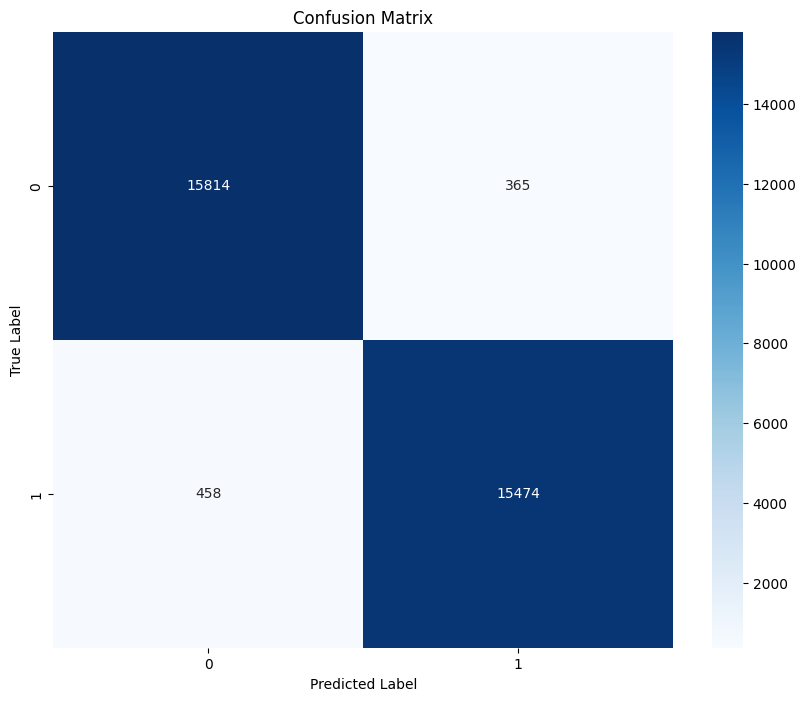


Accuracy: 0.9744


In [26]:
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np

# Get predictions
y_pred = best_model.predict(dtest)

# Convert GPU arrays to CPU numpy arrays for evaluation
y_test_cpu = y_test.values.get()
y_pred_cpu = y_pred

# Print evaluation metrics
print("\nClassification Report:")
print(classification_report(y_test_cpu, y_pred_cpu))

print("\nConfusion Matrix:")
print(confusion_matrix(y_test_cpu, y_pred_cpu))

# Visualize confusion matrix
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 8))
cm = confusion_matrix(y_test_cpu, y_pred_cpu)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

# Calculate and print accuracy
accuracy = (y_pred_cpu == y_test_cpu).mean()
print(f"\nAccuracy: {accuracy:.4f}")